# Set up

In [ ]:
!pip install timm --quiet
!pip install transformers --quiet

!pip install gdown --quiet
!pip install py_vncorenlp --quiet
%pip install \
    pandas \
    albumentations \
    opencv-python \
    numpy \
    matplotlib \
    seaborn \
    tqdm \
    torch torchvision torchaudio \
    timm \
    transformers \
    requests \
    einops


In [4]:
# Install OpenCV in the notebook environment so the `cv2` import can be resolved
import os
import json
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import requests

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertTokenizer, AutoModel, AutoTokenizer, AutoConfig


/tmp/ipykernel_3749367/3190489649.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Config

In [5]:
import py_vncorenlp

# Automatically download VnCoreNLP components from the original repository
# and save them in some local machine folder
py_vncorenlp.download_model()

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"])

text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

output = rdrsegmenter.word_segment(text)

print(' '.join(output))
# ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']


VnCoreNLP model folder . already exists! Please load VnCoreNLP from this folder!
2025-10-18 19:21:16 INFO  WordSegmenter:24 - Loading Word Segmentation model
Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội . Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .


In [6]:
import torch

class CFG:
    debug = False
    image_path = "/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images"
    captions_path = "."

    # ⚙️ Tối ưu nhẹ để tận dụng GPU A30 (24GB VRAM)
    batch_size = 64         # tăng từ 32 → 128 (A30 đủ sức)
    num_workers = 8           # tăng tốc load dữ liệu
    epochs = 1                # train nhiều hơn, giúp hội tụ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ⚙️ Giữ nguyên các giá trị gốc
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8

    image_model = None
    image_embedding = None

    text_encoder_model = None
    text_embedding = None
    text_tokenizer = None
    
    max_length = 70
    segmenter = None

    text_encoder_pretrained = True
    image_encoder_pretrained = True
    text_encoder_trainable = True
    image_encoder_trainable = True
    temperature = 1.0   # giữ nguyên theo CLIP gốc

    # image size
    size = 224

    # projection head
    num_projection_layers = 1
    projection_dim = 512
    dropout = 0.1

    '''
    ⚙️ Điều chỉnh cho A30:
      - batch_size = 128: tận dụng 24GB VRAM
      - num_workers = 8: đọc dữ liệu nhanh hơn
      - epochs = 5: giúp mô hình hội tụ tốt hơn
    ⚠️ Các thông số khác giữ nguyên hoàn toàn.
    '''


### Detailed CFG

In [7]:
__text_models__ = {
    "PhoBERT-base": "vinai/phobert-base-v2",
    "PhoBERT-large": "vinai/phobert-large",
    "ViT5-base": "VietAI/vit5-base",
    "ViT5-large": "VietAI/vit5-large"
}
__image_models__ = {
    "ViT-S": "vit_small_patch16_224",
    "ViT-B": "vit_base_patch16_224",
    "ViT-L": "vit_large_patch16_224",
    "ViT-H": "vit_huge_patch16_224",
    "ResNet50": "resnet50"
}

In [8]:
__text_models__ = {
    "PhoBERT-base": "vinai/phobert-base-v2",
    "PhoBERT-large": "vinai/phobert-large",
    "ViT5-base": "VietAI/vit5-base",
    "ViT5-large": "VietAI/vit5-large"
}

text_encoder_model = __text_models__["PhoBERT-large"]
CFG.text_encoder_pretrained = True
CFG.text_encoder_trainable = True

####################################################################################
CFG.text_encoder_model = text_encoder_model
CFG.text_tokenizer = text_encoder_model

if "pho" in text_encoder_model:
    CFG.segmenter = lambda sentence: ' '.join(rdrsegmenter.word_segment(sentence))
    
if text_encoder_model == "vinai/phobert-base-v2":
    CFG.text_embedding = 768
if text_encoder_model == "vinai/phobert-large":
    CFG.text_embedding = 1024
if text_encoder_model == "VietAI/vit5-base":
    CFG.text_embedding = 768
if text_encoder_model == "VietAI/vit5-large":
    CFG.text_embedding = 1024


In [9]:
__image_models__ = {
    "ViT-S": "vit_small_patch16_224",
    "ViT-B": "vit_base_patch16_224",
    "ViT-L": "vit_large_patch16_224",
    "ViT-H": "vit_huge_patch16_224",
    "ResNet50": "resnet50"
}
image_encoder_model = __image_models__["ResNet50"]
CFG.image_encoder_pretrained = True
CFG.image_encoder_trainable = False

####################################################################################
CFG.image_encoder_model = image_encoder_model

if image_encoder_model == "vit_small_patch16_224":
    CFG.image_embedding = None
if image_encoder_model == "vit_base_patch16_224":
    CFG.image_embedding = 768
if image_encoder_model == "vit_large_patch16_224":
    CFG.image_embedding = 1024
if image_encoder_model == "vit_huge_patch16_224":
    CFG.image_embedding = 1280
if image_encoder_model == "resnet50":
    CFG.image_embedding = 2048  
    

## Utils

In [10]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


# Datasets

In [11]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # pip install tqdm

def move_images(source, destination, prefix=""):
    """
    Copy ảnh từ source sang destination (tối ưu tốc độ, đa luồng).
    - Bỏ qua file trùng tên.
    - Hiển thị log rõ ràng (số ảnh trước/sau, số ảnh copy, bỏ qua).
    """

    if not os.path.exists(source):
        print(f"Source folder not found: {source}")
        return

    os.makedirs(destination, exist_ok=True)

    files = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
    total = len(files)
    if total == 0:
        print(f"No images found in {source}")
        return

    print(f"\nSource: {source}")
    print(f"Destination: {destination}")
    print(f"Found {total:,} files to copy.")

    before = len(os.listdir(destination))
    copied_count = 0
    skipped_count = 0

    def copy_one(file):
        nonlocal copied_count, skipped_count
        src = os.path.join(source, file)
        dst = os.path.join(destination, prefix + file)
        if os.path.exists(dst):
            skipped_count += 1
            return
        try:
            shutil.copy2(src, dst)
            copied_count += 1
        except Exception as e:
            print(f"Error copying {file}: {e}")

    # Auto: dùng toàn bộ CPU threads
    print("Copying in parallel (auto workers)...")
    with ThreadPoolExecutor(max_workers=None) as executor:
        list(tqdm(executor.map(copy_one, files), total=total, desc="Copying", unit="file"))

    after = len(os.listdir(destination))
    print(f"\nCopy complete.")
    print(f"Total source files: {total:,}")
    print(f"Copied files: {copied_count:,}")
    print(f"Skipped (already exists): {skipped_count:,}")
    print(f"Images before copy: {before:,}")
    print(f"Images after copy: {after:,}")


In [12]:
import os

# Quay về thư mục gốc project (điều chỉnh nếu bạn đang ở nhánh khác)
os.chdir("/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao")

# Tạo lại thư mục tmp/images
os.makedirs("tmp/images", exist_ok=True)

print("📂 Fixed path:", os.path.abspath("tmp/images"))


📂 Fixed path: /hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/tmp/images


In [13]:
!pwd

/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao


### coco

In [14]:
# COCO_PREFIX = "coco-"

In [15]:
# !wget http://images.cocodataset.org/zips/train2014.zip
# !wget http://images.cocodataset.org/zips/val2014.zip
# !unzip -q train2014.zip
# !rm train2014.zip
# !unzip -q val2014.zip
# !rm val2014.zip

In [16]:
print(os.listdir('.'))
print(len(os.listdir('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/val2014')))
print(len(os.listdir('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/train2014')))

['Test_Model', 'cocopathT.jsonl', 'Talent_Bridge', 'flickr', 'val2014', 'ktvic', 'open-ViIC', 'ViCGCN', 'uit-viic', 'Code', 'train2014', 'images', 'cocopath_val.jsonl', 'tmp', 'Data', 'cocopath_train.jsonl', 'rag-fastapi-project', 'kaggle.json', 'captions_val2014.json', 'Result', '.vscode', 'API', 'hs_err_pid3697736.log', 'Phoclip+FIQA', 'captions_train2014.json']
40504
82783


In [17]:
!pip install jsonlines
import jsonlines

In [18]:
# !gdown 10AbcXZaQmgUeKz6aRsHNV8HFMAni2qc4
# !gdown 1Ldvmxa9sykv805nJ4-PqtjbUvLKcrgz7

In [19]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed

# Cấu hình
COCO_PREFIX_TRAIN = "COCO_train2014_"
COCO_PREFIX_VAL = "COCO_val2014_"
SRC_TRAIN = "/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/train2014"
SRC_VAL = "/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/val2014"
DEST_DIR = "images"

os.makedirs(DEST_DIR, exist_ok=True)

def copy_image(src_dir, file, prefix):
    """Copy 1 ảnh sang thư mục đích (không ghi đè nếu trùng tên)"""
    try:
        img_id = int(file[-10:-4])  # Giữ nguyên logic lấy ID
        ext = file[-4:]
        new_name = f"{prefix}{str(img_id).zfill(12)}{ext}"
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(DEST_DIR, new_name)

        # ⚙️ Nếu file đã tồn tại, bỏ qua
        if os.path.exists(dst_path):
            return ("skip", new_name)

        shutil.copy2(src_path, dst_path)
        return ("copied", new_name)

    except Exception as e:
        return ("error", f"{file}: {e}")

def copy_all_images(src_dir, prefix, max_workers=16):
    """Copy song song ảnh từ thư mục, không lưu trùng tên"""
    files = [f for f in os.listdir(src_dir) if f.lower().endswith('.jpg')]
    total = len(files)
    copied = skipped = errors = 0

    print(f"👉 Bắt đầu copy {total} ảnh từ {src_dir}")

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(copy_image, src_dir, f, prefix): f for f in files}

        for i, future in enumerate(as_completed(futures)):
            status, name = future.result()

            if status == "copied":
                copied += 1
            elif status == "skip":
                skipped += 1
            elif status == "error":
                errors += 1
                print(f"\n❌ {name}")

            if (i + 1) % 1000 == 0 or i + 1 == total:
                print(f"\rĐã xử lý {i+1}/{total} ảnh...", end='')

    print(f"\n✅ Hoàn tất copy {total} ảnh từ {src_dir}")
    print(f"📊 Kết quả: {copied} copied, {skipped} skipped, {errors} lỗi")

# Chạy song song 2 tập train/val
copy_all_images(SRC_TRAIN, COCO_PREFIX_TRAIN, max_workers=16)
copy_all_images(SRC_VAL, COCO_PREFIX_VAL, max_workers=16)


👉 Bắt đầu copy 82783 ảnh từ /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/train2014
Đã xử lý 82783/82783 ảnh...
✅ Hoàn tất copy 82783 ảnh từ /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/train2014
📊 Kết quả: 0 copied, 82783 skipped, 0 lỗi
👉 Bắt đầu copy 40504 ảnh từ /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/val2014
Đã xử lý 40504/40504 ảnh...
✅ Hoàn tất copy 40504 ảnh từ /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/val2014
📊 Kết quả: 0 copied, 40504 skipped, 0 lỗi


In [20]:
import json
import jsonlines
import os

base_dir = '/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao'

# Đường dẫn input
train_json = os.path.join(base_dir, 'captions_train2014.json')
val_json   = os.path.join(base_dir, 'captions_val2014.json')

# Đường dẫn output
train_out = os.path.join(base_dir, 'cocopath_train.jsonl')
val_out   = os.path.join(base_dir, 'cocopath_val.jsonl')

def create_jsonl(input_path, output_path, prefix):
    """Đọc file captions_*.json và ghi ra file .jsonl có prefix riêng"""
    print(f"📂 Processing {input_path}")
    with open(input_path, 'r') as f:
        data = json.load(f)

    image_dict = {img['id']: img['file_name'] for img in data['images']}
    annotations = data['annotations']

    with jsonlines.open(output_path, 'w') as writer:
        for i, ann in enumerate(annotations, 1):
            image_id = ann['image_id']
            caption = ann['caption']
            file_name = image_dict.get(image_id)
            if file_name is None:
                continue

            # Đặt tên chuẩn COCO
            new_file_name = f"{prefix}{str(image_id).zfill(12)}.jpg"

            writer.write({
                'image': new_file_name,
                'caption': caption
            })

            if i % 5000 == 0:
                print(f"\r  -> {i}/{len(annotations)} written", end="")

    print(f"\n✅ Created {output_path} with {len(annotations)} samples")

# Tạo 2 file riêng
create_jsonl(train_json, train_out, prefix="COCO_train2014_")
create_jsonl(val_json, val_out, prefix="COCO_val2014_")


📂 Processing /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/captions_train2014.json
  -> 410000/414113 written
✅ Created /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopath_train.jsonl with 414113 samples
📂 Processing /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/captions_val2014.json
  -> 200000/202654 written
✅ Created /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopath_val.jsonl with 202654 samples


In [21]:
import pandas as pd
import jsonlines

def load_jsonl(path):
    imgs, caps = [], []
    with jsonlines.open(path) as reader:
        for line in reader:
            imgs.append(line['image'])
            caps.append(line['caption'])
    return pd.DataFrame({'image': imgs, 'caption': caps})

df_coco_train = load_jsonl('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopath_train.jsonl')
df_coco_val   = load_jsonl('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopath_val.jsonl')

print("COCO Train:", len(df_coco_train))
print("COCO Val:", len(df_coco_val))


COCO Train: 414113
COCO Val: 202654


In [22]:
%pip install ijson
import json
import jsonlines
import os
import ijson  # thư viện đọc JSON dạng stream (pip install ijson)

# Đường dẫn
base_dir = '/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao'
train_annotation_path = os.path.join(base_dir, 'captions_train2014.json')
val_annotation_path = os.path.join(base_dir, 'captions_val2014.json')
output_path = os.path.join(base_dir, 'cocopathT.jsonl')

# Kiểm tra file input
for path in [train_annotation_path, val_annotation_path]:
    if not os.path.exists(path):
        print(f"❌ Error: File {path} not found.")
        exit(1)

# Hàm đọc stream từ JSON annotations
def stream_annotations(json_path):
    """Đọc tuần tự từng annotation (ít tốn RAM)."""
    with open(json_path, 'rb') as f:
        for ann in ijson.items(f, 'annotations.item'):
            yield ann

def load_image_dict(json_path):
    """Đọc riêng phần images để map id -> file_name."""
    with open(json_path, 'r') as f:
        data = json.load(f)
    return {img['id']: img['file_name'] for img in data['images']}

# Tạo image_dict tổng
image_dict = {}
image_dict.update(load_image_dict(train_annotation_path))
image_dict.update(load_image_dict(val_annotation_path))

# Tạo file JSONL output
records_written = 0

with jsonlines.open(output_path, 'w') as writer:
    for src_path in [train_annotation_path, val_annotation_path]:
        print(f"📂 Processing {os.path.basename(src_path)} ...")

        for i, ann in enumerate(stream_annotations(src_path), 1):
            image_id = ann['image_id']
            caption = ann['caption']
            file_name = image_dict.get(image_id)

            if not file_name:
                if i % 5000 == 0:
                    print(f"\n⚠️ Warning: Missing file_name for image_id {image_id}")
                continue

            # ✅ Giữ nguyên đúng format COCO gốc
            new_file_name = file_name

            writer.write({
                'image': new_file_name,
                'caption': caption
            })
            records_written += 1

            if i % 1000 == 0:
                print(f"\r  -> {i:,} lines processed", end='')

print(f"\n✅ Created {output_path} successfully.")
print(f"📊 Total records written: {records_written:,}")


Note: you may need to restart the kernel to use updated packages.
📂 Processing captions_train2014.json ...
  -> 414,000 lines processed📂 Processing captions_val2014.json ...
  -> 202,000 lines processed
✅ Created /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopathT.jsonl successfully.
📊 Total records written: 616,767


In [23]:
import jsonlines
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from itertools import islice

# --- Cấu hình ---
json_path = '/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopathT.jsonl'
BATCH_SIZE = 10000  # đọc 10k dòng/lần để giữ RAM ổn định
MAX_WORKERS = max(2, multiprocessing.cpu_count() // 2)  # chỉ dùng nửa số core

# --- Hàm xử lý batch ---
def process_batch(lines):
    imgs, caps = [], []
    for line in lines:
        try:
            imgs.append(line['image'])
            caps.append(line['caption'])
        except KeyError:
            continue
    return imgs, caps

# --- Hàm đọc theo batch ---
def read_in_batches(reader, size):
    while True:
        batch = list(islice(reader, size))
        if not batch:
            break
        yield batch

# --- Xử lý ---
image_list, caption_list = [], []

print(f"🚀 Đang đọc {json_path} với {MAX_WORKERS} luồng (batch {BATCH_SIZE} dòng)...")

with jsonlines.open(json_path) as reader:
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = []
        for batch_id, batch in enumerate(read_in_batches(reader, BATCH_SIZE), start=1):
            futures.append(executor.submit(process_batch, batch))
            if batch_id % 10 == 0:
                print(f"\r🧩 Đã gửi {batch_id * BATCH_SIZE:,} dòng để xử lý...", end='')

        for i, future in enumerate(futures, start=1):
            imgs, caps = future.result()
            image_list.extend(imgs)
            caption_list.extend(caps)
            if i % 10 == 0:
                print(f"\r📦 Đã xử lý xong {i * BATCH_SIZE:,} dòng...", end='')

print(f"\n✅ Hoàn tất đọc {len(image_list):,} dòng.")

df_coco = pd.DataFrame({'image': image_list, 'caption': caption_list})
print(df_coco.head(20))


🚀 Đang đọc /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/cocopathT.jsonl với 20 luồng (batch 10000 dòng)...
📦 Đã xử lý xong 600,000 dòng.....
✅ Hoàn tất đọc 616,767 dòng.
                              image  \
0   COCO_train2014_000000318556.jpg   
1   COCO_train2014_000000116100.jpg   
2   COCO_train2014_000000318556.jpg   
3   COCO_train2014_000000116100.jpg   
4   COCO_train2014_000000379340.jpg   
5   COCO_train2014_000000379340.jpg   
6   COCO_train2014_000000318556.jpg   
7   COCO_train2014_000000318556.jpg   
8   COCO_train2014_000000134754.jpg   
9   COCO_train2014_000000538480.jpg   
10  COCO_train2014_000000476220.jpg   
11  COCO_train2014_000000299675.jpg   
12  COCO_train2014_000000032275.jpg   
13  COCO_train2014_000000302443.jpg   
14  COCO_train2014_000000134754.jpg   
15  COCO_train2014_000000025470.jpg   
16  COCO_train2014_000000513461.jpg   
17  COCO_train2014_000000018691.jpg   
18  COCO_train2014_000000285579.jpg   
19  COCO_train2014_000000266366.jpg   

              

In [24]:
# Sau khi tạo xong df_coco
df_coco_train = df_coco[df_coco['image'].str.contains("COCO_train2014")]
df_coco_val   = df_coco[df_coco['image'].str.contains("COCO_val2014")]

print(f"✅ COCO train samples: {len(df_coco_train)}")
print(f"✅ COCO val samples: {len(df_coco_val)}")


✅ COCO train samples: 414113
✅ COCO val samples: 202654


### flickr

In [25]:
!mkdir flickr
%cd flickr
FLICKR_PREFIX = "flickr-"

mkdir: cannot create directory ‘flickr’: File exists
/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/flickr


In [26]:
# !pip install kaggle
# !export KAGGLE_USERNAME=ducngg
# !export KAGGLE_KEY=179be8b8664502e51504151a35dec9c4

In [27]:
# import os
# import shutil

# # Đường dẫn file kaggle.json bạn tải về
# source_path = "/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/kaggle.json"
# target_dir = os.path.expanduser("~/.kaggle")
# target_path = os.path.join(target_dir, "kaggle.json")

# # Tạo thư mục ~/.kaggle nếu chưa có
# os.makedirs(target_dir, exist_ok=True)

# # Sao chép file vào đúng vị trí
# shutil.copy(source_path, target_path)

# # Đặt quyền 600 (chỉ chủ sở hữu được đọc/ghi)
# os.chmod(target_path, 0o600)

# print("✅ File kaggle.json đã được cài đặt tại:", target_path)


In [28]:
# # !kaggle datasets download adityajn105/flickr8k
# !kaggle datasets download trungit/flickr8k-vi-caps

In [29]:
# !unzip flickr8k-vi-caps.zip
# !rm flickr8k-vi-caps.zip

In [30]:
# !unzip -q flickr8k.zip
# !rm flickr8k.zip

In [31]:
with open('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/Phoclip+FIQA/flickr/captions_vi.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

image_list = []
caption_list = []

for line in lines:
    image, caption = line.strip().split('\t')
    image_list.append(FLICKR_PREFIX + image.strip())
    caption_list.append(caption.strip())

df_flickr = pd.DataFrame({'image': image_list, 'caption': caption_list})
df_flickr.head(20)

,image,caption
0,flickr-1332722096_1e3de8ae70.jpg,Ba người phụ nữ đứng trên một con phố trong th...
1,flickr-1332722096_1e3de8ae70.jpg,Ba người phụ nữ đi bộ xuống phố
2,flickr-1332722096_1e3de8ae70.jpg,Hai cô gái và một người phụ nữ đi bộ trên vỉa hè
3,flickr-1332722096_1e3de8ae70.jpg,Hai cô gái đi ủng màu xanh lá cây tươi sáng và...
4,flickr-1332722096_1e3de8ae70.jpg,Hai cô gái trẻ đi ủng màu xanh lá cây đang đi ...
5,flickr-1989145280_3b54452188.jpg,Một cô gái tóc vàng với chiếc kính râm trên đầ...
6,flickr-1989145280_3b54452188.jpg,Một người phụ nữ đeo kính râm
7,flickr-1989145280_3b54452188.jpg,Một người phụ nữ đeo kính râm trên đầu nhìn xuống
8,flickr-1989145280_3b54452188.jpg,người phụ nữ mặc áo đen và đeo kính trên đầu p...
9,flickr-1989145280_3b54452188.jpg,Người phụ nữ đeo kính râm đen nhìn xuống thứ g...


In [32]:
move_images('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/Phoclip+FIQA/flickr/Images', destination='/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images', prefix=FLICKR_PREFIX)


Source: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/Phoclip+FIQA/flickr/Images
Destination: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images
Found 8,091 files to copy.
Copying in parallel (auto workers)...


Copying: 100%|██████████| 8091/8091 [00:00<00:00, 158459.27file/s]


Copy complete.
Total source files: 8,091
Copied files: 0
Skipped (already exists): 8,091
Images before copy: 149,005
Images after copy: 149,005


In [33]:
%cd ..

/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao


### uit-viic

In [34]:
!mkdir uit-viic
%cd uit-viic
UITVIIC_PREFIX = "uitviic-"

mkdir: cannot create directory ‘uit-viic’: File exists
/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/uit-viic


In [35]:
# !gdown 1YexKrE6o0UiJhFWpE8M5LKoe6-k3AiM4

In [36]:
# !unzip UIT-ViIC-20200417T021508Z-001.zip
# !rm UIT-ViIC-20200417T021508Z-001.zip

In [37]:
with open('UIT-ViIC/uitviic_captions_train2017.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
images = data['images']
captions = data['annotations']

In [38]:
images = list(map(lambda item: {'id': item['id'],'image': item['coco_url']}, images))
captions = list(map(lambda item: {'id': item['image_id'], 'caption': item['caption']}, captions))

images_df = pd.DataFrame(images)
captions_df = pd.DataFrame(captions)

df_uitviic = pd.merge(images_df, captions_df, on='id')
df_uitviic

,id,image,caption
0,535668,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang bước tới đỡ bóng trong ...
1,535668,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang cầm gậy thi đấu trên sân .
2,535668,http://images.cocodataset.org/train2017/000000...,Người đàn ông đang chơi bóng chày trên sân .
3,535668,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang vung gậy bóng chày đỡ b...
4,535668,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang vung gậy đánh trả bóng ...
...,...,...,...
13476,574455,http://images.cocodataset.org/train2017/000000...,Một người đàn ông đang đứng ở trên sân bóng đá .
13477,574455,http://images.cocodataset.org/train2017/000000...,Một người đàn ông đang giơ tay lên cao ở trên ...
13478,574455,http://images.cocodataset.org/train2017/000000...,Một ông già đang giơ tay lên cao ở trên sân bó...
13479,574455,http://images.cocodataset.org/train2017/000000...,Một nam thủ môn đang giơ tay lên cao ở trên sân .


In [39]:
df_uitviic = df_uitviic.drop(['id'], axis=1)
df_uitviic

,image,caption
0,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang bước tới đỡ bóng trong ...
1,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang cầm gậy thi đấu trên sân .
2,http://images.cocodataset.org/train2017/000000...,Người đàn ông đang chơi bóng chày trên sân .
3,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang vung gậy bóng chày đỡ b...
4,http://images.cocodataset.org/train2017/000000...,Cầu thủ bóng chày đang vung gậy đánh trả bóng ...
...,...,...
13476,http://images.cocodataset.org/train2017/000000...,Một người đàn ông đang đứng ở trên sân bóng đá .
13477,http://images.cocodataset.org/train2017/000000...,Một người đàn ông đang giơ tay lên cao ở trên ...
13478,http://images.cocodataset.org/train2017/000000...,Một ông già đang giơ tay lên cao ở trên sân bó...
13479,http://images.cocodataset.org/train2017/000000...,Một nam thủ môn đang giơ tay lên cao ở trên sân .


In [40]:
%cd ..

/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao


### ktvic

In [41]:
!mkdir ktvic
%cd ktvic
KTVIC_PREFIX = "ktvic-"

mkdir: cannot create directory ‘ktvic’: File exists
/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic


In [42]:
# !gdown 11bwkfj8Qr9AIGSDe_xxlwj_asgwa8nNL
# !gdown 1xi5uyB_8obamsnv0COq4wsT90DBQg7-h
# !gdown 1GM8uMB4P93TPE6lZe2YcQnexzBxkl8c-
# !gdown 1ntMeBhf-Nut88fJfXEnEOvsnjG_Y7gKo

In [43]:
# !unzip -q train-images.zip
# !rm train-images.zip
# !unzip -q public-test-images.zip
# !rm public-test-images.zip

In [44]:
with open('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic/train_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

images = data['images']
captions = data['annotations']

In [45]:
images = list(map(lambda item: {'id': item['id'], 'image': KTVIC_PREFIX + item['filename']}, images))
captions = list(map(lambda item: {'id': item['image_id'], 'caption': item['caption']}, captions))

images_df = pd.DataFrame(images)
captions_df = pd.DataFrame(captions)

df_ktvic = pd.merge(images_df, captions_df, on='id')
df_ktvic

,id,image,caption
0,2,ktvic-00000000002.jpg,ba chiếc thuyền đang di chuyển ở trên con sông
1,2,ktvic-00000000002.jpg,có ba con thuyền đang di chuyển trên con sông
2,2,ktvic-00000000002.jpg,trên dòng sông có ba con thuyền đang di chuyển
3,2,ktvic-00000000002.jpg,ba con thuyền đang di chuyển bên một cánh đồng...
4,2,ktvic-00000000002.jpg,ba chiếc thuyền đang chuyển động trên một con ...
...,...,...,...
18840,11698,ktvic-00000011698.jpg,có một quả thanh long xuất hiện ở trên tay ngư...
18841,11698,ktvic-00000011698.jpg,có nhiều mặt hàng hoa quả xuất hiện ở trên kệ ...
18842,11698,ktvic-00000011698.jpg,đây là khung cảnh xuất hiện ở quầy hàng trái c...
18843,11698,ktvic-00000011698.jpg,có hai người phụ nữ đang đứng lựa trái cây bên...


In [46]:
df_ktvic = df_ktvic.drop(['id'], axis=1)
df_ktvic

,image,caption
0,ktvic-00000000002.jpg,ba chiếc thuyền đang di chuyển ở trên con sông
1,ktvic-00000000002.jpg,có ba con thuyền đang di chuyển trên con sông
2,ktvic-00000000002.jpg,trên dòng sông có ba con thuyền đang di chuyển
3,ktvic-00000000002.jpg,ba con thuyền đang di chuyển bên một cánh đồng...
4,ktvic-00000000002.jpg,ba chiếc thuyền đang chuyển động trên một con ...
...,...,...
18840,ktvic-00000011698.jpg,có một quả thanh long xuất hiện ở trên tay ngư...
18841,ktvic-00000011698.jpg,có nhiều mặt hàng hoa quả xuất hiện ở trên kệ ...
18842,ktvic-00000011698.jpg,đây là khung cảnh xuất hiện ở quầy hàng trái c...
18843,ktvic-00000011698.jpg,có hai người phụ nữ đang đứng lựa trái cây bên...


In [47]:
with open('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic/test_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

images = data['images']
captions = data['annotations']

In [48]:
images = list(map(lambda item: {'id': item['id'], 'image': KTVIC_PREFIX + item['filename']}, images))
captions = list(map(lambda item: {'id': item['image_id'], 'caption': item['caption']}, captions))

images_df = pd.DataFrame(images)
captions_df = pd.DataFrame(captions)

df_ktvic_val = pd.merge(images_df, captions_df, on='id')
df_ktvic_val 

,id,image,caption
0,1,ktvic-00000000001.jpg,đây là khung cảnh xuất hiện ở phía trước một c...
1,1,ktvic-00000000001.jpg,có một căn nhà cao tầng xuất hiện ở trong bức ảnh
2,1,ktvic-00000000001.jpg,ở trong bức ảnh có sự xuất hiện của một căn nh...
3,1,ktvic-00000000001.jpg,có một chiếc xe máy xuất hiện ở trong căn nhà
4,1,ktvic-00000000001.jpg,đây là bức ảnh chụp ở phía trước của một căn n...
...,...,...,...
2785,11688,ktvic-00000011688.jpg,có một cái kệ màu đỏ ở trên mô hình sân bóng đá
2786,11688,ktvic-00000011688.jpg,có một cái kệ có màu chủ đạo là màu đỏ
2787,11688,ktvic-00000011688.jpg,ở phía dưới cái kệ là mô hình sân bóng đá
2788,11688,ktvic-00000011688.jpg,có một cái mô hình sân bóng đá ở dưới cái kệ m...


In [49]:
df_ktvic_val = df_ktvic_val.drop(['id'], axis=1)
df_ktvic_val

,image,caption
0,ktvic-00000000001.jpg,đây là khung cảnh xuất hiện ở phía trước một c...
1,ktvic-00000000001.jpg,có một căn nhà cao tầng xuất hiện ở trong bức ảnh
2,ktvic-00000000001.jpg,ở trong bức ảnh có sự xuất hiện của một căn nh...
3,ktvic-00000000001.jpg,có một chiếc xe máy xuất hiện ở trong căn nhà
4,ktvic-00000000001.jpg,đây là bức ảnh chụp ở phía trước của một căn n...
...,...,...
2785,ktvic-00000011688.jpg,có một cái kệ màu đỏ ở trên mô hình sân bóng đá
2786,ktvic-00000011688.jpg,có một cái kệ có màu chủ đạo là màu đỏ
2787,ktvic-00000011688.jpg,ở phía dưới cái kệ là mô hình sân bóng đá
2788,ktvic-00000011688.jpg,có một cái mô hình sân bóng đá ở dưới cái kệ m...


In [50]:
move_images('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic/train-images', destination='/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images', prefix=KTVIC_PREFIX)
move_images('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic/public-test-images', destination='/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images', prefix=KTVIC_PREFIX)


Source: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic/train-images
Destination: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images
Found 3,769 files to copy.
Copying in parallel (auto workers)...


Copying: 100%|██████████| 3769/3769 [00:00<00:00, 404036.49file/s]



Copy complete.
Total source files: 3,769
Copied files: 0
Skipped (already exists): 3,769
Images before copy: 149,005
Images after copy: 149,005

Source: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/ktvic/public-test-images
Destination: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images
Found 558 files to copy.
Copying in parallel (auto workers)...


Copying: 100%|██████████| 558/558 [00:00<00:00, 151180.26file/s]


Copy complete.
Total source files: 558
Copied files: 0
Skipped (already exists): 558
Images before copy: 149,005
Images after copy: 149,005


In [51]:
%cd ..

/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao


### open-viic

In [52]:
!mkdir open-ViIC
%cd open-ViIC
OPENVIIC_PREFIX = "openviic-"

mkdir: cannot create directory ‘open-ViIC’: File exists
/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/open-ViIC


In [53]:
# !gdown 10E0cuWBaTgTvRj-bibTdfyABDDxCjXci
# !gdown 1rovWCFcA6s0CXQD6SkHisUjgcdheHVQy
# !gdown 1YfLMn-yRYN2ZT2CtdHeeRMPol0mVcWtw
# !gdown 1tedlrYhlBUMV7TeurW2DhbpSrX_1F9QD
# !unzip -q images.zip

In [54]:
with open('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/open-ViIC/uit-openviic-annotation-train.json', 'r') as f:
    json_data = json.load(f)

data = []
for image_path, image_data in json_data.items():
    for caption in image_data["captions"]:
        data.append({"image": OPENVIIC_PREFIX + image_path, "caption": caption})

df_openviic = pd.DataFrame(data)
df_openviic

,image,caption
0,openviic-00000000782.jpg,một con phố vắng vẻ có một tán cây lớn che ngang
1,openviic-00000000782.jpg,có một cái cây xanh trên vỉa hè phía bên phải ...
2,openviic-00000000782.jpg,có một người đang chạy xe băng qua ngã tư đường
3,openviic-00000000782.jpg,một người đang đi xe máy qua góc ngã tư có cây...
4,openviic-00000000782.jpg,có một con đường đầy cây xanh và những dãy nhà
...,...,...
41233,openviic-00000012598.jpg,vài chiếc xe được đậu trước cửa một quán ăn có...
41234,openviic-00000012598.jpg,có bốn xe đậu trước một cửa hiệu có hai chậu c...
41235,openviic-00000012599.jpg,có xe và người di chuyển trên con đường ướt có...
41236,openviic-00000012599.jpg,một cô đi xe máy ngang qua các gian hàng nhỏ h...


In [55]:
with open('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/open-ViIC/uit-openviic-annotation-dev.json', 'r') as f:
    json_data = json.load(f)

data = []
for image_path, image_data in json_data.items():
    for caption in image_data["captions"]:
        data.append({"image": OPENVIIC_PREFIX + image_path, "caption": caption})

df_openviic_val = pd.DataFrame(data)
df_openviic_val

,image,caption
0,openviic-00000000400.jpg,một cô gái tóc dài màu đen đang ngồi trên chiế...
1,openviic-00000000400.jpg,một cô gái người nước ngoài mặc váy đen đang n...
2,openviic-00000000400.jpg,một cô gái mặc đầm đen đang ngồi trên một chiế...
3,openviic-00000000400.jpg,một cô gái bận đầm đen đang xõa tóc và ngồi t...
4,openviic-00000000400.jpg,có một cô gái đang ngồi sau lưng cô là màu hồng
...,...,...
9997,openviic-00000006090.jpg,một người công an mặc đồ màu xanh dương đang đ...
9998,openviic-00000006090.jpg,hai nhân viên của một cửa hàng mặc áo xanh lá ...
9999,openviic-00000006090.jpg,có bốn người đang ở trong một cửa hàng và phía...
10000,openviic-00000006090.jpg,tại một cửa hàng bán thực phẩm có bốn người đa...


In [56]:
with open('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/open-ViIC/uit-openviic-annotation-test.json', 'r') as f:
    json_data = json.load(f)

data = []
for image_path, image_data in json_data.items():
    for caption in image_data["captions"]:
        data.append({"image": OPENVIIC_PREFIX + image_path, "caption": caption})

df_openviic_test = pd.DataFrame(data)
df_openviic_test

,image,caption
0,openviic-00000006091.jpg,một ngôi nhà màu vàng có các sợi dây leo màu x...
1,openviic-00000006091.jpg,một ngôi nhà cũ lâu đời màu vàng bên trong có ...
2,openviic-00000006091.jpg,một ngôi nhà cổ cao tầng màu vàng phía trước c...
3,openviic-00000006091.jpg,một ngôi nhà màu vàng có mái màu đỏ với nhiều ...
4,openviic-00000006091.jpg,một tòa nhà màu vàng được xây ở giữa rừng cây ...
...,...,...
9996,openviic-00000000781.jpg,biển quảng cáo tại một cửa hàng đồ ăn ở trên l...
9997,openviic-00000000781.jpg,phía trên biển quảng cáo là hình ảnh ba người...
9998,openviic-00000000781.jpg,poster màu nền trắng có nhiều ảnh đồ ăn liên q...
9999,openviic-00000000781.jpg,tấm biển quảng cáo có hình nhiều món ăn và hìn...


In [57]:
move_images('/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/open-ViIC/images', destination='/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images', prefix=OPENVIIC_PREFIX)


Source: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/open-ViIC/images
Destination: /home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images
Found 13,300 files to copy.
Copying in parallel (auto workers)...


Copying: 100%|██████████| 13300/13300 [00:00<00:00, 311478.51file/s]


Copy complete.
Total source files: 13,300
Copied files: 0
Skipped (already exists): 13,300
Images before copy: 149,005
Images after copy: 149,005


In [58]:
%cd ..

/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao


### Summary

In [59]:
len(os.listdir("/home/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/images"))

149005

In [60]:
data_df = pd.concat([df_flickr, df_ktvic, df_openviic, df_coco], ignore_index=True)
data_df

,image,caption
0,flickr-1332722096_1e3de8ae70.jpg,Ba người phụ nữ đứng trên một con phố trong th...
1,flickr-1332722096_1e3de8ae70.jpg,Ba người phụ nữ đi bộ xuống phố
2,flickr-1332722096_1e3de8ae70.jpg,Hai cô gái và một người phụ nữ đi bộ trên vỉa hè
3,flickr-1332722096_1e3de8ae70.jpg,Hai cô gái đi ủng màu xanh lá cây tươi sáng và...
4,flickr-1332722096_1e3de8ae70.jpg,Hai cô gái trẻ đi ủng màu xanh lá cây đang đi ...
...,...,...
716845,COCO_val2014_000000401092.jpg,A plate of food and a beverage are on a table.
716846,COCO_val2014_000000401092.jpg,This is an open faced sandwich with several co...
716847,COCO_val2014_000000555904.jpg,People eating in a restaurant near wine bottles.
716848,COCO_val2014_000000006177.jpg,The scissors with black handles are sitting open.


In [61]:
data_df_val = (df_ktvic_val, df_openviic_val, df_coco_val)
data_df_val

(                      image                                            caption
 0     ktvic-00000000001.jpg  đây là khung cảnh xuất hiện ở phía trước một c...
 1     ktvic-00000000001.jpg  có một căn nhà cao tầng xuất hiện ở trong bức ảnh
 2     ktvic-00000000001.jpg  ở trong bức ảnh có sự xuất hiện của một căn nh...
 3     ktvic-00000000001.jpg      có một chiếc xe máy xuất hiện ở trong căn nhà
 4     ktvic-00000000001.jpg  đây là bức ảnh chụp ở phía trước của một căn n...
 ...                     ...                                                ...
 2785  ktvic-00000011688.jpg    có một cái kệ màu đỏ ở trên mô hình sân bóng đá
 2786  ktvic-00000011688.jpg             có một cái kệ có màu chủ đạo là màu đỏ
 2787  ktvic-00000011688.jpg          ở phía dưới cái kệ là mô hình sân bóng đá
 2788  ktvic-00000011688.jpg  có một cái mô hình sân bóng đá ở dưới cái kệ m...
 2789  ktvic-00000011688.jpg     có một cái sân bóng đá phía dưới cái kệ màu đỏ
 
 [2790 rows x 2 columns],
            

In [62]:
import os

missing = [img for img in data_df['image'] if not os.path.exists(os.path.join('images', img))]

print(f"🔍 Tổng số ảnh trong data_df: {len(data_df)}")
print(f"❌ Ảnh bị thiếu: {len(missing)}")

if missing:
    print("📋 Ví dụ ảnh bị thiếu:")
    for name in missing[:10]:
        print("  ", name)
else:
    print("✅ Tất cả ảnh đều tồn tại trong thư mục images/")


🔍 Tổng số ảnh trong data_df: 716850
❌ Ảnh bị thiếu: 0
✅ Tất cả ảnh đều tồn tại trong thư mục images/


In [63]:
for index, row in data_df.head(10).iterrows():
    print(row['image'])


flickr-1332722096_1e3de8ae70.jpg
flickr-1332722096_1e3de8ae70.jpg
flickr-1332722096_1e3de8ae70.jpg
flickr-1332722096_1e3de8ae70.jpg
flickr-1332722096_1e3de8ae70.jpg
flickr-1989145280_3b54452188.jpg
flickr-1989145280_3b54452188.jpg
flickr-1989145280_3b54452188.jpg
flickr-1989145280_3b54452188.jpg
flickr-1989145280_3b54452188.jpg


In [64]:
# Count null values in each column
null_counts = data_df.isnull().sum()

# Total count of null values in the DataFrame
total_null_count = null_counts.sum()
total_null_count

np.int64(0)

# Components

In [74]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames và captions phải có cùng độ dài.
        Nếu một ảnh có nhiều caption -> lặp lại tên ảnh tương ứng.
        """
        self.image_filenames = image_filenames
        self.captions = list(captions)

        # Xử lý tách từ tiếng Việt nếu có segmenter
        if CFG.segmenter:
            self.captions = [CFG.segmenter(caption) for caption in captions]
        print(f"Sample caption: {self.captions[0]}")

        self.encoded_captions = tokenizer(
            self.captions, padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        """
        Load ảnh + caption, tự động bỏ qua ảnh lỗi.
        Nếu ảnh bị hỏng hoặc thiếu, sẽ thử ảnh kế tiếp để giữ batch đủ.
        """
        try:
            image_path = self.image_filenames[idx]
            # Nếu là URL
            if image_path.startswith("http"):
                response = requests.get(image_path, timeout=5)
                if response.status_code == 200:
                    image_data = np.frombuffer(response.content, dtype=np.uint8)
                    image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)
                else:
                    raise ValueError("URL download failed")
            else:
                # Ảnh local
                image_full_path = os.path.join(CFG.image_path, image_path)
                image = cv2.imread(image_full_path)

            # ⚠️ Ảnh lỗi hoặc không tồn tại
            if image is None:
                raise ValueError(f"Cannot read image: {image_path}")

            # Chuyển sang RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply augmentations
            if self.transforms:
                image = self.transforms(image=image)['image']

            # Encode caption
            item = {key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()}
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            item['caption'] = self.captions[idx]
            return item

        except Exception as e:
            # Ghi log ngắn gọn, tránh spam
            if idx % 500 == 0:
                print(f"⚠️ Bỏ qua ảnh lỗi tại index {idx}: {e}")

            # Thử ảnh kế tiếp (đảm bảo không crash DataLoader)
            new_idx = (idx + 1) % len(self.image_filenames)
            return self.__getitem__(new_idx)


def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose([
            A.Resize(CFG.size, CFG.size, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ])
    else:
        return A.Compose([
            A.Resize(CFG.size, CFG.size, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ])

## Image Encoder

In [66]:
class ImageEncoder(nn.Module):
    """
    Encode images
    """

    def __init__(
        self, model_name=CFG.image_encoder_model, pretrained=CFG.image_encoder_pretrained, trainable=CFG.image_encoder_pretrained
    ):
        super().__init__()
        
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

**CLS** and **SEP**: the start and end of a sentence. To grab the whole representation of a sentence (as the related BERT and DistilBERT papers point out) we use the final representations of the CLS token.

In [67]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.text_encoder_pretrained, trainable=CFG.text_encoder_trainable):
        super().__init__()
        
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            self.model = AutoModel(config=AutoConfig.from_pretrained(model_name))

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [68]:

# For 1 layer
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout,
        n_layers=CFG.num_projection_layers
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

    
# # For 2 layer above
# class ProjectionHead(nn.Module):
#     def __init__(
#         self,
#         embedding_dim,
#         projection_dim=CFG.projection_dim,
#         dropout=CFG.dropout,
#         n_layers=CFG.num_projection_layers
#     ):
#         super().__init__()
#         self.projection_layers = nn.ModuleList(
#             [nn.Linear(embedding_dim, projection_dim)] + \
#             [nn.Linear(projection_dim, projection_dim) for _ in range(n_layers-1)]
#         )
#         self.gelu = nn.GELU()
#         self.fc = nn.Linear(projection_dim, projection_dim)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(projection_dim)

#     def forward(self, x):
#         projected = x
#         for projection_layer in self.projection_layers:
#             projected = projection_layer(projected)
#             projected = self.gelu(projected)
#         x = self.fc(projected)
#         x = self.dropout(x)
#         x = x + projected
#         x = self.layer_norm(x)
#         return x


## CLIP

In [69]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(
            batch["image"]
        )
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [70]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))


tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


# Train

In [71]:
def make_train_valid_dfs():
    global data_df
    valid_df = pd.concat([df_ktvic_val, df_openviic_val, df_coco_val], ignore_index=True)

    print(f"Train: {len(data_df)} rows")
    print(f"Valid: {len(valid_df)} rows")
    return data_df, valid_df

def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Create train/valid loader

In [75]:
tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
train_df, valid_df = make_train_valid_dfs()
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

Train: 716850 rows
Valid: 215446 rows


/tmp/ipykernel_3749367/2984555709.py:73: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(CFG.size, CFG.size, always_apply=True),
/tmp/ipykernel_3749367/2984555709.py:74: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),


Sample caption: Ba người phụ_nữ đứng trên một con phố trong thành_phố


/tmp/ipykernel_3749367/2984555709.py:78: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(CFG.size, CFG.size, always_apply=True),
/tmp/ipykernel_3749367/2984555709.py:79: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),


Sample caption: đây là khung_cảnh xuất_hiện ở phía trước một căn nhà


In [76]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        print(loss)
        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main(train_loader, valid_loader):
    
    model = CLIPModel().to(CFG.device)
    
    print(model.image_encoder.parameters())
    print(model.text_encoder.parameters())
    
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)


In [ ]:
# import os
# import cv2
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor, as_completed

# def check_image(img_name, image_root):
#     """Kiểm tra một ảnh — trả về (index, path, lỗi hoặc None nếu OK)."""
#     img_path = os.path.join(image_root, img_name)
#     if not os.path.exists(img_path):
#         return (img_name, img_path, "❌ File not found")
#     img = cv2.imread(img_path)
#     if img is None:
#         return (img_name, img_path, "⚠️ Read error")
#     return None

# def check_missing_images_parallel(data_df, image_root="images", max_workers=32):
#     """
#     Kiểm tra ảnh bị lỗi/thiếu bằng đa luồng.
#     - Không xoá, chỉ in kết quả thống kê.
#     """
#     files = data_df["image"].tolist()
#     missing = []
    
#     print(f"🚀 Đang kiểm tra {len(files):,} ảnh với {max_workers} luồng ...")

#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         futures = {executor.submit(check_image, f, image_root): f for f in files}
#         for i, future in enumerate(tqdm(as_completed(futures), total=len(futures), desc="🔍 Checking")):
#             result = future.result()
#             if result:
#                 missing.append(result)

#     print(f"\n📊 Tổng số ảnh kiểm tra: {len(files):,}")
#     print(f"❌ Ảnh lỗi hoặc thiếu: {len(missing):,}")

#     if missing:
#         print("\n📋 Một vài ví dụ ảnh lỗi:")
#         for m in missing[:10]:
#             print(f" - {m[1]} ({m[2]})")

#     return missing


# # 👉 Gọi kiểm tra
# missing_images = check_missing_images_parallel(data_df, image_root=CFG.image_path, max_workers=32)

# print(f"\n🔎 Tổng số ảnh lỗi phát hiện: {len(missing_images)}")


🚀 Đang kiểm tra 716,850 ảnh với 32 luồng ...


🔍 Checking:  13%|█▎        | 89988/716850 [00:29<06:08, 1702.71it/s] Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
🔍 Checking:  14%|█▎        | 96867/716850 [00:33<06:13, 1658.60it/s]libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data
libpng warning: iCCP: extra compressed data
🔍 Checking:  32%|███▏      | 230908/716850 [04:36<06:20, 1276.00it/s]Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
🔍 Checking:  57%|█████▋    | 409715/716850 [10:38<07:58, 642.07it/s]  


In [77]:
main(train_loader, valid_loader)

<generator object Module.parameters at 0x7f5becffc740>
<generator object Module.parameters at 0x7f5becffc740>
Epoch: 1


  0%|          | 1/3367 [00:02<2:26:21,  2.61s/it, valid_loss=2.2]

tensor(2.1983, device='cuda:0')


  0%|          | 2/3367 [00:03<1:15:40,  1.35s/it, valid_loss=2.37]

tensor(2.5354, device='cuda:0')


  0%|          | 3/3367 [00:03<53:32,  1.05it/s, valid_loss=2.58]  

tensor(3.0056, device='cuda:0')


  0%|          | 4/3367 [00:04<44:37,  1.26it/s, valid_loss=2.61]

tensor(2.7069, device='cuda:0')


  0%|          | 5/3367 [00:04<40:12,  1.39it/s, valid_loss=2.87]

tensor(3.8872, device='cuda:0')


  0%|          | 6/3367 [00:05<37:12,  1.51it/s, valid_loss=2.86]

tensor(2.8142, device='cuda:0')


  0%|          | 7/3367 [00:05<35:11,  1.59it/s, valid_loss=2.79]

tensor(2.4123, device='cuda:0')


  0%|          | 8/3367 [00:06<33:44,  1.66it/s, valid_loss=2.83]

tensor(3.0953, device='cuda:0')


  0%|          | 9/3367 [00:06<32:52,  1.70it/s, valid_loss=2.82]

tensor(2.6834, device='cuda:0')


  0%|          | 10/3367 [00:07<32:13,  1.74it/s, valid_loss=2.79]

tensor(2.5691, device='cuda:0')


  0%|          | 11/3367 [00:08<31:46,  1.76it/s, valid_loss=2.77]

tensor(2.5839, device='cuda:0')


  0%|          | 12/3367 [00:08<31:08,  1.80it/s, valid_loss=2.77]

tensor(2.7238, device='cuda:0')


  0%|          | 13/3367 [00:09<30:38,  1.82it/s, valid_loss=2.74]

tensor(2.4056, device='cuda:0')


  0%|          | 14/3367 [00:09<30:50,  1.81it/s, valid_loss=2.75]

tensor(2.8346, device='cuda:0')


  0%|          | 15/3367 [00:10<30:23,  1.84it/s, valid_loss=2.7] 

tensor(2.1149, device='cuda:0')


  0%|          | 16/3367 [00:10<30:12,  1.85it/s, valid_loss=2.71]

tensor(2.7595, device='cuda:0')


  1%|          | 17/3367 [00:11<29:55,  1.87it/s, valid_loss=2.71]

tensor(2.6607, device='cuda:0')


  1%|          | 18/3367 [00:11<29:46,  1.88it/s, valid_loss=2.69]

tensor(2.4273, device='cuda:0')


  1%|          | 19/3367 [00:12<29:43,  1.88it/s, valid_loss=2.7] 

tensor(2.8638, device='cuda:0')


  1%|          | 20/3367 [00:12<29:40,  1.88it/s, valid_loss=2.71]

tensor(2.9346, device='cuda:0')


  1%|          | 21/3367 [00:13<29:38,  1.88it/s, valid_loss=2.71]

tensor(2.7342, device='cuda:0')


  1%|          | 22/3367 [00:13<29:43,  1.88it/s, valid_loss=2.71]

tensor(2.7403, device='cuda:0')


  1%|          | 23/3367 [00:14<29:44,  1.87it/s, valid_loss=2.7] 

tensor(2.4586, device='cuda:0')


  1%|          | 24/3367 [00:14<29:38,  1.88it/s, valid_loss=2.7]

tensor(2.5881, device='cuda:0')


  1%|          | 25/3367 [00:15<29:43,  1.87it/s, valid_loss=2.69]

tensor(2.5748, device='cuda:0')


  1%|          | 26/3367 [00:15<29:36,  1.88it/s, valid_loss=2.7] 

tensor(2.9783, device='cuda:0')


  1%|          | 27/3367 [00:16<29:32,  1.88it/s, valid_loss=2.71]

tensor(2.8441, device='cuda:0')


  1%|          | 28/3367 [00:17<29:34,  1.88it/s, valid_loss=2.7] 

tensor(2.3701, device='cuda:0')


  1%|          | 29/3367 [00:17<29:34,  1.88it/s, valid_loss=2.7]

tensor(2.8697, device='cuda:0')


  1%|          | 30/3367 [00:18<29:31,  1.88it/s, valid_loss=2.7]

tensor(2.5116, device='cuda:0')


  1%|          | 31/3367 [00:18<29:28,  1.89it/s, valid_loss=2.68]

tensor(2.1459, device='cuda:0')


  1%|          | 32/3367 [00:19<29:23,  1.89it/s, valid_loss=2.67]

tensor(2.4964, device='cuda:0')


  1%|          | 33/3367 [00:19<29:30,  1.88it/s, valid_loss=2.67]

tensor(2.7318, device='cuda:0')


  1%|          | 34/3367 [00:20<29:33,  1.88it/s, valid_loss=2.68]

tensor(2.7749, device='cuda:0')


  1%|          | 35/3367 [00:20<29:28,  1.88it/s, valid_loss=2.67]

tensor(2.2660, device='cuda:0')


  1%|          | 36/3367 [00:21<29:31,  1.88it/s, valid_loss=2.67]

tensor(2.8461, device='cuda:0')


  1%|          | 37/3367 [00:21<29:29,  1.88it/s, valid_loss=2.67]

tensor(2.7842, device='cuda:0')


  1%|          | 38/3367 [00:22<29:25,  1.89it/s, valid_loss=2.67]

tensor(2.4546, device='cuda:0')


  1%|          | 39/3367 [00:22<29:22,  1.89it/s, valid_loss=2.67]

tensor(2.9354, device='cuda:0')


  1%|          | 40/3367 [00:23<29:21,  1.89it/s, valid_loss=2.66]

tensor(2.1879, device='cuda:0')


  1%|          | 41/3367 [00:23<29:16,  1.89it/s, valid_loss=2.66]

tensor(2.5531, device='cuda:0')


  1%|          | 42/3367 [00:24<29:13,  1.90it/s, valid_loss=2.67]

tensor(2.9488, device='cuda:0')


  1%|▏         | 43/3367 [00:25<29:15,  1.89it/s, valid_loss=2.66]

tensor(2.4505, device='cuda:0')


  1%|▏         | 44/3367 [00:25<29:18,  1.89it/s, valid_loss=2.66]

tensor(2.3597, device='cuda:0')


  1%|▏         | 45/3367 [00:26<29:26,  1.88it/s, valid_loss=2.66]

tensor(2.7327, device='cuda:0')


  1%|▏         | 46/3367 [00:26<29:32,  1.87it/s, valid_loss=2.65]

tensor(2.3275, device='cuda:0')


  1%|▏         | 47/3367 [00:27<29:29,  1.88it/s, valid_loss=2.64]

tensor(2.2682, device='cuda:0')


  1%|▏         | 48/3367 [00:27<29:30,  1.87it/s, valid_loss=2.63]

tensor(2.3279, device='cuda:0')


  1%|▏         | 49/3367 [00:28<29:15,  1.89it/s, valid_loss=2.63]

tensor(2.3424, device='cuda:0')


  1%|▏         | 50/3367 [00:28<29:03,  1.90it/s, valid_loss=2.62]

tensor(2.4036, device='cuda:0')


  2%|▏         | 51/3367 [00:29<28:50,  1.92it/s, valid_loss=2.63]

tensor(2.9816, device='cuda:0')


  2%|▏         | 52/3367 [00:29<28:53,  1.91it/s, valid_loss=2.63]

tensor(2.5936, device='cuda:0')


  2%|▏         | 53/3367 [00:30<28:46,  1.92it/s, valid_loss=2.63]

tensor(2.3451, device='cuda:0')


  2%|▏         | 54/3367 [00:30<28:45,  1.92it/s, valid_loss=2.62]

tensor(2.5662, device='cuda:0')


  2%|▏         | 55/3367 [00:31<28:39,  1.93it/s, valid_loss=2.62]

tensor(2.5141, device='cuda:0')


  2%|▏         | 56/3367 [00:31<28:37,  1.93it/s, valid_loss=2.62]

tensor(2.4016, device='cuda:0')


  2%|▏         | 57/3367 [00:32<28:37,  1.93it/s, valid_loss=2.61]

tensor(2.1967, device='cuda:0')


  2%|▏         | 58/3367 [00:32<28:37,  1.93it/s, valid_loss=2.6] 

tensor(2.0380, device='cuda:0')


  2%|▏         | 59/3367 [00:33<28:33,  1.93it/s, valid_loss=2.6]

tensor(2.3941, device='cuda:0')


  2%|▏         | 60/3367 [00:33<28:28,  1.94it/s, valid_loss=2.6]

tensor(2.7695, device='cuda:0')


  2%|▏         | 61/3367 [00:34<28:23,  1.94it/s, valid_loss=2.6]

tensor(2.6280, device='cuda:0')


  2%|▏         | 62/3367 [00:34<28:44,  1.92it/s, valid_loss=2.6]

tensor(2.3755, device='cuda:0')


  2%|▏         | 63/3367 [00:35<28:38,  1.92it/s, valid_loss=2.59]

tensor(2.1419, device='cuda:0')


  2%|▏         | 64/3367 [00:35<28:30,  1.93it/s, valid_loss=2.59]

tensor(2.5648, device='cuda:0')


  2%|▏         | 65/3367 [00:36<28:32,  1.93it/s, valid_loss=2.59]

tensor(2.3165, device='cuda:0')


  2%|▏         | 66/3367 [00:37<28:31,  1.93it/s, valid_loss=2.58]

tensor(2.5010, device='cuda:0')


  2%|▏         | 67/3367 [00:37<28:31,  1.93it/s, valid_loss=2.58]

tensor(2.5604, device='cuda:0')


  2%|▏         | 68/3367 [00:38<28:30,  1.93it/s, valid_loss=2.58]

tensor(2.5306, device='cuda:0')


  2%|▏         | 69/3367 [00:38<28:18,  1.94it/s, valid_loss=2.58]

tensor(2.5080, device='cuda:0')


  2%|▏         | 70/3367 [00:39<28:20,  1.94it/s, valid_loss=2.58]

tensor(2.2566, device='cuda:0')


  2%|▏         | 71/3367 [00:39<28:33,  1.92it/s, valid_loss=2.58]

tensor(2.4537, device='cuda:0')


  2%|▏         | 72/3367 [00:40<28:25,  1.93it/s, valid_loss=2.57]

tensor(2.4843, device='cuda:0')


  2%|▏         | 73/3367 [00:40<28:23,  1.93it/s, valid_loss=2.57]

tensor(2.3720, device='cuda:0')


  2%|▏         | 74/3367 [00:41<28:24,  1.93it/s, valid_loss=2.57]

tensor(2.1529, device='cuda:0')


  2%|▏         | 75/3367 [00:41<28:20,  1.94it/s, valid_loss=2.57]

tensor(3.1254, device='cuda:0')


  2%|▏         | 76/3367 [00:42<28:26,  1.93it/s, valid_loss=2.57]

tensor(2.5739, device='cuda:0')


  2%|▏         | 77/3367 [00:42<28:27,  1.93it/s, valid_loss=2.57]

tensor(2.6307, device='cuda:0')


  2%|▏         | 78/3367 [00:43<28:30,  1.92it/s, valid_loss=2.58]

tensor(2.6959, device='cuda:0')


  2%|▏         | 79/3367 [00:43<28:28,  1.92it/s, valid_loss=2.57]

tensor(2.2825, device='cuda:0')


  2%|▏         | 80/3367 [00:44<28:23,  1.93it/s, valid_loss=2.57]

tensor(2.2141, device='cuda:0')


  2%|▏         | 81/3367 [00:44<28:00,  1.96it/s, valid_loss=2.57]

tensor(2.5562, device='cuda:0')


  2%|▏         | 82/3367 [00:45<27:40,  1.98it/s, valid_loss=2.57]

tensor(2.9031, device='cuda:0')


  2%|▏         | 83/3367 [00:45<27:50,  1.97it/s, valid_loss=2.57]

tensor(2.6144, device='cuda:0')


  2%|▏         | 84/3367 [00:46<28:11,  1.94it/s, valid_loss=2.57]

tensor(2.8226, device='cuda:0')


  3%|▎         | 85/3367 [00:46<28:14,  1.94it/s, valid_loss=2.57]

tensor(2.5843, device='cuda:0')


  3%|▎         | 86/3367 [00:47<28:16,  1.93it/s, valid_loss=2.58]

tensor(2.6269, device='cuda:0')


  3%|▎         | 87/3367 [00:47<28:21,  1.93it/s, valid_loss=2.58]

tensor(2.5908, device='cuda:0')


  3%|▎         | 88/3367 [00:48<28:21,  1.93it/s, valid_loss=2.57]

tensor(2.2699, device='cuda:0')


  3%|▎         | 89/3367 [00:48<28:09,  1.94it/s, valid_loss=2.57]

tensor(2.3872, device='cuda:0')


  3%|▎         | 90/3367 [00:49<28:10,  1.94it/s, valid_loss=2.57]

tensor(2.2828, device='cuda:0')


  3%|▎         | 91/3367 [00:49<27:47,  1.96it/s, valid_loss=2.56]

tensor(2.2014, device='cuda:0')


  3%|▎         | 92/3367 [00:50<27:29,  1.99it/s, valid_loss=2.56]

tensor(2.2678, device='cuda:0')


  3%|▎         | 93/3367 [00:50<27:36,  1.98it/s, valid_loss=2.56]

tensor(2.3824, device='cuda:0')


  3%|▎         | 94/3367 [00:51<27:44,  1.97it/s, valid_loss=2.56]

tensor(2.4372, device='cuda:0')


  3%|▎         | 95/3367 [00:51<27:56,  1.95it/s, valid_loss=2.56]

tensor(2.4543, device='cuda:0')


  3%|▎         | 96/3367 [00:52<27:59,  1.95it/s, valid_loss=2.56]

tensor(2.6972, device='cuda:0')


  3%|▎         | 97/3367 [00:52<28:04,  1.94it/s, valid_loss=2.55]

tensor(2.1063, device='cuda:0')


  3%|▎         | 98/3367 [00:53<28:00,  1.95it/s, valid_loss=2.55]

tensor(2.4769, device='cuda:0')


  3%|▎         | 99/3367 [00:53<28:04,  1.94it/s, valid_loss=2.55]

tensor(2.4332, device='cuda:0')


  3%|▎         | 100/3367 [00:54<28:03,  1.94it/s, valid_loss=2.55]

tensor(2.6406, device='cuda:0')


  3%|▎         | 101/3367 [00:55<28:01,  1.94it/s, valid_loss=2.55]

tensor(2.4010, device='cuda:0')


  3%|▎         | 102/3367 [00:55<28:08,  1.93it/s, valid_loss=2.55]

tensor(2.1903, device='cuda:0')


  3%|▎         | 103/3367 [00:56<27:50,  1.95it/s, valid_loss=2.55]

tensor(2.6735, device='cuda:0')


  3%|▎         | 104/3367 [00:56<27:33,  1.97it/s, valid_loss=2.54]

tensor(2.2134, device='cuda:0')


  3%|▎         | 105/3367 [00:57<27:34,  1.97it/s, valid_loss=2.54]

tensor(2.3301, device='cuda:0')


  3%|▎         | 106/3367 [00:57<27:24,  1.98it/s, valid_loss=2.54]

tensor(2.6469, device='cuda:0')


  3%|▎         | 107/3367 [00:58<27:17,  1.99it/s, valid_loss=2.54]

tensor(2.4780, device='cuda:0')


  3%|▎         | 108/3367 [00:58<27:35,  1.97it/s, valid_loss=2.54]

tensor(2.1476, device='cuda:0')


  3%|▎         | 109/3367 [00:59<27:38,  1.96it/s, valid_loss=2.54]

tensor(2.4489, device='cuda:0')


  3%|▎         | 110/3367 [00:59<27:47,  1.95it/s, valid_loss=2.54]

tensor(2.4521, device='cuda:0')


  3%|▎         | 111/3367 [01:00<27:58,  1.94it/s, valid_loss=2.54]

tensor(2.4331, device='cuda:0')


  3%|▎         | 112/3367 [01:00<28:02,  1.93it/s, valid_loss=2.53]

tensor(2.3275, device='cuda:0')


  3%|▎         | 113/3367 [01:01<27:57,  1.94it/s, valid_loss=2.53]

tensor(2.4611, device='cuda:0')


  3%|▎         | 114/3367 [01:01<27:59,  1.94it/s, valid_loss=2.54]

tensor(2.7417, device='cuda:0')


  3%|▎         | 115/3367 [01:02<27:55,  1.94it/s, valid_loss=2.54]

tensor(2.5539, device='cuda:0')


  3%|▎         | 116/3367 [01:02<28:00,  1.94it/s, valid_loss=2.53]

tensor(2.3315, device='cuda:0')


  3%|▎         | 117/3367 [01:03<27:54,  1.94it/s, valid_loss=2.53]

tensor(2.1722, device='cuda:0')


  4%|▎         | 118/3367 [01:03<28:00,  1.93it/s, valid_loss=2.53]

tensor(2.2738, device='cuda:0')


  4%|▎         | 119/3367 [01:04<27:43,  1.95it/s, valid_loss=2.53]

tensor(2.3446, device='cuda:0')


  4%|▎         | 120/3367 [01:04<27:32,  1.96it/s, valid_loss=2.53]

tensor(2.4615, device='cuda:0')


  4%|▎         | 121/3367 [01:05<27:24,  1.97it/s, valid_loss=2.52]

tensor(2.0529, device='cuda:0')


  4%|▎         | 122/3367 [01:05<27:51,  1.94it/s, valid_loss=2.52]

tensor(2.5239, device='cuda:0')


  4%|▎         | 123/3367 [01:06<27:52,  1.94it/s, valid_loss=2.52]

tensor(2.3310, device='cuda:0')


  4%|▎         | 124/3367 [01:06<27:49,  1.94it/s, valid_loss=2.52]

tensor(2.2168, device='cuda:0')


  4%|▎         | 125/3367 [01:07<27:50,  1.94it/s, valid_loss=2.52]

tensor(2.6430, device='cuda:0')


  4%|▎         | 126/3367 [01:07<27:50,  1.94it/s, valid_loss=2.52]

tensor(2.3089, device='cuda:0')


  4%|▍         | 127/3367 [01:08<27:46,  1.94it/s, valid_loss=2.52]

tensor(2.1892, device='cuda:0')


  4%|▍         | 128/3367 [01:08<27:48,  1.94it/s, valid_loss=2.51]

tensor(2.3836, device='cuda:0')


  4%|▍         | 129/3367 [01:09<27:39,  1.95it/s, valid_loss=2.51]

tensor(2.3854, device='cuda:0')


  4%|▍         | 130/3367 [01:09<27:43,  1.95it/s, valid_loss=2.51]

tensor(2.3510, device='cuda:0')


  4%|▍         | 131/3367 [01:10<27:24,  1.97it/s, valid_loss=2.51]

tensor(2.1368, device='cuda:0')


  4%|▍         | 132/3367 [01:10<27:29,  1.96it/s, valid_loss=2.51]

tensor(2.5528, device='cuda:0')


  4%|▍         | 133/3367 [01:11<27:34,  1.95it/s, valid_loss=2.51]

tensor(2.2296, device='cuda:0')


  4%|▍         | 134/3367 [01:11<27:41,  1.95it/s, valid_loss=2.51]

tensor(2.5021, device='cuda:0')


  4%|▍         | 135/3367 [01:12<27:43,  1.94it/s, valid_loss=2.51]

tensor(2.2185, device='cuda:0')


  4%|▍         | 136/3367 [01:12<27:48,  1.94it/s, valid_loss=2.51]

tensor(2.7996, device='cuda:0')


  4%|▍         | 137/3367 [01:13<27:53,  1.93it/s, valid_loss=2.51]

tensor(2.3449, device='cuda:0')


  4%|▍         | 138/3367 [01:14<27:49,  1.93it/s, valid_loss=2.5] 

tensor(1.9982, device='cuda:0')


  4%|▍         | 139/3367 [01:14<27:46,  1.94it/s, valid_loss=2.5]

tensor(2.6604, device='cuda:0')


  4%|▍         | 140/3367 [01:15<27:45,  1.94it/s, valid_loss=2.5]

tensor(2.4148, device='cuda:0')


  4%|▍         | 141/3367 [01:15<27:47,  1.93it/s, valid_loss=2.5]

tensor(2.1912, device='cuda:0')


  4%|▍         | 142/3367 [01:16<27:51,  1.93it/s, valid_loss=2.5]

tensor(2.3556, device='cuda:0')


  4%|▍         | 143/3367 [01:16<27:49,  1.93it/s, valid_loss=2.5]

tensor(2.3565, device='cuda:0')


  4%|▍         | 144/3367 [01:17<27:51,  1.93it/s, valid_loss=2.5]

tensor(2.5587, device='cuda:0')


  4%|▍         | 145/3367 [01:17<27:48,  1.93it/s, valid_loss=2.5]

tensor(2.3766, device='cuda:0')


  4%|▍         | 146/3367 [01:18<27:47,  1.93it/s, valid_loss=2.5]

tensor(2.3073, device='cuda:0')


  4%|▍         | 147/3367 [01:18<27:40,  1.94it/s, valid_loss=2.5]

tensor(2.5326, device='cuda:0')


  4%|▍         | 148/3367 [01:19<27:44,  1.93it/s, valid_loss=2.5]

tensor(2.6204, device='cuda:0')


  4%|▍         | 149/3367 [01:19<27:45,  1.93it/s, valid_loss=2.5]

tensor(2.6969, device='cuda:0')


  4%|▍         | 150/3367 [01:20<27:44,  1.93it/s, valid_loss=2.5]

tensor(2.4554, device='cuda:0')


  4%|▍         | 151/3367 [01:20<27:44,  1.93it/s, valid_loss=2.5]

tensor(2.5917, device='cuda:0')


  5%|▍         | 152/3367 [01:21<27:43,  1.93it/s, valid_loss=2.5]

tensor(2.4031, device='cuda:0')


  5%|▍         | 153/3367 [01:21<27:44,  1.93it/s, valid_loss=2.5]

tensor(2.4374, device='cuda:0')


  5%|▍         | 154/3367 [01:22<27:43,  1.93it/s, valid_loss=2.5]

tensor(2.7003, device='cuda:0')


  5%|▍         | 155/3367 [01:22<27:42,  1.93it/s, valid_loss=2.5]

tensor(2.5785, device='cuda:0')


  5%|▍         | 156/3367 [01:23<27:39,  1.94it/s, valid_loss=2.5]

tensor(2.5462, device='cuda:0')


  5%|▍         | 157/3367 [01:23<27:39,  1.93it/s, valid_loss=2.5]

tensor(2.4835, device='cuda:0')


  5%|▍         | 158/3367 [01:24<27:39,  1.93it/s, valid_loss=2.5]

tensor(2.5417, device='cuda:0')


  5%|▍         | 159/3367 [01:24<27:37,  1.94it/s, valid_loss=2.5]

tensor(2.6023, device='cuda:0')


  5%|▍         | 160/3367 [01:25<27:32,  1.94it/s, valid_loss=2.5]

tensor(2.3998, device='cuda:0')


  5%|▍         | 161/3367 [01:25<27:31,  1.94it/s, valid_loss=2.5]

tensor(2.2989, device='cuda:0')


  5%|▍         | 162/3367 [01:26<27:33,  1.94it/s, valid_loss=2.5]

tensor(2.6857, device='cuda:0')


  5%|▍         | 163/3367 [01:26<27:34,  1.94it/s, valid_loss=2.5]

tensor(2.3828, device='cuda:0')


  5%|▍         | 164/3367 [01:27<27:30,  1.94it/s, valid_loss=2.5]

tensor(2.6050, device='cuda:0')


  5%|▍         | 165/3367 [01:27<27:33,  1.94it/s, valid_loss=2.5]

tensor(2.7947, device='cuda:0')


  5%|▍         | 166/3367 [01:28<27:33,  1.94it/s, valid_loss=2.5]

tensor(2.7828, device='cuda:0')


  5%|▍         | 167/3367 [01:28<27:34,  1.93it/s, valid_loss=2.51]

tensor(2.6339, device='cuda:0')


  5%|▍         | 168/3367 [01:29<27:32,  1.94it/s, valid_loss=2.51]

tensor(2.5100, device='cuda:0')


  5%|▌         | 169/3367 [01:30<27:29,  1.94it/s, valid_loss=2.51]

tensor(2.5549, device='cuda:0')


  5%|▌         | 170/3367 [01:30<27:32,  1.93it/s, valid_loss=2.5] 

tensor(2.4042, device='cuda:0')


  5%|▌         | 171/3367 [01:31<27:29,  1.94it/s, valid_loss=2.51]

tensor(2.5574, device='cuda:0')


  5%|▌         | 172/3367 [01:31<27:34,  1.93it/s, valid_loss=2.51]

tensor(2.4993, device='cuda:0')


  5%|▌         | 173/3367 [01:32<27:35,  1.93it/s, valid_loss=2.51]

tensor(2.5310, device='cuda:0')


  5%|▌         | 174/3367 [01:32<27:27,  1.94it/s, valid_loss=2.51]

tensor(2.9126, device='cuda:0')


  5%|▌         | 175/3367 [01:33<27:26,  1.94it/s, valid_loss=2.51]

tensor(2.5051, device='cuda:0')


  5%|▌         | 176/3367 [01:33<27:26,  1.94it/s, valid_loss=2.51]

tensor(2.5284, device='cuda:0')


  5%|▌         | 177/3367 [01:34<27:27,  1.94it/s, valid_loss=2.51]

tensor(2.5628, device='cuda:0')


  5%|▌         | 178/3367 [01:34<27:30,  1.93it/s, valid_loss=2.51]

tensor(2.8519, device='cuda:0')


  5%|▌         | 179/3367 [01:35<27:35,  1.93it/s, valid_loss=2.51]

tensor(2.8217, device='cuda:0')


  5%|▌         | 180/3367 [01:35<27:31,  1.93it/s, valid_loss=2.51]

tensor(2.6381, device='cuda:0')


  5%|▌         | 181/3367 [01:36<27:31,  1.93it/s, valid_loss=2.51]

tensor(2.8170, device='cuda:0')


  5%|▌         | 182/3367 [01:36<27:34,  1.93it/s, valid_loss=2.51]

tensor(2.4969, device='cuda:0')


  5%|▌         | 183/3367 [01:37<27:28,  1.93it/s, valid_loss=2.51]

tensor(2.4287, device='cuda:0')


  5%|▌         | 184/3367 [01:37<27:29,  1.93it/s, valid_loss=2.51]

tensor(2.4349, device='cuda:0')


  5%|▌         | 185/3367 [01:38<27:31,  1.93it/s, valid_loss=2.51]

tensor(2.4803, device='cuda:0')


  6%|▌         | 186/3367 [01:38<27:28,  1.93it/s, valid_loss=2.51]

tensor(2.7008, device='cuda:0')


  6%|▌         | 187/3367 [01:39<27:24,  1.93it/s, valid_loss=2.51]

tensor(2.3770, device='cuda:0')


  6%|▌         | 188/3367 [01:39<27:21,  1.94it/s, valid_loss=2.51]

tensor(2.4036, device='cuda:0')


  6%|▌         | 189/3367 [01:40<27:19,  1.94it/s, valid_loss=2.51]

tensor(2.4252, device='cuda:0')


  6%|▌         | 190/3367 [01:40<27:16,  1.94it/s, valid_loss=2.51]

tensor(2.5698, device='cuda:0')


  6%|▌         | 191/3367 [01:41<27:14,  1.94it/s, valid_loss=2.51]

tensor(2.3916, device='cuda:0')


  6%|▌         | 192/3367 [01:41<27:14,  1.94it/s, valid_loss=2.51]

tensor(2.2846, device='cuda:0')


  6%|▌         | 193/3367 [01:42<27:15,  1.94it/s, valid_loss=2.51]

tensor(2.3937, device='cuda:0')


  6%|▌         | 194/3367 [01:42<27:12,  1.94it/s, valid_loss=2.51]

tensor(2.4157, device='cuda:0')


  6%|▌         | 195/3367 [01:43<27:12,  1.94it/s, valid_loss=2.51]

tensor(2.4444, device='cuda:0')


  6%|▌         | 196/3367 [01:43<27:10,  1.95it/s, valid_loss=2.51]

tensor(2.3167, device='cuda:0')


  6%|▌         | 197/3367 [01:44<27:09,  1.95it/s, valid_loss=2.51]

tensor(2.1681, device='cuda:0')


  6%|▌         | 198/3367 [01:44<27:07,  1.95it/s, valid_loss=2.51]

tensor(2.4024, device='cuda:0')


  6%|▌         | 199/3367 [01:45<27:07,  1.95it/s, valid_loss=2.5] 

tensor(2.2545, device='cuda:0')


  6%|▌         | 200/3367 [01:46<27:13,  1.94it/s, valid_loss=2.5]

tensor(2.1925, device='cuda:0')


  6%|▌         | 201/3367 [01:46<27:10,  1.94it/s, valid_loss=2.5]

tensor(1.2557, device='cuda:0')


  6%|▌         | 202/3367 [01:47<27:08,  1.94it/s, valid_loss=2.49]

tensor(1.1792, device='cuda:0')


  6%|▌         | 203/3367 [01:47<27:05,  1.95it/s, valid_loss=2.48]

tensor(1.2506, device='cuda:0')


  6%|▌         | 204/3367 [01:48<27:05,  1.95it/s, valid_loss=2.48]

tensor(1.0188, device='cuda:0')


  6%|▌         | 205/3367 [01:48<27:00,  1.95it/s, valid_loss=2.47]

tensor(0.9068, device='cuda:0')


  6%|▌         | 206/3367 [01:49<26:59,  1.95it/s, valid_loss=2.46]

tensor(1.1151, device='cuda:0')


  6%|▌         | 207/3367 [01:49<27:01,  1.95it/s, valid_loss=2.46]

tensor(0.8227, device='cuda:0')


  6%|▌         | 208/3367 [01:50<26:59,  1.95it/s, valid_loss=2.45]

tensor(1.0101, device='cuda:0')


  6%|▌         | 209/3367 [01:50<27:01,  1.95it/s, valid_loss=2.44]

tensor(1.1982, device='cuda:0')


  6%|▌         | 210/3367 [01:51<26:59,  1.95it/s, valid_loss=2.43]

tensor(0.9212, device='cuda:0')


  6%|▋         | 211/3367 [01:51<27:00,  1.95it/s, valid_loss=2.43]

tensor(0.9702, device='cuda:0')


  6%|▋         | 212/3367 [01:52<27:00,  1.95it/s, valid_loss=2.42]

tensor(0.9313, device='cuda:0')


  6%|▋         | 213/3367 [01:52<26:59,  1.95it/s, valid_loss=2.41]

tensor(0.8287, device='cuda:0')


  6%|▋         | 214/3367 [01:53<26:58,  1.95it/s, valid_loss=2.41]

tensor(1.0683, device='cuda:0')


  6%|▋         | 215/3367 [01:53<26:55,  1.95it/s, valid_loss=2.4] 

tensor(0.9097, device='cuda:0')


  6%|▋         | 216/3367 [01:54<27:00,  1.94it/s, valid_loss=2.39]

tensor(0.9146, device='cuda:0')


  6%|▋         | 217/3367 [01:54<26:56,  1.95it/s, valid_loss=2.39]

tensor(0.9915, device='cuda:0')


  6%|▋         | 218/3367 [01:55<26:57,  1.95it/s, valid_loss=2.38]

tensor(1.0748, device='cuda:0')


  7%|▋         | 219/3367 [01:55<27:00,  1.94it/s, valid_loss=2.37]

tensor(1.0559, device='cuda:0')


  7%|▋         | 220/3367 [01:56<26:59,  1.94it/s, valid_loss=2.37]

tensor(1.4656, device='cuda:0')


  7%|▋         | 221/3367 [01:56<26:58,  1.94it/s, valid_loss=2.36]

tensor(1.0281, device='cuda:0')


  7%|▋         | 222/3367 [01:57<27:00,  1.94it/s, valid_loss=2.36]

tensor(1.1522, device='cuda:0')


  7%|▋         | 223/3367 [01:57<26:55,  1.95it/s, valid_loss=2.35]

tensor(1.3041, device='cuda:0')


  7%|▋         | 224/3367 [01:58<26:59,  1.94it/s, valid_loss=2.35]

tensor(1.0941, device='cuda:0')


  7%|▋         | 225/3367 [01:58<26:54,  1.95it/s, valid_loss=2.34]

tensor(1.0842, device='cuda:0')


  7%|▋         | 226/3367 [01:59<26:52,  1.95it/s, valid_loss=2.34]

tensor(1.1101, device='cuda:0')


  7%|▋         | 227/3367 [01:59<26:56,  1.94it/s, valid_loss=2.33]

tensor(1.0002, device='cuda:0')


  7%|▋         | 228/3367 [02:00<26:57,  1.94it/s, valid_loss=2.33]

tensor(1.1611, device='cuda:0')


  7%|▋         | 229/3367 [02:00<26:56,  1.94it/s, valid_loss=2.32]

tensor(1.1575, device='cuda:0')


  7%|▋         | 230/3367 [02:01<26:55,  1.94it/s, valid_loss=2.32]

tensor(1.2146, device='cuda:0')


  7%|▋         | 231/3367 [02:01<26:54,  1.94it/s, valid_loss=2.31]

tensor(0.9627, device='cuda:0')


  7%|▋         | 232/3367 [02:02<26:53,  1.94it/s, valid_loss=2.31]

tensor(1.0803, device='cuda:0')


  7%|▋         | 233/3367 [02:02<26:52,  1.94it/s, valid_loss=2.3] 

tensor(1.0952, device='cuda:0')


  7%|▋         | 234/3367 [02:03<26:53,  1.94it/s, valid_loss=2.3]

tensor(1.2809, device='cuda:0')


  7%|▋         | 235/3367 [02:04<26:52,  1.94it/s, valid_loss=2.29]

tensor(1.2006, device='cuda:0')


  7%|▋         | 236/3367 [02:04<26:46,  1.95it/s, valid_loss=2.29]

tensor(1.2548, device='cuda:0')


  7%|▋         | 237/3367 [02:05<26:50,  1.94it/s, valid_loss=2.28]

tensor(1.1295, device='cuda:0')


  7%|▋         | 238/3367 [02:05<26:48,  1.95it/s, valid_loss=2.28]

tensor(1.1884, device='cuda:0')


  7%|▋         | 239/3367 [02:06<26:49,  1.94it/s, valid_loss=2.27]

tensor(1.3994, device='cuda:0')


  7%|▋         | 240/3367 [02:06<26:46,  1.95it/s, valid_loss=2.27]

tensor(1.5697, device='cuda:0')


  7%|▋         | 241/3367 [02:07<26:44,  1.95it/s, valid_loss=2.27]

tensor(1.3927, device='cuda:0')


  7%|▋         | 242/3367 [02:07<26:44,  1.95it/s, valid_loss=2.26]

tensor(1.2176, device='cuda:0')


  7%|▋         | 243/3367 [02:08<26:40,  1.95it/s, valid_loss=2.26]

tensor(1.1357, device='cuda:0')


  7%|▋         | 244/3367 [02:08<26:42,  1.95it/s, valid_loss=2.26]

tensor(1.5892, device='cuda:0')


  7%|▋         | 245/3367 [02:09<26:45,  1.94it/s, valid_loss=2.25]

tensor(1.2985, device='cuda:0')


  7%|▋         | 246/3367 [02:09<26:43,  1.95it/s, valid_loss=2.25]

tensor(1.4603, device='cuda:0')


  7%|▋         | 247/3367 [02:10<26:47,  1.94it/s, valid_loss=2.24]

tensor(1.2119, device='cuda:0')


  7%|▋         | 248/3367 [02:10<26:43,  1.95it/s, valid_loss=2.24]

tensor(1.6460, device='cuda:0')


  7%|▋         | 249/3367 [02:11<26:46,  1.94it/s, valid_loss=2.24]

tensor(1.0562, device='cuda:0')


  7%|▋         | 250/3367 [02:11<26:40,  1.95it/s, valid_loss=2.23]

tensor(1.3535, device='cuda:0')


  7%|▋         | 251/3367 [02:12<26:40,  1.95it/s, valid_loss=2.23]

tensor(1.3792, device='cuda:0')


  7%|▋         | 252/3367 [02:12<26:43,  1.94it/s, valid_loss=2.23]

tensor(1.2016, device='cuda:0')


  8%|▊         | 253/3367 [02:13<26:43,  1.94it/s, valid_loss=2.22]

tensor(1.4242, device='cuda:0')


  8%|▊         | 254/3367 [02:13<26:41,  1.94it/s, valid_loss=2.22]

tensor(1.3204, device='cuda:0')


  8%|▊         | 255/3367 [02:14<26:41,  1.94it/s, valid_loss=2.22]

tensor(1.3737, device='cuda:0')


  8%|▊         | 256/3367 [02:14<26:47,  1.94it/s, valid_loss=2.21]

tensor(1.1175, device='cuda:0')


  8%|▊         | 257/3367 [02:15<26:39,  1.94it/s, valid_loss=2.21]

tensor(1.2968, device='cuda:0')


  8%|▊         | 258/3367 [02:15<26:40,  1.94it/s, valid_loss=2.2] 

tensor(1.2493, device='cuda:0')


  8%|▊         | 259/3367 [02:16<26:38,  1.94it/s, valid_loss=2.2]

tensor(1.4252, device='cuda:0')


  8%|▊         | 260/3367 [02:16<26:36,  1.95it/s, valid_loss=2.2]

tensor(1.0760, device='cuda:0')


  8%|▊         | 261/3367 [02:17<26:35,  1.95it/s, valid_loss=2.19]

tensor(1.1894, device='cuda:0')


  8%|▊         | 262/3367 [02:17<26:37,  1.94it/s, valid_loss=2.19]

tensor(1.6238, device='cuda:0')


  8%|▊         | 263/3367 [02:18<26:32,  1.95it/s, valid_loss=2.19]

tensor(1.3747, device='cuda:0')


  8%|▊         | 264/3367 [02:18<26:38,  1.94it/s, valid_loss=2.18]

tensor(1.0686, device='cuda:0')


  8%|▊         | 265/3367 [02:19<26:33,  1.95it/s, valid_loss=2.18]

tensor(0.8690, device='cuda:0')


  8%|▊         | 266/3367 [02:19<26:34,  1.94it/s, valid_loss=2.17]

tensor(1.1492, device='cuda:0')


  8%|▊         | 267/3367 [02:20<26:34,  1.94it/s, valid_loss=2.17]

tensor(1.3577, device='cuda:0')


  8%|▊         | 268/3367 [02:20<26:30,  1.95it/s, valid_loss=2.17]

tensor(1.2471, device='cuda:0')


  8%|▊         | 269/3367 [02:21<26:31,  1.95it/s, valid_loss=2.16]

tensor(0.9879, device='cuda:0')


  8%|▊         | 270/3367 [02:22<26:41,  1.93it/s, valid_loss=2.16]

tensor(1.3132, device='cuda:0')


  8%|▊         | 271/3367 [02:22<26:36,  1.94it/s, valid_loss=2.16]

tensor(1.2601, device='cuda:0')


  8%|▊         | 272/3367 [02:23<26:35,  1.94it/s, valid_loss=2.15]

tensor(0.8287, device='cuda:0')


  8%|▊         | 273/3367 [02:23<26:32,  1.94it/s, valid_loss=2.15]

tensor(1.1596, device='cuda:0')


  8%|▊         | 274/3367 [02:24<26:31,  1.94it/s, valid_loss=2.14]

tensor(1.0353, device='cuda:0')


  8%|▊         | 275/3367 [02:24<26:31,  1.94it/s, valid_loss=2.14]

tensor(1.1986, device='cuda:0')


  8%|▊         | 276/3367 [02:25<26:30,  1.94it/s, valid_loss=2.14]

tensor(1.1180, device='cuda:0')


  8%|▊         | 277/3367 [02:25<26:33,  1.94it/s, valid_loss=2.14]

tensor(1.5326, device='cuda:0')


  8%|▊         | 278/3367 [02:26<26:33,  1.94it/s, valid_loss=2.13]

tensor(1.1405, device='cuda:0')


  8%|▊         | 279/3367 [02:26<26:35,  1.93it/s, valid_loss=2.13]

tensor(1.2878, device='cuda:0')


  8%|▊         | 280/3367 [02:27<26:33,  1.94it/s, valid_loss=2.13]

tensor(1.1059, device='cuda:0')


  8%|▊         | 281/3367 [02:27<26:28,  1.94it/s, valid_loss=2.12]

tensor(1.1608, device='cuda:0')


  8%|▊         | 282/3367 [02:28<26:28,  1.94it/s, valid_loss=2.12]

tensor(1.0789, device='cuda:0')


  8%|▊         | 283/3367 [02:28<26:29,  1.94it/s, valid_loss=2.12]

tensor(1.3323, device='cuda:0')


  8%|▊         | 284/3367 [02:29<26:32,  1.94it/s, valid_loss=2.11]

tensor(1.2830, device='cuda:0')


  8%|▊         | 285/3367 [02:29<26:27,  1.94it/s, valid_loss=2.11]

tensor(0.8108, device='cuda:0')


  8%|▊         | 286/3367 [02:30<26:26,  1.94it/s, valid_loss=2.1] 

tensor(1.2716, device='cuda:0')


  9%|▊         | 287/3367 [02:30<26:28,  1.94it/s, valid_loss=2.1]

tensor(1.2949, device='cuda:0')


  9%|▊         | 288/3367 [02:31<26:32,  1.93it/s, valid_loss=2.1]

tensor(1.1949, device='cuda:0')


  9%|▊         | 289/3367 [02:31<26:34,  1.93it/s, valid_loss=2.1]

tensor(1.1880, device='cuda:0')


  9%|▊         | 290/3367 [02:32<26:28,  1.94it/s, valid_loss=2.09]

tensor(0.7721, device='cuda:0')


  9%|▊         | 291/3367 [02:32<26:27,  1.94it/s, valid_loss=2.09]

tensor(1.6400, device='cuda:0')


  9%|▊         | 292/3367 [02:33<26:29,  1.93it/s, valid_loss=2.09]

tensor(1.2991, device='cuda:0')


  9%|▊         | 293/3367 [02:33<26:59,  1.90it/s, valid_loss=2.08]

tensor(1.0224, device='cuda:0')


  9%|▊         | 294/3367 [02:34<27:20,  1.87it/s, valid_loss=2.08]

tensor(0.9493, device='cuda:0')


  9%|▉         | 295/3367 [02:35<27:29,  1.86it/s, valid_loss=2.08]

tensor(1.4180, device='cuda:0')


  9%|▉         | 296/3367 [02:35<27:32,  1.86it/s, valid_loss=2.07]

tensor(1.2963, device='cuda:0')


  9%|▉         | 297/3367 [02:36<27:40,  1.85it/s, valid_loss=2.07]

tensor(1.3136, device='cuda:0')


  9%|▉         | 298/3367 [02:36<27:40,  1.85it/s, valid_loss=2.07]

tensor(1.0216, device='cuda:0')


  9%|▉         | 299/3367 [02:37<27:42,  1.85it/s, valid_loss=2.07]

tensor(1.1715, device='cuda:0')


  9%|▉         | 300/3367 [02:37<27:45,  1.84it/s, valid_loss=2.06]

tensor(1.3967, device='cuda:0')


  9%|▉         | 301/3367 [02:38<27:31,  1.86it/s, valid_loss=2.06]

tensor(1.1561, device='cuda:0')


  9%|▉         | 302/3367 [02:38<27:23,  1.87it/s, valid_loss=2.06]

tensor(1.2311, device='cuda:0')


  9%|▉         | 303/3367 [02:39<27:10,  1.88it/s, valid_loss=2.06]

tensor(1.4867, device='cuda:0')


  9%|▉         | 304/3367 [02:39<27:04,  1.89it/s, valid_loss=2.05]

tensor(1.3379, device='cuda:0')


  9%|▉         | 305/3367 [02:40<26:58,  1.89it/s, valid_loss=2.05]

tensor(1.2337, device='cuda:0')


  9%|▉         | 306/3367 [02:40<26:54,  1.90it/s, valid_loss=2.05]

tensor(1.1923, device='cuda:0')


  9%|▉         | 307/3367 [02:41<26:53,  1.90it/s, valid_loss=2.04]

tensor(1.1783, device='cuda:0')


  9%|▉         | 308/3367 [02:41<26:52,  1.90it/s, valid_loss=2.04]

tensor(1.1514, device='cuda:0')


  9%|▉         | 309/3367 [02:42<26:54,  1.89it/s, valid_loss=2.04]

tensor(1.4494, device='cuda:0')


  9%|▉         | 310/3367 [02:43<26:52,  1.90it/s, valid_loss=2.04]

tensor(1.2480, device='cuda:0')


  9%|▉         | 311/3367 [02:43<26:52,  1.90it/s, valid_loss=2.03]

tensor(1.1720, device='cuda:0')


  9%|▉         | 312/3367 [02:44<26:52,  1.89it/s, valid_loss=2.03]

tensor(0.9225, device='cuda:0')


  9%|▉         | 313/3367 [02:44<26:51,  1.90it/s, valid_loss=2.03]

tensor(1.5505, device='cuda:0')


  9%|▉         | 314/3367 [02:45<26:52,  1.89it/s, valid_loss=2.03]

tensor(1.2640, device='cuda:0')


  9%|▉         | 315/3367 [02:45<26:53,  1.89it/s, valid_loss=2.02]

tensor(1.2658, device='cuda:0')


  9%|▉         | 316/3367 [02:46<26:51,  1.89it/s, valid_loss=2.02]

tensor(1.1244, device='cuda:0')


  9%|▉         | 317/3367 [02:46<26:44,  1.90it/s, valid_loss=2.02]

tensor(1.0297, device='cuda:0')


  9%|▉         | 318/3367 [02:47<26:42,  1.90it/s, valid_loss=2.02]

tensor(1.3582, device='cuda:0')


  9%|▉         | 319/3367 [02:47<26:45,  1.90it/s, valid_loss=2.01]

tensor(1.0629, device='cuda:0')


 10%|▉         | 320/3367 [02:48<26:45,  1.90it/s, valid_loss=2.01]

tensor(0.9846, device='cuda:0')


 10%|▉         | 321/3367 [02:48<26:40,  1.90it/s, valid_loss=2.01]

tensor(1.0359, device='cuda:0')


 10%|▉         | 322/3367 [02:49<26:40,  1.90it/s, valid_loss=2]   

tensor(1.0720, device='cuda:0')


 10%|▉         | 323/3367 [02:49<26:44,  1.90it/s, valid_loss=2]

tensor(1.3649, device='cuda:0')


 10%|▉         | 324/3367 [02:50<26:46,  1.89it/s, valid_loss=2]

tensor(0.9908, device='cuda:0')


 10%|▉         | 325/3367 [02:50<26:46,  1.89it/s, valid_loss=2]

tensor(1.1159, device='cuda:0')


 10%|▉         | 326/3367 [02:51<26:44,  1.89it/s, valid_loss=1.99]

tensor(1.3502, device='cuda:0')


 10%|▉         | 327/3367 [02:51<26:50,  1.89it/s, valid_loss=1.99]

tensor(0.9153, device='cuda:0')


 10%|▉         | 328/3367 [02:52<26:47,  1.89it/s, valid_loss=1.99]

tensor(0.8878, device='cuda:0')


 10%|▉         | 329/3367 [02:53<26:43,  1.89it/s, valid_loss=1.99]

tensor(0.9832, device='cuda:0')


 10%|▉         | 330/3367 [02:53<26:45,  1.89it/s, valid_loss=1.98]

tensor(1.2612, device='cuda:0')


 10%|▉         | 331/3367 [02:54<26:47,  1.89it/s, valid_loss=1.98]

tensor(1.1745, device='cuda:0')


 10%|▉         | 332/3367 [02:54<26:49,  1.89it/s, valid_loss=1.98]

tensor(1.2082, device='cuda:0')


 10%|▉         | 333/3367 [02:55<26:43,  1.89it/s, valid_loss=1.98]

tensor(1.3407, device='cuda:0')


 10%|▉         | 334/3367 [02:55<26:39,  1.90it/s, valid_loss=1.97]

tensor(1.1152, device='cuda:0')


 10%|▉         | 335/3367 [02:56<26:39,  1.90it/s, valid_loss=1.97]

tensor(1.3371, device='cuda:0')


 10%|▉         | 336/3367 [02:56<26:39,  1.89it/s, valid_loss=1.97]

tensor(1.2712, device='cuda:0')


 10%|█         | 337/3367 [02:57<26:44,  1.89it/s, valid_loss=1.97]

tensor(0.9664, device='cuda:0')


 10%|█         | 338/3367 [02:57<26:45,  1.89it/s, valid_loss=1.96]

tensor(1.1891, device='cuda:0')


 10%|█         | 339/3367 [02:58<26:37,  1.90it/s, valid_loss=1.96]

tensor(0.9695, device='cuda:0')


 10%|█         | 340/3367 [02:58<26:41,  1.89it/s, valid_loss=1.96]

tensor(0.9868, device='cuda:0')


 10%|█         | 341/3367 [02:59<26:51,  1.88it/s, valid_loss=1.96]

tensor(1.3062, device='cuda:0')


 10%|█         | 342/3367 [02:59<26:46,  1.88it/s, valid_loss=1.95]

tensor(1.0565, device='cuda:0')


 10%|█         | 343/3367 [03:00<26:40,  1.89it/s, valid_loss=1.95]

tensor(0.9403, device='cuda:0')


 10%|█         | 344/3367 [03:00<26:41,  1.89it/s, valid_loss=1.95]

tensor(1.5772, device='cuda:0')


 10%|█         | 345/3367 [03:01<26:40,  1.89it/s, valid_loss=1.95]

tensor(1.4461, device='cuda:0')


 10%|█         | 346/3367 [03:02<26:38,  1.89it/s, valid_loss=1.95]

tensor(0.9544, device='cuda:0')


 10%|█         | 347/3367 [03:02<26:36,  1.89it/s, valid_loss=1.94]

tensor(1.4929, device='cuda:0')


 10%|█         | 348/3367 [03:03<26:36,  1.89it/s, valid_loss=1.94]

tensor(1.3063, device='cuda:0')


 10%|█         | 349/3367 [03:03<26:38,  1.89it/s, valid_loss=1.94]

tensor(1.0876, device='cuda:0')


 10%|█         | 350/3367 [03:04<26:34,  1.89it/s, valid_loss=1.94]

tensor(1.1721, device='cuda:0')


 10%|█         | 351/3367 [03:04<26:29,  1.90it/s, valid_loss=1.94]

tensor(1.1419, device='cuda:0')


 10%|█         | 352/3367 [03:05<26:31,  1.89it/s, valid_loss=1.93]

tensor(0.9968, device='cuda:0')


 10%|█         | 353/3367 [03:05<26:28,  1.90it/s, valid_loss=1.93]

tensor(0.9910, device='cuda:0')


 11%|█         | 354/3367 [03:06<26:28,  1.90it/s, valid_loss=1.93]

tensor(1.0089, device='cuda:0')


 11%|█         | 355/3367 [03:06<26:32,  1.89it/s, valid_loss=1.92]

tensor(0.9425, device='cuda:0')


 11%|█         | 356/3367 [03:07<26:35,  1.89it/s, valid_loss=1.92]

tensor(0.8238, device='cuda:0')


 11%|█         | 357/3367 [03:07<26:31,  1.89it/s, valid_loss=1.92]

tensor(0.8430, device='cuda:0')


 11%|█         | 358/3367 [03:08<26:31,  1.89it/s, valid_loss=1.92]

tensor(1.0538, device='cuda:0')


 11%|█         | 359/3367 [03:08<26:31,  1.89it/s, valid_loss=1.91]

tensor(0.8003, device='cuda:0')


 11%|█         | 360/3367 [03:09<26:30,  1.89it/s, valid_loss=1.91]

tensor(1.2887, device='cuda:0')


 11%|█         | 361/3367 [03:09<26:33,  1.89it/s, valid_loss=1.91]

tensor(1.2995, device='cuda:0')


 11%|█         | 362/3367 [03:10<26:26,  1.89it/s, valid_loss=1.91]

tensor(1.0951, device='cuda:0')


 11%|█         | 363/3367 [03:11<26:27,  1.89it/s, valid_loss=1.91]

tensor(1.2089, device='cuda:0')


 11%|█         | 364/3367 [03:11<26:26,  1.89it/s, valid_loss=1.9] 

tensor(1.1337, device='cuda:0')


 11%|█         | 365/3367 [03:12<26:27,  1.89it/s, valid_loss=1.9]

tensor(1.0709, device='cuda:0')


 11%|█         | 366/3367 [03:12<26:23,  1.90it/s, valid_loss=1.9]

tensor(1.2564, device='cuda:0')


 11%|█         | 367/3367 [03:13<26:25,  1.89it/s, valid_loss=1.9]

tensor(0.9956, device='cuda:0')


 11%|█         | 368/3367 [03:13<26:23,  1.89it/s, valid_loss=1.89]

tensor(1.0897, device='cuda:0')


 11%|█         | 369/3367 [03:14<26:23,  1.89it/s, valid_loss=1.89]

tensor(1.2588, device='cuda:0')


 11%|█         | 370/3367 [03:14<26:23,  1.89it/s, valid_loss=1.89]

tensor(0.9074, device='cuda:0')


 11%|█         | 371/3367 [03:15<26:20,  1.90it/s, valid_loss=1.89]

tensor(1.3089, device='cuda:0')


 11%|█         | 372/3367 [03:15<26:22,  1.89it/s, valid_loss=1.89]

tensor(1.2180, device='cuda:0')


 11%|█         | 373/3367 [03:16<26:23,  1.89it/s, valid_loss=1.89]

tensor(1.4702, device='cuda:0')


 11%|█         | 374/3367 [03:16<26:23,  1.89it/s, valid_loss=1.88]

tensor(1.3579, device='cuda:0')


 11%|█         | 375/3367 [03:17<26:21,  1.89it/s, valid_loss=1.88]

tensor(1.0931, device='cuda:0')


 11%|█         | 376/3367 [03:17<26:25,  1.89it/s, valid_loss=1.88]

tensor(1.2248, device='cuda:0')


 11%|█         | 377/3367 [03:18<26:25,  1.89it/s, valid_loss=1.88]

tensor(1.1248, device='cuda:0')


 11%|█         | 378/3367 [03:18<26:26,  1.88it/s, valid_loss=1.88]

tensor(1.1868, device='cuda:0')


 11%|█▏        | 379/3367 [03:19<26:22,  1.89it/s, valid_loss=1.88]

tensor(1.2078, device='cuda:0')


 11%|█▏        | 380/3367 [03:20<26:24,  1.88it/s, valid_loss=1.87]

tensor(1.2724, device='cuda:0')


 11%|█▏        | 381/3367 [03:20<26:21,  1.89it/s, valid_loss=1.87]

tensor(1.1131, device='cuda:0')


 11%|█▏        | 382/3367 [03:21<26:21,  1.89it/s, valid_loss=1.87]

tensor(1.5999, device='cuda:0')


 11%|█▏        | 383/3367 [03:21<26:16,  1.89it/s, valid_loss=1.87]

tensor(1.1994, device='cuda:0')


 11%|█▏        | 384/3367 [03:22<26:17,  1.89it/s, valid_loss=1.87]

tensor(1.2288, device='cuda:0')


 11%|█▏        | 385/3367 [03:22<26:14,  1.89it/s, valid_loss=1.87]

tensor(1.4820, device='cuda:0')


 11%|█▏        | 386/3367 [03:23<26:24,  1.88it/s, valid_loss=1.86]

tensor(1.0535, device='cuda:0')


 11%|█▏        | 387/3367 [03:23<26:31,  1.87it/s, valid_loss=1.86]

tensor(1.1912, device='cuda:0')


 12%|█▏        | 388/3367 [03:24<26:33,  1.87it/s, valid_loss=1.86]

tensor(1.2601, device='cuda:0')


 12%|█▏        | 389/3367 [03:24<26:36,  1.87it/s, valid_loss=1.86]

tensor(1.2508, device='cuda:0')


 12%|█▏        | 390/3367 [03:25<26:37,  1.86it/s, valid_loss=1.86]

tensor(1.2579, device='cuda:0')


 12%|█▏        | 391/3367 [03:25<26:35,  1.87it/s, valid_loss=1.86]

tensor(1.1846, device='cuda:0')


 12%|█▏        | 392/3367 [03:26<26:38,  1.86it/s, valid_loss=1.85]

tensor(0.8603, device='cuda:0')


 12%|█▏        | 393/3367 [03:26<26:35,  1.86it/s, valid_loss=1.85]

tensor(1.0221, device='cuda:0')


 12%|█▏        | 394/3367 [03:27<26:36,  1.86it/s, valid_loss=1.85]

tensor(1.0210, device='cuda:0')


 12%|█▏        | 395/3367 [03:28<26:39,  1.86it/s, valid_loss=1.85]

tensor(1.3553, device='cuda:0')


 12%|█▏        | 396/3367 [03:28<26:34,  1.86it/s, valid_loss=1.85]

tensor(1.2884, device='cuda:0')


 12%|█▏        | 397/3367 [03:29<26:36,  1.86it/s, valid_loss=1.84]

tensor(1.1445, device='cuda:0')


 12%|█▏        | 398/3367 [03:29<26:35,  1.86it/s, valid_loss=1.84]

tensor(1.2644, device='cuda:0')


 12%|█▏        | 399/3367 [03:30<26:35,  1.86it/s, valid_loss=1.84]

tensor(1.1326, device='cuda:0')


 12%|█▏        | 400/3367 [03:30<26:36,  1.86it/s, valid_loss=1.84]

tensor(1.1024, device='cuda:0')


 12%|█▏        | 401/3367 [03:31<26:35,  1.86it/s, valid_loss=1.84]

tensor(1.3149, device='cuda:0')


 12%|█▏        | 402/3367 [03:31<26:36,  1.86it/s, valid_loss=1.84]

tensor(1.2729, device='cuda:0')


 12%|█▏        | 403/3367 [03:32<26:37,  1.86it/s, valid_loss=1.83]

tensor(0.9566, device='cuda:0')


 12%|█▏        | 404/3367 [03:32<26:32,  1.86it/s, valid_loss=1.83]

tensor(1.1589, device='cuda:0')


 12%|█▏        | 405/3367 [03:33<26:35,  1.86it/s, valid_loss=1.83]

tensor(1.3971, device='cuda:0')


 12%|█▏        | 406/3367 [03:33<26:37,  1.85it/s, valid_loss=1.83]

tensor(1.2756, device='cuda:0')


 12%|█▏        | 407/3367 [03:34<26:31,  1.86it/s, valid_loss=1.83]

tensor(1.3764, device='cuda:0')


 12%|█▏        | 408/3367 [03:35<26:32,  1.86it/s, valid_loss=1.83]

tensor(1.0077, device='cuda:0')


 12%|█▏        | 409/3367 [03:35<26:27,  1.86it/s, valid_loss=1.83]

tensor(0.9445, device='cuda:0')


 12%|█▏        | 410/3367 [03:36<26:29,  1.86it/s, valid_loss=1.82]

tensor(1.2827, device='cuda:0')


 12%|█▏        | 411/3367 [03:36<26:28,  1.86it/s, valid_loss=1.82]

tensor(0.9194, device='cuda:0')


 12%|█▏        | 412/3367 [03:37<26:25,  1.86it/s, valid_loss=1.82]

tensor(1.0625, device='cuda:0')


 12%|█▏        | 413/3367 [03:37<26:24,  1.86it/s, valid_loss=1.82]

tensor(1.4014, device='cuda:0')


 12%|█▏        | 414/3367 [03:38<26:19,  1.87it/s, valid_loss=1.82]

tensor(1.1096, device='cuda:0')


 12%|█▏        | 415/3367 [03:38<26:22,  1.87it/s, valid_loss=1.82]

tensor(1.3063, device='cuda:0')


 12%|█▏        | 416/3367 [03:39<26:21,  1.87it/s, valid_loss=1.81]

tensor(1.0250, device='cuda:0')


 12%|█▏        | 417/3367 [03:39<26:25,  1.86it/s, valid_loss=1.81]

tensor(1.1030, device='cuda:0')


 12%|█▏        | 418/3367 [03:40<26:25,  1.86it/s, valid_loss=1.81]

tensor(1.2341, device='cuda:0')


 12%|█▏        | 419/3367 [03:40<26:19,  1.87it/s, valid_loss=1.81]

tensor(1.3436, device='cuda:0')


 12%|█▏        | 420/3367 [03:41<26:19,  1.87it/s, valid_loss=1.81]

tensor(0.8777, device='cuda:0')


 13%|█▎        | 421/3367 [03:41<26:20,  1.86it/s, valid_loss=1.81]

tensor(0.8430, device='cuda:0')


 13%|█▎        | 422/3367 [03:42<26:24,  1.86it/s, valid_loss=1.8] 

tensor(0.9838, device='cuda:0')


 13%|█▎        | 423/3367 [03:43<26:24,  1.86it/s, valid_loss=1.8]

tensor(1.2817, device='cuda:0')


 13%|█▎        | 424/3367 [03:43<26:20,  1.86it/s, valid_loss=1.8]

tensor(1.0716, device='cuda:0')


 13%|█▎        | 425/3367 [03:44<26:20,  1.86it/s, valid_loss=1.8]

tensor(1.2672, device='cuda:0')


 13%|█▎        | 426/3367 [03:44<26:16,  1.87it/s, valid_loss=1.8]

tensor(1.1247, device='cuda:0')


 13%|█▎        | 427/3367 [03:45<26:16,  1.86it/s, valid_loss=1.8]

tensor(1.2591, device='cuda:0')


 13%|█▎        | 428/3367 [03:45<26:12,  1.87it/s, valid_loss=1.8]

tensor(1.2292, device='cuda:0')


 13%|█▎        | 429/3367 [03:46<26:16,  1.86it/s, valid_loss=1.79]

tensor(1.3812, device='cuda:0')


 13%|█▎        | 430/3367 [03:46<26:14,  1.87it/s, valid_loss=1.79]

tensor(1.3703, device='cuda:0')


 13%|█▎        | 431/3367 [03:47<26:16,  1.86it/s, valid_loss=1.79]

tensor(1.2052, device='cuda:0')


 13%|█▎        | 432/3367 [03:47<26:00,  1.88it/s, valid_loss=1.79]

tensor(1.5031, device='cuda:0')


 13%|█▎        | 433/3367 [03:48<25:43,  1.90it/s, valid_loss=1.79]

tensor(1.3502, device='cuda:0')


 13%|█▎        | 434/3367 [03:48<25:34,  1.91it/s, valid_loss=1.79]

tensor(1.3152, device='cuda:0')


 13%|█▎        | 435/3367 [03:49<25:32,  1.91it/s, valid_loss=1.79]

tensor(1.2351, device='cuda:0')


 13%|█▎        | 436/3367 [03:49<25:27,  1.92it/s, valid_loss=1.79]

tensor(1.3589, device='cuda:0')


 13%|█▎        | 437/3367 [03:50<25:23,  1.92it/s, valid_loss=1.79]

tensor(1.2913, device='cuda:0')


 13%|█▎        | 438/3367 [03:50<25:21,  1.93it/s, valid_loss=1.78]

tensor(1.3761, device='cuda:0')


 13%|█▎        | 439/3367 [03:51<25:20,  1.93it/s, valid_loss=1.78]

tensor(1.1576, device='cuda:0')


 13%|█▎        | 440/3367 [03:52<25:23,  1.92it/s, valid_loss=1.78]

tensor(1.3740, device='cuda:0')


 13%|█▎        | 441/3367 [03:52<25:56,  1.88it/s, valid_loss=1.78]

tensor(1.1247, device='cuda:0')


 13%|█▎        | 442/3367 [03:53<26:12,  1.86it/s, valid_loss=1.78]

tensor(1.4072, device='cuda:0')


 13%|█▎        | 443/3367 [03:53<26:18,  1.85it/s, valid_loss=1.78]

tensor(1.0950, device='cuda:0')


 13%|█▎        | 444/3367 [03:54<26:33,  1.83it/s, valid_loss=1.78]

tensor(1.2777, device='cuda:0')


 13%|█▎        | 445/3367 [03:54<26:39,  1.83it/s, valid_loss=1.78]

tensor(1.2909, device='cuda:0')


 13%|█▎        | 446/3367 [03:55<26:34,  1.83it/s, valid_loss=1.77]

tensor(0.9913, device='cuda:0')


 13%|█▎        | 447/3367 [03:55<26:37,  1.83it/s, valid_loss=1.77]

tensor(1.0864, device='cuda:0')


 13%|█▎        | 448/3367 [03:56<26:48,  1.82it/s, valid_loss=1.77]

tensor(0.9259, device='cuda:0')


 13%|█▎        | 449/3367 [03:57<26:58,  1.80it/s, valid_loss=1.77]

tensor(1.0482, device='cuda:0')


 13%|█▎        | 450/3367 [03:57<26:57,  1.80it/s, valid_loss=1.77]

tensor(1.1536, device='cuda:0')


 13%|█▎        | 451/3367 [03:58<26:46,  1.81it/s, valid_loss=1.77]

tensor(1.1374, device='cuda:0')


 13%|█▎        | 452/3367 [03:58<26:40,  1.82it/s, valid_loss=1.77]

tensor(1.1399, device='cuda:0')


 13%|█▎        | 453/3367 [03:59<26:23,  1.84it/s, valid_loss=1.76]

tensor(1.2079, device='cuda:0')


 13%|█▎        | 454/3367 [03:59<26:10,  1.85it/s, valid_loss=1.76]

tensor(1.3385, device='cuda:0')


 14%|█▎        | 455/3367 [04:00<26:08,  1.86it/s, valid_loss=1.76]

tensor(1.2582, device='cuda:0')


 14%|█▎        | 456/3367 [04:00<26:06,  1.86it/s, valid_loss=1.76]

tensor(1.1537, device='cuda:0')


 14%|█▎        | 457/3367 [04:01<26:01,  1.86it/s, valid_loss=1.76]

tensor(1.2501, device='cuda:0')


 14%|█▎        | 458/3367 [04:01<26:02,  1.86it/s, valid_loss=1.76]

tensor(1.1759, device='cuda:0')


 14%|█▎        | 459/3367 [04:02<25:55,  1.87it/s, valid_loss=1.76]

tensor(1.0603, device='cuda:0')


 14%|█▎        | 460/3367 [04:02<25:50,  1.88it/s, valid_loss=1.76]

tensor(1.2440, device='cuda:0')


 14%|█▎        | 461/3367 [04:03<25:50,  1.87it/s, valid_loss=1.75]

tensor(1.3385, device='cuda:0')


 14%|█▎        | 462/3367 [04:03<25:49,  1.87it/s, valid_loss=1.75]

tensor(1.1264, device='cuda:0')


 14%|█▍        | 463/3367 [04:04<25:48,  1.88it/s, valid_loss=1.75]

tensor(1.1540, device='cuda:0')


 14%|█▍        | 464/3367 [04:05<25:44,  1.88it/s, valid_loss=1.75]

tensor(1.5291, device='cuda:0')


 14%|█▍        | 465/3367 [04:05<25:41,  1.88it/s, valid_loss=1.75]

tensor(1.3316, device='cuda:0')


 14%|█▍        | 466/3367 [04:06<25:40,  1.88it/s, valid_loss=1.75]

tensor(1.0175, device='cuda:0')


 14%|█▍        | 467/3367 [04:06<25:41,  1.88it/s, valid_loss=1.75]

tensor(1.0785, device='cuda:0')


 14%|█▍        | 468/3367 [04:07<25:38,  1.88it/s, valid_loss=1.75]

tensor(1.2434, device='cuda:0')


 14%|█▍        | 469/3367 [04:07<25:41,  1.88it/s, valid_loss=1.75]

tensor(1.1720, device='cuda:0')


 14%|█▍        | 470/3367 [04:08<25:41,  1.88it/s, valid_loss=1.74]

tensor(1.3355, device='cuda:0')


 14%|█▍        | 471/3367 [04:08<25:36,  1.89it/s, valid_loss=1.74]

tensor(1.2737, device='cuda:0')


 14%|█▍        | 472/3367 [04:09<25:32,  1.89it/s, valid_loss=1.74]

tensor(1.1936, device='cuda:0')


 14%|█▍        | 473/3367 [04:09<25:35,  1.88it/s, valid_loss=1.74]

tensor(1.2097, device='cuda:0')


 14%|█▍        | 474/3367 [04:10<25:35,  1.88it/s, valid_loss=1.74]

tensor(1.3606, device='cuda:0')


 14%|█▍        | 475/3367 [04:10<25:35,  1.88it/s, valid_loss=1.74]

tensor(1.3786, device='cuda:0')


 14%|█▍        | 476/3367 [04:11<25:35,  1.88it/s, valid_loss=1.74]

tensor(1.3369, device='cuda:0')


 14%|█▍        | 477/3367 [04:11<25:35,  1.88it/s, valid_loss=1.74]

tensor(1.5789, device='cuda:0')


 14%|█▍        | 478/3367 [04:12<25:36,  1.88it/s, valid_loss=1.74]

tensor(1.2030, device='cuda:0')


 14%|█▍        | 479/3367 [04:13<25:38,  1.88it/s, valid_loss=1.74]

tensor(1.3840, device='cuda:0')


 14%|█▍        | 480/3367 [04:13<25:37,  1.88it/s, valid_loss=1.74]

tensor(1.1120, device='cuda:0')


 14%|█▍        | 481/3367 [04:14<25:35,  1.88it/s, valid_loss=1.73]

tensor(1.3805, device='cuda:0')


 14%|█▍        | 482/3367 [04:14<25:36,  1.88it/s, valid_loss=1.73]

tensor(1.3870, device='cuda:0')


 14%|█▍        | 483/3367 [04:15<25:35,  1.88it/s, valid_loss=1.73]

tensor(1.1714, device='cuda:0')


 14%|█▍        | 484/3367 [04:15<25:37,  1.87it/s, valid_loss=1.73]

tensor(1.1714, device='cuda:0')


 14%|█▍        | 485/3367 [04:16<25:34,  1.88it/s, valid_loss=1.73]

tensor(1.3421, device='cuda:0')


 14%|█▍        | 486/3367 [04:16<25:34,  1.88it/s, valid_loss=1.73]

tensor(1.1445, device='cuda:0')


 14%|█▍        | 487/3367 [04:17<25:32,  1.88it/s, valid_loss=1.73]

tensor(1.0956, device='cuda:0')


 14%|█▍        | 488/3367 [04:17<25:35,  1.87it/s, valid_loss=1.73]

tensor(1.2371, device='cuda:0')


 15%|█▍        | 489/3367 [04:18<25:31,  1.88it/s, valid_loss=1.73]

tensor(1.2464, device='cuda:0')


 15%|█▍        | 490/3367 [04:18<25:28,  1.88it/s, valid_loss=1.73]

tensor(1.0903, device='cuda:0')


 15%|█▍        | 491/3367 [04:19<25:28,  1.88it/s, valid_loss=1.72]

tensor(1.5321, device='cuda:0')


 15%|█▍        | 492/3367 [04:19<25:31,  1.88it/s, valid_loss=1.72]

tensor(1.2993, device='cuda:0')


 15%|█▍        | 493/3367 [04:20<25:28,  1.88it/s, valid_loss=1.72]

tensor(1.2644, device='cuda:0')


 15%|█▍        | 494/3367 [04:20<25:31,  1.88it/s, valid_loss=1.72]

tensor(1.1290, device='cuda:0')


 15%|█▍        | 495/3367 [04:21<25:32,  1.87it/s, valid_loss=1.72]

tensor(1.3098, device='cuda:0')


 15%|█▍        | 496/3367 [04:22<25:31,  1.87it/s, valid_loss=1.72]

tensor(1.1014, device='cuda:0')


 15%|█▍        | 497/3367 [04:22<25:31,  1.87it/s, valid_loss=1.72]

tensor(1.2692, device='cuda:0')


 15%|█▍        | 498/3367 [04:23<25:34,  1.87it/s, valid_loss=1.72]

tensor(1.2137, device='cuda:0')


 15%|█▍        | 499/3367 [04:23<25:31,  1.87it/s, valid_loss=1.72]

tensor(0.9804, device='cuda:0')


 15%|█▍        | 500/3367 [04:24<25:35,  1.87it/s, valid_loss=1.71]

tensor(1.0584, device='cuda:0')


 15%|█▍        | 501/3367 [04:24<25:29,  1.87it/s, valid_loss=1.71]

tensor(1.0093, device='cuda:0')


 15%|█▍        | 502/3367 [04:25<25:28,  1.87it/s, valid_loss=1.71]

tensor(1.5603, device='cuda:0')


 15%|█▍        | 503/3367 [04:25<25:25,  1.88it/s, valid_loss=1.71]

tensor(1.2091, device='cuda:0')


 15%|█▍        | 504/3367 [04:26<25:23,  1.88it/s, valid_loss=1.71]

tensor(1.2810, device='cuda:0')


 15%|█▍        | 505/3367 [04:26<25:21,  1.88it/s, valid_loss=1.71]

tensor(1.1841, device='cuda:0')


 15%|█▌        | 506/3367 [04:27<25:23,  1.88it/s, valid_loss=1.71]

tensor(1.5057, device='cuda:0')


 15%|█▌        | 507/3367 [04:27<25:25,  1.87it/s, valid_loss=1.71]

tensor(1.4848, device='cuda:0')


 15%|█▌        | 508/3367 [04:28<25:22,  1.88it/s, valid_loss=1.71]

tensor(1.2706, device='cuda:0')


 15%|█▌        | 509/3367 [04:28<25:22,  1.88it/s, valid_loss=1.71]

tensor(1.4742, device='cuda:0')


 15%|█▌        | 510/3367 [04:29<25:21,  1.88it/s, valid_loss=1.71]

tensor(1.3739, device='cuda:0')


 15%|█▌        | 511/3367 [04:30<25:19,  1.88it/s, valid_loss=1.71]

tensor(1.0476, device='cuda:0')


 15%|█▌        | 512/3367 [04:30<25:16,  1.88it/s, valid_loss=1.71]

tensor(1.1301, device='cuda:0')


 15%|█▌        | 513/3367 [04:31<25:16,  1.88it/s, valid_loss=1.7] 

tensor(1.1251, device='cuda:0')


 15%|█▌        | 514/3367 [04:31<25:16,  1.88it/s, valid_loss=1.7]

tensor(1.0690, device='cuda:0')


 15%|█▌        | 515/3367 [04:32<25:19,  1.88it/s, valid_loss=1.7]

tensor(1.0552, device='cuda:0')


 15%|█▌        | 516/3367 [04:32<25:15,  1.88it/s, valid_loss=1.7]

tensor(1.3495, device='cuda:0')


 15%|█▌        | 517/3367 [04:33<25:13,  1.88it/s, valid_loss=1.7]

tensor(1.0044, device='cuda:0')


 15%|█▌        | 518/3367 [04:33<25:13,  1.88it/s, valid_loss=1.7]

tensor(1.1860, device='cuda:0')


 15%|█▌        | 519/3367 [04:34<25:15,  1.88it/s, valid_loss=1.7]

tensor(1.2380, device='cuda:0')


 15%|█▌        | 520/3367 [04:34<25:09,  1.89it/s, valid_loss=1.7]

tensor(1.2347, device='cuda:0')


 15%|█▌        | 521/3367 [04:35<25:09,  1.89it/s, valid_loss=1.7]

tensor(1.1811, device='cuda:0')


 16%|█▌        | 522/3367 [04:35<25:11,  1.88it/s, valid_loss=1.69]

tensor(1.1190, device='cuda:0')


 16%|█▌        | 523/3367 [04:36<25:12,  1.88it/s, valid_loss=1.69]

tensor(1.3105, device='cuda:0')


 16%|█▌        | 524/3367 [04:36<25:10,  1.88it/s, valid_loss=1.69]

tensor(1.1809, device='cuda:0')


 16%|█▌        | 525/3367 [04:37<25:08,  1.88it/s, valid_loss=1.69]

tensor(1.3333, device='cuda:0')


 16%|█▌        | 526/3367 [04:38<25:09,  1.88it/s, valid_loss=1.69]

tensor(1.0226, device='cuda:0')


 16%|█▌        | 527/3367 [04:38<25:10,  1.88it/s, valid_loss=1.69]

tensor(1.2662, device='cuda:0')


 16%|█▌        | 528/3367 [04:39<25:05,  1.89it/s, valid_loss=1.69]

tensor(1.1443, device='cuda:0')


 16%|█▌        | 529/3367 [04:39<25:03,  1.89it/s, valid_loss=1.69]

tensor(1.5710, device='cuda:0')


 16%|█▌        | 530/3367 [04:40<25:07,  1.88it/s, valid_loss=1.69]

tensor(1.4529, device='cuda:0')


 16%|█▌        | 531/3367 [04:40<25:10,  1.88it/s, valid_loss=1.69]

tensor(1.2873, device='cuda:0')


 16%|█▌        | 532/3367 [04:41<25:08,  1.88it/s, valid_loss=1.69]

tensor(1.3681, device='cuda:0')


 16%|█▌        | 533/3367 [04:41<25:08,  1.88it/s, valid_loss=1.69]

tensor(1.2240, device='cuda:0')


 16%|█▌        | 534/3367 [04:42<25:04,  1.88it/s, valid_loss=1.69]

tensor(1.1102, device='cuda:0')


 16%|█▌        | 535/3367 [04:42<25:05,  1.88it/s, valid_loss=1.68]

tensor(1.1101, device='cuda:0')


 16%|█▌        | 536/3367 [04:43<25:05,  1.88it/s, valid_loss=1.68]

tensor(1.0234, device='cuda:0')


 16%|█▌        | 537/3367 [04:43<25:05,  1.88it/s, valid_loss=1.68]

tensor(1.0616, device='cuda:0')


 16%|█▌        | 538/3367 [04:44<25:03,  1.88it/s, valid_loss=1.68]

tensor(1.2425, device='cuda:0')


 16%|█▌        | 539/3367 [04:44<25:01,  1.88it/s, valid_loss=1.68]

tensor(1.6742, device='cuda:0')


 16%|█▌        | 540/3367 [04:45<25:03,  1.88it/s, valid_loss=1.68]

tensor(1.2744, device='cuda:0')


 16%|█▌        | 541/3367 [04:45<25:03,  1.88it/s, valid_loss=1.68]

tensor(0.9903, device='cuda:0')


 16%|█▌        | 542/3367 [04:46<25:02,  1.88it/s, valid_loss=1.68]

tensor(1.2938, device='cuda:0')


 16%|█▌        | 543/3367 [04:47<25:06,  1.87it/s, valid_loss=1.68]

tensor(1.1209, device='cuda:0')


 16%|█▌        | 544/3367 [04:47<25:09,  1.87it/s, valid_loss=1.68]

tensor(1.5355, device='cuda:0')


 16%|█▌        | 545/3367 [04:48<25:04,  1.88it/s, valid_loss=1.68]

tensor(1.1585, device='cuda:0')


 16%|█▌        | 546/3367 [04:48<24:56,  1.89it/s, valid_loss=1.67]

tensor(1.1688, device='cuda:0')


 16%|█▌        | 547/3367 [04:49<24:58,  1.88it/s, valid_loss=1.67]

tensor(1.2658, device='cuda:0')


 16%|█▋        | 548/3367 [04:49<25:01,  1.88it/s, valid_loss=1.67]

tensor(1.1861, device='cuda:0')


 16%|█▋        | 549/3367 [04:50<24:55,  1.88it/s, valid_loss=1.67]

tensor(1.2920, device='cuda:0')


 16%|█▋        | 550/3367 [04:50<24:55,  1.88it/s, valid_loss=1.67]

tensor(1.1199, device='cuda:0')


 16%|█▋        | 551/3367 [04:51<24:57,  1.88it/s, valid_loss=1.67]

tensor(1.1658, device='cuda:0')


 16%|█▋        | 552/3367 [04:51<25:00,  1.88it/s, valid_loss=1.67]

tensor(1.2651, device='cuda:0')


 16%|█▋        | 553/3367 [04:52<25:01,  1.87it/s, valid_loss=1.67]

tensor(1.0627, device='cuda:0')


 16%|█▋        | 554/3367 [04:52<24:58,  1.88it/s, valid_loss=1.67]

tensor(1.1486, device='cuda:0')


 16%|█▋        | 555/3367 [04:53<24:57,  1.88it/s, valid_loss=1.67]

tensor(1.2552, device='cuda:0')


 17%|█▋        | 556/3367 [04:53<25:00,  1.87it/s, valid_loss=1.67]

tensor(1.6394, device='cuda:0')


 17%|█▋        | 557/3367 [04:54<24:54,  1.88it/s, valid_loss=1.67]

tensor(1.7411, device='cuda:0')


 17%|█▋        | 558/3367 [04:55<24:52,  1.88it/s, valid_loss=1.67]

tensor(1.4866, device='cuda:0')


 17%|█▋        | 559/3367 [04:55<24:53,  1.88it/s, valid_loss=1.67]

tensor(1.1285, device='cuda:0')


 17%|█▋        | 560/3367 [04:56<24:55,  1.88it/s, valid_loss=1.67]

tensor(1.5111, device='cuda:0')


 17%|█▋        | 561/3367 [04:56<24:51,  1.88it/s, valid_loss=1.67]

tensor(1.3531, device='cuda:0')


 17%|█▋        | 562/3367 [04:57<24:56,  1.87it/s, valid_loss=1.66]

tensor(1.1378, device='cuda:0')


 17%|█▋        | 563/3367 [04:57<24:53,  1.88it/s, valid_loss=1.66]

tensor(1.2516, device='cuda:0')


 17%|█▋        | 564/3367 [04:58<24:50,  1.88it/s, valid_loss=1.66]

tensor(1.4038, device='cuda:0')


 17%|█▋        | 565/3367 [04:58<24:51,  1.88it/s, valid_loss=1.66]

tensor(1.7681, device='cuda:0')


 17%|█▋        | 566/3367 [04:59<24:52,  1.88it/s, valid_loss=1.66]

tensor(1.1868, device='cuda:0')


 17%|█▋        | 567/3367 [04:59<24:52,  1.88it/s, valid_loss=1.66]

tensor(1.4299, device='cuda:0')


 17%|█▋        | 568/3367 [05:00<24:50,  1.88it/s, valid_loss=1.66]

tensor(1.1693, device='cuda:0')


 17%|█▋        | 569/3367 [05:00<24:44,  1.88it/s, valid_loss=1.66]

tensor(1.7211, device='cuda:0')


 17%|█▋        | 570/3367 [05:01<24:49,  1.88it/s, valid_loss=1.66]

tensor(1.3370, device='cuda:0')


 17%|█▋        | 571/3367 [05:01<24:48,  1.88it/s, valid_loss=1.66]

tensor(1.4487, device='cuda:0')


 17%|█▋        | 572/3367 [05:02<24:45,  1.88it/s, valid_loss=1.66]

tensor(1.7322, device='cuda:0')


 17%|█▋        | 573/3367 [05:03<24:39,  1.89it/s, valid_loss=1.66]

tensor(1.5673, device='cuda:0')


 17%|█▋        | 574/3367 [05:03<24:42,  1.88it/s, valid_loss=1.66]

tensor(1.6249, device='cuda:0')


 17%|█▋        | 575/3367 [05:04<24:44,  1.88it/s, valid_loss=1.66]

tensor(1.5705, device='cuda:0')


 17%|█▋        | 576/3367 [05:04<24:38,  1.89it/s, valid_loss=1.66]

tensor(1.1492, device='cuda:0')


 17%|█▋        | 577/3367 [05:05<24:36,  1.89it/s, valid_loss=1.66]

tensor(1.3829, device='cuda:0')


 17%|█▋        | 578/3367 [05:05<24:41,  1.88it/s, valid_loss=1.66]

tensor(1.7892, device='cuda:0')


 17%|█▋        | 579/3367 [05:06<24:39,  1.88it/s, valid_loss=1.66]

tensor(1.1828, device='cuda:0')


 17%|█▋        | 580/3367 [05:06<24:41,  1.88it/s, valid_loss=1.66]

tensor(1.1577, device='cuda:0')


 17%|█▋        | 581/3367 [05:07<24:39,  1.88it/s, valid_loss=1.66]

tensor(1.2720, device='cuda:0')


 17%|█▋        | 582/3367 [05:07<24:40,  1.88it/s, valid_loss=1.66]

tensor(1.1666, device='cuda:0')


 17%|█▋        | 583/3367 [05:08<24:44,  1.88it/s, valid_loss=1.65]

tensor(1.2300, device='cuda:0')


 17%|█▋        | 584/3367 [05:08<24:44,  1.87it/s, valid_loss=1.65]

tensor(1.5486, device='cuda:0')


 17%|█▋        | 585/3367 [05:09<24:45,  1.87it/s, valid_loss=1.65]

tensor(1.4299, device='cuda:0')


 17%|█▋        | 586/3367 [05:09<24:42,  1.88it/s, valid_loss=1.65]

tensor(0.9770, device='cuda:0')


 17%|█▋        | 587/3367 [05:10<24:41,  1.88it/s, valid_loss=1.65]

tensor(1.3846, device='cuda:0')


 17%|█▋        | 588/3367 [05:11<24:46,  1.87it/s, valid_loss=1.65]

tensor(1.1533, device='cuda:0')


 17%|█▋        | 589/3367 [05:11<24:46,  1.87it/s, valid_loss=1.65]

tensor(1.2277, device='cuda:0')


 18%|█▊        | 590/3367 [05:12<24:42,  1.87it/s, valid_loss=1.65]

tensor(1.2710, device='cuda:0')


 18%|█▊        | 591/3367 [05:12<24:40,  1.87it/s, valid_loss=1.65]

tensor(1.1193, device='cuda:0')


 18%|█▊        | 592/3367 [05:13<24:41,  1.87it/s, valid_loss=1.65]

tensor(1.2191, device='cuda:0')


 18%|█▊        | 593/3367 [05:13<24:40,  1.87it/s, valid_loss=1.65]

tensor(1.1263, device='cuda:0')


 18%|█▊        | 594/3367 [05:14<24:39,  1.87it/s, valid_loss=1.65]

tensor(1.2859, device='cuda:0')


 18%|█▊        | 595/3367 [05:14<24:36,  1.88it/s, valid_loss=1.65]

tensor(1.2122, device='cuda:0')


 18%|█▊        | 596/3367 [05:15<24:35,  1.88it/s, valid_loss=1.65]

tensor(0.9982, device='cuda:0')


 18%|█▊        | 597/3367 [05:15<24:38,  1.87it/s, valid_loss=1.64]

tensor(1.1198, device='cuda:0')


 18%|█▊        | 598/3367 [05:16<24:35,  1.88it/s, valid_loss=1.64]

tensor(0.8432, device='cuda:0')


 18%|█▊        | 599/3367 [05:16<24:36,  1.87it/s, valid_loss=1.64]

tensor(0.9852, device='cuda:0')


 18%|█▊        | 600/3367 [05:17<24:35,  1.88it/s, valid_loss=1.64]

tensor(0.9406, device='cuda:0')


 18%|█▊        | 601/3367 [05:17<24:36,  1.87it/s, valid_loss=1.64]

tensor(1.1142, device='cuda:0')


 18%|█▊        | 602/3367 [05:18<24:35,  1.87it/s, valid_loss=1.64]

tensor(1.3507, device='cuda:0')


 18%|█▊        | 603/3367 [05:19<24:34,  1.87it/s, valid_loss=1.64]

tensor(1.1627, device='cuda:0')


 18%|█▊        | 604/3367 [05:19<24:33,  1.87it/s, valid_loss=1.64]

tensor(1.2041, device='cuda:0')


 18%|█▊        | 605/3367 [05:20<24:28,  1.88it/s, valid_loss=1.64]

tensor(1.4011, device='cuda:0')


 18%|█▊        | 606/3367 [05:20<24:25,  1.88it/s, valid_loss=1.64]

tensor(1.1952, device='cuda:0')


 18%|█▊        | 607/3367 [05:21<24:24,  1.88it/s, valid_loss=1.64]

tensor(1.3371, device='cuda:0')


 18%|█▊        | 608/3367 [05:21<24:26,  1.88it/s, valid_loss=1.64]

tensor(1.6538, device='cuda:0')


 18%|█▊        | 609/3367 [05:22<24:22,  1.89it/s, valid_loss=1.64]

tensor(1.5929, device='cuda:0')


 18%|█▊        | 610/3367 [05:22<24:21,  1.89it/s, valid_loss=1.64]

tensor(1.1749, device='cuda:0')


 18%|█▊        | 611/3367 [05:23<24:20,  1.89it/s, valid_loss=1.64]

tensor(1.2755, device='cuda:0')


 18%|█▊        | 612/3367 [05:23<24:23,  1.88it/s, valid_loss=1.63]

tensor(1.3552, device='cuda:0')


 18%|█▊        | 613/3367 [05:24<24:22,  1.88it/s, valid_loss=1.63]

tensor(1.3190, device='cuda:0')


 18%|█▊        | 614/3367 [05:24<24:23,  1.88it/s, valid_loss=1.63]

tensor(0.9665, device='cuda:0')


 18%|█▊        | 615/3367 [05:25<24:24,  1.88it/s, valid_loss=1.63]

tensor(1.1120, device='cuda:0')


 18%|█▊        | 616/3367 [05:25<24:21,  1.88it/s, valid_loss=1.63]

tensor(1.3081, device='cuda:0')


 18%|█▊        | 617/3367 [05:26<24:18,  1.89it/s, valid_loss=1.63]

tensor(1.4145, device='cuda:0')


 18%|█▊        | 618/3367 [05:26<24:20,  1.88it/s, valid_loss=1.63]

tensor(1.5533, device='cuda:0')


 18%|█▊        | 619/3367 [05:27<24:24,  1.88it/s, valid_loss=1.63]

tensor(1.2290, device='cuda:0')


 18%|█▊        | 620/3367 [05:28<24:21,  1.88it/s, valid_loss=1.63]

tensor(1.5690, device='cuda:0')


 18%|█▊        | 621/3367 [05:28<24:24,  1.87it/s, valid_loss=1.63]

tensor(1.3093, device='cuda:0')


 18%|█▊        | 622/3367 [05:29<24:27,  1.87it/s, valid_loss=1.63]

tensor(1.8235, device='cuda:0')


 19%|█▊        | 623/3367 [05:29<24:23,  1.87it/s, valid_loss=1.63]

tensor(1.0129, device='cuda:0')


 19%|█▊        | 624/3367 [05:30<24:27,  1.87it/s, valid_loss=1.63]

tensor(1.3043, device='cuda:0')


 19%|█▊        | 625/3367 [05:30<24:25,  1.87it/s, valid_loss=1.63]

tensor(1.3029, device='cuda:0')


 19%|█▊        | 626/3367 [05:31<24:24,  1.87it/s, valid_loss=1.63]

tensor(1.4944, device='cuda:0')


 19%|█▊        | 627/3367 [05:31<24:22,  1.87it/s, valid_loss=1.63]

tensor(1.3143, device='cuda:0')


 19%|█▊        | 628/3367 [05:32<24:21,  1.87it/s, valid_loss=1.63]

tensor(1.5215, device='cuda:0')


 19%|█▊        | 629/3367 [05:32<24:17,  1.88it/s, valid_loss=1.63]

tensor(0.9142, device='cuda:0')


 19%|█▊        | 630/3367 [05:33<24:17,  1.88it/s, valid_loss=1.63]

tensor(1.0290, device='cuda:0')


 19%|█▊        | 631/3367 [05:33<24:20,  1.87it/s, valid_loss=1.63]

tensor(1.6757, device='cuda:0')


 19%|█▉        | 632/3367 [05:34<24:21,  1.87it/s, valid_loss=1.62]

tensor(1.3012, device='cuda:0')


 19%|█▉        | 633/3367 [05:34<24:14,  1.88it/s, valid_loss=1.62]

tensor(1.1488, device='cuda:0')


 19%|█▉        | 634/3367 [05:35<24:16,  1.88it/s, valid_loss=1.62]

tensor(1.1210, device='cuda:0')


 19%|█▉        | 635/3367 [05:36<24:17,  1.87it/s, valid_loss=1.62]

tensor(1.2933, device='cuda:0')


 19%|█▉        | 636/3367 [05:36<24:20,  1.87it/s, valid_loss=1.62]

tensor(1.3248, device='cuda:0')


 19%|█▉        | 637/3367 [05:37<24:16,  1.87it/s, valid_loss=1.62]

tensor(0.9981, device='cuda:0')


 19%|█▉        | 638/3367 [05:37<24:15,  1.88it/s, valid_loss=1.62]

tensor(1.1301, device='cuda:0')


 19%|█▉        | 639/3367 [05:38<24:09,  1.88it/s, valid_loss=1.62]

tensor(1.3701, device='cuda:0')


 19%|█▉        | 640/3367 [05:38<24:10,  1.88it/s, valid_loss=1.62]

tensor(1.4035, device='cuda:0')


 19%|█▉        | 641/3367 [05:39<24:10,  1.88it/s, valid_loss=1.62]

tensor(1.3056, device='cuda:0')


 19%|█▉        | 642/3367 [05:39<24:10,  1.88it/s, valid_loss=1.62]

tensor(1.3796, device='cuda:0')


 19%|█▉        | 643/3367 [05:40<24:11,  1.88it/s, valid_loss=1.62]

tensor(0.9200, device='cuda:0')


 19%|█▉        | 644/3367 [05:40<24:08,  1.88it/s, valid_loss=1.62]

tensor(1.1698, device='cuda:0')


 19%|█▉        | 645/3367 [05:41<24:05,  1.88it/s, valid_loss=1.62]

tensor(1.1945, device='cuda:0')


 19%|█▉        | 646/3367 [05:41<24:06,  1.88it/s, valid_loss=1.62]

tensor(1.1771, device='cuda:0')


 19%|█▉        | 647/3367 [05:42<24:11,  1.87it/s, valid_loss=1.62]

tensor(1.1676, device='cuda:0')


 19%|█▉        | 648/3367 [05:42<24:13,  1.87it/s, valid_loss=1.61]

tensor(1.1309, device='cuda:0')


 19%|█▉        | 649/3367 [05:43<24:08,  1.88it/s, valid_loss=1.61]

tensor(1.0576, device='cuda:0')


 19%|█▉        | 650/3367 [05:44<24:04,  1.88it/s, valid_loss=1.61]

tensor(0.8821, device='cuda:0')


 19%|█▉        | 651/3367 [05:44<24:06,  1.88it/s, valid_loss=1.61]

tensor(1.0956, device='cuda:0')


 19%|█▉        | 652/3367 [05:45<24:10,  1.87it/s, valid_loss=1.61]

tensor(1.2937, device='cuda:0')


 19%|█▉        | 653/3367 [05:45<24:07,  1.88it/s, valid_loss=1.61]

tensor(1.1369, device='cuda:0')


 19%|█▉        | 654/3367 [05:46<24:06,  1.88it/s, valid_loss=1.61]

tensor(1.1402, device='cuda:0')


 19%|█▉        | 655/3367 [05:46<24:01,  1.88it/s, valid_loss=1.61]

tensor(1.2593, device='cuda:0')


 19%|█▉        | 656/3367 [05:47<23:57,  1.89it/s, valid_loss=1.61]

tensor(1.2542, device='cuda:0')


 20%|█▉        | 657/3367 [05:47<23:57,  1.88it/s, valid_loss=1.61]

tensor(1.0980, device='cuda:0')


 20%|█▉        | 658/3367 [05:48<23:57,  1.88it/s, valid_loss=1.61]

tensor(1.6847, device='cuda:0')


 20%|█▉        | 659/3367 [05:48<24:05,  1.87it/s, valid_loss=1.61]

tensor(1.1508, device='cuda:0')


 20%|█▉        | 660/3367 [05:49<24:05,  1.87it/s, valid_loss=1.61]

tensor(1.2184, device='cuda:0')


 20%|█▉        | 661/3367 [05:49<24:06,  1.87it/s, valid_loss=1.61]

tensor(1.4030, device='cuda:0')


 20%|█▉        | 662/3367 [05:50<24:04,  1.87it/s, valid_loss=1.61]

tensor(1.4059, device='cuda:0')


 20%|█▉        | 663/3367 [05:50<24:06,  1.87it/s, valid_loss=1.61]

tensor(1.6630, device='cuda:0')


 20%|█▉        | 664/3367 [05:51<24:02,  1.87it/s, valid_loss=1.61]

tensor(1.4742, device='cuda:0')


 20%|█▉        | 665/3367 [05:52<24:02,  1.87it/s, valid_loss=1.61]

tensor(1.3988, device='cuda:0')


 20%|█▉        | 666/3367 [05:52<24:02,  1.87it/s, valid_loss=1.61]

tensor(1.2869, device='cuda:0')


 20%|█▉        | 667/3367 [05:53<24:01,  1.87it/s, valid_loss=1.61]

tensor(1.5760, device='cuda:0')


 20%|█▉        | 668/3367 [05:53<23:56,  1.88it/s, valid_loss=1.6] 

tensor(0.9207, device='cuda:0')


 20%|█▉        | 669/3367 [05:54<23:57,  1.88it/s, valid_loss=1.6]

tensor(1.3160, device='cuda:0')


 20%|█▉        | 670/3367 [05:54<23:56,  1.88it/s, valid_loss=1.6]

tensor(1.2389, device='cuda:0')


 20%|█▉        | 671/3367 [05:55<24:01,  1.87it/s, valid_loss=1.6]

tensor(1.5135, device='cuda:0')


 20%|█▉        | 672/3367 [05:55<24:01,  1.87it/s, valid_loss=1.6]

tensor(1.6779, device='cuda:0')


 20%|█▉        | 673/3367 [05:56<24:01,  1.87it/s, valid_loss=1.6]

tensor(1.6250, device='cuda:0')


 20%|██        | 674/3367 [05:56<23:58,  1.87it/s, valid_loss=1.6]

tensor(1.4232, device='cuda:0')


 20%|██        | 675/3367 [05:57<24:00,  1.87it/s, valid_loss=1.6]

tensor(1.5767, device='cuda:0')


 20%|██        | 676/3367 [05:57<23:55,  1.87it/s, valid_loss=1.6]

tensor(1.3294, device='cuda:0')


 20%|██        | 677/3367 [05:58<23:54,  1.88it/s, valid_loss=1.6]

tensor(1.5551, device='cuda:0')


 20%|██        | 678/3367 [05:58<23:53,  1.88it/s, valid_loss=1.6]

tensor(1.2185, device='cuda:0')


 20%|██        | 679/3367 [05:59<23:54,  1.87it/s, valid_loss=1.6]

tensor(1.4348, device='cuda:0')


 20%|██        | 680/3367 [06:00<23:53,  1.87it/s, valid_loss=1.6]

tensor(1.1724, device='cuda:0')


 20%|██        | 681/3367 [06:00<23:49,  1.88it/s, valid_loss=1.6]

tensor(1.4838, device='cuda:0')


 20%|██        | 682/3367 [06:01<23:49,  1.88it/s, valid_loss=1.6]

tensor(1.5799, device='cuda:0')


 20%|██        | 683/3367 [06:01<23:47,  1.88it/s, valid_loss=1.6]

tensor(1.3080, device='cuda:0')


 20%|██        | 684/3367 [06:02<23:44,  1.88it/s, valid_loss=1.6]

tensor(1.2882, device='cuda:0')


 20%|██        | 685/3367 [06:02<23:48,  1.88it/s, valid_loss=1.6]

tensor(1.5600, device='cuda:0')


 20%|██        | 686/3367 [06:03<23:47,  1.88it/s, valid_loss=1.6]

tensor(0.9441, device='cuda:0')


 20%|██        | 687/3367 [06:03<23:40,  1.89it/s, valid_loss=1.6]

tensor(1.2317, device='cuda:0')


 20%|██        | 688/3367 [06:04<23:44,  1.88it/s, valid_loss=1.6]

tensor(1.2963, device='cuda:0')


 20%|██        | 689/3367 [06:04<23:46,  1.88it/s, valid_loss=1.6]

tensor(1.4282, device='cuda:0')


 20%|██        | 690/3367 [06:05<23:40,  1.88it/s, valid_loss=1.6]

tensor(0.9956, device='cuda:0')


 21%|██        | 691/3367 [06:05<23:41,  1.88it/s, valid_loss=1.6]

tensor(1.1572, device='cuda:0')


 21%|██        | 692/3367 [06:06<23:43,  1.88it/s, valid_loss=1.6]

tensor(1.3474, device='cuda:0')


 21%|██        | 693/3367 [06:06<23:46,  1.87it/s, valid_loss=1.6]

tensor(1.0999, device='cuda:0')


 21%|██        | 694/3367 [06:07<23:44,  1.88it/s, valid_loss=1.59]

tensor(1.1633, device='cuda:0')


 21%|██        | 695/3367 [06:08<23:47,  1.87it/s, valid_loss=1.59]

tensor(1.2651, device='cuda:0')


 21%|██        | 696/3367 [06:08<23:48,  1.87it/s, valid_loss=1.59]

tensor(1.3122, device='cuda:0')


 21%|██        | 697/3367 [06:09<23:43,  1.88it/s, valid_loss=1.59]

tensor(1.1845, device='cuda:0')


 21%|██        | 698/3367 [06:09<23:42,  1.88it/s, valid_loss=1.59]

tensor(1.0338, device='cuda:0')


 21%|██        | 699/3367 [06:10<23:42,  1.88it/s, valid_loss=1.59]

tensor(1.1983, device='cuda:0')


 21%|██        | 700/3367 [06:10<23:37,  1.88it/s, valid_loss=1.59]

tensor(1.0762, device='cuda:0')


 21%|██        | 701/3367 [06:11<23:32,  1.89it/s, valid_loss=1.59]

tensor(1.3174, device='cuda:0')


 21%|██        | 702/3367 [06:11<23:37,  1.88it/s, valid_loss=1.59]

tensor(1.4483, device='cuda:0')


 21%|██        | 703/3367 [06:12<23:40,  1.87it/s, valid_loss=1.59]

tensor(1.1706, device='cuda:0')


 21%|██        | 704/3367 [06:12<23:41,  1.87it/s, valid_loss=1.59]

tensor(1.4550, device='cuda:0')


 21%|██        | 705/3367 [06:13<23:41,  1.87it/s, valid_loss=1.59]

tensor(1.5876, device='cuda:0')


 21%|██        | 706/3367 [06:13<23:36,  1.88it/s, valid_loss=1.59]

tensor(1.0085, device='cuda:0')


 21%|██        | 707/3367 [06:14<23:35,  1.88it/s, valid_loss=1.59]

tensor(0.9834, device='cuda:0')


 21%|██        | 708/3367 [06:14<23:34,  1.88it/s, valid_loss=1.59]

tensor(0.8299, device='cuda:0')


 21%|██        | 709/3367 [06:15<23:36,  1.88it/s, valid_loss=1.59]

tensor(0.8476, device='cuda:0')


 21%|██        | 710/3367 [06:16<23:32,  1.88it/s, valid_loss=1.59]

tensor(1.1732, device='cuda:0')


 21%|██        | 711/3367 [06:16<23:34,  1.88it/s, valid_loss=1.58]

tensor(1.2236, device='cuda:0')


 21%|██        | 712/3367 [06:17<23:36,  1.87it/s, valid_loss=1.58]

tensor(1.3258, device='cuda:0')


 21%|██        | 713/3367 [06:17<23:37,  1.87it/s, valid_loss=1.58]

tensor(1.5338, device='cuda:0')


 21%|██        | 714/3367 [06:18<23:32,  1.88it/s, valid_loss=1.58]

tensor(1.5313, device='cuda:0')


 21%|██        | 715/3367 [06:18<23:30,  1.88it/s, valid_loss=1.58]

tensor(1.7981, device='cuda:0')


 21%|██▏       | 716/3367 [06:19<23:28,  1.88it/s, valid_loss=1.58]

tensor(1.7694, device='cuda:0')


 21%|██▏       | 717/3367 [06:19<23:31,  1.88it/s, valid_loss=1.58]

tensor(1.6411, device='cuda:0')


 21%|██▏       | 718/3367 [06:20<23:32,  1.88it/s, valid_loss=1.58]

tensor(1.2175, device='cuda:0')


 21%|██▏       | 719/3367 [06:20<23:33,  1.87it/s, valid_loss=1.58]

tensor(1.2363, device='cuda:0')


 21%|██▏       | 720/3367 [06:21<23:30,  1.88it/s, valid_loss=1.58]

tensor(1.2688, device='cuda:0')


 21%|██▏       | 721/3367 [06:21<23:28,  1.88it/s, valid_loss=1.58]

tensor(1.2641, device='cuda:0')


 21%|██▏       | 722/3367 [06:22<23:27,  1.88it/s, valid_loss=1.58]

tensor(1.4306, device='cuda:0')


 21%|██▏       | 723/3367 [06:22<23:28,  1.88it/s, valid_loss=1.58]

tensor(1.1440, device='cuda:0')


 22%|██▏       | 724/3367 [06:23<23:23,  1.88it/s, valid_loss=1.58]

tensor(1.2171, device='cuda:0')


 22%|██▏       | 725/3367 [06:24<23:27,  1.88it/s, valid_loss=1.58]

tensor(1.1123, device='cuda:0')


 22%|██▏       | 726/3367 [06:24<23:29,  1.87it/s, valid_loss=1.58]

tensor(1.4185, device='cuda:0')


 22%|██▏       | 727/3367 [06:25<23:27,  1.88it/s, valid_loss=1.58]

tensor(1.3329, device='cuda:0')


 22%|██▏       | 728/3367 [06:25<23:31,  1.87it/s, valid_loss=1.58]

tensor(1.1845, device='cuda:0')


 22%|██▏       | 729/3367 [06:26<23:32,  1.87it/s, valid_loss=1.58]

tensor(1.5357, device='cuda:0')


 22%|██▏       | 730/3367 [06:26<23:31,  1.87it/s, valid_loss=1.58]

tensor(1.1653, device='cuda:0')


 22%|██▏       | 731/3367 [06:27<23:29,  1.87it/s, valid_loss=1.58]

tensor(1.3601, device='cuda:0')


 22%|██▏       | 732/3367 [06:27<23:24,  1.88it/s, valid_loss=1.58]

tensor(1.3084, device='cuda:0')


 22%|██▏       | 733/3367 [06:28<23:22,  1.88it/s, valid_loss=1.58]

tensor(1.2085, device='cuda:0')


 22%|██▏       | 734/3367 [06:28<23:20,  1.88it/s, valid_loss=1.58]

tensor(1.6335, device='cuda:0')


 22%|██▏       | 735/3367 [06:29<23:21,  1.88it/s, valid_loss=1.58]

tensor(1.4497, device='cuda:0')


 22%|██▏       | 736/3367 [06:29<23:18,  1.88it/s, valid_loss=1.58]

tensor(1.1834, device='cuda:0')


 22%|██▏       | 737/3367 [06:30<23:17,  1.88it/s, valid_loss=1.58]

tensor(1.1018, device='cuda:0')


 22%|██▏       | 738/3367 [06:30<23:20,  1.88it/s, valid_loss=1.58]

tensor(1.2351, device='cuda:0')


 22%|██▏       | 739/3367 [06:31<23:17,  1.88it/s, valid_loss=1.58]

tensor(1.3426, device='cuda:0')


 22%|██▏       | 740/3367 [06:31<23:14,  1.88it/s, valid_loss=1.58]

tensor(1.4635, device='cuda:0')


 22%|██▏       | 741/3367 [06:32<23:17,  1.88it/s, valid_loss=1.58]

tensor(1.2128, device='cuda:0')


 22%|██▏       | 742/3367 [06:33<23:22,  1.87it/s, valid_loss=1.58]

tensor(1.6936, device='cuda:0')


 22%|██▏       | 743/3367 [06:33<23:21,  1.87it/s, valid_loss=1.57]

tensor(1.2772, device='cuda:0')


 22%|██▏       | 744/3367 [06:34<23:18,  1.88it/s, valid_loss=1.57]

tensor(1.2931, device='cuda:0')


 22%|██▏       | 745/3367 [06:34<23:20,  1.87it/s, valid_loss=1.57]

tensor(1.4238, device='cuda:0')


 22%|██▏       | 746/3367 [06:35<23:22,  1.87it/s, valid_loss=1.57]

tensor(1.6483, device='cuda:0')


 22%|██▏       | 747/3367 [06:35<23:16,  1.88it/s, valid_loss=1.57]

tensor(1.0404, device='cuda:0')


 22%|██▏       | 748/3367 [06:36<23:15,  1.88it/s, valid_loss=1.57]

tensor(1.2885, device='cuda:0')


 22%|██▏       | 749/3367 [06:36<23:14,  1.88it/s, valid_loss=1.57]

tensor(1.1981, device='cuda:0')


 22%|██▏       | 750/3367 [06:37<23:11,  1.88it/s, valid_loss=1.57]

tensor(1.6021, device='cuda:0')


 22%|██▏       | 751/3367 [06:37<23:09,  1.88it/s, valid_loss=1.57]

tensor(1.2190, device='cuda:0')


 22%|██▏       | 752/3367 [06:38<23:11,  1.88it/s, valid_loss=1.57]

tensor(1.2323, device='cuda:0')


 22%|██▏       | 753/3367 [06:38<23:15,  1.87it/s, valid_loss=1.57]

tensor(1.6590, device='cuda:0')


 22%|██▏       | 754/3367 [06:39<23:15,  1.87it/s, valid_loss=1.57]

tensor(1.5879, device='cuda:0')


 22%|██▏       | 755/3367 [06:39<23:12,  1.88it/s, valid_loss=1.57]

tensor(1.2078, device='cuda:0')


 22%|██▏       | 756/3367 [06:40<23:10,  1.88it/s, valid_loss=1.57]

tensor(1.3364, device='cuda:0')


 22%|██▏       | 757/3367 [06:41<23:09,  1.88it/s, valid_loss=1.57]

tensor(1.2034, device='cuda:0')


 23%|██▎       | 758/3367 [06:41<23:08,  1.88it/s, valid_loss=1.57]

tensor(1.3028, device='cuda:0')


 23%|██▎       | 759/3367 [06:42<23:06,  1.88it/s, valid_loss=1.57]

tensor(1.3059, device='cuda:0')


 23%|██▎       | 760/3367 [06:42<23:07,  1.88it/s, valid_loss=1.57]

tensor(1.0597, device='cuda:0')


 23%|██▎       | 761/3367 [06:43<23:07,  1.88it/s, valid_loss=1.57]

tensor(1.7719, device='cuda:0')


 23%|██▎       | 762/3367 [06:43<23:07,  1.88it/s, valid_loss=1.57]

tensor(1.4133, device='cuda:0')


 23%|██▎       | 763/3367 [06:44<23:02,  1.88it/s, valid_loss=1.57]

tensor(1.3154, device='cuda:0')


 23%|██▎       | 764/3367 [06:44<23:00,  1.89it/s, valid_loss=1.57]

tensor(1.3798, device='cuda:0')


 23%|██▎       | 765/3367 [06:45<23:01,  1.88it/s, valid_loss=1.57]

tensor(1.3088, device='cuda:0')


 23%|██▎       | 766/3367 [06:45<23:00,  1.88it/s, valid_loss=1.57]

tensor(1.5102, device='cuda:0')


 23%|██▎       | 767/3367 [06:46<23:02,  1.88it/s, valid_loss=1.57]

tensor(1.2323, device='cuda:0')


 23%|██▎       | 768/3367 [06:46<23:04,  1.88it/s, valid_loss=1.57]

tensor(1.2193, device='cuda:0')


 23%|██▎       | 769/3367 [06:47<23:01,  1.88it/s, valid_loss=1.57]

tensor(1.3858, device='cuda:0')


 23%|██▎       | 770/3367 [06:47<23:02,  1.88it/s, valid_loss=1.57]

tensor(1.2870, device='cuda:0')


 23%|██▎       | 771/3367 [06:48<23:00,  1.88it/s, valid_loss=1.57]

tensor(1.3283, device='cuda:0')


 23%|██▎       | 772/3367 [06:49<23:02,  1.88it/s, valid_loss=1.57]

tensor(1.2269, device='cuda:0')


 23%|██▎       | 773/3367 [06:49<23:03,  1.88it/s, valid_loss=1.57]

tensor(1.1263, device='cuda:0')


 23%|██▎       | 774/3367 [06:50<23:03,  1.87it/s, valid_loss=1.57]

tensor(1.2360, device='cuda:0')


 23%|██▎       | 775/3367 [06:50<23:04,  1.87it/s, valid_loss=1.57]

tensor(1.3831, device='cuda:0')


 23%|██▎       | 776/3367 [06:51<23:00,  1.88it/s, valid_loss=1.56]

tensor(1.3811, device='cuda:0')


 23%|██▎       | 777/3367 [06:51<23:01,  1.88it/s, valid_loss=1.56]

tensor(1.2990, device='cuda:0')


 23%|██▎       | 778/3367 [06:52<22:57,  1.88it/s, valid_loss=1.56]

tensor(1.3486, device='cuda:0')


 23%|██▎       | 779/3367 [06:52<22:58,  1.88it/s, valid_loss=1.56]

tensor(1.6084, device='cuda:0')


 23%|██▎       | 780/3367 [06:53<22:59,  1.87it/s, valid_loss=1.56]

tensor(1.0625, device='cuda:0')


 23%|██▎       | 781/3367 [06:53<22:55,  1.88it/s, valid_loss=1.56]

tensor(1.3578, device='cuda:0')


 23%|██▎       | 782/3367 [06:54<22:53,  1.88it/s, valid_loss=1.56]

tensor(1.5154, device='cuda:0')


 23%|██▎       | 783/3367 [06:54<22:52,  1.88it/s, valid_loss=1.56]

tensor(1.2398, device='cuda:0')


 23%|██▎       | 784/3367 [06:55<22:51,  1.88it/s, valid_loss=1.56]

tensor(1.4565, device='cuda:0')


 23%|██▎       | 785/3367 [06:55<22:49,  1.89it/s, valid_loss=1.56]

tensor(1.3061, device='cuda:0')


 23%|██▎       | 786/3367 [06:56<22:47,  1.89it/s, valid_loss=1.56]

tensor(1.1709, device='cuda:0')


 23%|██▎       | 787/3367 [06:57<22:48,  1.89it/s, valid_loss=1.56]

tensor(1.2871, device='cuda:0')


 23%|██▎       | 788/3367 [06:57<22:47,  1.89it/s, valid_loss=1.56]

tensor(1.0004, device='cuda:0')


 23%|██▎       | 789/3367 [06:58<22:48,  1.88it/s, valid_loss=1.56]

tensor(1.3920, device='cuda:0')


 23%|██▎       | 790/3367 [06:58<22:46,  1.89it/s, valid_loss=1.56]

tensor(1.3712, device='cuda:0')


 23%|██▎       | 791/3367 [06:59<22:49,  1.88it/s, valid_loss=1.56]

tensor(1.4624, device='cuda:0')


 24%|██▎       | 792/3367 [06:59<22:49,  1.88it/s, valid_loss=1.56]

tensor(1.0974, device='cuda:0')


 24%|██▎       | 793/3367 [07:00<22:46,  1.88it/s, valid_loss=1.56]

tensor(1.5708, device='cuda:0')


 24%|██▎       | 794/3367 [07:00<22:48,  1.88it/s, valid_loss=1.56]

tensor(1.3602, device='cuda:0')


 24%|██▎       | 795/3367 [07:01<22:50,  1.88it/s, valid_loss=1.56]

tensor(1.5420, device='cuda:0')


 24%|██▎       | 796/3367 [07:01<22:48,  1.88it/s, valid_loss=1.56]

tensor(1.2032, device='cuda:0')


 24%|██▎       | 797/3367 [07:02<22:47,  1.88it/s, valid_loss=1.56]

tensor(1.2846, device='cuda:0')


 24%|██▎       | 798/3367 [07:02<22:48,  1.88it/s, valid_loss=1.56]

tensor(1.5271, device='cuda:0')


 24%|██▎       | 799/3367 [07:03<22:47,  1.88it/s, valid_loss=1.56]

tensor(1.1102, device='cuda:0')


 24%|██▍       | 800/3367 [07:03<22:47,  1.88it/s, valid_loss=1.56]

tensor(1.6123, device='cuda:0')


 24%|██▍       | 801/3367 [07:04<22:44,  1.88it/s, valid_loss=1.56]

tensor(1.1187, device='cuda:0')


 24%|██▍       | 802/3367 [07:04<22:42,  1.88it/s, valid_loss=1.56]

tensor(1.2314, device='cuda:0')


 24%|██▍       | 803/3367 [07:05<22:44,  1.88it/s, valid_loss=1.56]

tensor(1.1360, device='cuda:0')


 24%|██▍       | 804/3367 [07:06<22:41,  1.88it/s, valid_loss=1.56]

tensor(1.3403, device='cuda:0')


 24%|██▍       | 805/3367 [07:06<22:42,  1.88it/s, valid_loss=1.56]

tensor(1.3440, device='cuda:0')


 24%|██▍       | 806/3367 [07:07<22:40,  1.88it/s, valid_loss=1.56]

tensor(1.2556, device='cuda:0')


 24%|██▍       | 807/3367 [07:07<22:38,  1.89it/s, valid_loss=1.56]

tensor(1.4117, device='cuda:0')


 24%|██▍       | 808/3367 [07:08<22:39,  1.88it/s, valid_loss=1.56]

tensor(1.1668, device='cuda:0')


 24%|██▍       | 809/3367 [07:08<22:40,  1.88it/s, valid_loss=1.55]

tensor(1.4603, device='cuda:0')


 24%|██▍       | 810/3367 [07:09<22:38,  1.88it/s, valid_loss=1.56]

tensor(1.8537, device='cuda:0')


 24%|██▍       | 811/3367 [07:09<22:38,  1.88it/s, valid_loss=1.56]

tensor(1.4003, device='cuda:0')


 24%|██▍       | 812/3367 [07:10<22:38,  1.88it/s, valid_loss=1.55]

tensor(1.3929, device='cuda:0')


 24%|██▍       | 813/3367 [07:10<22:39,  1.88it/s, valid_loss=1.55]

tensor(1.3442, device='cuda:0')


 24%|██▍       | 814/3367 [07:11<22:36,  1.88it/s, valid_loss=1.55]

tensor(1.3942, device='cuda:0')


 24%|██▍       | 815/3367 [07:11<22:35,  1.88it/s, valid_loss=1.55]

tensor(1.3024, device='cuda:0')


 24%|██▍       | 816/3367 [07:12<22:35,  1.88it/s, valid_loss=1.55]

tensor(1.3526, device='cuda:0')


 24%|██▍       | 817/3367 [07:12<22:32,  1.89it/s, valid_loss=1.55]

tensor(1.2431, device='cuda:0')


 24%|██▍       | 818/3367 [07:13<22:32,  1.88it/s, valid_loss=1.55]

tensor(1.6326, device='cuda:0')


 24%|██▍       | 819/3367 [07:14<22:30,  1.89it/s, valid_loss=1.55]

tensor(1.2788, device='cuda:0')


 24%|██▍       | 820/3367 [07:14<22:33,  1.88it/s, valid_loss=1.55]

tensor(1.3665, device='cuda:0')


 24%|██▍       | 821/3367 [07:15<22:32,  1.88it/s, valid_loss=1.55]

tensor(1.6855, device='cuda:0')


 24%|██▍       | 822/3367 [07:15<22:28,  1.89it/s, valid_loss=1.55]

tensor(1.3874, device='cuda:0')


 24%|██▍       | 823/3367 [07:16<22:28,  1.89it/s, valid_loss=1.55]

tensor(1.1317, device='cuda:0')


 24%|██▍       | 824/3367 [07:16<22:33,  1.88it/s, valid_loss=1.55]

tensor(1.6088, device='cuda:0')


 25%|██▍       | 825/3367 [07:17<22:31,  1.88it/s, valid_loss=1.55]

tensor(1.1643, device='cuda:0')


 25%|██▍       | 826/3367 [07:17<22:35,  1.88it/s, valid_loss=1.55]

tensor(1.0476, device='cuda:0')


 25%|██▍       | 827/3367 [07:18<22:37,  1.87it/s, valid_loss=1.55]

tensor(1.1868, device='cuda:0')


 25%|██▍       | 828/3367 [07:18<22:34,  1.87it/s, valid_loss=1.55]

tensor(1.3642, device='cuda:0')


 25%|██▍       | 829/3367 [07:19<22:37,  1.87it/s, valid_loss=1.55]

tensor(1.0288, device='cuda:0')


 25%|██▍       | 830/3367 [07:19<22:35,  1.87it/s, valid_loss=1.55]

tensor(1.2566, device='cuda:0')


 25%|██▍       | 831/3367 [07:20<22:29,  1.88it/s, valid_loss=1.55]

tensor(1.0606, device='cuda:0')


 25%|██▍       | 832/3367 [07:20<22:30,  1.88it/s, valid_loss=1.55]

tensor(1.1967, device='cuda:0')


 25%|██▍       | 833/3367 [07:21<22:27,  1.88it/s, valid_loss=1.55]

tensor(1.3664, device='cuda:0')


 25%|██▍       | 834/3367 [07:22<22:26,  1.88it/s, valid_loss=1.55]

tensor(1.3990, device='cuda:0')


 25%|██▍       | 835/3367 [07:22<22:31,  1.87it/s, valid_loss=1.55]

tensor(1.2156, device='cuda:0')


 25%|██▍       | 836/3367 [07:23<22:27,  1.88it/s, valid_loss=1.55]

tensor(1.2688, device='cuda:0')


 25%|██▍       | 837/3367 [07:23<22:30,  1.87it/s, valid_loss=1.55]

tensor(0.9426, device='cuda:0')


 25%|██▍       | 838/3367 [07:24<22:27,  1.88it/s, valid_loss=1.55]

tensor(1.1445, device='cuda:0')


 25%|██▍       | 839/3367 [07:24<22:26,  1.88it/s, valid_loss=1.55]

tensor(1.1809, device='cuda:0')


 25%|██▍       | 840/3367 [07:25<31:32,  1.34it/s, valid_loss=1.55]

tensor(1.5510, device='cuda:0')


 25%|██▍       | 841/3367 [07:26<29:14,  1.44it/s, valid_loss=1.55]

tensor(1.2873, device='cuda:0')


 25%|██▌       | 842/3367 [07:27<26:55,  1.56it/s, valid_loss=1.55]

tensor(1.7329, device='cuda:0')


 25%|██▌       | 843/3367 [07:27<25:23,  1.66it/s, valid_loss=1.55]

tensor(1.4676, device='cuda:0')


 25%|██▌       | 844/3367 [07:28<24:13,  1.74it/s, valid_loss=1.55]

tensor(1.1711, device='cuda:0')


 25%|██▌       | 845/3367 [07:28<23:28,  1.79it/s, valid_loss=1.55]

tensor(1.3739, device='cuda:0')


 25%|██▌       | 846/3367 [07:29<22:53,  1.84it/s, valid_loss=1.55]

tensor(1.3344, device='cuda:0')


 25%|██▌       | 847/3367 [07:29<22:33,  1.86it/s, valid_loss=1.54]

tensor(1.1211, device='cuda:0')


 25%|██▌       | 848/3367 [07:30<22:19,  1.88it/s, valid_loss=1.54]

tensor(1.3966, device='cuda:0')


 25%|██▌       | 849/3367 [07:30<22:06,  1.90it/s, valid_loss=1.54]

tensor(1.0577, device='cuda:0')


 25%|██▌       | 850/3367 [07:31<21:59,  1.91it/s, valid_loss=1.54]

tensor(1.3648, device='cuda:0')


 25%|██▌       | 851/3367 [07:31<21:51,  1.92it/s, valid_loss=1.54]

tensor(1.0777, device='cuda:0')


 25%|██▌       | 852/3367 [07:32<22:16,  1.88it/s, valid_loss=1.54]

tensor(1.5158, device='cuda:0')


 25%|██▌       | 853/3367 [07:32<22:29,  1.86it/s, valid_loss=1.54]

tensor(1.3347, device='cuda:0')


 25%|██▌       | 854/3367 [07:33<22:31,  1.86it/s, valid_loss=1.54]

tensor(1.4280, device='cuda:0')


 25%|██▌       | 855/3367 [07:33<22:39,  1.85it/s, valid_loss=1.54]

tensor(1.2522, device='cuda:0')


 25%|██▌       | 856/3367 [07:34<22:42,  1.84it/s, valid_loss=1.54]

tensor(1.4259, device='cuda:0')


 25%|██▌       | 857/3367 [07:34<22:47,  1.84it/s, valid_loss=1.54]

tensor(1.6957, device='cuda:0')


 25%|██▌       | 858/3367 [07:35<22:46,  1.84it/s, valid_loss=1.54]

tensor(1.6905, device='cuda:0')


 26%|██▌       | 859/3367 [07:36<22:43,  1.84it/s, valid_loss=1.54]

tensor(1.1790, device='cuda:0')


 26%|██▌       | 860/3367 [07:36<22:48,  1.83it/s, valid_loss=1.54]

tensor(1.5109, device='cuda:0')


 26%|██▌       | 861/3367 [07:37<22:45,  1.84it/s, valid_loss=1.54]

tensor(1.3419, device='cuda:0')


 26%|██▌       | 862/3367 [07:37<22:45,  1.83it/s, valid_loss=1.54]

tensor(1.3105, device='cuda:0')


 26%|██▌       | 863/3367 [07:38<22:43,  1.84it/s, valid_loss=1.54]

tensor(1.3477, device='cuda:0')


 26%|██▌       | 864/3367 [07:38<22:43,  1.84it/s, valid_loss=1.54]

tensor(1.2470, device='cuda:0')


 26%|██▌       | 865/3367 [07:39<22:38,  1.84it/s, valid_loss=1.54]

tensor(1.2466, device='cuda:0')


 26%|██▌       | 866/3367 [07:39<22:27,  1.86it/s, valid_loss=1.54]

tensor(1.2019, device='cuda:0')


 26%|██▌       | 867/3367 [07:40<22:22,  1.86it/s, valid_loss=1.54]

tensor(1.1095, device='cuda:0')


 26%|██▌       | 868/3367 [07:40<22:11,  1.88it/s, valid_loss=1.54]

tensor(1.4086, device='cuda:0')


 26%|██▌       | 869/3367 [07:41<22:11,  1.88it/s, valid_loss=1.54]

tensor(1.3445, device='cuda:0')


 26%|██▌       | 870/3367 [07:41<22:08,  1.88it/s, valid_loss=1.54]

tensor(1.2799, device='cuda:0')


 26%|██▌       | 871/3367 [07:42<22:08,  1.88it/s, valid_loss=1.54]

tensor(1.3231, device='cuda:0')


 26%|██▌       | 872/3367 [07:43<22:05,  1.88it/s, valid_loss=1.54]

tensor(1.2987, device='cuda:0')


 26%|██▌       | 873/3367 [07:43<21:59,  1.89it/s, valid_loss=1.54]

tensor(1.4050, device='cuda:0')


 26%|██▌       | 874/3367 [07:44<21:59,  1.89it/s, valid_loss=1.54]

tensor(1.3316, device='cuda:0')


 26%|██▌       | 875/3367 [07:44<21:55,  1.89it/s, valid_loss=1.54]

tensor(1.2607, device='cuda:0')


 26%|██▌       | 876/3367 [07:45<21:51,  1.90it/s, valid_loss=1.54]

tensor(1.5658, device='cuda:0')


 26%|██▌       | 877/3367 [07:45<21:54,  1.89it/s, valid_loss=1.54]

tensor(1.2394, device='cuda:0')


 26%|██▌       | 878/3367 [07:46<21:53,  1.89it/s, valid_loss=1.54]

tensor(1.1466, device='cuda:0')


 26%|██▌       | 879/3367 [07:46<21:55,  1.89it/s, valid_loss=1.54]

tensor(1.4805, device='cuda:0')


 26%|██▌       | 880/3367 [07:47<21:55,  1.89it/s, valid_loss=1.54]

tensor(1.4402, device='cuda:0')


 26%|██▌       | 881/3367 [07:47<22:00,  1.88it/s, valid_loss=1.54]

tensor(1.0846, device='cuda:0')


 26%|██▌       | 882/3367 [07:48<22:00,  1.88it/s, valid_loss=1.54]

tensor(1.2342, device='cuda:0')


 26%|██▌       | 883/3367 [07:48<21:58,  1.88it/s, valid_loss=1.54]

tensor(1.6156, device='cuda:0')


 26%|██▋       | 884/3367 [07:49<21:53,  1.89it/s, valid_loss=1.54]

tensor(1.6761, device='cuda:0')


 26%|██▋       | 885/3367 [07:49<21:57,  1.88it/s, valid_loss=1.54]

tensor(1.3246, device='cuda:0')


 26%|██▋       | 886/3367 [07:50<21:59,  1.88it/s, valid_loss=1.54]

tensor(1.6151, device='cuda:0')


 26%|██▋       | 887/3367 [07:50<21:57,  1.88it/s, valid_loss=1.54]

tensor(1.3333, device='cuda:0')


 26%|██▋       | 888/3367 [07:51<21:57,  1.88it/s, valid_loss=1.54]

tensor(1.5366, device='cuda:0')


 26%|██▋       | 889/3367 [07:52<21:50,  1.89it/s, valid_loss=1.54]

tensor(1.4198, device='cuda:0')


 26%|██▋       | 890/3367 [07:52<21:53,  1.89it/s, valid_loss=1.54]

tensor(1.2397, device='cuda:0')


 26%|██▋       | 891/3367 [07:53<21:50,  1.89it/s, valid_loss=1.54]

tensor(1.4811, device='cuda:0')


 26%|██▋       | 892/3367 [07:53<21:48,  1.89it/s, valid_loss=1.54]

tensor(1.4750, device='cuda:0')


 27%|██▋       | 893/3367 [07:54<21:48,  1.89it/s, valid_loss=1.54]

tensor(1.6888, device='cuda:0')


 27%|██▋       | 894/3367 [07:54<21:49,  1.89it/s, valid_loss=1.54]

tensor(1.2512, device='cuda:0')


 27%|██▋       | 895/3367 [07:55<21:50,  1.89it/s, valid_loss=1.54]

tensor(1.7387, device='cuda:0')


 27%|██▋       | 896/3367 [07:55<21:48,  1.89it/s, valid_loss=1.54]

tensor(1.2493, device='cuda:0')


 27%|██▋       | 897/3367 [07:56<21:49,  1.89it/s, valid_loss=1.53]

tensor(1.3440, device='cuda:0')


 27%|██▋       | 898/3367 [07:56<21:46,  1.89it/s, valid_loss=1.53]

tensor(1.4941, device='cuda:0')


 27%|██▋       | 899/3367 [07:57<21:44,  1.89it/s, valid_loss=1.53]

tensor(1.4381, device='cuda:0')


 27%|██▋       | 900/3367 [07:57<21:42,  1.89it/s, valid_loss=1.53]

tensor(1.1763, device='cuda:0')


 27%|██▋       | 901/3367 [07:58<21:40,  1.90it/s, valid_loss=1.53]

tensor(1.5273, device='cuda:0')


 27%|██▋       | 902/3367 [07:58<21:44,  1.89it/s, valid_loss=1.53]

tensor(1.3380, device='cuda:0')


 27%|██▋       | 903/3367 [07:59<21:48,  1.88it/s, valid_loss=1.53]

tensor(1.4729, device='cuda:0')


 27%|██▋       | 904/3367 [07:59<21:52,  1.88it/s, valid_loss=1.53]

tensor(1.2608, device='cuda:0')


 27%|██▋       | 905/3367 [08:00<21:53,  1.87it/s, valid_loss=1.53]

tensor(1.4672, device='cuda:0')


 27%|██▋       | 906/3367 [08:01<21:51,  1.88it/s, valid_loss=1.53]

tensor(1.1546, device='cuda:0')


 27%|██▋       | 907/3367 [08:01<21:50,  1.88it/s, valid_loss=1.53]

tensor(1.0918, device='cuda:0')


 27%|██▋       | 908/3367 [08:02<21:49,  1.88it/s, valid_loss=1.53]

tensor(1.4624, device='cuda:0')


 27%|██▋       | 909/3367 [08:02<21:45,  1.88it/s, valid_loss=1.53]

tensor(1.0171, device='cuda:0')


 27%|██▋       | 910/3367 [08:03<21:45,  1.88it/s, valid_loss=1.53]

tensor(1.2494, device='cuda:0')


 27%|██▋       | 911/3367 [08:03<21:45,  1.88it/s, valid_loss=1.53]

tensor(1.2720, device='cuda:0')


 27%|██▋       | 912/3367 [08:04<21:44,  1.88it/s, valid_loss=1.53]

tensor(1.4865, device='cuda:0')


 27%|██▋       | 913/3367 [08:04<21:44,  1.88it/s, valid_loss=1.53]

tensor(1.4272, device='cuda:0')


 27%|██▋       | 914/3367 [08:05<21:42,  1.88it/s, valid_loss=1.53]

tensor(1.7953, device='cuda:0')


 27%|██▋       | 915/3367 [08:05<21:42,  1.88it/s, valid_loss=1.53]

tensor(1.7573, device='cuda:0')


 27%|██▋       | 916/3367 [08:06<21:41,  1.88it/s, valid_loss=1.53]

tensor(1.7347, device='cuda:0')


 27%|██▋       | 917/3367 [08:06<21:37,  1.89it/s, valid_loss=1.53]

tensor(1.6077, device='cuda:0')


 27%|██▋       | 918/3367 [08:07<21:40,  1.88it/s, valid_loss=1.53]

tensor(1.6212, device='cuda:0')


 27%|██▋       | 919/3367 [08:07<21:41,  1.88it/s, valid_loss=1.53]

tensor(1.3916, device='cuda:0')


 27%|██▋       | 920/3367 [08:08<21:40,  1.88it/s, valid_loss=1.53]

tensor(1.2280, device='cuda:0')


 27%|██▋       | 921/3367 [08:08<21:39,  1.88it/s, valid_loss=1.53]

tensor(1.2583, device='cuda:0')


 27%|██▋       | 922/3367 [08:09<21:43,  1.88it/s, valid_loss=1.53]

tensor(1.3512, device='cuda:0')


 27%|██▋       | 923/3367 [08:10<21:42,  1.88it/s, valid_loss=1.53]

tensor(1.5627, device='cuda:0')


 27%|██▋       | 924/3367 [08:10<21:41,  1.88it/s, valid_loss=1.53]

tensor(1.3931, device='cuda:0')


 27%|██▋       | 925/3367 [08:11<21:36,  1.88it/s, valid_loss=1.53]

tensor(1.2998, device='cuda:0')


 28%|██▊       | 926/3367 [08:11<21:37,  1.88it/s, valid_loss=1.53]

tensor(1.5747, device='cuda:0')


 28%|██▊       | 927/3367 [08:12<21:36,  1.88it/s, valid_loss=1.53]

tensor(1.1647, device='cuda:0')


 28%|██▊       | 928/3367 [08:12<21:37,  1.88it/s, valid_loss=1.53]

tensor(1.4925, device='cuda:0')


 28%|██▊       | 929/3367 [08:13<21:32,  1.89it/s, valid_loss=1.53]

tensor(1.2919, device='cuda:0')


 28%|██▊       | 930/3367 [08:13<21:27,  1.89it/s, valid_loss=1.53]

tensor(1.2955, device='cuda:0')


 28%|██▊       | 931/3367 [08:14<21:25,  1.89it/s, valid_loss=1.53]

tensor(1.1291, device='cuda:0')


 28%|██▊       | 932/3367 [08:14<21:22,  1.90it/s, valid_loss=1.53]

tensor(1.3665, device='cuda:0')


 28%|██▊       | 933/3367 [08:15<21:24,  1.90it/s, valid_loss=1.53]

tensor(1.2776, device='cuda:0')


 28%|██▊       | 934/3367 [08:15<21:25,  1.89it/s, valid_loss=1.53]

tensor(1.2674, device='cuda:0')


 28%|██▊       | 935/3367 [08:16<21:27,  1.89it/s, valid_loss=1.53]

tensor(1.3001, device='cuda:0')


 28%|██▊       | 936/3367 [08:16<21:27,  1.89it/s, valid_loss=1.53]

tensor(1.2760, device='cuda:0')


 28%|██▊       | 937/3367 [08:17<21:27,  1.89it/s, valid_loss=1.53]

tensor(1.2490, device='cuda:0')


 28%|██▊       | 938/3367 [08:18<21:26,  1.89it/s, valid_loss=1.53]

tensor(1.1987, device='cuda:0')


 28%|██▊       | 939/3367 [08:18<21:29,  1.88it/s, valid_loss=1.53]

tensor(1.1645, device='cuda:0')


 28%|██▊       | 940/3367 [08:19<21:27,  1.88it/s, valid_loss=1.53]

tensor(1.4224, device='cuda:0')


 28%|██▊       | 941/3367 [08:19<21:25,  1.89it/s, valid_loss=1.53]

tensor(1.6227, device='cuda:0')


 28%|██▊       | 942/3367 [08:20<21:24,  1.89it/s, valid_loss=1.53]

tensor(1.5852, device='cuda:0')


 28%|██▊       | 943/3367 [08:20<21:26,  1.88it/s, valid_loss=1.53]

tensor(1.3763, device='cuda:0')


 28%|██▊       | 944/3367 [08:21<21:29,  1.88it/s, valid_loss=1.53]

tensor(1.1838, device='cuda:0')


 28%|██▊       | 945/3367 [08:21<21:28,  1.88it/s, valid_loss=1.53]

tensor(1.3678, device='cuda:0')


 28%|██▊       | 946/3367 [08:22<21:29,  1.88it/s, valid_loss=1.53]

tensor(1.3200, device='cuda:0')


 28%|██▊       | 947/3367 [08:22<21:28,  1.88it/s, valid_loss=1.53]

tensor(1.2521, device='cuda:0')


 28%|██▊       | 948/3367 [08:23<21:29,  1.88it/s, valid_loss=1.53]

tensor(1.3387, device='cuda:0')


 28%|██▊       | 949/3367 [08:23<21:28,  1.88it/s, valid_loss=1.53]

tensor(1.4970, device='cuda:0')


 28%|██▊       | 950/3367 [08:24<21:23,  1.88it/s, valid_loss=1.53]

tensor(1.6846, device='cuda:0')


 28%|██▊       | 951/3367 [08:24<21:19,  1.89it/s, valid_loss=1.53]

tensor(1.3728, device='cuda:0')


 28%|██▊       | 952/3367 [08:25<21:22,  1.88it/s, valid_loss=1.53]

tensor(1.6653, device='cuda:0')


 28%|██▊       | 953/3367 [08:25<21:23,  1.88it/s, valid_loss=1.53]

tensor(1.2858, device='cuda:0')


 28%|██▊       | 954/3367 [08:26<21:19,  1.89it/s, valid_loss=1.53]

tensor(1.5932, device='cuda:0')


 28%|██▊       | 955/3367 [08:27<21:19,  1.89it/s, valid_loss=1.53]

tensor(1.3662, device='cuda:0')


 28%|██▊       | 956/3367 [08:27<21:19,  1.88it/s, valid_loss=1.53]

tensor(1.4446, device='cuda:0')


 28%|██▊       | 957/3367 [08:28<21:19,  1.88it/s, valid_loss=1.53]

tensor(1.1651, device='cuda:0')


 28%|██▊       | 958/3367 [08:28<21:18,  1.88it/s, valid_loss=1.52]

tensor(1.1090, device='cuda:0')


 28%|██▊       | 959/3367 [08:29<21:20,  1.88it/s, valid_loss=1.52]

tensor(1.4469, device='cuda:0')


 29%|██▊       | 960/3367 [08:29<21:19,  1.88it/s, valid_loss=1.52]

tensor(1.1554, device='cuda:0')


 29%|██▊       | 961/3367 [08:30<21:16,  1.88it/s, valid_loss=1.52]

tensor(1.1329, device='cuda:0')


 29%|██▊       | 962/3367 [08:30<21:13,  1.89it/s, valid_loss=1.52]

tensor(1.2883, device='cuda:0')


 29%|██▊       | 963/3367 [08:31<21:13,  1.89it/s, valid_loss=1.52]

tensor(1.5009, device='cuda:0')


 29%|██▊       | 964/3367 [08:31<21:13,  1.89it/s, valid_loss=1.52]

tensor(1.7642, device='cuda:0')


 29%|██▊       | 965/3367 [08:32<21:18,  1.88it/s, valid_loss=1.52]

tensor(1.0913, device='cuda:0')


 29%|██▊       | 966/3367 [08:32<21:21,  1.87it/s, valid_loss=1.52]

tensor(1.5693, device='cuda:0')


 29%|██▊       | 967/3367 [08:33<21:19,  1.88it/s, valid_loss=1.52]

tensor(1.5511, device='cuda:0')


 29%|██▊       | 968/3367 [08:33<21:20,  1.87it/s, valid_loss=1.52]

tensor(1.3922, device='cuda:0')


 29%|██▉       | 969/3367 [08:34<21:19,  1.87it/s, valid_loss=1.52]

tensor(1.6399, device='cuda:0')


 29%|██▉       | 970/3367 [08:35<21:14,  1.88it/s, valid_loss=1.52]

tensor(1.4171, device='cuda:0')


 29%|██▉       | 971/3367 [08:35<21:14,  1.88it/s, valid_loss=1.52]

tensor(1.1081, device='cuda:0')


 29%|██▉       | 972/3367 [08:36<21:13,  1.88it/s, valid_loss=1.52]

tensor(1.4060, device='cuda:0')


 29%|██▉       | 973/3367 [08:36<21:10,  1.88it/s, valid_loss=1.52]

tensor(1.2847, device='cuda:0')


 29%|██▉       | 974/3367 [08:37<21:06,  1.89it/s, valid_loss=1.52]

tensor(1.3571, device='cuda:0')


 29%|██▉       | 975/3367 [08:37<21:04,  1.89it/s, valid_loss=1.52]

tensor(1.1732, device='cuda:0')


 29%|██▉       | 976/3367 [08:38<21:04,  1.89it/s, valid_loss=1.52]

tensor(1.1083, device='cuda:0')


 29%|██▉       | 977/3367 [08:38<21:08,  1.88it/s, valid_loss=1.52]

tensor(1.1958, device='cuda:0')


 29%|██▉       | 978/3367 [08:39<21:10,  1.88it/s, valid_loss=1.52]

tensor(1.3144, device='cuda:0')


 29%|██▉       | 979/3367 [08:39<21:09,  1.88it/s, valid_loss=1.52]

tensor(1.3600, device='cuda:0')


 29%|██▉       | 980/3367 [08:40<21:10,  1.88it/s, valid_loss=1.52]

tensor(1.0810, device='cuda:0')


 29%|██▉       | 981/3367 [08:40<21:10,  1.88it/s, valid_loss=1.52]

tensor(0.9757, device='cuda:0')


 29%|██▉       | 982/3367 [08:41<21:07,  1.88it/s, valid_loss=1.52]

tensor(1.5607, device='cuda:0')


 29%|██▉       | 983/3367 [08:41<21:07,  1.88it/s, valid_loss=1.52]

tensor(1.3478, device='cuda:0')


 29%|██▉       | 984/3367 [08:42<21:08,  1.88it/s, valid_loss=1.52]

tensor(1.4461, device='cuda:0')


 29%|██▉       | 985/3367 [08:42<21:09,  1.88it/s, valid_loss=1.52]

tensor(1.3905, device='cuda:0')


 29%|██▉       | 986/3367 [08:43<21:06,  1.88it/s, valid_loss=1.52]

tensor(1.2018, device='cuda:0')


 29%|██▉       | 987/3367 [08:44<21:04,  1.88it/s, valid_loss=1.52]

tensor(1.3966, device='cuda:0')


 29%|██▉       | 988/3367 [08:44<21:06,  1.88it/s, valid_loss=1.52]

tensor(1.2436, device='cuda:0')


 29%|██▉       | 989/3367 [08:45<21:07,  1.88it/s, valid_loss=1.52]

tensor(1.9292, device='cuda:0')


 29%|██▉       | 990/3367 [08:45<21:05,  1.88it/s, valid_loss=1.52]

tensor(1.2266, device='cuda:0')


 29%|██▉       | 991/3367 [08:46<21:04,  1.88it/s, valid_loss=1.52]

tensor(1.5268, device='cuda:0')


 29%|██▉       | 992/3367 [08:46<21:06,  1.88it/s, valid_loss=1.52]

tensor(1.3118, device='cuda:0')


 29%|██▉       | 993/3367 [08:47<21:03,  1.88it/s, valid_loss=1.52]

tensor(1.3977, device='cuda:0')


 30%|██▉       | 994/3367 [08:47<21:03,  1.88it/s, valid_loss=1.52]

tensor(1.3463, device='cuda:0')


 30%|██▉       | 995/3367 [08:48<21:03,  1.88it/s, valid_loss=1.52]

tensor(1.3484, device='cuda:0')


 30%|██▉       | 996/3367 [08:48<21:00,  1.88it/s, valid_loss=1.52]

tensor(1.6381, device='cuda:0')


 30%|██▉       | 997/3367 [08:49<20:58,  1.88it/s, valid_loss=1.52]

tensor(1.2571, device='cuda:0')


 30%|██▉       | 998/3367 [08:49<20:59,  1.88it/s, valid_loss=1.52]

tensor(1.3003, device='cuda:0')


 30%|██▉       | 999/3367 [08:50<20:59,  1.88it/s, valid_loss=1.52]

tensor(1.3228, device='cuda:0')


 30%|██▉       | 1000/3367 [08:50<20:59,  1.88it/s, valid_loss=1.52]

tensor(1.0885, device='cuda:0')


 30%|██▉       | 1001/3367 [08:51<21:00,  1.88it/s, valid_loss=1.52]

tensor(1.1698, device='cuda:0')


 30%|██▉       | 1002/3367 [08:52<20:59,  1.88it/s, valid_loss=1.52]

tensor(1.4694, device='cuda:0')


 30%|██▉       | 1003/3367 [08:52<21:00,  1.88it/s, valid_loss=1.52]

tensor(1.0945, device='cuda:0')


 30%|██▉       | 1004/3367 [08:53<20:58,  1.88it/s, valid_loss=1.52]

tensor(1.6617, device='cuda:0')


 30%|██▉       | 1005/3367 [08:53<20:57,  1.88it/s, valid_loss=1.52]

tensor(1.0728, device='cuda:0')


 30%|██▉       | 1006/3367 [08:54<20:53,  1.88it/s, valid_loss=1.52]

tensor(1.5655, device='cuda:0')


 30%|██▉       | 1007/3367 [08:54<20:51,  1.89it/s, valid_loss=1.52]

tensor(1.6118, device='cuda:0')


 30%|██▉       | 1008/3367 [08:55<20:51,  1.88it/s, valid_loss=1.52]

tensor(1.4561, device='cuda:0')


 30%|██▉       | 1009/3367 [08:55<20:55,  1.88it/s, valid_loss=1.52]

tensor(1.3459, device='cuda:0')


 30%|██▉       | 1010/3367 [08:56<20:55,  1.88it/s, valid_loss=1.52]

tensor(1.3655, device='cuda:0')


 30%|███       | 1011/3367 [08:56<20:53,  1.88it/s, valid_loss=1.52]

tensor(1.6594, device='cuda:0')


 30%|███       | 1012/3367 [08:57<20:51,  1.88it/s, valid_loss=1.52]

tensor(1.1798, device='cuda:0')


 30%|███       | 1013/3367 [08:57<20:49,  1.88it/s, valid_loss=1.52]

tensor(1.0679, device='cuda:0')


 30%|███       | 1014/3367 [08:58<20:51,  1.88it/s, valid_loss=1.52]

tensor(1.1741, device='cuda:0')


 30%|███       | 1015/3367 [08:58<20:51,  1.88it/s, valid_loss=1.51]

tensor(1.1926, device='cuda:0')


 30%|███       | 1016/3367 [08:59<20:50,  1.88it/s, valid_loss=1.51]

tensor(1.5784, device='cuda:0')


 30%|███       | 1017/3367 [09:00<20:49,  1.88it/s, valid_loss=1.51]

tensor(1.5317, device='cuda:0')


 30%|███       | 1018/3367 [09:00<20:46,  1.88it/s, valid_loss=1.51]

tensor(1.1246, device='cuda:0')


 30%|███       | 1019/3367 [09:01<20:51,  1.88it/s, valid_loss=1.51]

tensor(1.3492, device='cuda:0')


 30%|███       | 1020/3367 [09:01<20:49,  1.88it/s, valid_loss=1.51]

tensor(1.3194, device='cuda:0')


 30%|███       | 1021/3367 [09:02<20:50,  1.88it/s, valid_loss=1.51]

tensor(1.5833, device='cuda:0')


 30%|███       | 1022/3367 [09:02<20:49,  1.88it/s, valid_loss=1.51]

tensor(1.0417, device='cuda:0')


 30%|███       | 1023/3367 [09:03<20:47,  1.88it/s, valid_loss=1.51]

tensor(1.1581, device='cuda:0')


 30%|███       | 1024/3367 [09:03<20:49,  1.88it/s, valid_loss=1.51]

tensor(1.4913, device='cuda:0')


 30%|███       | 1025/3367 [09:04<20:49,  1.87it/s, valid_loss=1.51]

tensor(1.0902, device='cuda:0')


 30%|███       | 1026/3367 [09:04<20:47,  1.88it/s, valid_loss=1.51]

tensor(1.1607, device='cuda:0')


 31%|███       | 1027/3367 [09:05<20:46,  1.88it/s, valid_loss=1.51]

tensor(1.2367, device='cuda:0')


 31%|███       | 1028/3367 [09:05<20:46,  1.88it/s, valid_loss=1.51]

tensor(0.9362, device='cuda:0')


 31%|███       | 1029/3367 [09:06<20:40,  1.89it/s, valid_loss=1.51]

tensor(1.3418, device='cuda:0')


 31%|███       | 1030/3367 [09:06<20:41,  1.88it/s, valid_loss=1.51]

tensor(1.2610, device='cuda:0')


 31%|███       | 1031/3367 [09:07<20:44,  1.88it/s, valid_loss=1.51]

tensor(0.9929, device='cuda:0')


 31%|███       | 1032/3367 [09:07<20:43,  1.88it/s, valid_loss=1.51]

tensor(1.4129, device='cuda:0')


 31%|███       | 1033/3367 [09:08<20:42,  1.88it/s, valid_loss=1.51]

tensor(1.4865, device='cuda:0')


 31%|███       | 1034/3367 [09:09<20:42,  1.88it/s, valid_loss=1.51]

tensor(1.2723, device='cuda:0')


 31%|███       | 1035/3367 [09:09<20:43,  1.88it/s, valid_loss=1.51]

tensor(1.3085, device='cuda:0')


 31%|███       | 1036/3367 [09:10<20:44,  1.87it/s, valid_loss=1.51]

tensor(1.1369, device='cuda:0')


 31%|███       | 1037/3367 [09:10<20:48,  1.87it/s, valid_loss=1.51]

tensor(1.0337, device='cuda:0')


 31%|███       | 1038/3367 [09:11<20:44,  1.87it/s, valid_loss=1.51]

tensor(1.1328, device='cuda:0')


 31%|███       | 1039/3367 [09:11<20:43,  1.87it/s, valid_loss=1.51]

tensor(1.3313, device='cuda:0')


 31%|███       | 1040/3367 [09:12<20:41,  1.87it/s, valid_loss=1.51]

tensor(1.2884, device='cuda:0')


 31%|███       | 1041/3367 [09:12<20:40,  1.88it/s, valid_loss=1.51]

tensor(1.1889, device='cuda:0')


 31%|███       | 1042/3367 [09:13<20:36,  1.88it/s, valid_loss=1.51]

tensor(1.0900, device='cuda:0')


 31%|███       | 1043/3367 [09:13<20:38,  1.88it/s, valid_loss=1.51]

tensor(1.2818, device='cuda:0')


 31%|███       | 1044/3367 [09:14<20:39,  1.87it/s, valid_loss=1.51]

tensor(1.6298, device='cuda:0')


 31%|███       | 1045/3367 [09:14<20:32,  1.88it/s, valid_loss=1.51]

tensor(1.2646, device='cuda:0')


 31%|███       | 1046/3367 [09:15<20:30,  1.89it/s, valid_loss=1.51]

tensor(1.2157, device='cuda:0')


 31%|███       | 1047/3367 [09:15<20:29,  1.89it/s, valid_loss=1.51]

tensor(1.2408, device='cuda:0')


 31%|███       | 1048/3367 [09:16<20:33,  1.88it/s, valid_loss=1.51]

tensor(1.4013, device='cuda:0')


 31%|███       | 1049/3367 [09:17<20:34,  1.88it/s, valid_loss=1.51]

tensor(1.2830, device='cuda:0')


 31%|███       | 1050/3367 [09:17<20:34,  1.88it/s, valid_loss=1.51]

tensor(1.7985, device='cuda:0')


 31%|███       | 1051/3367 [09:18<20:36,  1.87it/s, valid_loss=1.51]

tensor(1.2067, device='cuda:0')


 31%|███       | 1052/3367 [09:18<20:36,  1.87it/s, valid_loss=1.51]

tensor(1.2408, device='cuda:0')


 31%|███▏      | 1053/3367 [09:19<20:34,  1.87it/s, valid_loss=1.51]

tensor(1.6746, device='cuda:0')


 31%|███▏      | 1054/3367 [09:19<20:30,  1.88it/s, valid_loss=1.51]

tensor(1.4318, device='cuda:0')


 31%|███▏      | 1055/3367 [09:20<20:31,  1.88it/s, valid_loss=1.51]

tensor(1.3718, device='cuda:0')


 31%|███▏      | 1056/3367 [09:20<20:31,  1.88it/s, valid_loss=1.51]

tensor(1.5444, device='cuda:0')


 31%|███▏      | 1057/3367 [09:21<20:26,  1.88it/s, valid_loss=1.51]

tensor(1.4565, device='cuda:0')


 31%|███▏      | 1058/3367 [09:21<20:24,  1.89it/s, valid_loss=1.51]

tensor(1.3624, device='cuda:0')


 31%|███▏      | 1059/3367 [09:22<20:23,  1.89it/s, valid_loss=1.51]

tensor(1.1751, device='cuda:0')


 31%|███▏      | 1060/3367 [09:22<20:24,  1.88it/s, valid_loss=1.51]

tensor(1.3714, device='cuda:0')


 32%|███▏      | 1061/3367 [09:23<20:26,  1.88it/s, valid_loss=1.51]

tensor(1.4942, device='cuda:0')


 32%|███▏      | 1062/3367 [09:23<20:24,  1.88it/s, valid_loss=1.51]

tensor(1.1165, device='cuda:0')


 32%|███▏      | 1063/3367 [09:24<20:24,  1.88it/s, valid_loss=1.51]

tensor(1.3651, device='cuda:0')


 32%|███▏      | 1064/3367 [09:25<20:21,  1.89it/s, valid_loss=1.51]

tensor(1.4444, device='cuda:0')


 32%|███▏      | 1065/3367 [09:25<20:19,  1.89it/s, valid_loss=1.51]

tensor(1.5749, device='cuda:0')


 32%|███▏      | 1066/3367 [09:26<20:21,  1.88it/s, valid_loss=1.51]

tensor(1.5232, device='cuda:0')


 32%|███▏      | 1067/3367 [09:26<20:21,  1.88it/s, valid_loss=1.51]

tensor(1.1583, device='cuda:0')


 32%|███▏      | 1068/3367 [09:27<20:20,  1.88it/s, valid_loss=1.51]

tensor(1.4453, device='cuda:0')


 32%|███▏      | 1069/3367 [09:27<20:21,  1.88it/s, valid_loss=1.5] 

tensor(1.3622, device='cuda:0')


 32%|███▏      | 1070/3367 [09:28<20:21,  1.88it/s, valid_loss=1.5]

tensor(1.3671, device='cuda:0')


 32%|███▏      | 1071/3367 [09:28<20:19,  1.88it/s, valid_loss=1.5]

tensor(1.6566, device='cuda:0')


 32%|███▏      | 1072/3367 [09:29<20:17,  1.88it/s, valid_loss=1.5]

tensor(1.3035, device='cuda:0')


 32%|███▏      | 1073/3367 [09:29<20:19,  1.88it/s, valid_loss=1.5]

tensor(1.0385, device='cuda:0')


 32%|███▏      | 1074/3367 [09:30<20:20,  1.88it/s, valid_loss=1.5]

tensor(1.1045, device='cuda:0')


 32%|███▏      | 1075/3367 [09:30<20:21,  1.88it/s, valid_loss=1.5]

tensor(1.4646, device='cuda:0')


 32%|███▏      | 1076/3367 [09:31<20:25,  1.87it/s, valid_loss=1.5]

tensor(1.1852, device='cuda:0')


 32%|███▏      | 1077/3367 [09:31<20:25,  1.87it/s, valid_loss=1.5]

tensor(1.2040, device='cuda:0')


 32%|███▏      | 1078/3367 [09:32<20:27,  1.87it/s, valid_loss=1.5]

tensor(1.3671, device='cuda:0')


 32%|███▏      | 1079/3367 [09:33<20:29,  1.86it/s, valid_loss=1.5]

tensor(1.3716, device='cuda:0')


 32%|███▏      | 1080/3367 [09:33<20:28,  1.86it/s, valid_loss=1.5]

tensor(1.7097, device='cuda:0')


 32%|███▏      | 1081/3367 [09:34<20:28,  1.86it/s, valid_loss=1.5]

tensor(1.4633, device='cuda:0')


 32%|███▏      | 1082/3367 [09:34<20:29,  1.86it/s, valid_loss=1.5]

tensor(1.3191, device='cuda:0')


 32%|███▏      | 1083/3367 [09:35<20:25,  1.86it/s, valid_loss=1.5]

tensor(1.7262, device='cuda:0')


 32%|███▏      | 1084/3367 [09:35<20:26,  1.86it/s, valid_loss=1.5]

tensor(1.6572, device='cuda:0')


 32%|███▏      | 1085/3367 [09:36<20:24,  1.86it/s, valid_loss=1.5]

tensor(1.9620, device='cuda:0')


 32%|███▏      | 1086/3367 [09:36<20:26,  1.86it/s, valid_loss=1.5]

tensor(1.9691, device='cuda:0')


 32%|███▏      | 1087/3367 [09:37<20:27,  1.86it/s, valid_loss=1.5]

tensor(1.5477, device='cuda:0')


 32%|███▏      | 1088/3367 [09:37<20:27,  1.86it/s, valid_loss=1.5]

tensor(1.7211, device='cuda:0')


 32%|███▏      | 1089/3367 [09:38<20:29,  1.85it/s, valid_loss=1.5]

tensor(1.3651, device='cuda:0')


 32%|███▏      | 1090/3367 [09:38<20:30,  1.85it/s, valid_loss=1.5]

tensor(1.7433, device='cuda:0')


 32%|███▏      | 1091/3367 [09:39<20:28,  1.85it/s, valid_loss=1.5]

tensor(1.0963, device='cuda:0')


 32%|███▏      | 1092/3367 [09:40<20:25,  1.86it/s, valid_loss=1.5]

tensor(1.5998, device='cuda:0')


 32%|███▏      | 1093/3367 [09:40<20:24,  1.86it/s, valid_loss=1.5]

tensor(1.3866, device='cuda:0')


 32%|███▏      | 1094/3367 [09:41<20:25,  1.85it/s, valid_loss=1.5]

tensor(1.2144, device='cuda:0')


 33%|███▎      | 1095/3367 [09:41<20:23,  1.86it/s, valid_loss=1.5]

tensor(1.3734, device='cuda:0')


 33%|███▎      | 1096/3367 [09:42<20:22,  1.86it/s, valid_loss=1.5]

tensor(1.2530, device='cuda:0')


 33%|███▎      | 1097/3367 [09:42<20:24,  1.85it/s, valid_loss=1.5]

tensor(1.4591, device='cuda:0')


 33%|███▎      | 1098/3367 [09:43<20:20,  1.86it/s, valid_loss=1.5]

tensor(1.5932, device='cuda:0')


 33%|███▎      | 1099/3367 [09:43<20:20,  1.86it/s, valid_loss=1.5]

tensor(1.8461, device='cuda:0')


 33%|███▎      | 1100/3367 [09:44<20:18,  1.86it/s, valid_loss=1.5]

tensor(1.5009, device='cuda:0')


 33%|███▎      | 1101/3367 [09:44<20:19,  1.86it/s, valid_loss=1.5]

tensor(1.7139, device='cuda:0')


 33%|███▎      | 1102/3367 [09:45<20:20,  1.86it/s, valid_loss=1.5]

tensor(1.4592, device='cuda:0')


 33%|███▎      | 1103/3367 [09:45<20:21,  1.85it/s, valid_loss=1.5]

tensor(1.5498, device='cuda:0')


 33%|███▎      | 1104/3367 [09:46<20:17,  1.86it/s, valid_loss=1.5]

tensor(1.4775, device='cuda:0')


 33%|███▎      | 1105/3367 [09:47<20:17,  1.86it/s, valid_loss=1.5]

tensor(1.4318, device='cuda:0')


 33%|███▎      | 1106/3367 [09:47<20:15,  1.86it/s, valid_loss=1.5]

tensor(1.0708, device='cuda:0')


 33%|███▎      | 1107/3367 [09:48<20:16,  1.86it/s, valid_loss=1.5]

tensor(1.4939, device='cuda:0')


 33%|███▎      | 1108/3367 [09:48<20:17,  1.86it/s, valid_loss=1.5]

tensor(1.1530, device='cuda:0')


 33%|███▎      | 1109/3367 [09:49<20:14,  1.86it/s, valid_loss=1.5]

tensor(1.4977, device='cuda:0')


 33%|███▎      | 1110/3367 [09:49<20:14,  1.86it/s, valid_loss=1.5]

tensor(1.2530, device='cuda:0')


 33%|███▎      | 1111/3367 [09:50<20:16,  1.86it/s, valid_loss=1.5]

tensor(1.2780, device='cuda:0')


 33%|███▎      | 1112/3367 [09:50<20:14,  1.86it/s, valid_loss=1.5]

tensor(1.6883, device='cuda:0')


 33%|███▎      | 1113/3367 [09:51<20:15,  1.85it/s, valid_loss=1.5]

tensor(1.4135, device='cuda:0')


 33%|███▎      | 1114/3367 [09:51<20:17,  1.85it/s, valid_loss=1.5]

tensor(1.4031, device='cuda:0')


 33%|███▎      | 1115/3367 [09:52<20:16,  1.85it/s, valid_loss=1.5]

tensor(1.2928, device='cuda:0')


 33%|███▎      | 1116/3367 [09:52<20:12,  1.86it/s, valid_loss=1.5]

tensor(1.5483, device='cuda:0')


 33%|███▎      | 1117/3367 [09:53<20:13,  1.85it/s, valid_loss=1.5]

tensor(1.4240, device='cuda:0')


 33%|███▎      | 1118/3367 [09:54<20:13,  1.85it/s, valid_loss=1.5]

tensor(1.4454, device='cuda:0')


 33%|███▎      | 1119/3367 [09:54<20:11,  1.86it/s, valid_loss=1.5]

tensor(1.5515, device='cuda:0')


 33%|███▎      | 1120/3367 [09:55<20:12,  1.85it/s, valid_loss=1.5]

tensor(1.3064, device='cuda:0')


 33%|███▎      | 1121/3367 [09:55<20:11,  1.85it/s, valid_loss=1.5]

tensor(1.7185, device='cuda:0')


 33%|███▎      | 1122/3367 [09:56<20:09,  1.86it/s, valid_loss=1.5]

tensor(1.4764, device='cuda:0')


 33%|███▎      | 1123/3367 [09:56<20:07,  1.86it/s, valid_loss=1.5]

tensor(1.4721, device='cuda:0')


 33%|███▎      | 1124/3367 [09:57<20:08,  1.86it/s, valid_loss=1.5]

tensor(1.2489, device='cuda:0')


 33%|███▎      | 1125/3367 [09:57<20:03,  1.86it/s, valid_loss=1.5]

tensor(1.2756, device='cuda:0')


 33%|███▎      | 1126/3367 [09:58<20:04,  1.86it/s, valid_loss=1.5]

tensor(1.3559, device='cuda:0')


 33%|███▎      | 1127/3367 [09:58<20:01,  1.86it/s, valid_loss=1.5]

tensor(1.5219, device='cuda:0')


 34%|███▎      | 1128/3367 [09:59<20:04,  1.86it/s, valid_loss=1.5]

tensor(1.3826, device='cuda:0')


 34%|███▎      | 1129/3367 [09:59<20:05,  1.86it/s, valid_loss=1.5]

tensor(1.3032, device='cuda:0')


 34%|███▎      | 1130/3367 [10:00<20:01,  1.86it/s, valid_loss=1.5]

tensor(1.3002, device='cuda:0')


 34%|███▎      | 1131/3367 [10:01<20:03,  1.86it/s, valid_loss=1.5]

tensor(1.4244, device='cuda:0')


 34%|███▎      | 1132/3367 [10:01<20:01,  1.86it/s, valid_loss=1.5]

tensor(1.0657, device='cuda:0')


 34%|███▎      | 1133/3367 [10:02<20:02,  1.86it/s, valid_loss=1.5]

tensor(1.7265, device='cuda:0')


 34%|███▎      | 1134/3367 [10:02<19:56,  1.87it/s, valid_loss=1.5]

tensor(1.2960, device='cuda:0')


 34%|███▎      | 1135/3367 [10:03<19:56,  1.87it/s, valid_loss=1.5]

tensor(1.4234, device='cuda:0')


 34%|███▎      | 1136/3367 [10:03<19:57,  1.86it/s, valid_loss=1.5]

tensor(1.5544, device='cuda:0')


 34%|███▍      | 1137/3367 [10:04<20:00,  1.86it/s, valid_loss=1.5]

tensor(1.1573, device='cuda:0')


 34%|███▍      | 1138/3367 [10:04<19:58,  1.86it/s, valid_loss=1.5]

tensor(1.5229, device='cuda:0')


 34%|███▍      | 1139/3367 [10:05<19:58,  1.86it/s, valid_loss=1.5]

tensor(1.4853, device='cuda:0')


 34%|███▍      | 1140/3367 [10:05<19:59,  1.86it/s, valid_loss=1.5]

tensor(1.7913, device='cuda:0')


 34%|███▍      | 1141/3367 [10:06<19:57,  1.86it/s, valid_loss=1.5]

tensor(1.5656, device='cuda:0')


 34%|███▍      | 1142/3367 [10:06<19:58,  1.86it/s, valid_loss=1.5]

tensor(1.5783, device='cuda:0')


 34%|███▍      | 1143/3367 [10:07<19:53,  1.86it/s, valid_loss=1.5]

tensor(1.4677, device='cuda:0')


 34%|███▍      | 1144/3367 [10:08<19:56,  1.86it/s, valid_loss=1.5]

tensor(1.5688, device='cuda:0')


 34%|███▍      | 1145/3367 [10:08<19:52,  1.86it/s, valid_loss=1.5]

tensor(1.3067, device='cuda:0')


 34%|███▍      | 1146/3367 [10:09<19:53,  1.86it/s, valid_loss=1.5]

tensor(1.3406, device='cuda:0')


 34%|███▍      | 1147/3367 [10:09<19:48,  1.87it/s, valid_loss=1.5]

tensor(1.3046, device='cuda:0')


 34%|███▍      | 1148/3367 [10:10<19:51,  1.86it/s, valid_loss=1.5]

tensor(1.1982, device='cuda:0')


 34%|███▍      | 1149/3367 [10:10<19:49,  1.87it/s, valid_loss=1.5]

tensor(1.2902, device='cuda:0')


 34%|███▍      | 1150/3367 [10:11<19:52,  1.86it/s, valid_loss=1.5]

tensor(1.2746, device='cuda:0')


 34%|███▍      | 1151/3367 [10:11<19:54,  1.86it/s, valid_loss=1.5]

tensor(1.5846, device='cuda:0')


 34%|███▍      | 1152/3367 [10:12<19:50,  1.86it/s, valid_loss=1.5]

tensor(1.3917, device='cuda:0')


 34%|███▍      | 1153/3367 [10:12<19:51,  1.86it/s, valid_loss=1.5]

tensor(1.2993, device='cuda:0')


 34%|███▍      | 1154/3367 [10:13<19:49,  1.86it/s, valid_loss=1.5]

tensor(1.1492, device='cuda:0')


 34%|███▍      | 1155/3367 [10:13<19:47,  1.86it/s, valid_loss=1.5]

tensor(1.0300, device='cuda:0')


 34%|███▍      | 1156/3367 [10:14<19:45,  1.87it/s, valid_loss=1.5]

tensor(1.3255, device='cuda:0')


 34%|███▍      | 1157/3367 [10:15<19:47,  1.86it/s, valid_loss=1.5]

tensor(1.3675, device='cuda:0')


 34%|███▍      | 1158/3367 [10:15<19:48,  1.86it/s, valid_loss=1.5]

tensor(1.3050, device='cuda:0')


 34%|███▍      | 1159/3367 [10:16<19:45,  1.86it/s, valid_loss=1.5]

tensor(1.2792, device='cuda:0')


 34%|███▍      | 1160/3367 [10:16<19:47,  1.86it/s, valid_loss=1.5]

tensor(1.1955, device='cuda:0')


 34%|███▍      | 1161/3367 [10:17<19:50,  1.85it/s, valid_loss=1.5]

tensor(1.0018, device='cuda:0')


 35%|███▍      | 1162/3367 [10:17<19:46,  1.86it/s, valid_loss=1.5]

tensor(1.0941, device='cuda:0')


 35%|███▍      | 1163/3367 [10:18<19:47,  1.86it/s, valid_loss=1.5]

tensor(1.5106, device='cuda:0')


 35%|███▍      | 1164/3367 [10:18<19:47,  1.86it/s, valid_loss=1.5]

tensor(1.2002, device='cuda:0')


 35%|███▍      | 1165/3367 [10:19<19:45,  1.86it/s, valid_loss=1.5]

tensor(1.4153, device='cuda:0')


 35%|███▍      | 1166/3367 [10:19<19:46,  1.86it/s, valid_loss=1.5]

tensor(1.1962, device='cuda:0')


 35%|███▍      | 1167/3367 [10:20<19:46,  1.85it/s, valid_loss=1.5]

tensor(1.0123, device='cuda:0')


 35%|███▍      | 1168/3367 [10:20<19:45,  1.86it/s, valid_loss=1.5]

tensor(1.2932, device='cuda:0')


 35%|███▍      | 1169/3367 [10:21<19:44,  1.86it/s, valid_loss=1.5]

tensor(1.1721, device='cuda:0')


 35%|███▍      | 1170/3367 [10:22<19:45,  1.85it/s, valid_loss=1.5]

tensor(1.3038, device='cuda:0')


 35%|███▍      | 1171/3367 [10:22<19:44,  1.85it/s, valid_loss=1.5]

tensor(1.3023, device='cuda:0')


 35%|███▍      | 1172/3367 [10:23<19:39,  1.86it/s, valid_loss=1.5]

tensor(1.6194, device='cuda:0')


 35%|███▍      | 1173/3367 [10:23<19:41,  1.86it/s, valid_loss=1.5]

tensor(1.3943, device='cuda:0')


 35%|███▍      | 1174/3367 [10:24<19:39,  1.86it/s, valid_loss=1.5]

tensor(1.4230, device='cuda:0')


 35%|███▍      | 1175/3367 [10:24<19:39,  1.86it/s, valid_loss=1.5]

tensor(1.4684, device='cuda:0')


 35%|███▍      | 1176/3367 [10:25<19:40,  1.86it/s, valid_loss=1.5]

tensor(1.3800, device='cuda:0')


 35%|███▍      | 1177/3367 [10:25<19:37,  1.86it/s, valid_loss=1.5]

tensor(1.3614, device='cuda:0')


 35%|███▍      | 1178/3367 [10:26<19:38,  1.86it/s, valid_loss=1.5]

tensor(1.2840, device='cuda:0')


 35%|███▌      | 1179/3367 [10:26<19:38,  1.86it/s, valid_loss=1.5]

tensor(1.5110, device='cuda:0')


 35%|███▌      | 1180/3367 [10:27<19:35,  1.86it/s, valid_loss=1.5]

tensor(1.1847, device='cuda:0')


 35%|███▌      | 1181/3367 [10:27<19:35,  1.86it/s, valid_loss=1.5]

tensor(1.5193, device='cuda:0')


 35%|███▌      | 1182/3367 [10:28<19:35,  1.86it/s, valid_loss=1.5]

tensor(1.4325, device='cuda:0')


 35%|███▌      | 1183/3367 [10:28<19:32,  1.86it/s, valid_loss=1.5]

tensor(1.6471, device='cuda:0')


 35%|███▌      | 1184/3367 [10:29<19:33,  1.86it/s, valid_loss=1.5]

tensor(1.6751, device='cuda:0')


 35%|███▌      | 1185/3367 [10:30<19:30,  1.86it/s, valid_loss=1.5]

tensor(1.3786, device='cuda:0')


 35%|███▌      | 1186/3367 [10:30<19:32,  1.86it/s, valid_loss=1.5]

tensor(1.2441, device='cuda:0')


 35%|███▌      | 1187/3367 [10:31<19:32,  1.86it/s, valid_loss=1.5]

tensor(1.3874, device='cuda:0')


 35%|███▌      | 1188/3367 [10:31<19:28,  1.87it/s, valid_loss=1.5]

tensor(1.6387, device='cuda:0')


 35%|███▌      | 1189/3367 [10:32<19:30,  1.86it/s, valid_loss=1.5]

tensor(1.3490, device='cuda:0')


 35%|███▌      | 1190/3367 [10:32<19:27,  1.86it/s, valid_loss=1.49]

tensor(1.2731, device='cuda:0')


 35%|███▌      | 1191/3367 [10:33<19:29,  1.86it/s, valid_loss=1.49]

tensor(1.4984, device='cuda:0')


 35%|███▌      | 1192/3367 [10:33<19:29,  1.86it/s, valid_loss=1.49]

tensor(1.3905, device='cuda:0')


 35%|███▌      | 1193/3367 [10:34<19:30,  1.86it/s, valid_loss=1.49]

tensor(1.3833, device='cuda:0')


 35%|███▌      | 1194/3367 [10:34<19:32,  1.85it/s, valid_loss=1.49]

tensor(1.2993, device='cuda:0')


 35%|███▌      | 1195/3367 [10:35<19:34,  1.85it/s, valid_loss=1.49]

tensor(1.3190, device='cuda:0')


 36%|███▌      | 1196/3367 [10:35<19:31,  1.85it/s, valid_loss=1.49]

tensor(1.1243, device='cuda:0')


 36%|███▌      | 1197/3367 [10:36<19:26,  1.86it/s, valid_loss=1.49]

tensor(1.1650, device='cuda:0')


 36%|███▌      | 1198/3367 [10:37<19:26,  1.86it/s, valid_loss=1.49]

tensor(1.3106, device='cuda:0')


 36%|███▌      | 1199/3367 [10:37<19:23,  1.86it/s, valid_loss=1.49]

tensor(1.3279, device='cuda:0')


 36%|███▌      | 1200/3367 [10:38<19:24,  1.86it/s, valid_loss=1.49]

tensor(1.2124, device='cuda:0')


 36%|███▌      | 1201/3367 [10:38<19:22,  1.86it/s, valid_loss=1.49]

tensor(1.4614, device='cuda:0')


 36%|███▌      | 1202/3367 [10:39<19:24,  1.86it/s, valid_loss=1.49]

tensor(1.5445, device='cuda:0')


 36%|███▌      | 1203/3367 [10:39<19:23,  1.86it/s, valid_loss=1.49]

tensor(1.1844, device='cuda:0')


 36%|███▌      | 1204/3367 [10:40<19:21,  1.86it/s, valid_loss=1.49]

tensor(1.5192, device='cuda:0')


 36%|███▌      | 1205/3367 [10:40<19:24,  1.86it/s, valid_loss=1.49]

tensor(1.4565, device='cuda:0')


 36%|███▌      | 1206/3367 [10:41<19:24,  1.86it/s, valid_loss=1.49]

tensor(1.6055, device='cuda:0')


 36%|███▌      | 1207/3367 [10:41<19:21,  1.86it/s, valid_loss=1.49]

tensor(1.6795, device='cuda:0')


 36%|███▌      | 1208/3367 [10:42<19:24,  1.85it/s, valid_loss=1.49]

tensor(1.6052, device='cuda:0')


 36%|███▌      | 1209/3367 [10:42<19:24,  1.85it/s, valid_loss=1.49]

tensor(1.6315, device='cuda:0')


 36%|███▌      | 1210/3367 [10:43<19:20,  1.86it/s, valid_loss=1.49]

tensor(1.4037, device='cuda:0')


 36%|███▌      | 1211/3367 [10:44<19:20,  1.86it/s, valid_loss=1.49]

tensor(1.3801, device='cuda:0')


 36%|███▌      | 1212/3367 [10:44<19:19,  1.86it/s, valid_loss=1.49]

tensor(1.3493, device='cuda:0')


 36%|███▌      | 1213/3367 [10:45<19:17,  1.86it/s, valid_loss=1.49]

tensor(1.4018, device='cuda:0')


 36%|███▌      | 1214/3367 [10:45<19:19,  1.86it/s, valid_loss=1.49]

tensor(1.0853, device='cuda:0')


 36%|███▌      | 1215/3367 [10:46<19:19,  1.86it/s, valid_loss=1.49]

tensor(1.2850, device='cuda:0')


 36%|███▌      | 1216/3367 [10:46<19:16,  1.86it/s, valid_loss=1.49]

tensor(1.3659, device='cuda:0')


 36%|███▌      | 1217/3367 [10:47<19:19,  1.85it/s, valid_loss=1.49]

tensor(1.4856, device='cuda:0')


 36%|███▌      | 1218/3367 [10:47<19:19,  1.85it/s, valid_loss=1.49]

tensor(1.1304, device='cuda:0')


 36%|███▌      | 1219/3367 [10:48<19:15,  1.86it/s, valid_loss=1.49]

tensor(1.6219, device='cuda:0')


 36%|███▌      | 1220/3367 [10:48<19:17,  1.86it/s, valid_loss=1.49]

tensor(0.9808, device='cuda:0')


 36%|███▋      | 1221/3367 [10:49<19:17,  1.85it/s, valid_loss=1.49]

tensor(1.2335, device='cuda:0')


 36%|███▋      | 1222/3367 [10:49<19:13,  1.86it/s, valid_loss=1.49]

tensor(1.2701, device='cuda:0')


 36%|███▋      | 1223/3367 [10:50<19:16,  1.85it/s, valid_loss=1.49]

tensor(1.6289, device='cuda:0')


 36%|███▋      | 1224/3367 [10:51<19:16,  1.85it/s, valid_loss=1.49]

tensor(1.5088, device='cuda:0')


 36%|███▋      | 1225/3367 [10:51<19:13,  1.86it/s, valid_loss=1.49]

tensor(1.0829, device='cuda:0')


 36%|███▋      | 1226/3367 [10:52<19:13,  1.86it/s, valid_loss=1.49]

tensor(1.2702, device='cuda:0')


 36%|███▋      | 1227/3367 [10:52<19:12,  1.86it/s, valid_loss=1.49]

tensor(1.3829, device='cuda:0')


 36%|███▋      | 1228/3367 [10:53<19:08,  1.86it/s, valid_loss=1.49]

tensor(1.0957, device='cuda:0')


 37%|███▋      | 1229/3367 [10:53<19:09,  1.86it/s, valid_loss=1.49]

tensor(1.1858, device='cuda:0')


 37%|███▋      | 1230/3367 [10:54<19:10,  1.86it/s, valid_loss=1.49]

tensor(1.0861, device='cuda:0')


 37%|███▋      | 1231/3367 [10:54<19:08,  1.86it/s, valid_loss=1.49]

tensor(1.2191, device='cuda:0')


 37%|███▋      | 1232/3367 [10:55<19:10,  1.86it/s, valid_loss=1.49]

tensor(1.1564, device='cuda:0')


 37%|███▋      | 1233/3367 [10:55<19:10,  1.85it/s, valid_loss=1.49]

tensor(1.0698, device='cuda:0')


 37%|███▋      | 1234/3367 [10:56<19:07,  1.86it/s, valid_loss=1.49]

tensor(0.8964, device='cuda:0')


 37%|███▋      | 1235/3367 [10:56<19:06,  1.86it/s, valid_loss=1.49]

tensor(1.1065, device='cuda:0')


 37%|███▋      | 1236/3367 [10:57<19:07,  1.86it/s, valid_loss=1.49]

tensor(0.9899, device='cuda:0')


 37%|███▋      | 1237/3367 [10:58<19:04,  1.86it/s, valid_loss=1.49]

tensor(0.8389, device='cuda:0')


 37%|███▋      | 1238/3367 [10:58<19:08,  1.85it/s, valid_loss=1.49]

tensor(1.0314, device='cuda:0')


 37%|███▋      | 1239/3367 [10:59<19:05,  1.86it/s, valid_loss=1.49]

tensor(1.0331, device='cuda:0')


 37%|███▋      | 1240/3367 [10:59<19:03,  1.86it/s, valid_loss=1.49]

tensor(1.3259, device='cuda:0')


 37%|███▋      | 1241/3367 [11:00<19:06,  1.85it/s, valid_loss=1.49]

tensor(1.1608, device='cuda:0')


 37%|███▋      | 1242/3367 [11:00<19:06,  1.85it/s, valid_loss=1.49]

tensor(1.0995, device='cuda:0')


 37%|███▋      | 1243/3367 [11:01<19:02,  1.86it/s, valid_loss=1.49]

tensor(0.9529, device='cuda:0')


 37%|███▋      | 1244/3367 [11:01<19:03,  1.86it/s, valid_loss=1.49]

tensor(1.2443, device='cuda:0')


 37%|███▋      | 1245/3367 [11:02<19:02,  1.86it/s, valid_loss=1.48]

tensor(0.8476, device='cuda:0')


 37%|███▋      | 1246/3367 [11:02<18:59,  1.86it/s, valid_loss=1.48]

tensor(0.9339, device='cuda:0')


 37%|███▋      | 1247/3367 [11:03<19:00,  1.86it/s, valid_loss=1.48]

tensor(0.6025, device='cuda:0')


 37%|███▋      | 1248/3367 [11:03<18:59,  1.86it/s, valid_loss=1.48]

tensor(0.8227, device='cuda:0')


 37%|███▋      | 1249/3367 [11:04<19:00,  1.86it/s, valid_loss=1.48]

tensor(1.0929, device='cuda:0')


 37%|███▋      | 1250/3367 [11:05<19:02,  1.85it/s, valid_loss=1.48]

tensor(0.7693, device='cuda:0')


 37%|███▋      | 1251/3367 [11:05<19:02,  1.85it/s, valid_loss=1.48]

tensor(0.9697, device='cuda:0')


 37%|███▋      | 1252/3367 [11:06<18:57,  1.86it/s, valid_loss=1.48]

tensor(0.9150, device='cuda:0')


 37%|███▋      | 1253/3367 [11:06<18:57,  1.86it/s, valid_loss=1.48]

tensor(1.1165, device='cuda:0')


 37%|███▋      | 1254/3367 [11:07<18:54,  1.86it/s, valid_loss=1.48]

tensor(1.1314, device='cuda:0')


 37%|███▋      | 1255/3367 [11:07<18:55,  1.86it/s, valid_loss=1.48]

tensor(1.3295, device='cuda:0')


 37%|███▋      | 1256/3367 [11:08<18:56,  1.86it/s, valid_loss=1.48]

tensor(1.0068, device='cuda:0')


 37%|███▋      | 1257/3367 [11:08<18:52,  1.86it/s, valid_loss=1.48]

tensor(1.0482, device='cuda:0')


 37%|███▋      | 1258/3367 [11:09<18:53,  1.86it/s, valid_loss=1.48]

tensor(1.0581, device='cuda:0')


 37%|███▋      | 1259/3367 [11:09<18:50,  1.86it/s, valid_loss=1.48]

tensor(1.1367, device='cuda:0')


 37%|███▋      | 1260/3367 [11:10<18:49,  1.87it/s, valid_loss=1.48]

tensor(0.9766, device='cuda:0')


 37%|███▋      | 1261/3367 [11:10<18:51,  1.86it/s, valid_loss=1.48]

tensor(1.1714, device='cuda:0')


 37%|███▋      | 1262/3367 [11:11<18:39,  1.88it/s, valid_loss=1.48]

tensor(1.0203, device='cuda:0')


 38%|███▊      | 1263/3367 [11:12<18:26,  1.90it/s, valid_loss=1.48]

tensor(1.1908, device='cuda:0')


 38%|███▊      | 1264/3367 [11:12<18:21,  1.91it/s, valid_loss=1.48]

tensor(1.1300, device='cuda:0')


 38%|███▊      | 1265/3367 [11:13<18:13,  1.92it/s, valid_loss=1.48]

tensor(0.9530, device='cuda:0')


 38%|███▊      | 1266/3367 [11:13<18:14,  1.92it/s, valid_loss=1.48]

tensor(1.2154, device='cuda:0')


 38%|███▊      | 1267/3367 [11:14<18:13,  1.92it/s, valid_loss=1.48]

tensor(1.1433, device='cuda:0')


 38%|███▊      | 1268/3367 [11:14<18:10,  1.93it/s, valid_loss=1.48]

tensor(0.9817, device='cuda:0')


 38%|███▊      | 1269/3367 [11:15<18:06,  1.93it/s, valid_loss=1.48]

tensor(1.1545, device='cuda:0')


 38%|███▊      | 1270/3367 [11:15<18:08,  1.93it/s, valid_loss=1.48]

tensor(1.0323, device='cuda:0')


 38%|███▊      | 1271/3367 [11:16<18:08,  1.93it/s, valid_loss=1.48]

tensor(0.9402, device='cuda:0')


 38%|███▊      | 1272/3367 [11:16<18:07,  1.93it/s, valid_loss=1.48]

tensor(1.1238, device='cuda:0')


 38%|███▊      | 1273/3367 [11:17<18:09,  1.92it/s, valid_loss=1.48]

tensor(1.4658, device='cuda:0')


 38%|███▊      | 1274/3367 [11:17<18:07,  1.92it/s, valid_loss=1.48]

tensor(1.2630, device='cuda:0')


 38%|███▊      | 1275/3367 [11:18<18:05,  1.93it/s, valid_loss=1.47]

tensor(1.0904, device='cuda:0')


 38%|███▊      | 1276/3367 [11:18<18:04,  1.93it/s, valid_loss=1.47]

tensor(1.2132, device='cuda:0')


 38%|███▊      | 1277/3367 [11:19<18:05,  1.93it/s, valid_loss=1.47]

tensor(1.1077, device='cuda:0')


 38%|███▊      | 1278/3367 [11:19<18:08,  1.92it/s, valid_loss=1.47]

tensor(0.9805, device='cuda:0')


 38%|███▊      | 1279/3367 [11:20<18:25,  1.89it/s, valid_loss=1.47]

tensor(1.1621, device='cuda:0')


 38%|███▊      | 1280/3367 [11:20<18:44,  1.86it/s, valid_loss=1.47]

tensor(1.2269, device='cuda:0')


 38%|███▊      | 1281/3367 [11:21<19:01,  1.83it/s, valid_loss=1.47]

tensor(1.2122, device='cuda:0')


 38%|███▊      | 1282/3367 [11:22<19:11,  1.81it/s, valid_loss=1.47]

tensor(1.2015, device='cuda:0')


 38%|███▊      | 1283/3367 [11:22<19:11,  1.81it/s, valid_loss=1.47]

tensor(0.9154, device='cuda:0')


 38%|███▊      | 1284/3367 [11:23<19:07,  1.82it/s, valid_loss=1.47]

tensor(0.8627, device='cuda:0')


 38%|███▊      | 1285/3367 [11:23<19:11,  1.81it/s, valid_loss=1.47]

tensor(1.0962, device='cuda:0')


 38%|███▊      | 1286/3367 [11:24<19:07,  1.81it/s, valid_loss=1.47]

tensor(1.0542, device='cuda:0')


 38%|███▊      | 1287/3367 [11:24<19:02,  1.82it/s, valid_loss=1.47]

tensor(0.9225, device='cuda:0')


 38%|███▊      | 1288/3367 [11:25<18:58,  1.83it/s, valid_loss=1.47]

tensor(1.1793, device='cuda:0')


 38%|███▊      | 1289/3367 [11:25<19:09,  1.81it/s, valid_loss=1.47]

tensor(0.7027, device='cuda:0')


 38%|███▊      | 1290/3367 [11:26<18:58,  1.82it/s, valid_loss=1.47]

tensor(0.7964, device='cuda:0')


 38%|███▊      | 1291/3367 [11:26<18:49,  1.84it/s, valid_loss=1.47]

tensor(0.8125, device='cuda:0')


 38%|███▊      | 1292/3367 [11:27<18:40,  1.85it/s, valid_loss=1.47]

tensor(0.9807, device='cuda:0')


 38%|███▊      | 1293/3367 [11:28<18:31,  1.87it/s, valid_loss=1.47]

tensor(1.1201, device='cuda:0')


 38%|███▊      | 1294/3367 [11:28<18:28,  1.87it/s, valid_loss=1.47]

tensor(1.0123, device='cuda:0')


 38%|███▊      | 1295/3367 [11:29<18:24,  1.88it/s, valid_loss=1.47]

tensor(1.0378, device='cuda:0')


 38%|███▊      | 1296/3367 [11:29<18:22,  1.88it/s, valid_loss=1.47]

tensor(1.0347, device='cuda:0')


 39%|███▊      | 1297/3367 [11:30<18:19,  1.88it/s, valid_loss=1.47]

tensor(0.9281, device='cuda:0')


 39%|███▊      | 1298/3367 [11:30<18:18,  1.88it/s, valid_loss=1.47]

tensor(1.1393, device='cuda:0')


 39%|███▊      | 1299/3367 [11:31<18:19,  1.88it/s, valid_loss=1.47]

tensor(1.1372, device='cuda:0')


 39%|███▊      | 1300/3367 [11:31<18:19,  1.88it/s, valid_loss=1.47]

tensor(0.7875, device='cuda:0')


 39%|███▊      | 1301/3367 [11:32<18:18,  1.88it/s, valid_loss=1.47]

tensor(1.2903, device='cuda:0')


 39%|███▊      | 1302/3367 [11:32<18:18,  1.88it/s, valid_loss=1.47]

tensor(0.8709, device='cuda:0')


 39%|███▊      | 1303/3367 [11:33<18:20,  1.88it/s, valid_loss=1.47]

tensor(0.8531, device='cuda:0')


 39%|███▊      | 1304/3367 [11:33<18:17,  1.88it/s, valid_loss=1.46]

tensor(0.8985, device='cuda:0')


 39%|███▉      | 1305/3367 [11:34<18:16,  1.88it/s, valid_loss=1.46]

tensor(1.0975, device='cuda:0')


 39%|███▉      | 1306/3367 [11:34<18:12,  1.89it/s, valid_loss=1.46]

tensor(1.2869, device='cuda:0')


 39%|███▉      | 1307/3367 [11:35<18:15,  1.88it/s, valid_loss=1.46]

tensor(1.2513, device='cuda:0')


 39%|███▉      | 1308/3367 [11:35<18:15,  1.88it/s, valid_loss=1.46]

tensor(1.2978, device='cuda:0')


 39%|███▉      | 1309/3367 [11:36<18:14,  1.88it/s, valid_loss=1.46]

tensor(1.0365, device='cuda:0')


 39%|███▉      | 1310/3367 [11:37<18:13,  1.88it/s, valid_loss=1.46]

tensor(1.2283, device='cuda:0')


 39%|███▉      | 1311/3367 [11:37<18:12,  1.88it/s, valid_loss=1.46]

tensor(0.9334, device='cuda:0')


 39%|███▉      | 1312/3367 [11:38<18:14,  1.88it/s, valid_loss=1.46]

tensor(1.0557, device='cuda:0')


 39%|███▉      | 1313/3367 [11:38<18:11,  1.88it/s, valid_loss=1.46]

tensor(0.9659, device='cuda:0')


 39%|███▉      | 1314/3367 [11:39<18:10,  1.88it/s, valid_loss=1.46]

tensor(1.0353, device='cuda:0')


 39%|███▉      | 1315/3367 [11:39<18:10,  1.88it/s, valid_loss=1.46]

tensor(0.7567, device='cuda:0')


 39%|███▉      | 1316/3367 [11:40<18:12,  1.88it/s, valid_loss=1.46]

tensor(1.2295, device='cuda:0')


 39%|███▉      | 1317/3367 [11:40<18:12,  1.88it/s, valid_loss=1.46]

tensor(1.0253, device='cuda:0')


 39%|███▉      | 1318/3367 [11:41<18:13,  1.87it/s, valid_loss=1.46]

tensor(1.0485, device='cuda:0')


 39%|███▉      | 1319/3367 [11:41<18:10,  1.88it/s, valid_loss=1.46]

tensor(1.1922, device='cuda:0')


 39%|███▉      | 1320/3367 [11:42<18:09,  1.88it/s, valid_loss=1.46]

tensor(0.7842, device='cuda:0')


 39%|███▉      | 1321/3367 [11:42<18:11,  1.88it/s, valid_loss=1.46]

tensor(1.1720, device='cuda:0')


 39%|███▉      | 1322/3367 [11:43<18:10,  1.88it/s, valid_loss=1.46]

tensor(0.7894, device='cuda:0')


 39%|███▉      | 1323/3367 [11:43<18:07,  1.88it/s, valid_loss=1.46]

tensor(1.0127, device='cuda:0')


 39%|███▉      | 1324/3367 [11:44<18:07,  1.88it/s, valid_loss=1.46]

tensor(1.0783, device='cuda:0')


 39%|███▉      | 1325/3367 [11:45<18:06,  1.88it/s, valid_loss=1.46]

tensor(1.1666, device='cuda:0')


 39%|███▉      | 1326/3367 [11:45<18:05,  1.88it/s, valid_loss=1.46]

tensor(1.1529, device='cuda:0')


 39%|███▉      | 1327/3367 [11:46<18:06,  1.88it/s, valid_loss=1.46]

tensor(0.9938, device='cuda:0')


 39%|███▉      | 1328/3367 [11:46<18:03,  1.88it/s, valid_loss=1.46]

tensor(0.8945, device='cuda:0')


 39%|███▉      | 1329/3367 [11:47<18:04,  1.88it/s, valid_loss=1.46]

tensor(1.5875, device='cuda:0')


 40%|███▉      | 1330/3367 [11:47<18:04,  1.88it/s, valid_loss=1.46]

tensor(1.3164, device='cuda:0')


 40%|███▉      | 1331/3367 [11:48<18:02,  1.88it/s, valid_loss=1.46]

tensor(0.8807, device='cuda:0')


 40%|███▉      | 1332/3367 [11:48<18:03,  1.88it/s, valid_loss=1.46]

tensor(1.0925, device='cuda:0')


 40%|███▉      | 1333/3367 [11:49<18:04,  1.88it/s, valid_loss=1.46]

tensor(0.8682, device='cuda:0')


 40%|███▉      | 1334/3367 [11:49<18:01,  1.88it/s, valid_loss=1.46]

tensor(1.1443, device='cuda:0')


 40%|███▉      | 1335/3367 [11:50<17:59,  1.88it/s, valid_loss=1.46]

tensor(0.8832, device='cuda:0')


 40%|███▉      | 1336/3367 [11:50<18:00,  1.88it/s, valid_loss=1.46]

tensor(0.6379, device='cuda:0')


 40%|███▉      | 1337/3367 [11:51<17:59,  1.88it/s, valid_loss=1.45]

tensor(1.0532, device='cuda:0')


 40%|███▉      | 1338/3367 [11:51<17:59,  1.88it/s, valid_loss=1.45]

tensor(1.1048, device='cuda:0')


 40%|███▉      | 1339/3367 [11:52<17:58,  1.88it/s, valid_loss=1.45]

tensor(1.2559, device='cuda:0')


 40%|███▉      | 1340/3367 [11:53<17:57,  1.88it/s, valid_loss=1.45]

tensor(1.1220, device='cuda:0')


 40%|███▉      | 1341/3367 [11:53<17:58,  1.88it/s, valid_loss=1.45]

tensor(1.0925, device='cuda:0')


 40%|███▉      | 1342/3367 [11:54<17:58,  1.88it/s, valid_loss=1.45]

tensor(0.9612, device='cuda:0')


 40%|███▉      | 1343/3367 [11:54<17:57,  1.88it/s, valid_loss=1.45]

tensor(0.8071, device='cuda:0')


 40%|███▉      | 1344/3367 [11:55<17:56,  1.88it/s, valid_loss=1.45]

tensor(1.1359, device='cuda:0')


 40%|███▉      | 1345/3367 [11:55<17:56,  1.88it/s, valid_loss=1.45]

tensor(0.5758, device='cuda:0')


 40%|███▉      | 1346/3367 [11:56<17:51,  1.89it/s, valid_loss=1.45]

tensor(0.6806, device='cuda:0')


 40%|████      | 1347/3367 [11:56<17:48,  1.89it/s, valid_loss=1.45]

tensor(0.8907, device='cuda:0')


 40%|████      | 1348/3367 [11:57<17:48,  1.89it/s, valid_loss=1.45]

tensor(1.1035, device='cuda:0')


 40%|████      | 1349/3367 [11:57<17:50,  1.89it/s, valid_loss=1.45]

tensor(0.8383, device='cuda:0')


 40%|████      | 1350/3367 [11:58<17:54,  1.88it/s, valid_loss=1.45]

tensor(0.6942, device='cuda:0')


 40%|████      | 1351/3367 [11:58<17:53,  1.88it/s, valid_loss=1.45]

tensor(0.8483, device='cuda:0')


 40%|████      | 1352/3367 [11:59<17:50,  1.88it/s, valid_loss=1.45]

tensor(0.9801, device='cuda:0')


 40%|████      | 1353/3367 [11:59<17:49,  1.88it/s, valid_loss=1.45]

tensor(1.0995, device='cuda:0')


 40%|████      | 1354/3367 [12:00<17:50,  1.88it/s, valid_loss=1.45]

tensor(1.0611, device='cuda:0')


 40%|████      | 1355/3367 [12:00<17:50,  1.88it/s, valid_loss=1.45]

tensor(0.8617, device='cuda:0')


 40%|████      | 1356/3367 [12:01<17:52,  1.87it/s, valid_loss=1.45]

tensor(0.8613, device='cuda:0')


 40%|████      | 1357/3367 [12:02<17:50,  1.88it/s, valid_loss=1.45]

tensor(0.9384, device='cuda:0')


 40%|████      | 1358/3367 [12:02<17:49,  1.88it/s, valid_loss=1.45]

tensor(0.8312, device='cuda:0')


 40%|████      | 1359/3367 [12:03<17:47,  1.88it/s, valid_loss=1.45]

tensor(0.8973, device='cuda:0')


 40%|████      | 1360/3367 [12:03<17:42,  1.89it/s, valid_loss=1.45]

tensor(0.7799, device='cuda:0')


 40%|████      | 1361/3367 [12:04<17:45,  1.88it/s, valid_loss=1.45]

tensor(1.0444, device='cuda:0')


 40%|████      | 1362/3367 [12:04<17:46,  1.88it/s, valid_loss=1.45]

tensor(1.0805, device='cuda:0')


 40%|████      | 1363/3367 [12:05<17:46,  1.88it/s, valid_loss=1.44]

tensor(0.8560, device='cuda:0')


 41%|████      | 1364/3367 [12:05<17:46,  1.88it/s, valid_loss=1.44]

tensor(0.7946, device='cuda:0')


 41%|████      | 1365/3367 [12:06<17:45,  1.88it/s, valid_loss=1.44]

tensor(0.9073, device='cuda:0')


 41%|████      | 1366/3367 [12:06<17:48,  1.87it/s, valid_loss=1.44]

tensor(1.0004, device='cuda:0')


 41%|████      | 1367/3367 [12:07<17:47,  1.87it/s, valid_loss=1.44]

tensor(0.8196, device='cuda:0')


 41%|████      | 1368/3367 [12:07<17:45,  1.88it/s, valid_loss=1.44]

tensor(1.1369, device='cuda:0')


 41%|████      | 1369/3367 [12:08<17:47,  1.87it/s, valid_loss=1.44]

tensor(1.0170, device='cuda:0')


 41%|████      | 1370/3367 [12:08<17:44,  1.88it/s, valid_loss=1.44]

tensor(1.1077, device='cuda:0')


 41%|████      | 1371/3367 [12:09<17:38,  1.88it/s, valid_loss=1.44]

tensor(1.1778, device='cuda:0')


 41%|████      | 1372/3367 [12:10<17:37,  1.89it/s, valid_loss=1.44]

tensor(0.9257, device='cuda:0')


 41%|████      | 1373/3367 [12:10<17:35,  1.89it/s, valid_loss=1.44]

tensor(1.0191, device='cuda:0')


 41%|████      | 1374/3367 [12:11<17:37,  1.88it/s, valid_loss=1.44]

tensor(0.8094, device='cuda:0')


 41%|████      | 1375/3367 [12:11<17:35,  1.89it/s, valid_loss=1.44]

tensor(0.9276, device='cuda:0')


 41%|████      | 1376/3367 [12:12<17:40,  1.88it/s, valid_loss=1.44]

tensor(1.1640, device='cuda:0')


 41%|████      | 1377/3367 [12:12<17:40,  1.88it/s, valid_loss=1.44]

tensor(0.8144, device='cuda:0')


 41%|████      | 1378/3367 [12:13<17:40,  1.88it/s, valid_loss=1.44]

tensor(0.9330, device='cuda:0')


 41%|████      | 1379/3367 [12:13<17:39,  1.88it/s, valid_loss=1.44]

tensor(0.8400, device='cuda:0')


 41%|████      | 1380/3367 [12:14<17:37,  1.88it/s, valid_loss=1.44]

tensor(1.1031, device='cuda:0')


 41%|████      | 1381/3367 [12:14<17:36,  1.88it/s, valid_loss=1.44]

tensor(1.1345, device='cuda:0')


 41%|████      | 1382/3367 [12:15<17:32,  1.89it/s, valid_loss=1.44]

tensor(1.3880, device='cuda:0')


 41%|████      | 1383/3367 [12:15<17:33,  1.88it/s, valid_loss=1.44]

tensor(1.0564, device='cuda:0')


 41%|████      | 1384/3367 [12:16<17:35,  1.88it/s, valid_loss=1.44]

tensor(1.2442, device='cuda:0')


 41%|████      | 1385/3367 [12:16<17:33,  1.88it/s, valid_loss=1.44]

tensor(1.3452, device='cuda:0')


 41%|████      | 1386/3367 [12:17<17:35,  1.88it/s, valid_loss=1.44]

tensor(1.0601, device='cuda:0')


 41%|████      | 1387/3367 [12:18<17:31,  1.88it/s, valid_loss=1.44]

tensor(0.9338, device='cuda:0')


 41%|████      | 1388/3367 [12:18<17:28,  1.89it/s, valid_loss=1.44]

tensor(1.2248, device='cuda:0')


 41%|████▏     | 1389/3367 [12:19<17:28,  1.89it/s, valid_loss=1.44]

tensor(1.1381, device='cuda:0')


 41%|████▏     | 1390/3367 [12:19<17:28,  1.89it/s, valid_loss=1.44]

tensor(1.1033, device='cuda:0')


 41%|████▏     | 1391/3367 [12:20<17:26,  1.89it/s, valid_loss=1.44]

tensor(1.3001, device='cuda:0')


 41%|████▏     | 1392/3367 [12:20<17:26,  1.89it/s, valid_loss=1.44]

tensor(1.0069, device='cuda:0')


 41%|████▏     | 1393/3367 [12:21<17:28,  1.88it/s, valid_loss=1.44]

tensor(0.8934, device='cuda:0')


 41%|████▏     | 1394/3367 [12:21<17:30,  1.88it/s, valid_loss=1.44]

tensor(0.9291, device='cuda:0')


 41%|████▏     | 1395/3367 [12:22<17:30,  1.88it/s, valid_loss=1.44]

tensor(1.2143, device='cuda:0')


 41%|████▏     | 1396/3367 [12:22<17:30,  1.88it/s, valid_loss=1.44]

tensor(1.2245, device='cuda:0')


 41%|████▏     | 1397/3367 [12:23<17:27,  1.88it/s, valid_loss=1.44]

tensor(1.2057, device='cuda:0')


 42%|████▏     | 1398/3367 [12:23<17:30,  1.87it/s, valid_loss=1.44]

tensor(1.2449, device='cuda:0')


 42%|████▏     | 1399/3367 [12:24<17:28,  1.88it/s, valid_loss=1.44]

tensor(1.0234, device='cuda:0')


 42%|████▏     | 1400/3367 [12:24<17:27,  1.88it/s, valid_loss=1.44]

tensor(1.4283, device='cuda:0')


 42%|████▏     | 1401/3367 [12:25<17:24,  1.88it/s, valid_loss=1.43]

tensor(1.2111, device='cuda:0')


 42%|████▏     | 1402/3367 [12:25<17:22,  1.89it/s, valid_loss=1.43]

tensor(1.0055, device='cuda:0')


 42%|████▏     | 1403/3367 [12:26<17:23,  1.88it/s, valid_loss=1.43]

tensor(0.9934, device='cuda:0')


 42%|████▏     | 1404/3367 [12:27<17:27,  1.87it/s, valid_loss=1.43]

tensor(1.1706, device='cuda:0')


 42%|████▏     | 1405/3367 [12:27<17:26,  1.88it/s, valid_loss=1.43]

tensor(0.9406, device='cuda:0')


 42%|████▏     | 1406/3367 [12:28<17:28,  1.87it/s, valid_loss=1.43]

tensor(0.8479, device='cuda:0')


 42%|████▏     | 1407/3367 [12:28<17:27,  1.87it/s, valid_loss=1.43]

tensor(0.8688, device='cuda:0')


 42%|████▏     | 1408/3367 [12:29<17:26,  1.87it/s, valid_loss=1.43]

tensor(1.1250, device='cuda:0')


 42%|████▏     | 1409/3367 [12:29<17:22,  1.88it/s, valid_loss=1.43]

tensor(1.3210, device='cuda:0')


 42%|████▏     | 1410/3367 [12:30<17:19,  1.88it/s, valid_loss=1.43]

tensor(0.9983, device='cuda:0')


 42%|████▏     | 1411/3367 [12:30<17:21,  1.88it/s, valid_loss=1.43]

tensor(1.1590, device='cuda:0')


 42%|████▏     | 1412/3367 [12:31<17:18,  1.88it/s, valid_loss=1.43]

tensor(0.9914, device='cuda:0')


 42%|████▏     | 1413/3367 [12:31<17:20,  1.88it/s, valid_loss=1.43]

tensor(1.1667, device='cuda:0')


 42%|████▏     | 1414/3367 [12:32<17:19,  1.88it/s, valid_loss=1.43]

tensor(0.8607, device='cuda:0')


 42%|████▏     | 1415/3367 [12:32<17:22,  1.87it/s, valid_loss=1.43]

tensor(0.9962, device='cuda:0')


 42%|████▏     | 1416/3367 [12:33<17:23,  1.87it/s, valid_loss=1.43]

tensor(1.0056, device='cuda:0')


 42%|████▏     | 1417/3367 [12:33<17:19,  1.88it/s, valid_loss=1.43]

tensor(1.3270, device='cuda:0')


 42%|████▏     | 1418/3367 [12:34<17:21,  1.87it/s, valid_loss=1.43]

tensor(1.2618, device='cuda:0')


 42%|████▏     | 1419/3367 [12:35<17:19,  1.87it/s, valid_loss=1.43]

tensor(1.3534, device='cuda:0')


 42%|████▏     | 1420/3367 [12:35<17:18,  1.87it/s, valid_loss=1.43]

tensor(0.9864, device='cuda:0')


 42%|████▏     | 1421/3367 [12:36<17:17,  1.88it/s, valid_loss=1.43]

tensor(1.2094, device='cuda:0')


 42%|████▏     | 1422/3367 [12:36<17:19,  1.87it/s, valid_loss=1.43]

tensor(1.2400, device='cuda:0')


 42%|████▏     | 1423/3367 [12:37<17:18,  1.87it/s, valid_loss=1.43]

tensor(0.9522, device='cuda:0')


 42%|████▏     | 1424/3367 [12:37<17:17,  1.87it/s, valid_loss=1.43]

tensor(1.1345, device='cuda:0')


 42%|████▏     | 1425/3367 [12:38<17:15,  1.88it/s, valid_loss=1.43]

tensor(1.1411, device='cuda:0')


 42%|████▏     | 1426/3367 [12:38<17:17,  1.87it/s, valid_loss=1.43]

tensor(1.0949, device='cuda:0')


 42%|████▏     | 1427/3367 [12:39<17:12,  1.88it/s, valid_loss=1.43]

tensor(0.9477, device='cuda:0')


 42%|████▏     | 1428/3367 [12:39<17:10,  1.88it/s, valid_loss=1.43]

tensor(1.1672, device='cuda:0')


 42%|████▏     | 1429/3367 [12:40<17:09,  1.88it/s, valid_loss=1.43]

tensor(1.1763, device='cuda:0')


 42%|████▏     | 1430/3367 [12:40<17:09,  1.88it/s, valid_loss=1.43]

tensor(0.9489, device='cuda:0')


 43%|████▎     | 1431/3367 [12:41<17:06,  1.89it/s, valid_loss=1.43]

tensor(0.9495, device='cuda:0')


 43%|████▎     | 1432/3367 [12:41<17:05,  1.89it/s, valid_loss=1.43]

tensor(1.4635, device='cuda:0')


 43%|████▎     | 1433/3367 [12:42<17:07,  1.88it/s, valid_loss=1.43]

tensor(1.1218, device='cuda:0')


 43%|████▎     | 1434/3367 [12:43<17:08,  1.88it/s, valid_loss=1.43]

tensor(0.9825, device='cuda:0')


 43%|████▎     | 1435/3367 [12:43<17:06,  1.88it/s, valid_loss=1.43]

tensor(0.9702, device='cuda:0')


 43%|████▎     | 1436/3367 [12:44<17:07,  1.88it/s, valid_loss=1.43]

tensor(0.9058, device='cuda:0')


 43%|████▎     | 1437/3367 [12:44<17:07,  1.88it/s, valid_loss=1.43]

tensor(1.0663, device='cuda:0')


 43%|████▎     | 1438/3367 [12:45<17:04,  1.88it/s, valid_loss=1.43]

tensor(0.9279, device='cuda:0')


 43%|████▎     | 1439/3367 [12:45<17:05,  1.88it/s, valid_loss=1.43]

tensor(1.4092, device='cuda:0')


 43%|████▎     | 1440/3367 [12:46<17:03,  1.88it/s, valid_loss=1.43]

tensor(0.9481, device='cuda:0')


 43%|████▎     | 1441/3367 [12:46<17:06,  1.88it/s, valid_loss=1.42]

tensor(0.9153, device='cuda:0')


 43%|████▎     | 1442/3367 [12:47<17:06,  1.87it/s, valid_loss=1.42]

tensor(1.1199, device='cuda:0')


 43%|████▎     | 1443/3367 [12:47<17:04,  1.88it/s, valid_loss=1.42]

tensor(1.3868, device='cuda:0')


 43%|████▎     | 1444/3367 [12:48<17:03,  1.88it/s, valid_loss=1.42]

tensor(1.2850, device='cuda:0')


 43%|████▎     | 1445/3367 [12:48<17:05,  1.87it/s, valid_loss=1.42]

tensor(1.0922, device='cuda:0')


 43%|████▎     | 1446/3367 [12:49<17:01,  1.88it/s, valid_loss=1.42]

tensor(1.0046, device='cuda:0')


 43%|████▎     | 1447/3367 [12:49<17:01,  1.88it/s, valid_loss=1.42]

tensor(1.3044, device='cuda:0')


 43%|████▎     | 1448/3367 [12:50<17:06,  1.87it/s, valid_loss=1.42]

tensor(1.0936, device='cuda:0')


 43%|████▎     | 1449/3367 [12:51<17:03,  1.87it/s, valid_loss=1.42]

tensor(1.0297, device='cuda:0')


 43%|████▎     | 1450/3367 [12:51<17:04,  1.87it/s, valid_loss=1.42]

tensor(1.2053, device='cuda:0')


 43%|████▎     | 1451/3367 [12:52<17:04,  1.87it/s, valid_loss=1.42]

tensor(1.1223, device='cuda:0')


 43%|████▎     | 1452/3367 [12:52<17:01,  1.87it/s, valid_loss=1.42]

tensor(1.2934, device='cuda:0')


 43%|████▎     | 1453/3367 [12:53<17:03,  1.87it/s, valid_loss=1.42]

tensor(0.9984, device='cuda:0')


 43%|████▎     | 1454/3367 [12:53<17:01,  1.87it/s, valid_loss=1.42]

tensor(1.1012, device='cuda:0')


 43%|████▎     | 1455/3367 [12:54<17:02,  1.87it/s, valid_loss=1.42]

tensor(1.3705, device='cuda:0')


 43%|████▎     | 1456/3367 [12:54<17:00,  1.87it/s, valid_loss=1.42]

tensor(1.3164, device='cuda:0')


 43%|████▎     | 1457/3367 [12:55<16:59,  1.87it/s, valid_loss=1.42]

tensor(0.9951, device='cuda:0')


 43%|████▎     | 1458/3367 [12:55<16:52,  1.88it/s, valid_loss=1.42]

tensor(0.9463, device='cuda:0')


 43%|████▎     | 1459/3367 [12:56<16:49,  1.89it/s, valid_loss=1.42]

tensor(1.0408, device='cuda:0')


 43%|████▎     | 1460/3367 [12:56<16:49,  1.89it/s, valid_loss=1.42]

tensor(1.0053, device='cuda:0')


 43%|████▎     | 1461/3367 [12:57<16:48,  1.89it/s, valid_loss=1.42]

tensor(1.1956, device='cuda:0')


 43%|████▎     | 1462/3367 [12:57<16:49,  1.89it/s, valid_loss=1.42]

tensor(1.1329, device='cuda:0')


 43%|████▎     | 1463/3367 [12:58<16:50,  1.89it/s, valid_loss=1.42]

tensor(0.8634, device='cuda:0')


 43%|████▎     | 1464/3367 [12:59<16:48,  1.89it/s, valid_loss=1.42]

tensor(1.2018, device='cuda:0')


 44%|████▎     | 1465/3367 [12:59<16:50,  1.88it/s, valid_loss=1.42]

tensor(1.3324, device='cuda:0')


 44%|████▎     | 1466/3367 [13:00<16:49,  1.88it/s, valid_loss=1.42]

tensor(1.0692, device='cuda:0')


 44%|████▎     | 1467/3367 [13:00<16:49,  1.88it/s, valid_loss=1.42]

tensor(1.3017, device='cuda:0')


 44%|████▎     | 1468/3367 [13:01<16:45,  1.89it/s, valid_loss=1.42]

tensor(1.1431, device='cuda:0')


 44%|████▎     | 1469/3367 [13:01<16:47,  1.88it/s, valid_loss=1.42]

tensor(0.7494, device='cuda:0')


 44%|████▎     | 1470/3367 [13:02<16:47,  1.88it/s, valid_loss=1.42]

tensor(0.8718, device='cuda:0')


 44%|████▎     | 1471/3367 [13:02<16:50,  1.88it/s, valid_loss=1.42]

tensor(1.0053, device='cuda:0')


 44%|████▎     | 1472/3367 [13:03<16:49,  1.88it/s, valid_loss=1.42]

tensor(0.8674, device='cuda:0')


 44%|████▎     | 1473/3367 [13:03<16:49,  1.88it/s, valid_loss=1.42]

tensor(1.1628, device='cuda:0')


 44%|████▍     | 1474/3367 [13:04<16:45,  1.88it/s, valid_loss=1.42]

tensor(0.9615, device='cuda:0')


 44%|████▍     | 1475/3367 [13:04<16:46,  1.88it/s, valid_loss=1.42]

tensor(1.0887, device='cuda:0')


 44%|████▍     | 1476/3367 [13:05<16:45,  1.88it/s, valid_loss=1.42]

tensor(1.0814, device='cuda:0')


 44%|████▍     | 1477/3367 [13:05<16:42,  1.88it/s, valid_loss=1.42]

tensor(1.2348, device='cuda:0')


 44%|████▍     | 1478/3367 [13:06<16:43,  1.88it/s, valid_loss=1.42]

tensor(1.1448, device='cuda:0')


 44%|████▍     | 1479/3367 [13:06<16:45,  1.88it/s, valid_loss=1.42]

tensor(0.9311, device='cuda:0')


 44%|████▍     | 1480/3367 [13:07<16:43,  1.88it/s, valid_loss=1.42]

tensor(1.3808, device='cuda:0')


 44%|████▍     | 1481/3367 [13:08<16:42,  1.88it/s, valid_loss=1.42]

tensor(1.0532, device='cuda:0')


 44%|████▍     | 1482/3367 [13:08<16:42,  1.88it/s, valid_loss=1.42]

tensor(1.1921, device='cuda:0')


 44%|████▍     | 1483/3367 [13:09<16:38,  1.89it/s, valid_loss=1.42]

tensor(1.1175, device='cuda:0')


 44%|████▍     | 1484/3367 [13:09<16:40,  1.88it/s, valid_loss=1.42]

tensor(1.3809, device='cuda:0')


 44%|████▍     | 1485/3367 [13:10<16:39,  1.88it/s, valid_loss=1.42]

tensor(1.1372, device='cuda:0')


 44%|████▍     | 1486/3367 [13:10<16:39,  1.88it/s, valid_loss=1.42]

tensor(1.1561, device='cuda:0')


 44%|████▍     | 1487/3367 [13:11<16:38,  1.88it/s, valid_loss=1.42]

tensor(0.9955, device='cuda:0')


 44%|████▍     | 1488/3367 [13:11<16:38,  1.88it/s, valid_loss=1.42]

tensor(1.1520, device='cuda:0')


 44%|████▍     | 1489/3367 [13:12<16:38,  1.88it/s, valid_loss=1.42]

tensor(1.4581, device='cuda:0')


 44%|████▍     | 1490/3367 [13:12<16:37,  1.88it/s, valid_loss=1.42]

tensor(1.2881, device='cuda:0')


 44%|████▍     | 1491/3367 [13:13<16:34,  1.89it/s, valid_loss=1.42]

tensor(1.1737, device='cuda:0')


 44%|████▍     | 1492/3367 [13:13<16:33,  1.89it/s, valid_loss=1.42]

tensor(1.3963, device='cuda:0')


 44%|████▍     | 1493/3367 [13:14<16:33,  1.89it/s, valid_loss=1.41]

tensor(1.2661, device='cuda:0')


 44%|████▍     | 1494/3367 [13:14<16:34,  1.88it/s, valid_loss=1.41]

tensor(1.2967, device='cuda:0')


 44%|████▍     | 1495/3367 [13:15<16:33,  1.89it/s, valid_loss=1.41]

tensor(1.4053, device='cuda:0')


 44%|████▍     | 1496/3367 [13:16<16:35,  1.88it/s, valid_loss=1.41]

tensor(1.2148, device='cuda:0')


 44%|████▍     | 1497/3367 [13:16<16:36,  1.88it/s, valid_loss=1.41]

tensor(1.3289, device='cuda:0')


 44%|████▍     | 1498/3367 [13:17<16:37,  1.87it/s, valid_loss=1.41]

tensor(1.0125, device='cuda:0')


 45%|████▍     | 1499/3367 [13:17<16:36,  1.87it/s, valid_loss=1.41]

tensor(1.2489, device='cuda:0')


 45%|████▍     | 1500/3367 [13:18<16:34,  1.88it/s, valid_loss=1.41]

tensor(0.9459, device='cuda:0')


 45%|████▍     | 1501/3367 [13:18<16:35,  1.88it/s, valid_loss=1.41]

tensor(0.9907, device='cuda:0')


 45%|████▍     | 1502/3367 [13:19<16:32,  1.88it/s, valid_loss=1.41]

tensor(0.8501, device='cuda:0')


 45%|████▍     | 1503/3367 [13:19<16:31,  1.88it/s, valid_loss=1.41]

tensor(1.1110, device='cuda:0')


 45%|████▍     | 1504/3367 [13:20<16:32,  1.88it/s, valid_loss=1.41]

tensor(1.0728, device='cuda:0')


 45%|████▍     | 1505/3367 [13:20<16:31,  1.88it/s, valid_loss=1.41]

tensor(0.9601, device='cuda:0')


 45%|████▍     | 1506/3367 [13:21<16:33,  1.87it/s, valid_loss=1.41]

tensor(0.9644, device='cuda:0')


 45%|████▍     | 1507/3367 [13:21<16:31,  1.88it/s, valid_loss=1.41]

tensor(1.2573, device='cuda:0')


 45%|████▍     | 1508/3367 [13:22<16:33,  1.87it/s, valid_loss=1.41]

tensor(1.0228, device='cuda:0')


 45%|████▍     | 1509/3367 [13:22<16:30,  1.88it/s, valid_loss=1.41]

tensor(1.3013, device='cuda:0')


 45%|████▍     | 1510/3367 [13:23<16:29,  1.88it/s, valid_loss=1.41]

tensor(1.6295, device='cuda:0')


 45%|████▍     | 1511/3367 [13:24<16:31,  1.87it/s, valid_loss=1.41]

tensor(1.2033, device='cuda:0')


 45%|████▍     | 1512/3367 [13:24<16:29,  1.88it/s, valid_loss=1.41]

tensor(1.1999, device='cuda:0')


 45%|████▍     | 1513/3367 [13:25<16:33,  1.87it/s, valid_loss=1.41]

tensor(1.2552, device='cuda:0')


 45%|████▍     | 1514/3367 [13:25<16:33,  1.87it/s, valid_loss=1.41]

tensor(1.1558, device='cuda:0')


 45%|████▍     | 1515/3367 [13:26<16:36,  1.86it/s, valid_loss=1.41]

tensor(0.8128, device='cuda:0')


 45%|████▌     | 1516/3367 [13:26<16:36,  1.86it/s, valid_loss=1.41]

tensor(0.9490, device='cuda:0')


 45%|████▌     | 1517/3367 [13:27<16:34,  1.86it/s, valid_loss=1.41]

tensor(1.0568, device='cuda:0')


 45%|████▌     | 1518/3367 [13:27<16:35,  1.86it/s, valid_loss=1.41]

tensor(0.8779, device='cuda:0')


 45%|████▌     | 1519/3367 [13:28<16:32,  1.86it/s, valid_loss=1.41]

tensor(0.9973, device='cuda:0')


 45%|████▌     | 1520/3367 [13:28<16:33,  1.86it/s, valid_loss=1.41]

tensor(0.9370, device='cuda:0')


 45%|████▌     | 1521/3367 [13:29<16:30,  1.86it/s, valid_loss=1.41]

tensor(1.4961, device='cuda:0')


 45%|████▌     | 1522/3367 [13:29<16:29,  1.86it/s, valid_loss=1.41]

tensor(0.8609, device='cuda:0')


 45%|████▌     | 1523/3367 [13:30<16:27,  1.87it/s, valid_loss=1.41]

tensor(0.9529, device='cuda:0')


 45%|████▌     | 1524/3367 [13:30<16:29,  1.86it/s, valid_loss=1.41]

tensor(0.9005, device='cuda:0')


 45%|████▌     | 1525/3367 [13:31<16:28,  1.86it/s, valid_loss=1.41]

tensor(1.3845, device='cuda:0')


 45%|████▌     | 1526/3367 [13:32<16:28,  1.86it/s, valid_loss=1.41]

tensor(1.0913, device='cuda:0')


 45%|████▌     | 1527/3367 [13:32<16:28,  1.86it/s, valid_loss=1.41]

tensor(1.2884, device='cuda:0')


 45%|████▌     | 1528/3367 [13:33<16:29,  1.86it/s, valid_loss=1.41]

tensor(0.9618, device='cuda:0')


 45%|████▌     | 1529/3367 [13:33<16:30,  1.86it/s, valid_loss=1.41]

tensor(1.1912, device='cuda:0')


 45%|████▌     | 1530/3367 [13:34<16:28,  1.86it/s, valid_loss=1.41]

tensor(0.7510, device='cuda:0')


 45%|████▌     | 1531/3367 [13:34<16:28,  1.86it/s, valid_loss=1.41]

tensor(0.9959, device='cuda:0')


 46%|████▌     | 1532/3367 [13:35<16:29,  1.86it/s, valid_loss=1.41]

tensor(1.0150, device='cuda:0')


 46%|████▌     | 1533/3367 [13:35<16:26,  1.86it/s, valid_loss=1.41]

tensor(1.0793, device='cuda:0')


 46%|████▌     | 1534/3367 [13:36<16:26,  1.86it/s, valid_loss=1.41]

tensor(0.8240, device='cuda:0')


 46%|████▌     | 1535/3367 [13:36<16:26,  1.86it/s, valid_loss=1.41]

tensor(0.9510, device='cuda:0')


 46%|████▌     | 1536/3367 [13:37<16:24,  1.86it/s, valid_loss=1.41]

tensor(1.0522, device='cuda:0')


 46%|████▌     | 1537/3367 [13:37<16:24,  1.86it/s, valid_loss=1.41]

tensor(1.1158, device='cuda:0')


 46%|████▌     | 1538/3367 [13:38<16:21,  1.86it/s, valid_loss=1.41]

tensor(1.1093, device='cuda:0')


 46%|████▌     | 1539/3367 [13:39<16:22,  1.86it/s, valid_loss=1.41]

tensor(0.9305, device='cuda:0')


 46%|████▌     | 1540/3367 [13:39<16:22,  1.86it/s, valid_loss=1.4] 

tensor(1.0604, device='cuda:0')


 46%|████▌     | 1541/3367 [13:40<16:21,  1.86it/s, valid_loss=1.4]

tensor(1.2068, device='cuda:0')


 46%|████▌     | 1542/3367 [13:40<16:21,  1.86it/s, valid_loss=1.4]

tensor(1.0574, device='cuda:0')


 46%|████▌     | 1543/3367 [13:41<16:23,  1.85it/s, valid_loss=1.4]

tensor(1.2556, device='cuda:0')


 46%|████▌     | 1544/3367 [13:41<16:20,  1.86it/s, valid_loss=1.4]

tensor(1.2186, device='cuda:0')


 46%|████▌     | 1545/3367 [13:42<16:21,  1.86it/s, valid_loss=1.4]

tensor(1.1418, device='cuda:0')


 46%|████▌     | 1546/3367 [13:42<16:20,  1.86it/s, valid_loss=1.4]

tensor(1.1487, device='cuda:0')


 46%|████▌     | 1547/3367 [13:43<16:18,  1.86it/s, valid_loss=1.4]

tensor(1.0501, device='cuda:0')


 46%|████▌     | 1548/3367 [13:43<16:17,  1.86it/s, valid_loss=1.4]

tensor(1.0572, device='cuda:0')


 46%|████▌     | 1549/3367 [13:44<16:14,  1.87it/s, valid_loss=1.4]

tensor(1.0571, device='cuda:0')


 46%|████▌     | 1550/3367 [13:44<16:14,  1.86it/s, valid_loss=1.4]

tensor(1.0162, device='cuda:0')


 46%|████▌     | 1551/3367 [13:45<16:15,  1.86it/s, valid_loss=1.4]

tensor(1.0159, device='cuda:0')


 46%|████▌     | 1552/3367 [13:46<16:13,  1.86it/s, valid_loss=1.4]

tensor(1.1166, device='cuda:0')


 46%|████▌     | 1553/3367 [13:46<16:14,  1.86it/s, valid_loss=1.4]

tensor(1.1222, device='cuda:0')


 46%|████▌     | 1554/3367 [13:47<16:11,  1.87it/s, valid_loss=1.4]

tensor(1.3191, device='cuda:0')


 46%|████▌     | 1555/3367 [13:47<16:13,  1.86it/s, valid_loss=1.4]

tensor(0.9509, device='cuda:0')


 46%|████▌     | 1556/3367 [13:48<16:11,  1.86it/s, valid_loss=1.4]

tensor(1.2141, device='cuda:0')


 46%|████▌     | 1557/3367 [13:48<16:12,  1.86it/s, valid_loss=1.4]

tensor(1.1318, device='cuda:0')


 46%|████▋     | 1558/3367 [13:49<16:13,  1.86it/s, valid_loss=1.4]

tensor(0.8831, device='cuda:0')


 46%|████▋     | 1559/3367 [13:49<16:09,  1.86it/s, valid_loss=1.4]

tensor(0.9303, device='cuda:0')


 46%|████▋     | 1560/3367 [13:50<16:11,  1.86it/s, valid_loss=1.4]

tensor(1.0972, device='cuda:0')


 46%|████▋     | 1561/3367 [13:50<16:11,  1.86it/s, valid_loss=1.4]

tensor(1.3230, device='cuda:0')


 46%|████▋     | 1562/3367 [13:51<16:15,  1.85it/s, valid_loss=1.4]

tensor(0.8322, device='cuda:0')


 46%|████▋     | 1563/3367 [13:51<16:16,  1.85it/s, valid_loss=1.4]

tensor(1.1534, device='cuda:0')


 46%|████▋     | 1564/3367 [13:52<16:11,  1.86it/s, valid_loss=1.4]

tensor(0.9464, device='cuda:0')


 46%|████▋     | 1565/3367 [13:53<16:09,  1.86it/s, valid_loss=1.4]

tensor(1.0759, device='cuda:0')


 47%|████▋     | 1566/3367 [13:53<16:09,  1.86it/s, valid_loss=1.4]

tensor(1.0154, device='cuda:0')


 47%|████▋     | 1567/3367 [13:54<16:08,  1.86it/s, valid_loss=1.4]

tensor(1.3686, device='cuda:0')


 47%|████▋     | 1568/3367 [13:54<16:07,  1.86it/s, valid_loss=1.4]

tensor(0.9673, device='cuda:0')


 47%|████▋     | 1569/3367 [13:55<16:08,  1.86it/s, valid_loss=1.4]

tensor(1.2846, device='cuda:0')


 47%|████▋     | 1570/3367 [13:55<16:09,  1.85it/s, valid_loss=1.4]

tensor(1.3206, device='cuda:0')


 47%|████▋     | 1571/3367 [13:56<16:07,  1.86it/s, valid_loss=1.4]

tensor(0.9697, device='cuda:0')


 47%|████▋     | 1572/3367 [13:56<16:02,  1.87it/s, valid_loss=1.4]

tensor(0.9015, device='cuda:0')


 47%|████▋     | 1573/3367 [13:57<16:01,  1.87it/s, valid_loss=1.4]

tensor(1.1067, device='cuda:0')


 47%|████▋     | 1574/3367 [13:57<16:01,  1.87it/s, valid_loss=1.4]

tensor(1.1468, device='cuda:0')


 47%|████▋     | 1575/3367 [13:58<16:02,  1.86it/s, valid_loss=1.4]

tensor(1.4229, device='cuda:0')


 47%|████▋     | 1576/3367 [13:58<16:00,  1.86it/s, valid_loss=1.4]

tensor(1.1753, device='cuda:0')


 47%|████▋     | 1577/3367 [13:59<16:02,  1.86it/s, valid_loss=1.4]

tensor(1.0351, device='cuda:0')


 47%|████▋     | 1578/3367 [14:00<16:00,  1.86it/s, valid_loss=1.4]

tensor(1.2231, device='cuda:0')


 47%|████▋     | 1579/3367 [14:00<16:01,  1.86it/s, valid_loss=1.4]

tensor(1.2316, device='cuda:0')


 47%|████▋     | 1580/3367 [14:01<16:00,  1.86it/s, valid_loss=1.4]

tensor(1.0056, device='cuda:0')


 47%|████▋     | 1581/3367 [14:01<15:58,  1.86it/s, valid_loss=1.4]

tensor(1.2903, device='cuda:0')


 47%|████▋     | 1582/3367 [14:02<15:58,  1.86it/s, valid_loss=1.4]

tensor(1.2729, device='cuda:0')


 47%|████▋     | 1583/3367 [14:02<15:47,  1.88it/s, valid_loss=1.4]

tensor(1.1234, device='cuda:0')


 47%|████▋     | 1584/3367 [14:03<15:37,  1.90it/s, valid_loss=1.4]

tensor(1.1390, device='cuda:0')


 47%|████▋     | 1585/3367 [14:03<15:32,  1.91it/s, valid_loss=1.4]

tensor(0.9063, device='cuda:0')


 47%|████▋     | 1586/3367 [14:04<15:27,  1.92it/s, valid_loss=1.4]

tensor(1.0758, device='cuda:0')


 47%|████▋     | 1587/3367 [14:04<15:25,  1.92it/s, valid_loss=1.4]

tensor(1.1911, device='cuda:0')


 47%|████▋     | 1588/3367 [14:05<15:21,  1.93it/s, valid_loss=1.4]

tensor(1.2333, device='cuda:0')


 47%|████▋     | 1589/3367 [14:05<15:20,  1.93it/s, valid_loss=1.4]

tensor(1.2521, device='cuda:0')


 47%|████▋     | 1590/3367 [14:06<15:17,  1.94it/s, valid_loss=1.4]

tensor(1.5981, device='cuda:0')


 47%|████▋     | 1591/3367 [14:06<15:19,  1.93it/s, valid_loss=1.4]

tensor(1.4848, device='cuda:0')


 47%|████▋     | 1592/3367 [14:07<15:18,  1.93it/s, valid_loss=1.4]

tensor(1.3655, device='cuda:0')


 47%|████▋     | 1593/3367 [14:07<15:18,  1.93it/s, valid_loss=1.4]

tensor(1.5853, device='cuda:0')


 47%|████▋     | 1594/3367 [14:08<15:16,  1.94it/s, valid_loss=1.4]

tensor(1.5208, device='cuda:0')


 47%|████▋     | 1595/3367 [14:08<15:17,  1.93it/s, valid_loss=1.4]

tensor(1.5398, device='cuda:0')


 47%|████▋     | 1596/3367 [14:09<15:15,  1.94it/s, valid_loss=1.4]

tensor(1.7342, device='cuda:0')


 47%|████▋     | 1597/3367 [14:09<15:14,  1.94it/s, valid_loss=1.4]

tensor(1.5314, device='cuda:0')


 47%|████▋     | 1598/3367 [14:10<15:14,  1.93it/s, valid_loss=1.4]

tensor(1.3076, device='cuda:0')


 47%|████▋     | 1599/3367 [14:10<15:14,  1.93it/s, valid_loss=1.4]

tensor(1.3892, device='cuda:0')


 48%|████▊     | 1600/3367 [14:11<15:14,  1.93it/s, valid_loss=1.4]

tensor(1.3171, device='cuda:0')


 48%|████▊     | 1601/3367 [14:11<15:13,  1.93it/s, valid_loss=1.4]

tensor(1.0837, device='cuda:0')


 48%|████▊     | 1602/3367 [14:12<15:10,  1.94it/s, valid_loss=1.4]

tensor(1.2059, device='cuda:0')


 48%|████▊     | 1603/3367 [14:13<15:12,  1.93it/s, valid_loss=1.4]

tensor(1.0315, device='cuda:0')


 48%|████▊     | 1604/3367 [14:13<15:09,  1.94it/s, valid_loss=1.4]

tensor(1.2078, device='cuda:0')


 48%|████▊     | 1605/3367 [14:14<15:09,  1.94it/s, valid_loss=1.4]

tensor(1.0826, device='cuda:0')


 48%|████▊     | 1606/3367 [14:14<15:09,  1.94it/s, valid_loss=1.4]

tensor(1.1294, device='cuda:0')


 48%|████▊     | 1607/3367 [14:15<15:08,  1.94it/s, valid_loss=1.4]

tensor(1.1428, device='cuda:0')


 48%|████▊     | 1608/3367 [14:15<15:09,  1.94it/s, valid_loss=1.4]

tensor(1.2121, device='cuda:0')


 48%|████▊     | 1609/3367 [14:16<15:10,  1.93it/s, valid_loss=1.4]

tensor(1.1073, device='cuda:0')


 48%|████▊     | 1610/3367 [14:16<15:09,  1.93it/s, valid_loss=1.4]

tensor(1.4726, device='cuda:0')


 48%|████▊     | 1611/3367 [14:17<15:07,  1.93it/s, valid_loss=1.4]

tensor(1.0540, device='cuda:0')


 48%|████▊     | 1612/3367 [14:17<15:07,  1.93it/s, valid_loss=1.4]

tensor(1.2377, device='cuda:0')


 48%|████▊     | 1613/3367 [14:18<15:05,  1.94it/s, valid_loss=1.4]

tensor(1.2867, device='cuda:0')


 48%|████▊     | 1614/3367 [14:18<15:05,  1.94it/s, valid_loss=1.39]

tensor(1.0906, device='cuda:0')


 48%|████▊     | 1615/3367 [14:19<15:05,  1.93it/s, valid_loss=1.39]

tensor(1.0574, device='cuda:0')


 48%|████▊     | 1616/3367 [14:19<15:04,  1.94it/s, valid_loss=1.39]

tensor(1.0623, device='cuda:0')


 48%|████▊     | 1617/3367 [14:20<15:05,  1.93it/s, valid_loss=1.39]

tensor(1.2072, device='cuda:0')


 48%|████▊     | 1618/3367 [14:20<15:03,  1.94it/s, valid_loss=1.39]

tensor(1.1724, device='cuda:0')


 48%|████▊     | 1619/3367 [14:21<15:04,  1.93it/s, valid_loss=1.39]

tensor(1.1757, device='cuda:0')


 48%|████▊     | 1620/3367 [14:21<15:03,  1.93it/s, valid_loss=1.39]

tensor(1.2223, device='cuda:0')


 48%|████▊     | 1621/3367 [14:22<15:01,  1.94it/s, valid_loss=1.39]

tensor(1.1759, device='cuda:0')


 48%|████▊     | 1622/3367 [14:22<15:02,  1.93it/s, valid_loss=1.39]

tensor(1.4265, device='cuda:0')


 48%|████▊     | 1623/3367 [14:23<14:59,  1.94it/s, valid_loss=1.39]

tensor(0.9765, device='cuda:0')


 48%|████▊     | 1624/3367 [14:23<14:59,  1.94it/s, valid_loss=1.39]

tensor(0.9766, device='cuda:0')


 48%|████▊     | 1625/3367 [14:24<14:59,  1.94it/s, valid_loss=1.39]

tensor(1.0585, device='cuda:0')


 48%|████▊     | 1626/3367 [14:24<14:59,  1.94it/s, valid_loss=1.39]

tensor(1.0650, device='cuda:0')


 48%|████▊     | 1627/3367 [14:25<14:59,  1.94it/s, valid_loss=1.39]

tensor(1.2205, device='cuda:0')


 48%|████▊     | 1628/3367 [14:25<14:59,  1.93it/s, valid_loss=1.39]

tensor(1.0659, device='cuda:0')


 48%|████▊     | 1629/3367 [14:26<14:51,  1.95it/s, valid_loss=1.39]

tensor(1.3645, device='cuda:0')


 48%|████▊     | 1630/3367 [14:26<14:45,  1.96it/s, valid_loss=1.39]

tensor(1.1790, device='cuda:0')


 48%|████▊     | 1631/3367 [14:27<14:40,  1.97it/s, valid_loss=1.39]

tensor(1.1084, device='cuda:0')


 48%|████▊     | 1632/3367 [14:27<14:35,  1.98it/s, valid_loss=1.39]

tensor(1.2056, device='cuda:0')


 49%|████▊     | 1633/3367 [14:28<14:33,  1.99it/s, valid_loss=1.39]

tensor(0.9642, device='cuda:0')


 49%|████▊     | 1634/3367 [14:28<14:32,  1.99it/s, valid_loss=1.39]

tensor(0.9621, device='cuda:0')


 49%|████▊     | 1635/3367 [14:29<14:30,  1.99it/s, valid_loss=1.39]

tensor(1.1108, device='cuda:0')


 49%|████▊     | 1636/3367 [14:29<14:26,  2.00it/s, valid_loss=1.39]

tensor(1.0219, device='cuda:0')


 49%|████▊     | 1637/3367 [14:30<14:25,  2.00it/s, valid_loss=1.39]

tensor(0.9503, device='cuda:0')


 49%|████▊     | 1638/3367 [14:30<14:26,  2.00it/s, valid_loss=1.39]

tensor(1.0723, device='cuda:0')


 49%|████▊     | 1639/3367 [14:31<14:25,  2.00it/s, valid_loss=1.39]

tensor(0.9912, device='cuda:0')


 49%|████▊     | 1640/3367 [14:31<14:20,  2.01it/s, valid_loss=1.39]

tensor(0.8473, device='cuda:0')


 49%|████▊     | 1641/3367 [14:32<14:20,  2.00it/s, valid_loss=1.39]

tensor(1.0506, device='cuda:0')


 49%|████▉     | 1642/3367 [14:32<14:20,  2.00it/s, valid_loss=1.39]

tensor(1.2080, device='cuda:0')


 49%|████▉     | 1643/3367 [14:33<14:21,  2.00it/s, valid_loss=1.39]

tensor(0.9797, device='cuda:0')


 49%|████▉     | 1644/3367 [14:33<14:22,  2.00it/s, valid_loss=1.39]

tensor(0.8724, device='cuda:0')


 49%|████▉     | 1645/3367 [14:34<14:20,  2.00it/s, valid_loss=1.39]

tensor(0.7652, device='cuda:0')


 49%|████▉     | 1646/3367 [14:34<14:21,  2.00it/s, valid_loss=1.39]

tensor(0.9337, device='cuda:0')


 49%|████▉     | 1647/3367 [14:35<14:21,  2.00it/s, valid_loss=1.39]

tensor(1.1384, device='cuda:0')


 49%|████▉     | 1648/3367 [14:35<14:21,  2.00it/s, valid_loss=1.39]

tensor(1.0329, device='cuda:0')


 49%|████▉     | 1649/3367 [14:36<14:21,  1.99it/s, valid_loss=1.39]

tensor(1.0541, device='cuda:0')


 49%|████▉     | 1650/3367 [14:36<14:20,  1.99it/s, valid_loss=1.39]

tensor(1.0075, device='cuda:0')


 49%|████▉     | 1651/3367 [14:37<14:17,  2.00it/s, valid_loss=1.39]

tensor(1.4048, device='cuda:0')


 49%|████▉     | 1652/3367 [14:37<14:15,  2.00it/s, valid_loss=1.39]

tensor(1.0484, device='cuda:0')


 49%|████▉     | 1653/3367 [14:38<14:19,  1.99it/s, valid_loss=1.39]

tensor(1.0753, device='cuda:0')


 49%|████▉     | 1654/3367 [14:38<14:16,  2.00it/s, valid_loss=1.39]

tensor(1.0771, device='cuda:0')


 49%|████▉     | 1655/3367 [14:39<14:13,  2.00it/s, valid_loss=1.39]

tensor(1.3974, device='cuda:0')


 49%|████▉     | 1656/3367 [14:39<14:14,  2.00it/s, valid_loss=1.39]

tensor(1.1729, device='cuda:0')


 49%|████▉     | 1657/3367 [14:40<14:14,  2.00it/s, valid_loss=1.39]

tensor(0.7917, device='cuda:0')


 49%|████▉     | 1658/3367 [14:40<14:15,  2.00it/s, valid_loss=1.39]

tensor(1.0169, device='cuda:0')


 49%|████▉     | 1659/3367 [14:41<14:16,  1.99it/s, valid_loss=1.39]

tensor(1.2907, device='cuda:0')


 49%|████▉     | 1660/3367 [14:41<14:14,  2.00it/s, valid_loss=1.39]

tensor(1.0866, device='cuda:0')


 49%|████▉     | 1661/3367 [14:42<14:13,  2.00it/s, valid_loss=1.39]

tensor(1.2646, device='cuda:0')


 49%|████▉     | 1662/3367 [14:42<14:13,  2.00it/s, valid_loss=1.39]

tensor(1.1138, device='cuda:0')


 49%|████▉     | 1663/3367 [14:43<14:14,  1.99it/s, valid_loss=1.39]

tensor(1.4027, device='cuda:0')


 49%|████▉     | 1664/3367 [14:43<14:14,  1.99it/s, valid_loss=1.39]

tensor(0.9492, device='cuda:0')


 49%|████▉     | 1665/3367 [14:44<14:10,  2.00it/s, valid_loss=1.39]

tensor(1.0375, device='cuda:0')


 49%|████▉     | 1666/3367 [14:44<14:09,  2.00it/s, valid_loss=1.39]

tensor(1.1516, device='cuda:0')


 50%|████▉     | 1667/3367 [14:45<14:09,  2.00it/s, valid_loss=1.39]

tensor(0.9667, device='cuda:0')


 50%|████▉     | 1668/3367 [14:45<14:10,  2.00it/s, valid_loss=1.39]

tensor(1.0775, device='cuda:0')


 50%|████▉     | 1669/3367 [14:46<14:05,  2.01it/s, valid_loss=1.38]

tensor(1.1180, device='cuda:0')


 50%|████▉     | 1670/3367 [14:46<14:06,  2.00it/s, valid_loss=1.38]

tensor(1.1661, device='cuda:0')


 50%|████▉     | 1671/3367 [14:47<14:05,  2.00it/s, valid_loss=1.38]

tensor(1.1727, device='cuda:0')


 50%|████▉     | 1672/3367 [14:47<14:03,  2.01it/s, valid_loss=1.38]

tensor(1.0183, device='cuda:0')


 50%|████▉     | 1673/3367 [14:48<14:05,  2.00it/s, valid_loss=1.38]

tensor(1.0050, device='cuda:0')


 50%|████▉     | 1674/3367 [14:48<14:04,  2.01it/s, valid_loss=1.38]

tensor(0.9734, device='cuda:0')


 50%|████▉     | 1675/3367 [14:49<14:04,  2.00it/s, valid_loss=1.38]

tensor(1.2169, device='cuda:0')


 50%|████▉     | 1676/3367 [14:49<14:04,  2.00it/s, valid_loss=1.38]

tensor(1.1323, device='cuda:0')


 50%|████▉     | 1677/3367 [14:50<14:04,  2.00it/s, valid_loss=1.38]

tensor(1.1489, device='cuda:0')


 50%|████▉     | 1678/3367 [14:50<14:03,  2.00it/s, valid_loss=1.38]

tensor(1.0299, device='cuda:0')


 50%|████▉     | 1679/3367 [14:51<14:01,  2.01it/s, valid_loss=1.38]

tensor(1.3284, device='cuda:0')


 50%|████▉     | 1680/3367 [14:51<14:04,  2.00it/s, valid_loss=1.38]

tensor(0.9601, device='cuda:0')


 50%|████▉     | 1681/3367 [14:52<14:06,  1.99it/s, valid_loss=1.38]

tensor(0.8350, device='cuda:0')


 50%|████▉     | 1682/3367 [14:52<14:05,  1.99it/s, valid_loss=1.38]

tensor(1.2007, device='cuda:0')


 50%|████▉     | 1683/3367 [14:53<14:05,  1.99it/s, valid_loss=1.38]

tensor(0.9413, device='cuda:0')


 50%|█████     | 1684/3367 [14:53<14:03,  2.00it/s, valid_loss=1.38]

tensor(0.8830, device='cuda:0')


 50%|█████     | 1685/3367 [14:54<13:59,  2.00it/s, valid_loss=1.38]

tensor(1.0594, device='cuda:0')


 50%|█████     | 1686/3367 [14:54<13:59,  2.00it/s, valid_loss=1.38]

tensor(1.2234, device='cuda:0')


 50%|█████     | 1687/3367 [14:55<13:57,  2.01it/s, valid_loss=1.38]

tensor(1.2618, device='cuda:0')


 50%|█████     | 1688/3367 [14:55<13:55,  2.01it/s, valid_loss=1.38]

tensor(1.1714, device='cuda:0')


 50%|█████     | 1689/3367 [14:56<13:57,  2.00it/s, valid_loss=1.38]

tensor(1.2872, device='cuda:0')


 50%|█████     | 1690/3367 [14:56<13:55,  2.01it/s, valid_loss=1.38]

tensor(1.0185, device='cuda:0')


 50%|█████     | 1691/3367 [14:57<13:57,  2.00it/s, valid_loss=1.38]

tensor(1.2355, device='cuda:0')


 50%|█████     | 1692/3367 [14:57<13:58,  2.00it/s, valid_loss=1.38]

tensor(1.2052, device='cuda:0')


 50%|█████     | 1693/3367 [14:58<13:57,  2.00it/s, valid_loss=1.38]

tensor(1.0122, device='cuda:0')


 50%|█████     | 1694/3367 [14:58<13:56,  2.00it/s, valid_loss=1.38]

tensor(0.7579, device='cuda:0')


 50%|█████     | 1695/3367 [14:59<13:55,  2.00it/s, valid_loss=1.38]

tensor(1.2957, device='cuda:0')


 50%|█████     | 1696/3367 [14:59<13:56,  2.00it/s, valid_loss=1.38]

tensor(1.0510, device='cuda:0')


 50%|█████     | 1697/3367 [15:00<13:56,  2.00it/s, valid_loss=1.38]

tensor(1.0220, device='cuda:0')


 50%|█████     | 1698/3367 [15:00<13:55,  2.00it/s, valid_loss=1.38]

tensor(1.1017, device='cuda:0')


 50%|█████     | 1699/3367 [15:01<13:54,  2.00it/s, valid_loss=1.38]

tensor(1.1528, device='cuda:0')


 50%|█████     | 1700/3367 [15:01<13:55,  2.00it/s, valid_loss=1.38]

tensor(1.1236, device='cuda:0')


 51%|█████     | 1701/3367 [15:02<13:51,  2.00it/s, valid_loss=1.38]

tensor(1.0746, device='cuda:0')


 51%|█████     | 1702/3367 [15:02<13:52,  2.00it/s, valid_loss=1.38]

tensor(1.1297, device='cuda:0')


 51%|█████     | 1703/3367 [15:03<13:51,  2.00it/s, valid_loss=1.38]

tensor(1.0419, device='cuda:0')


 51%|█████     | 1704/3367 [15:03<13:49,  2.00it/s, valid_loss=1.38]

tensor(1.3761, device='cuda:0')


 51%|█████     | 1705/3367 [15:04<13:51,  2.00it/s, valid_loss=1.38]

tensor(1.0157, device='cuda:0')


 51%|█████     | 1706/3367 [15:04<13:53,  1.99it/s, valid_loss=1.38]

tensor(1.1618, device='cuda:0')


 51%|█████     | 1707/3367 [15:05<13:51,  2.00it/s, valid_loss=1.38]

tensor(1.1773, device='cuda:0')


 51%|█████     | 1708/3367 [15:05<13:49,  2.00it/s, valid_loss=1.38]

tensor(1.4020, device='cuda:0')


 51%|█████     | 1709/3367 [15:06<13:47,  2.00it/s, valid_loss=1.38]

tensor(0.9826, device='cuda:0')


 51%|█████     | 1710/3367 [15:06<13:48,  2.00it/s, valid_loss=1.38]

tensor(1.0284, device='cuda:0')


 51%|█████     | 1711/3367 [15:07<13:50,  1.99it/s, valid_loss=1.38]

tensor(1.2158, device='cuda:0')


 51%|█████     | 1712/3367 [15:07<13:50,  1.99it/s, valid_loss=1.38]

tensor(1.3146, device='cuda:0')


 51%|█████     | 1713/3367 [15:08<13:48,  2.00it/s, valid_loss=1.38]

tensor(1.4319, device='cuda:0')


 51%|█████     | 1714/3367 [15:08<13:48,  2.00it/s, valid_loss=1.38]

tensor(0.9319, device='cuda:0')


 51%|█████     | 1715/3367 [15:09<13:46,  2.00it/s, valid_loss=1.38]

tensor(0.8329, device='cuda:0')


 51%|█████     | 1716/3367 [15:09<13:46,  2.00it/s, valid_loss=1.38]

tensor(1.1800, device='cuda:0')


 51%|█████     | 1717/3367 [15:10<13:42,  2.01it/s, valid_loss=1.38]

tensor(1.0712, device='cuda:0')


 51%|█████     | 1718/3367 [15:10<13:44,  2.00it/s, valid_loss=1.38]

tensor(1.0391, device='cuda:0')


 51%|█████     | 1719/3367 [15:11<13:43,  2.00it/s, valid_loss=1.38]

tensor(1.3576, device='cuda:0')


 51%|█████     | 1720/3367 [15:11<13:44,  2.00it/s, valid_loss=1.38]

tensor(0.9854, device='cuda:0')


 51%|█████     | 1721/3367 [15:12<13:44,  2.00it/s, valid_loss=1.38]

tensor(1.2435, device='cuda:0')


 51%|█████     | 1722/3367 [15:12<13:39,  2.01it/s, valid_loss=1.38]

tensor(1.3704, device='cuda:0')


 51%|█████     | 1723/3367 [15:13<13:41,  2.00it/s, valid_loss=1.38]

tensor(1.1835, device='cuda:0')


 51%|█████     | 1724/3367 [15:13<13:42,  2.00it/s, valid_loss=1.38]

tensor(1.1426, device='cuda:0')


 51%|█████     | 1725/3367 [15:14<13:41,  2.00it/s, valid_loss=1.38]

tensor(1.1091, device='cuda:0')


 51%|█████▏    | 1726/3367 [15:14<13:40,  2.00it/s, valid_loss=1.38]

tensor(1.1102, device='cuda:0')


 51%|█████▏    | 1727/3367 [15:15<13:37,  2.01it/s, valid_loss=1.38]

tensor(1.0681, device='cuda:0')


 51%|█████▏    | 1728/3367 [15:15<13:39,  2.00it/s, valid_loss=1.38]

tensor(1.2857, device='cuda:0')


 51%|█████▏    | 1729/3367 [15:16<13:35,  2.01it/s, valid_loss=1.38]

tensor(1.4065, device='cuda:0')


 51%|█████▏    | 1730/3367 [15:16<13:35,  2.01it/s, valid_loss=1.38]

tensor(0.5991, device='cuda:0')


 51%|█████▏    | 1731/3367 [15:17<13:36,  2.00it/s, valid_loss=1.38]

tensor(0.9416, device='cuda:0')


 51%|█████▏    | 1732/3367 [15:17<13:35,  2.00it/s, valid_loss=1.37]

tensor(0.7718, device='cuda:0')


 51%|█████▏    | 1733/3367 [15:18<13:33,  2.01it/s, valid_loss=1.37]

tensor(0.7304, device='cuda:0')


 51%|█████▏    | 1734/3367 [15:18<13:35,  2.00it/s, valid_loss=1.37]

tensor(1.1600, device='cuda:0')


 52%|█████▏    | 1735/3367 [15:19<13:36,  2.00it/s, valid_loss=1.37]

tensor(1.1694, device='cuda:0')


 52%|█████▏    | 1736/3367 [15:19<13:34,  2.00it/s, valid_loss=1.37]

tensor(1.6762, device='cuda:0')


 52%|█████▏    | 1737/3367 [15:20<13:34,  2.00it/s, valid_loss=1.37]

tensor(1.4472, device='cuda:0')


 52%|█████▏    | 1738/3367 [15:20<13:34,  2.00it/s, valid_loss=1.37]

tensor(1.3929, device='cuda:0')


 52%|█████▏    | 1739/3367 [15:21<13:32,  2.00it/s, valid_loss=1.37]

tensor(1.1993, device='cuda:0')


 52%|█████▏    | 1740/3367 [15:21<13:31,  2.01it/s, valid_loss=1.37]

tensor(1.2707, device='cuda:0')


 52%|█████▏    | 1741/3367 [15:22<13:33,  2.00it/s, valid_loss=1.37]

tensor(1.1179, device='cuda:0')


 52%|█████▏    | 1742/3367 [15:22<13:33,  2.00it/s, valid_loss=1.37]

tensor(1.1041, device='cuda:0')


 52%|█████▏    | 1743/3367 [15:23<13:32,  2.00it/s, valid_loss=1.37]

tensor(1.6000, device='cuda:0')


 52%|█████▏    | 1744/3367 [15:23<13:31,  2.00it/s, valid_loss=1.37]

tensor(1.2469, device='cuda:0')


 52%|█████▏    | 1745/3367 [15:24<13:30,  2.00it/s, valid_loss=1.37]

tensor(1.1316, device='cuda:0')


 52%|█████▏    | 1746/3367 [15:24<13:30,  2.00it/s, valid_loss=1.37]

tensor(1.0358, device='cuda:0')


 52%|█████▏    | 1747/3367 [15:25<13:30,  2.00it/s, valid_loss=1.37]

tensor(1.0587, device='cuda:0')


 52%|█████▏    | 1748/3367 [15:25<13:29,  2.00it/s, valid_loss=1.37]

tensor(1.2205, device='cuda:0')


 52%|█████▏    | 1749/3367 [15:26<13:28,  2.00it/s, valid_loss=1.37]

tensor(1.0330, device='cuda:0')


 52%|█████▏    | 1750/3367 [15:26<13:26,  2.00it/s, valid_loss=1.37]

tensor(0.9906, device='cuda:0')


 52%|█████▏    | 1751/3367 [15:27<13:28,  2.00it/s, valid_loss=1.37]

tensor(1.1844, device='cuda:0')


 52%|█████▏    | 1752/3367 [15:27<13:27,  2.00it/s, valid_loss=1.37]

tensor(1.2253, device='cuda:0')


 52%|█████▏    | 1753/3367 [15:28<13:26,  2.00it/s, valid_loss=1.37]

tensor(1.3932, device='cuda:0')


 52%|█████▏    | 1754/3367 [15:28<13:26,  2.00it/s, valid_loss=1.37]

tensor(1.1421, device='cuda:0')


 52%|█████▏    | 1755/3367 [15:29<13:26,  2.00it/s, valid_loss=1.37]

tensor(1.2320, device='cuda:0')


 52%|█████▏    | 1756/3367 [15:29<13:26,  2.00it/s, valid_loss=1.37]

tensor(1.0791, device='cuda:0')


 52%|█████▏    | 1757/3367 [15:30<13:23,  2.00it/s, valid_loss=1.37]

tensor(1.3580, device='cuda:0')


 52%|█████▏    | 1758/3367 [15:30<13:24,  2.00it/s, valid_loss=1.37]

tensor(1.3427, device='cuda:0')


 52%|█████▏    | 1759/3367 [15:31<13:25,  2.00it/s, valid_loss=1.37]

tensor(0.9951, device='cuda:0')


 52%|█████▏    | 1760/3367 [15:31<13:24,  2.00it/s, valid_loss=1.37]

tensor(1.1241, device='cuda:0')


 52%|█████▏    | 1761/3367 [15:32<13:23,  2.00it/s, valid_loss=1.37]

tensor(1.2268, device='cuda:0')


 52%|█████▏    | 1762/3367 [15:32<13:20,  2.00it/s, valid_loss=1.37]

tensor(1.3231, device='cuda:0')


 52%|█████▏    | 1763/3367 [15:33<13:22,  2.00it/s, valid_loss=1.37]

tensor(1.1905, device='cuda:0')


 52%|█████▏    | 1764/3367 [15:33<13:23,  2.00it/s, valid_loss=1.37]

tensor(1.0396, device='cuda:0')


 52%|█████▏    | 1765/3367 [15:34<13:23,  1.99it/s, valid_loss=1.37]

tensor(1.1365, device='cuda:0')


 52%|█████▏    | 1766/3367 [15:34<13:19,  2.00it/s, valid_loss=1.37]

tensor(1.2512, device='cuda:0')


 52%|█████▏    | 1767/3367 [15:35<13:18,  2.00it/s, valid_loss=1.37]

tensor(1.1504, device='cuda:0')


 53%|█████▎    | 1768/3367 [15:35<13:19,  2.00it/s, valid_loss=1.37]

tensor(1.0479, device='cuda:0')


 53%|█████▎    | 1769/3367 [15:36<13:18,  2.00it/s, valid_loss=1.37]

tensor(1.4139, device='cuda:0')


 53%|█████▎    | 1770/3367 [15:36<13:18,  2.00it/s, valid_loss=1.37]

tensor(1.1361, device='cuda:0')


 53%|█████▎    | 1771/3367 [15:37<13:18,  2.00it/s, valid_loss=1.37]

tensor(1.2492, device='cuda:0')


 53%|█████▎    | 1772/3367 [15:37<13:18,  2.00it/s, valid_loss=1.37]

tensor(1.1377, device='cuda:0')


 53%|█████▎    | 1773/3367 [15:38<13:16,  2.00it/s, valid_loss=1.37]

tensor(1.0504, device='cuda:0')


 53%|█████▎    | 1774/3367 [15:38<13:16,  2.00it/s, valid_loss=1.37]

tensor(0.9877, device='cuda:0')


 53%|█████▎    | 1775/3367 [15:39<13:18,  1.99it/s, valid_loss=1.37]

tensor(1.1964, device='cuda:0')


 53%|█████▎    | 1776/3367 [15:39<13:17,  2.00it/s, valid_loss=1.37]

tensor(1.1429, device='cuda:0')


 53%|█████▎    | 1777/3367 [15:40<13:16,  2.00it/s, valid_loss=1.37]

tensor(1.1641, device='cuda:0')


 53%|█████▎    | 1778/3367 [15:40<13:15,  2.00it/s, valid_loss=1.37]

tensor(1.2088, device='cuda:0')


 53%|█████▎    | 1779/3367 [15:41<13:15,  2.00it/s, valid_loss=1.37]

tensor(0.9737, device='cuda:0')


 53%|█████▎    | 1780/3367 [15:41<13:14,  2.00it/s, valid_loss=1.37]

tensor(1.2408, device='cuda:0')


 53%|█████▎    | 1781/3367 [15:42<13:14,  2.00it/s, valid_loss=1.37]

tensor(1.2173, device='cuda:0')


 53%|█████▎    | 1782/3367 [15:42<13:14,  1.99it/s, valid_loss=1.37]

tensor(1.3097, device='cuda:0')


 53%|█████▎    | 1783/3367 [15:43<13:15,  1.99it/s, valid_loss=1.37]

tensor(1.0561, device='cuda:0')


 53%|█████▎    | 1784/3367 [15:43<13:16,  1.99it/s, valid_loss=1.37]

tensor(1.3531, device='cuda:0')


 53%|█████▎    | 1785/3367 [15:44<13:15,  1.99it/s, valid_loss=1.37]

tensor(1.4799, device='cuda:0')


 53%|█████▎    | 1786/3367 [15:44<13:13,  1.99it/s, valid_loss=1.37]

tensor(1.4301, device='cuda:0')


 53%|█████▎    | 1787/3367 [15:45<13:13,  1.99it/s, valid_loss=1.37]

tensor(1.2912, device='cuda:0')


 53%|█████▎    | 1788/3367 [15:45<13:13,  1.99it/s, valid_loss=1.37]

tensor(1.4447, device='cuda:0')


 53%|█████▎    | 1789/3367 [15:46<13:12,  1.99it/s, valid_loss=1.37]

tensor(1.2043, device='cuda:0')


 53%|█████▎    | 1790/3367 [15:46<13:13,  1.99it/s, valid_loss=1.37]

tensor(0.9992, device='cuda:0')


 53%|█████▎    | 1791/3367 [15:47<13:13,  1.99it/s, valid_loss=1.37]

tensor(1.2141, device='cuda:0')


 53%|█████▎    | 1792/3367 [15:47<13:12,  1.99it/s, valid_loss=1.37]

tensor(1.1268, device='cuda:0')


 53%|█████▎    | 1793/3367 [15:48<13:06,  2.00it/s, valid_loss=1.37]

tensor(1.1945, device='cuda:0')


 53%|█████▎    | 1794/3367 [15:48<13:07,  2.00it/s, valid_loss=1.37]

tensor(1.4925, device='cuda:0')


 53%|█████▎    | 1795/3367 [15:49<13:09,  1.99it/s, valid_loss=1.37]

tensor(0.9828, device='cuda:0')


 53%|█████▎    | 1796/3367 [15:49<13:07,  2.00it/s, valid_loss=1.37]

tensor(1.1655, device='cuda:0')


 53%|█████▎    | 1797/3367 [15:50<13:04,  2.00it/s, valid_loss=1.37]

tensor(1.2238, device='cuda:0')


 53%|█████▎    | 1798/3367 [15:50<13:06,  2.00it/s, valid_loss=1.37]

tensor(1.0966, device='cuda:0')


 53%|█████▎    | 1799/3367 [15:51<13:05,  2.00it/s, valid_loss=1.37]

tensor(1.2514, device='cuda:0')


 53%|█████▎    | 1800/3367 [15:51<13:05,  2.00it/s, valid_loss=1.37]

tensor(1.2500, device='cuda:0')


 53%|█████▎    | 1801/3367 [15:52<13:03,  2.00it/s, valid_loss=1.37]

tensor(1.2700, device='cuda:0')


 54%|█████▎    | 1802/3367 [15:52<13:01,  2.00it/s, valid_loss=1.37]

tensor(1.2381, device='cuda:0')


 54%|█████▎    | 1803/3367 [15:53<13:02,  2.00it/s, valid_loss=1.37]

tensor(1.1630, device='cuda:0')


 54%|█████▎    | 1804/3367 [15:53<13:02,  2.00it/s, valid_loss=1.37]

tensor(1.0979, device='cuda:0')


 54%|█████▎    | 1805/3367 [15:54<13:02,  2.00it/s, valid_loss=1.37]

tensor(1.2176, device='cuda:0')


 54%|█████▎    | 1806/3367 [15:54<12:59,  2.00it/s, valid_loss=1.37]

tensor(0.9793, device='cuda:0')


 54%|█████▎    | 1807/3367 [15:55<12:58,  2.00it/s, valid_loss=1.37]

tensor(0.8677, device='cuda:0')


 54%|█████▎    | 1808/3367 [15:55<12:57,  2.01it/s, valid_loss=1.37]

tensor(1.3482, device='cuda:0')


 54%|█████▎    | 1809/3367 [15:56<12:56,  2.01it/s, valid_loss=1.37]

tensor(1.2486, device='cuda:0')


 54%|█████▍    | 1810/3367 [15:56<12:57,  2.00it/s, valid_loss=1.37]

tensor(1.4886, device='cuda:0')


 54%|█████▍    | 1811/3367 [15:57<12:59,  2.00it/s, valid_loss=1.37]

tensor(1.1353, device='cuda:0')


 54%|█████▍    | 1812/3367 [15:57<13:01,  1.99it/s, valid_loss=1.37]

tensor(1.0984, device='cuda:0')


 54%|█████▍    | 1813/3367 [15:58<13:00,  1.99it/s, valid_loss=1.37]

tensor(1.2016, device='cuda:0')


 54%|█████▍    | 1814/3367 [15:58<12:55,  2.00it/s, valid_loss=1.37]

tensor(1.3020, device='cuda:0')


 54%|█████▍    | 1815/3367 [15:59<12:54,  2.00it/s, valid_loss=1.37]

tensor(1.2945, device='cuda:0')


 54%|█████▍    | 1816/3367 [15:59<12:58,  1.99it/s, valid_loss=1.37]

tensor(1.1554, device='cuda:0')


 54%|█████▍    | 1817/3367 [16:00<12:57,  1.99it/s, valid_loss=1.37]

tensor(1.1211, device='cuda:0')


 54%|█████▍    | 1818/3367 [16:00<12:56,  2.00it/s, valid_loss=1.37]

tensor(1.1471, device='cuda:0')


 54%|█████▍    | 1819/3367 [16:01<12:53,  2.00it/s, valid_loss=1.37]

tensor(1.1963, device='cuda:0')


 54%|█████▍    | 1820/3367 [16:01<12:54,  2.00it/s, valid_loss=1.37]

tensor(0.9661, device='cuda:0')


 54%|█████▍    | 1821/3367 [16:02<12:52,  2.00it/s, valid_loss=1.37]

tensor(1.0402, device='cuda:0')


 54%|█████▍    | 1822/3367 [16:02<12:51,  2.00it/s, valid_loss=1.37]

tensor(1.1660, device='cuda:0')


 54%|█████▍    | 1823/3367 [16:03<12:50,  2.00it/s, valid_loss=1.37]

tensor(1.1935, device='cuda:0')


 54%|█████▍    | 1824/3367 [16:03<12:51,  2.00it/s, valid_loss=1.37]

tensor(1.3303, device='cuda:0')


 54%|█████▍    | 1825/3367 [16:04<12:51,  2.00it/s, valid_loss=1.37]

tensor(1.0107, device='cuda:0')


 54%|█████▍    | 1826/3367 [16:04<12:49,  2.00it/s, valid_loss=1.37]

tensor(1.1190, device='cuda:0')


 54%|█████▍    | 1827/3367 [16:05<12:50,  2.00it/s, valid_loss=1.37]

tensor(1.0546, device='cuda:0')


 54%|█████▍    | 1828/3367 [16:05<12:49,  2.00it/s, valid_loss=1.37]

tensor(1.0716, device='cuda:0')


 54%|█████▍    | 1829/3367 [16:06<12:49,  2.00it/s, valid_loss=1.37]

tensor(1.0229, device='cuda:0')


 54%|█████▍    | 1830/3367 [16:06<12:50,  1.99it/s, valid_loss=1.36]

tensor(0.9832, device='cuda:0')


 54%|█████▍    | 1831/3367 [16:07<12:48,  2.00it/s, valid_loss=1.36]

tensor(1.1192, device='cuda:0')


 54%|█████▍    | 1832/3367 [16:07<12:49,  1.99it/s, valid_loss=1.36]

tensor(1.0106, device='cuda:0')


 54%|█████▍    | 1833/3367 [16:08<12:47,  2.00it/s, valid_loss=1.36]

tensor(1.2307, device='cuda:0')


 54%|█████▍    | 1834/3367 [16:09<12:50,  1.99it/s, valid_loss=1.36]

tensor(1.1165, device='cuda:0')


 54%|█████▍    | 1835/3367 [16:09<12:49,  1.99it/s, valid_loss=1.36]

tensor(1.2900, device='cuda:0')


 55%|█████▍    | 1836/3367 [16:10<12:48,  1.99it/s, valid_loss=1.36]

tensor(1.3728, device='cuda:0')


 55%|█████▍    | 1837/3367 [16:10<12:48,  1.99it/s, valid_loss=1.36]

tensor(1.0975, device='cuda:0')


 55%|█████▍    | 1838/3367 [16:11<12:47,  1.99it/s, valid_loss=1.36]

tensor(1.3117, device='cuda:0')


 55%|█████▍    | 1839/3367 [16:11<12:45,  2.00it/s, valid_loss=1.36]

tensor(1.3542, device='cuda:0')


 55%|█████▍    | 1840/3367 [16:12<12:43,  2.00it/s, valid_loss=1.36]

tensor(1.0834, device='cuda:0')


 55%|█████▍    | 1841/3367 [16:12<12:42,  2.00it/s, valid_loss=1.36]

tensor(0.9469, device='cuda:0')


 55%|█████▍    | 1842/3367 [16:13<12:42,  2.00it/s, valid_loss=1.36]

tensor(1.1681, device='cuda:0')


 55%|█████▍    | 1843/3367 [16:13<12:38,  2.01it/s, valid_loss=1.36]

tensor(1.0160, device='cuda:0')


 55%|█████▍    | 1844/3367 [16:14<12:39,  2.01it/s, valid_loss=1.36]

tensor(1.1936, device='cuda:0')


 55%|█████▍    | 1845/3367 [16:14<12:38,  2.01it/s, valid_loss=1.36]

tensor(1.4283, device='cuda:0')


 55%|█████▍    | 1846/3367 [16:14<12:37,  2.01it/s, valid_loss=1.36]

tensor(1.2099, device='cuda:0')


 55%|█████▍    | 1847/3367 [16:15<12:38,  2.00it/s, valid_loss=1.36]

tensor(1.4515, device='cuda:0')


 55%|█████▍    | 1848/3367 [16:16<12:42,  1.99it/s, valid_loss=1.36]

tensor(1.6248, device='cuda:0')


 55%|█████▍    | 1849/3367 [16:16<12:40,  2.00it/s, valid_loss=1.36]

tensor(1.1815, device='cuda:0')


 55%|█████▍    | 1850/3367 [16:17<12:37,  2.00it/s, valid_loss=1.36]

tensor(1.3022, device='cuda:0')


 55%|█████▍    | 1851/3367 [16:17<12:38,  2.00it/s, valid_loss=1.36]

tensor(1.0674, device='cuda:0')


 55%|█████▌    | 1852/3367 [16:18<12:41,  1.99it/s, valid_loss=1.36]

tensor(1.1881, device='cuda:0')


 55%|█████▌    | 1853/3367 [16:18<12:41,  1.99it/s, valid_loss=1.36]

tensor(1.2518, device='cuda:0')


 55%|█████▌    | 1854/3367 [16:19<12:42,  1.98it/s, valid_loss=1.36]

tensor(1.0574, device='cuda:0')


 55%|█████▌    | 1855/3367 [16:19<12:39,  1.99it/s, valid_loss=1.36]

tensor(1.0632, device='cuda:0')


 55%|█████▌    | 1856/3367 [16:20<12:39,  1.99it/s, valid_loss=1.36]

tensor(1.2834, device='cuda:0')


 55%|█████▌    | 1857/3367 [16:20<12:40,  1.99it/s, valid_loss=1.36]

tensor(1.2386, device='cuda:0')


 55%|█████▌    | 1858/3367 [16:21<12:40,  1.98it/s, valid_loss=1.36]

tensor(1.1734, device='cuda:0')


 55%|█████▌    | 1859/3367 [16:21<12:37,  1.99it/s, valid_loss=1.36]

tensor(0.9798, device='cuda:0')


 55%|█████▌    | 1860/3367 [16:22<12:35,  2.00it/s, valid_loss=1.36]

tensor(1.4373, device='cuda:0')


 55%|█████▌    | 1861/3367 [16:22<12:34,  2.00it/s, valid_loss=1.36]

tensor(1.2920, device='cuda:0')


 55%|█████▌    | 1862/3367 [16:23<12:35,  1.99it/s, valid_loss=1.36]

tensor(1.2783, device='cuda:0')


 55%|█████▌    | 1863/3367 [16:23<12:36,  1.99it/s, valid_loss=1.36]

tensor(1.3723, device='cuda:0')


 55%|█████▌    | 1864/3367 [16:24<12:37,  1.98it/s, valid_loss=1.36]

tensor(1.1834, device='cuda:0')


 55%|█████▌    | 1865/3367 [16:24<12:37,  1.98it/s, valid_loss=1.36]

tensor(1.0369, device='cuda:0')


 55%|█████▌    | 1866/3367 [16:25<12:35,  1.99it/s, valid_loss=1.36]

tensor(1.1412, device='cuda:0')


 55%|█████▌    | 1867/3367 [16:25<12:34,  1.99it/s, valid_loss=1.36]

tensor(1.3011, device='cuda:0')


 55%|█████▌    | 1868/3367 [16:26<12:32,  1.99it/s, valid_loss=1.36]

tensor(1.0895, device='cuda:0')


 56%|█████▌    | 1869/3367 [16:26<12:29,  2.00it/s, valid_loss=1.36]

tensor(1.2320, device='cuda:0')


 56%|█████▌    | 1870/3367 [16:27<12:29,  2.00it/s, valid_loss=1.36]

tensor(1.0733, device='cuda:0')


 56%|█████▌    | 1871/3367 [16:27<12:29,  2.00it/s, valid_loss=1.36]

tensor(1.0660, device='cuda:0')


 56%|█████▌    | 1872/3367 [16:28<12:27,  2.00it/s, valid_loss=1.36]

tensor(1.0676, device='cuda:0')


 56%|█████▌    | 1873/3367 [16:28<12:25,  2.00it/s, valid_loss=1.36]

tensor(1.3558, device='cuda:0')


 56%|█████▌    | 1874/3367 [16:29<12:25,  2.00it/s, valid_loss=1.36]

tensor(0.9529, device='cuda:0')


 56%|█████▌    | 1875/3367 [16:29<12:24,  2.00it/s, valid_loss=1.36]

tensor(0.9677, device='cuda:0')


 56%|█████▌    | 1876/3367 [16:30<12:23,  2.01it/s, valid_loss=1.36]

tensor(1.2659, device='cuda:0')


 56%|█████▌    | 1877/3367 [16:30<12:24,  2.00it/s, valid_loss=1.36]

tensor(1.0516, device='cuda:0')


 56%|█████▌    | 1878/3367 [16:31<12:23,  2.00it/s, valid_loss=1.36]

tensor(1.0145, device='cuda:0')


 56%|█████▌    | 1879/3367 [16:31<12:23,  2.00it/s, valid_loss=1.36]

tensor(1.0710, device='cuda:0')


 56%|█████▌    | 1880/3367 [16:32<12:23,  2.00it/s, valid_loss=1.36]

tensor(0.9315, device='cuda:0')


 56%|█████▌    | 1881/3367 [16:32<12:24,  2.00it/s, valid_loss=1.36]

tensor(0.9640, device='cuda:0')


 56%|█████▌    | 1882/3367 [16:33<12:26,  1.99it/s, valid_loss=1.36]

tensor(1.1689, device='cuda:0')


 56%|█████▌    | 1883/3367 [16:33<12:24,  1.99it/s, valid_loss=1.36]

tensor(0.9647, device='cuda:0')


 56%|█████▌    | 1884/3367 [16:34<12:22,  2.00it/s, valid_loss=1.36]

tensor(1.0349, device='cuda:0')


 56%|█████▌    | 1885/3367 [16:34<12:21,  2.00it/s, valid_loss=1.36]

tensor(1.1580, device='cuda:0')


 56%|█████▌    | 1886/3367 [16:35<12:15,  2.01it/s, valid_loss=1.36]

tensor(1.0436, device='cuda:0')


 56%|█████▌    | 1887/3367 [16:35<12:10,  2.03it/s, valid_loss=1.36]

tensor(1.2482, device='cuda:0')


 56%|█████▌    | 1888/3367 [16:36<12:07,  2.03it/s, valid_loss=1.36]

tensor(0.9503, device='cuda:0')


 56%|█████▌    | 1889/3367 [16:36<12:04,  2.04it/s, valid_loss=1.36]

tensor(1.2667, device='cuda:0')


 56%|█████▌    | 1890/3367 [16:37<12:08,  2.03it/s, valid_loss=1.36]

tensor(1.0923, device='cuda:0')


 56%|█████▌    | 1891/3367 [16:37<12:11,  2.02it/s, valid_loss=1.36]

tensor(1.3183, device='cuda:0')


 56%|█████▌    | 1892/3367 [16:38<12:13,  2.01it/s, valid_loss=1.36]

tensor(1.2725, device='cuda:0')


 56%|█████▌    | 1893/3367 [16:38<12:15,  2.00it/s, valid_loss=1.36]

tensor(1.0189, device='cuda:0')


 56%|█████▋    | 1894/3367 [16:39<12:17,  2.00it/s, valid_loss=1.36]

tensor(0.9894, device='cuda:0')


 56%|█████▋    | 1895/3367 [16:39<12:18,  1.99it/s, valid_loss=1.36]

tensor(0.9268, device='cuda:0')


 56%|█████▋    | 1896/3367 [16:40<12:17,  1.99it/s, valid_loss=1.36]

tensor(0.8013, device='cuda:0')


 56%|█████▋    | 1897/3367 [16:40<12:18,  1.99it/s, valid_loss=1.36]

tensor(1.3493, device='cuda:0')


 56%|█████▋    | 1898/3367 [16:41<12:16,  1.99it/s, valid_loss=1.36]

tensor(1.0774, device='cuda:0')


 56%|█████▋    | 1899/3367 [16:41<12:14,  2.00it/s, valid_loss=1.36]

tensor(1.0448, device='cuda:0')


 56%|█████▋    | 1900/3367 [16:42<12:15,  2.00it/s, valid_loss=1.36]

tensor(1.1175, device='cuda:0')


 56%|█████▋    | 1901/3367 [16:42<12:16,  1.99it/s, valid_loss=1.36]

tensor(0.9577, device='cuda:0')


 56%|█████▋    | 1902/3367 [16:43<12:10,  2.00it/s, valid_loss=1.36]

tensor(1.0488, device='cuda:0')


 57%|█████▋    | 1903/3367 [16:43<12:06,  2.02it/s, valid_loss=1.36]

tensor(1.1778, device='cuda:0')


 57%|█████▋    | 1904/3367 [16:43<12:03,  2.02it/s, valid_loss=1.36]

tensor(1.2651, device='cuda:0')


 57%|█████▋    | 1905/3367 [16:44<11:59,  2.03it/s, valid_loss=1.36]

tensor(1.3496, device='cuda:0')


 57%|█████▋    | 1906/3367 [16:44<11:57,  2.04it/s, valid_loss=1.36]

tensor(1.2965, device='cuda:0')


 57%|█████▋    | 1907/3367 [16:45<11:54,  2.04it/s, valid_loss=1.36]

tensor(1.2787, device='cuda:0')


 57%|█████▋    | 1908/3367 [16:45<12:04,  2.02it/s, valid_loss=1.36]

tensor(1.2123, device='cuda:0')


 57%|█████▋    | 1909/3367 [16:46<12:13,  1.99it/s, valid_loss=1.36]

tensor(1.2510, device='cuda:0')


 57%|█████▋    | 1910/3367 [16:47<12:16,  1.98it/s, valid_loss=1.36]

tensor(1.2213, device='cuda:0')


 57%|█████▋    | 1911/3367 [16:47<12:19,  1.97it/s, valid_loss=1.36]

tensor(1.3094, device='cuda:0')


 57%|█████▋    | 1912/3367 [16:48<12:22,  1.96it/s, valid_loss=1.36]

tensor(1.4607, device='cuda:0')


 57%|█████▋    | 1913/3367 [16:48<12:23,  1.96it/s, valid_loss=1.36]

tensor(1.3152, device='cuda:0')


 57%|█████▋    | 1914/3367 [16:49<12:26,  1.95it/s, valid_loss=1.36]

tensor(1.4742, device='cuda:0')


 57%|█████▋    | 1915/3367 [16:49<12:21,  1.96it/s, valid_loss=1.36]

tensor(1.2629, device='cuda:0')


 57%|█████▋    | 1916/3367 [16:50<12:13,  1.98it/s, valid_loss=1.36]

tensor(1.4727, device='cuda:0')


 57%|█████▋    | 1917/3367 [16:50<12:11,  1.98it/s, valid_loss=1.36]

tensor(1.2207, device='cuda:0')


 57%|█████▋    | 1918/3367 [16:51<12:07,  1.99it/s, valid_loss=1.36]

tensor(1.1099, device='cuda:0')


 57%|█████▋    | 1919/3367 [16:51<12:06,  1.99it/s, valid_loss=1.36]

tensor(1.1782, device='cuda:0')


 57%|█████▋    | 1920/3367 [16:52<12:05,  1.99it/s, valid_loss=1.36]

tensor(1.2020, device='cuda:0')


 57%|█████▋    | 1921/3367 [16:52<12:05,  1.99it/s, valid_loss=1.36]

tensor(1.3100, device='cuda:0')


 57%|█████▋    | 1922/3367 [16:53<12:01,  2.00it/s, valid_loss=1.36]

tensor(1.3493, device='cuda:0')


 57%|█████▋    | 1923/3367 [16:53<12:02,  2.00it/s, valid_loss=1.36]

tensor(1.1241, device='cuda:0')


 57%|█████▋    | 1924/3367 [16:54<12:01,  2.00it/s, valid_loss=1.36]

tensor(1.2436, device='cuda:0')


 57%|█████▋    | 1925/3367 [16:54<12:00,  2.00it/s, valid_loss=1.36]

tensor(1.2156, device='cuda:0')


 57%|█████▋    | 1926/3367 [16:55<12:02,  1.99it/s, valid_loss=1.36]

tensor(1.2417, device='cuda:0')


 57%|█████▋    | 1927/3367 [16:55<12:01,  2.00it/s, valid_loss=1.36]

tensor(1.3185, device='cuda:0')


 57%|█████▋    | 1928/3367 [16:56<11:59,  2.00it/s, valid_loss=1.36]

tensor(1.1793, device='cuda:0')


 57%|█████▋    | 1929/3367 [16:56<11:55,  2.01it/s, valid_loss=1.36]

tensor(1.2584, device='cuda:0')


 57%|█████▋    | 1930/3367 [16:57<11:57,  2.00it/s, valid_loss=1.36]

tensor(1.4119, device='cuda:0')


 57%|█████▋    | 1931/3367 [16:57<11:54,  2.01it/s, valid_loss=1.36]

tensor(1.1643, device='cuda:0')


 57%|█████▋    | 1932/3367 [16:58<11:55,  2.01it/s, valid_loss=1.36]

tensor(1.1520, device='cuda:0')


 57%|█████▋    | 1933/3367 [16:58<11:55,  2.00it/s, valid_loss=1.36]

tensor(1.1742, device='cuda:0')


 57%|█████▋    | 1934/3367 [16:59<11:53,  2.01it/s, valid_loss=1.36]

tensor(1.1275, device='cuda:0')


 57%|█████▋    | 1935/3367 [16:59<11:53,  2.01it/s, valid_loss=1.36]

tensor(1.4891, device='cuda:0')


 57%|█████▋    | 1936/3367 [17:00<11:54,  2.00it/s, valid_loss=1.36]

tensor(1.3887, device='cuda:0')


 58%|█████▊    | 1937/3367 [17:00<11:54,  2.00it/s, valid_loss=1.36]

tensor(1.2906, device='cuda:0')


 58%|█████▊    | 1938/3367 [17:01<11:51,  2.01it/s, valid_loss=1.36]

tensor(1.3985, device='cuda:0')


 58%|█████▊    | 1939/3367 [17:01<11:52,  2.00it/s, valid_loss=1.36]

tensor(1.4081, device='cuda:0')


 58%|█████▊    | 1940/3367 [17:02<11:55,  2.00it/s, valid_loss=1.36]

tensor(1.2438, device='cuda:0')


 58%|█████▊    | 1941/3367 [17:02<11:55,  1.99it/s, valid_loss=1.36]

tensor(1.3148, device='cuda:0')


 58%|█████▊    | 1942/3367 [17:03<11:55,  1.99it/s, valid_loss=1.35]

tensor(1.0740, device='cuda:0')


 58%|█████▊    | 1943/3367 [17:03<11:53,  2.00it/s, valid_loss=1.35]

tensor(1.2210, device='cuda:0')


 58%|█████▊    | 1944/3367 [17:04<11:51,  2.00it/s, valid_loss=1.35]

tensor(1.1748, device='cuda:0')


 58%|█████▊    | 1945/3367 [17:04<11:51,  2.00it/s, valid_loss=1.35]

tensor(1.2979, device='cuda:0')


 58%|█████▊    | 1946/3367 [17:05<11:51,  2.00it/s, valid_loss=1.35]

tensor(1.2755, device='cuda:0')


 58%|█████▊    | 1947/3367 [17:05<11:49,  2.00it/s, valid_loss=1.35]

tensor(1.2883, device='cuda:0')


 58%|█████▊    | 1948/3367 [17:06<11:47,  2.01it/s, valid_loss=1.35]

tensor(1.0971, device='cuda:0')


 58%|█████▊    | 1949/3367 [17:06<11:49,  2.00it/s, valid_loss=1.35]

tensor(1.1520, device='cuda:0')


 58%|█████▊    | 1950/3367 [17:07<11:47,  2.00it/s, valid_loss=1.35]

tensor(1.1796, device='cuda:0')


 58%|█████▊    | 1951/3367 [17:07<11:46,  2.00it/s, valid_loss=1.35]

tensor(1.0092, device='cuda:0')


 58%|█████▊    | 1952/3367 [17:08<11:47,  2.00it/s, valid_loss=1.35]

tensor(0.9330, device='cuda:0')


 58%|█████▊    | 1953/3367 [17:08<11:47,  2.00it/s, valid_loss=1.35]

tensor(1.0027, device='cuda:0')


 58%|█████▊    | 1954/3367 [17:09<11:47,  2.00it/s, valid_loss=1.35]

tensor(1.0698, device='cuda:0')


 58%|█████▊    | 1955/3367 [17:09<11:46,  2.00it/s, valid_loss=1.35]

tensor(1.2991, device='cuda:0')


 58%|█████▊    | 1956/3367 [17:10<11:46,  2.00it/s, valid_loss=1.35]

tensor(1.0658, device='cuda:0')


 58%|█████▊    | 1957/3367 [17:10<11:59,  1.96it/s, valid_loss=1.35]

tensor(1.1808, device='cuda:0')


 58%|█████▊    | 1958/3367 [17:11<12:06,  1.94it/s, valid_loss=1.35]

tensor(1.0986, device='cuda:0')


 58%|█████▊    | 1959/3367 [17:11<12:12,  1.92it/s, valid_loss=1.35]

tensor(1.3773, device='cuda:0')


 58%|█████▊    | 1960/3367 [17:12<12:16,  1.91it/s, valid_loss=1.35]

tensor(1.0264, device='cuda:0')


 58%|█████▊    | 1961/3367 [17:12<12:18,  1.90it/s, valid_loss=1.35]

tensor(1.1871, device='cuda:0')


 58%|█████▊    | 1962/3367 [17:13<12:18,  1.90it/s, valid_loss=1.35]

tensor(1.2809, device='cuda:0')


 58%|█████▊    | 1963/3367 [17:13<12:17,  1.90it/s, valid_loss=1.35]

tensor(1.2026, device='cuda:0')


 58%|█████▊    | 1964/3367 [17:14<12:18,  1.90it/s, valid_loss=1.35]

tensor(1.3237, device='cuda:0')


 58%|█████▊    | 1965/3367 [17:14<12:11,  1.92it/s, valid_loss=1.35]

tensor(1.3712, device='cuda:0')


 58%|█████▊    | 1966/3367 [17:15<12:06,  1.93it/s, valid_loss=1.35]

tensor(1.1064, device='cuda:0')


 58%|█████▊    | 1967/3367 [17:15<12:04,  1.93it/s, valid_loss=1.35]

tensor(1.0794, device='cuda:0')


 58%|█████▊    | 1968/3367 [17:16<12:03,  1.93it/s, valid_loss=1.35]

tensor(1.3611, device='cuda:0')


 58%|█████▊    | 1969/3367 [17:16<12:01,  1.94it/s, valid_loss=1.35]

tensor(1.3311, device='cuda:0')


 59%|█████▊    | 1970/3367 [17:17<11:59,  1.94it/s, valid_loss=1.35]

tensor(1.2918, device='cuda:0')


 59%|█████▊    | 1971/3367 [17:17<11:50,  1.96it/s, valid_loss=1.35]

tensor(1.2494, device='cuda:0')


 59%|█████▊    | 1972/3367 [17:18<11:52,  1.96it/s, valid_loss=1.35]

tensor(1.3948, device='cuda:0')


 59%|█████▊    | 1973/3367 [17:18<11:54,  1.95it/s, valid_loss=1.35]

tensor(1.5356, device='cuda:0')


 59%|█████▊    | 1974/3367 [17:19<11:54,  1.95it/s, valid_loss=1.35]

tensor(1.2576, device='cuda:0')


 59%|█████▊    | 1975/3367 [17:19<11:54,  1.95it/s, valid_loss=1.35]

tensor(1.4138, device='cuda:0')


 59%|█████▊    | 1976/3367 [17:20<11:53,  1.95it/s, valid_loss=1.35]

tensor(1.0919, device='cuda:0')


 59%|█████▊    | 1977/3367 [17:20<11:53,  1.95it/s, valid_loss=1.35]

tensor(1.2175, device='cuda:0')


 59%|█████▊    | 1978/3367 [17:21<11:53,  1.95it/s, valid_loss=1.35]

tensor(1.4398, device='cuda:0')


 59%|█████▉    | 1979/3367 [17:21<11:53,  1.95it/s, valid_loss=1.35]

tensor(0.9890, device='cuda:0')


 59%|█████▉    | 1980/3367 [17:22<11:51,  1.95it/s, valid_loss=1.35]

tensor(1.3782, device='cuda:0')


 59%|█████▉    | 1981/3367 [17:22<11:49,  1.95it/s, valid_loss=1.35]

tensor(1.0247, device='cuda:0')


 59%|█████▉    | 1982/3367 [17:23<11:50,  1.95it/s, valid_loss=1.35]

tensor(1.3634, device='cuda:0')


 59%|█████▉    | 1983/3367 [17:24<11:52,  1.94it/s, valid_loss=1.35]

tensor(1.3000, device='cuda:0')


 59%|█████▉    | 1984/3367 [17:24<11:51,  1.94it/s, valid_loss=1.35]

tensor(1.0046, device='cuda:0')


 59%|█████▉    | 1985/3367 [17:25<11:51,  1.94it/s, valid_loss=1.35]

tensor(1.0623, device='cuda:0')


 59%|█████▉    | 1986/3367 [17:25<11:50,  1.94it/s, valid_loss=1.35]

tensor(1.0870, device='cuda:0')


 59%|█████▉    | 1987/3367 [17:26<11:50,  1.94it/s, valid_loss=1.35]

tensor(1.4074, device='cuda:0')


 59%|█████▉    | 1988/3367 [17:26<11:51,  1.94it/s, valid_loss=1.35]

tensor(1.1125, device='cuda:0')


 59%|█████▉    | 1989/3367 [17:27<11:50,  1.94it/s, valid_loss=1.35]

tensor(1.3502, device='cuda:0')


 59%|█████▉    | 1990/3367 [17:27<11:48,  1.94it/s, valid_loss=1.35]

tensor(0.7454, device='cuda:0')


 59%|█████▉    | 1991/3367 [17:28<11:48,  1.94it/s, valid_loss=1.35]

tensor(1.0618, device='cuda:0')


 59%|█████▉    | 1992/3367 [17:28<11:48,  1.94it/s, valid_loss=1.35]

tensor(0.9989, device='cuda:0')


 59%|█████▉    | 1993/3367 [17:29<11:48,  1.94it/s, valid_loss=1.35]

tensor(1.1221, device='cuda:0')


 59%|█████▉    | 1994/3367 [17:29<11:47,  1.94it/s, valid_loss=1.35]

tensor(1.2641, device='cuda:0')


 59%|█████▉    | 1995/3367 [17:30<11:48,  1.94it/s, valid_loss=1.35]

tensor(1.1236, device='cuda:0')


 59%|█████▉    | 1996/3367 [17:30<11:45,  1.94it/s, valid_loss=1.35]

tensor(1.4517, device='cuda:0')


 59%|█████▉    | 1997/3367 [17:31<11:45,  1.94it/s, valid_loss=1.35]

tensor(1.2487, device='cuda:0')


 59%|█████▉    | 1998/3367 [17:31<11:45,  1.94it/s, valid_loss=1.35]

tensor(1.2747, device='cuda:0')


 59%|█████▉    | 1999/3367 [17:32<11:44,  1.94it/s, valid_loss=1.35]

tensor(1.2060, device='cuda:0')


 59%|█████▉    | 2000/3367 [17:32<11:44,  1.94it/s, valid_loss=1.35]

tensor(1.5946, device='cuda:0')


 59%|█████▉    | 2001/3367 [17:33<11:42,  1.94it/s, valid_loss=1.35]

tensor(1.2364, device='cuda:0')


 59%|█████▉    | 2002/3367 [17:33<11:42,  1.94it/s, valid_loss=1.35]

tensor(1.4379, device='cuda:0')


 59%|█████▉    | 2003/3367 [17:34<11:42,  1.94it/s, valid_loss=1.35]

tensor(1.5631, device='cuda:0')


 60%|█████▉    | 2004/3367 [17:34<11:43,  1.94it/s, valid_loss=1.35]

tensor(1.2603, device='cuda:0')


 60%|█████▉    | 2005/3367 [17:35<11:41,  1.94it/s, valid_loss=1.35]

tensor(1.3560, device='cuda:0')


 60%|█████▉    | 2006/3367 [17:35<11:41,  1.94it/s, valid_loss=1.35]

tensor(1.2749, device='cuda:0')


 60%|█████▉    | 2007/3367 [17:36<11:40,  1.94it/s, valid_loss=1.35]

tensor(1.2361, device='cuda:0')


 60%|█████▉    | 2008/3367 [17:36<11:40,  1.94it/s, valid_loss=1.35]

tensor(1.5727, device='cuda:0')


 60%|█████▉    | 2009/3367 [17:37<11:38,  1.94it/s, valid_loss=1.35]

tensor(1.5308, device='cuda:0')


 60%|█████▉    | 2010/3367 [17:37<11:39,  1.94it/s, valid_loss=1.35]

tensor(1.4889, device='cuda:0')


 60%|█████▉    | 2011/3367 [17:38<11:40,  1.94it/s, valid_loss=1.35]

tensor(1.5275, device='cuda:0')


 60%|█████▉    | 2012/3367 [17:38<11:38,  1.94it/s, valid_loss=1.35]

tensor(1.3367, device='cuda:0')


 60%|█████▉    | 2013/3367 [17:39<11:39,  1.94it/s, valid_loss=1.35]

tensor(1.4087, device='cuda:0')


 60%|█████▉    | 2014/3367 [17:40<11:37,  1.94it/s, valid_loss=1.35]

tensor(1.2745, device='cuda:0')


 60%|█████▉    | 2015/3367 [17:40<11:37,  1.94it/s, valid_loss=1.35]

tensor(1.1317, device='cuda:0')


 60%|█████▉    | 2016/3367 [17:41<11:38,  1.93it/s, valid_loss=1.35]

tensor(1.0799, device='cuda:0')


 60%|█████▉    | 2017/3367 [17:41<11:38,  1.93it/s, valid_loss=1.35]

tensor(1.2622, device='cuda:0')


 60%|█████▉    | 2018/3367 [17:42<11:38,  1.93it/s, valid_loss=1.35]

tensor(1.1467, device='cuda:0')


 60%|█████▉    | 2019/3367 [17:42<11:36,  1.93it/s, valid_loss=1.35]

tensor(1.2683, device='cuda:0')


 60%|█████▉    | 2020/3367 [17:43<11:35,  1.94it/s, valid_loss=1.35]

tensor(1.1509, device='cuda:0')


 60%|██████    | 2021/3367 [17:43<11:33,  1.94it/s, valid_loss=1.35]

tensor(1.1850, device='cuda:0')


 60%|██████    | 2022/3367 [17:44<11:33,  1.94it/s, valid_loss=1.35]

tensor(1.3497, device='cuda:0')


 60%|██████    | 2023/3367 [17:44<11:32,  1.94it/s, valid_loss=1.35]

tensor(1.4284, device='cuda:0')


 60%|██████    | 2024/3367 [17:45<11:30,  1.94it/s, valid_loss=1.35]

tensor(1.2060, device='cuda:0')


 60%|██████    | 2025/3367 [17:45<11:32,  1.94it/s, valid_loss=1.35]

tensor(1.2783, device='cuda:0')


 60%|██████    | 2026/3367 [17:46<11:29,  1.95it/s, valid_loss=1.35]

tensor(1.3147, device='cuda:0')


 60%|██████    | 2027/3367 [17:46<11:28,  1.95it/s, valid_loss=1.35]

tensor(1.4659, device='cuda:0')


 60%|██████    | 2028/3367 [17:47<11:29,  1.94it/s, valid_loss=1.35]

tensor(1.3419, device='cuda:0')


 60%|██████    | 2029/3367 [17:47<11:30,  1.94it/s, valid_loss=1.35]

tensor(1.3689, device='cuda:0')


 60%|██████    | 2030/3367 [17:48<11:28,  1.94it/s, valid_loss=1.35]

tensor(1.3317, device='cuda:0')


 60%|██████    | 2031/3367 [17:48<11:27,  1.94it/s, valid_loss=1.35]

tensor(1.2215, device='cuda:0')


 60%|██████    | 2032/3367 [17:49<11:29,  1.94it/s, valid_loss=1.35]

tensor(1.5119, device='cuda:0')


 60%|██████    | 2033/3367 [17:49<11:27,  1.94it/s, valid_loss=1.35]

tensor(1.1766, device='cuda:0')


 60%|██████    | 2034/3367 [17:50<11:26,  1.94it/s, valid_loss=1.35]

tensor(1.2688, device='cuda:0')


 60%|██████    | 2035/3367 [17:50<11:27,  1.94it/s, valid_loss=1.35]

tensor(1.5014, device='cuda:0')


 60%|██████    | 2036/3367 [17:51<11:24,  1.94it/s, valid_loss=1.35]

tensor(1.1334, device='cuda:0')


 60%|██████    | 2037/3367 [17:51<11:24,  1.94it/s, valid_loss=1.35]

tensor(1.0827, device='cuda:0')


 61%|██████    | 2038/3367 [17:52<11:24,  1.94it/s, valid_loss=1.35]

tensor(1.5124, device='cuda:0')


 61%|██████    | 2039/3367 [17:52<11:25,  1.94it/s, valid_loss=1.35]

tensor(1.1010, device='cuda:0')


 61%|██████    | 2040/3367 [17:53<11:25,  1.94it/s, valid_loss=1.35]

tensor(0.8892, device='cuda:0')


 61%|██████    | 2041/3367 [17:53<11:24,  1.94it/s, valid_loss=1.35]

tensor(1.2440, device='cuda:0')


 61%|██████    | 2042/3367 [17:54<11:23,  1.94it/s, valid_loss=1.35]

tensor(1.4229, device='cuda:0')


 61%|██████    | 2043/3367 [17:54<11:22,  1.94it/s, valid_loss=1.35]

tensor(1.3243, device='cuda:0')


 61%|██████    | 2044/3367 [17:55<11:21,  1.94it/s, valid_loss=1.35]

tensor(1.1910, device='cuda:0')


 61%|██████    | 2045/3367 [17:55<11:22,  1.94it/s, valid_loss=1.35]

tensor(1.3882, device='cuda:0')


 61%|██████    | 2046/3367 [17:56<11:20,  1.94it/s, valid_loss=1.35]

tensor(1.2868, device='cuda:0')


 61%|██████    | 2047/3367 [17:57<11:20,  1.94it/s, valid_loss=1.35]

tensor(1.4297, device='cuda:0')


 61%|██████    | 2048/3367 [17:57<11:18,  1.94it/s, valid_loss=1.35]

tensor(1.2490, device='cuda:0')


 61%|██████    | 2049/3367 [17:58<11:16,  1.95it/s, valid_loss=1.35]

tensor(1.0267, device='cuda:0')


 61%|██████    | 2050/3367 [17:58<11:16,  1.95it/s, valid_loss=1.35]

tensor(1.1068, device='cuda:0')


 61%|██████    | 2051/3367 [17:59<11:17,  1.94it/s, valid_loss=1.35]

tensor(1.3439, device='cuda:0')


 61%|██████    | 2052/3367 [17:59<11:16,  1.94it/s, valid_loss=1.35]

tensor(1.3178, device='cuda:0')


 61%|██████    | 2053/3367 [18:00<11:16,  1.94it/s, valid_loss=1.35]

tensor(1.0421, device='cuda:0')


 61%|██████    | 2054/3367 [18:00<11:16,  1.94it/s, valid_loss=1.35]

tensor(1.1030, device='cuda:0')


 61%|██████    | 2055/3367 [18:01<11:16,  1.94it/s, valid_loss=1.35]

tensor(1.3933, device='cuda:0')


 61%|██████    | 2056/3367 [18:01<11:15,  1.94it/s, valid_loss=1.35]

tensor(1.1015, device='cuda:0')


 61%|██████    | 2057/3367 [18:02<11:15,  1.94it/s, valid_loss=1.35]

tensor(1.1921, device='cuda:0')


 61%|██████    | 2058/3367 [18:02<11:14,  1.94it/s, valid_loss=1.35]

tensor(1.1375, device='cuda:0')


 61%|██████    | 2059/3367 [18:03<11:15,  1.94it/s, valid_loss=1.35]

tensor(1.4164, device='cuda:0')


 61%|██████    | 2060/3367 [18:03<11:13,  1.94it/s, valid_loss=1.35]

tensor(1.2446, device='cuda:0')


 61%|██████    | 2061/3367 [18:04<11:11,  1.94it/s, valid_loss=1.35]

tensor(1.4670, device='cuda:0')


 61%|██████    | 2062/3367 [18:04<11:10,  1.95it/s, valid_loss=1.35]

tensor(1.5211, device='cuda:0')


 61%|██████▏   | 2063/3367 [18:05<11:11,  1.94it/s, valid_loss=1.35]

tensor(1.3997, device='cuda:0')


 61%|██████▏   | 2064/3367 [18:05<11:11,  1.94it/s, valid_loss=1.35]

tensor(1.3070, device='cuda:0')


 61%|██████▏   | 2065/3367 [18:06<11:09,  1.94it/s, valid_loss=1.35]

tensor(1.3362, device='cuda:0')


 61%|██████▏   | 2066/3367 [18:06<11:11,  1.94it/s, valid_loss=1.35]

tensor(1.0898, device='cuda:0')


 61%|██████▏   | 2067/3367 [18:07<11:09,  1.94it/s, valid_loss=1.35]

tensor(1.2369, device='cuda:0')


 61%|██████▏   | 2068/3367 [18:07<11:09,  1.94it/s, valid_loss=1.35]

tensor(1.2845, device='cuda:0')


 61%|██████▏   | 2069/3367 [18:08<11:14,  1.92it/s, valid_loss=1.35]

tensor(1.3030, device='cuda:0')


 61%|██████▏   | 2070/3367 [18:08<11:11,  1.93it/s, valid_loss=1.35]

tensor(1.1425, device='cuda:0')


 62%|██████▏   | 2071/3367 [18:09<11:11,  1.93it/s, valid_loss=1.35]

tensor(1.0920, device='cuda:0')


 62%|██████▏   | 2072/3367 [18:09<11:11,  1.93it/s, valid_loss=1.35]

tensor(1.4461, device='cuda:0')


 62%|██████▏   | 2073/3367 [18:10<11:09,  1.93it/s, valid_loss=1.35]

tensor(1.3670, device='cuda:0')


 62%|██████▏   | 2074/3367 [18:10<11:07,  1.94it/s, valid_loss=1.35]

tensor(1.3720, device='cuda:0')


 62%|██████▏   | 2075/3367 [18:11<11:06,  1.94it/s, valid_loss=1.35]

tensor(1.2711, device='cuda:0')


 62%|██████▏   | 2076/3367 [18:11<11:06,  1.94it/s, valid_loss=1.35]

tensor(0.9883, device='cuda:0')


 62%|██████▏   | 2077/3367 [18:12<11:03,  1.94it/s, valid_loss=1.35]

tensor(1.3392, device='cuda:0')


 62%|██████▏   | 2078/3367 [18:13<11:04,  1.94it/s, valid_loss=1.35]

tensor(1.2604, device='cuda:0')


 62%|██████▏   | 2079/3367 [18:13<11:02,  1.94it/s, valid_loss=1.35]

tensor(1.2514, device='cuda:0')


 62%|██████▏   | 2080/3367 [18:14<11:02,  1.94it/s, valid_loss=1.35]

tensor(1.1905, device='cuda:0')


 62%|██████▏   | 2081/3367 [18:14<11:00,  1.95it/s, valid_loss=1.35]

tensor(1.1260, device='cuda:0')


 62%|██████▏   | 2082/3367 [18:15<11:02,  1.94it/s, valid_loss=1.35]

tensor(1.2449, device='cuda:0')


 62%|██████▏   | 2083/3367 [18:15<11:00,  1.94it/s, valid_loss=1.35]

tensor(1.3310, device='cuda:0')


 62%|██████▏   | 2084/3367 [18:16<10:59,  1.94it/s, valid_loss=1.35]

tensor(1.2120, device='cuda:0')


 62%|██████▏   | 2085/3367 [18:16<10:59,  1.94it/s, valid_loss=1.35]

tensor(1.4897, device='cuda:0')


 62%|██████▏   | 2086/3367 [18:17<11:00,  1.94it/s, valid_loss=1.35]

tensor(1.1745, device='cuda:0')


 62%|██████▏   | 2087/3367 [18:17<10:57,  1.95it/s, valid_loss=1.35]

tensor(1.3069, device='cuda:0')


 62%|██████▏   | 2088/3367 [18:18<10:59,  1.94it/s, valid_loss=1.35]

tensor(1.3641, device='cuda:0')


 62%|██████▏   | 2089/3367 [18:18<10:58,  1.94it/s, valid_loss=1.35]

tensor(1.6047, device='cuda:0')


 62%|██████▏   | 2090/3367 [18:19<10:57,  1.94it/s, valid_loss=1.35]

tensor(1.1859, device='cuda:0')


 62%|██████▏   | 2091/3367 [18:19<10:56,  1.94it/s, valid_loss=1.35]

tensor(1.1645, device='cuda:0')


 62%|██████▏   | 2092/3367 [18:20<10:55,  1.94it/s, valid_loss=1.35]

tensor(1.3669, device='cuda:0')


 62%|██████▏   | 2093/3367 [18:20<10:56,  1.94it/s, valid_loss=1.35]

tensor(1.3525, device='cuda:0')


 62%|██████▏   | 2094/3367 [18:21<10:55,  1.94it/s, valid_loss=1.35]

tensor(1.2850, device='cuda:0')


 62%|██████▏   | 2095/3367 [18:21<10:55,  1.94it/s, valid_loss=1.35]

tensor(1.4810, device='cuda:0')


 62%|██████▏   | 2096/3367 [18:22<10:54,  1.94it/s, valid_loss=1.35]

tensor(1.4890, device='cuda:0')


 62%|██████▏   | 2097/3367 [18:22<10:53,  1.94it/s, valid_loss=1.35]

tensor(1.6572, device='cuda:0')


 62%|██████▏   | 2098/3367 [18:23<10:54,  1.94it/s, valid_loss=1.35]

tensor(1.3160, device='cuda:0')


 62%|██████▏   | 2099/3367 [18:23<10:52,  1.94it/s, valid_loss=1.35]

tensor(1.2590, device='cuda:0')


 62%|██████▏   | 2100/3367 [18:24<10:53,  1.94it/s, valid_loss=1.35]

tensor(1.3438, device='cuda:0')


 62%|██████▏   | 2101/3367 [18:24<10:44,  1.97it/s, valid_loss=1.35]

tensor(0.8552, device='cuda:0')


 62%|██████▏   | 2102/3367 [18:25<10:41,  1.97it/s, valid_loss=1.35]

tensor(1.1235, device='cuda:0')


 62%|██████▏   | 2103/3367 [18:25<10:40,  1.97it/s, valid_loss=1.35]

tensor(1.1080, device='cuda:0')


 62%|██████▏   | 2104/3367 [18:26<10:38,  1.98it/s, valid_loss=1.35]

tensor(1.1097, device='cuda:0')


 63%|██████▎   | 2105/3367 [18:26<10:35,  1.99it/s, valid_loss=1.35]

tensor(1.3069, device='cuda:0')


 63%|██████▎   | 2106/3367 [18:27<10:32,  1.99it/s, valid_loss=1.35]

tensor(1.1192, device='cuda:0')


 63%|██████▎   | 2107/3367 [18:27<10:34,  1.99it/s, valid_loss=1.35]

tensor(1.1493, device='cuda:0')


 63%|██████▎   | 2108/3367 [18:28<10:45,  1.95it/s, valid_loss=1.35]

tensor(1.2002, device='cuda:0')


 63%|██████▎   | 2109/3367 [18:28<10:52,  1.93it/s, valid_loss=1.35]

tensor(1.3897, device='cuda:0')


 63%|██████▎   | 2110/3367 [18:29<10:56,  1.92it/s, valid_loss=1.35]

tensor(1.7251, device='cuda:0')


 63%|██████▎   | 2111/3367 [18:29<10:54,  1.92it/s, valid_loss=1.35]

tensor(1.3169, device='cuda:0')


 63%|██████▎   | 2112/3367 [18:30<10:51,  1.93it/s, valid_loss=1.35]

tensor(1.3543, device='cuda:0')


 63%|██████▎   | 2113/3367 [18:30<10:50,  1.93it/s, valid_loss=1.35]

tensor(1.4854, device='cuda:0')


 63%|██████▎   | 2114/3367 [18:31<10:47,  1.94it/s, valid_loss=1.35]

tensor(1.9103, device='cuda:0')


 63%|██████▎   | 2115/3367 [18:32<10:47,  1.93it/s, valid_loss=1.35]

tensor(1.8236, device='cuda:0')


 63%|██████▎   | 2116/3367 [18:32<10:45,  1.94it/s, valid_loss=1.35]

tensor(2.0221, device='cuda:0')


 63%|██████▎   | 2117/3367 [18:33<10:43,  1.94it/s, valid_loss=1.35]

tensor(1.4749, device='cuda:0')


 63%|██████▎   | 2118/3367 [18:33<10:42,  1.95it/s, valid_loss=1.35]

tensor(1.3027, device='cuda:0')


 63%|██████▎   | 2119/3367 [18:34<10:40,  1.95it/s, valid_loss=1.35]

tensor(1.7249, device='cuda:0')


 63%|██████▎   | 2120/3367 [18:34<10:39,  1.95it/s, valid_loss=1.35]

tensor(1.3096, device='cuda:0')


 63%|██████▎   | 2121/3367 [18:35<10:37,  1.95it/s, valid_loss=1.35]

tensor(1.2277, device='cuda:0')


 63%|██████▎   | 2122/3367 [18:35<10:37,  1.95it/s, valid_loss=1.35]

tensor(1.3438, device='cuda:0')


 63%|██████▎   | 2123/3367 [18:36<10:38,  1.95it/s, valid_loss=1.35]

tensor(1.3319, device='cuda:0')


 63%|██████▎   | 2124/3367 [18:36<10:37,  1.95it/s, valid_loss=1.35]

tensor(1.2048, device='cuda:0')


 63%|██████▎   | 2125/3367 [18:37<10:38,  1.94it/s, valid_loss=1.35]

tensor(1.1764, device='cuda:0')


 63%|██████▎   | 2126/3367 [18:37<10:37,  1.95it/s, valid_loss=1.35]

tensor(1.3286, device='cuda:0')


 63%|██████▎   | 2127/3367 [18:38<10:37,  1.94it/s, valid_loss=1.35]

tensor(1.4452, device='cuda:0')


 63%|██████▎   | 2128/3367 [18:38<10:36,  1.95it/s, valid_loss=1.35]

tensor(1.2208, device='cuda:0')


 63%|██████▎   | 2129/3367 [18:39<10:35,  1.95it/s, valid_loss=1.35]

tensor(1.2053, device='cuda:0')


 63%|██████▎   | 2130/3367 [18:39<10:34,  1.95it/s, valid_loss=1.35]

tensor(1.2982, device='cuda:0')


 63%|██████▎   | 2131/3367 [18:40<10:33,  1.95it/s, valid_loss=1.35]

tensor(1.3090, device='cuda:0')


 63%|██████▎   | 2132/3367 [18:40<10:33,  1.95it/s, valid_loss=1.35]

tensor(1.2890, device='cuda:0')


 63%|██████▎   | 2133/3367 [18:41<10:32,  1.95it/s, valid_loss=1.35]

tensor(1.3913, device='cuda:0')


 63%|██████▎   | 2134/3367 [18:41<10:31,  1.95it/s, valid_loss=1.35]

tensor(1.5026, device='cuda:0')


 63%|██████▎   | 2135/3367 [18:42<10:30,  1.96it/s, valid_loss=1.35]

tensor(1.2919, device='cuda:0')


 63%|██████▎   | 2136/3367 [18:42<10:31,  1.95it/s, valid_loss=1.35]

tensor(1.3539, device='cuda:0')


 63%|██████▎   | 2137/3367 [18:43<10:29,  1.95it/s, valid_loss=1.35]

tensor(1.3716, device='cuda:0')


 63%|██████▎   | 2138/3367 [18:43<10:30,  1.95it/s, valid_loss=1.35]

tensor(1.1665, device='cuda:0')


 64%|██████▎   | 2139/3367 [18:44<10:28,  1.95it/s, valid_loss=1.35]

tensor(1.2931, device='cuda:0')


 64%|██████▎   | 2140/3367 [18:44<10:28,  1.95it/s, valid_loss=1.35]

tensor(1.3295, device='cuda:0')


 64%|██████▎   | 2141/3367 [18:45<10:30,  1.95it/s, valid_loss=1.35]

tensor(1.3289, device='cuda:0')


 64%|██████▎   | 2142/3367 [18:45<10:27,  1.95it/s, valid_loss=1.35]

tensor(1.4478, device='cuda:0')


 64%|██████▎   | 2143/3367 [18:46<10:28,  1.95it/s, valid_loss=1.35]

tensor(1.4376, device='cuda:0')


 64%|██████▎   | 2144/3367 [18:46<10:28,  1.95it/s, valid_loss=1.35]

tensor(1.4014, device='cuda:0')


 64%|██████▎   | 2145/3367 [18:47<10:25,  1.95it/s, valid_loss=1.35]

tensor(1.3205, device='cuda:0')


 64%|██████▎   | 2146/3367 [18:47<10:26,  1.95it/s, valid_loss=1.35]

tensor(1.2527, device='cuda:0')


 64%|██████▍   | 2147/3367 [18:48<10:23,  1.96it/s, valid_loss=1.35]

tensor(1.3407, device='cuda:0')


 64%|██████▍   | 2148/3367 [18:48<10:22,  1.96it/s, valid_loss=1.35]

tensor(1.3940, device='cuda:0')


 64%|██████▍   | 2149/3367 [18:49<10:23,  1.95it/s, valid_loss=1.35]

tensor(1.5081, device='cuda:0')


 64%|██████▍   | 2150/3367 [18:49<10:25,  1.95it/s, valid_loss=1.35]

tensor(1.0420, device='cuda:0')


 64%|██████▍   | 2151/3367 [18:50<10:23,  1.95it/s, valid_loss=1.35]

tensor(1.4041, device='cuda:0')


 64%|██████▍   | 2152/3367 [18:50<10:25,  1.94it/s, valid_loss=1.35]

tensor(1.3639, device='cuda:0')


 64%|██████▍   | 2153/3367 [18:51<10:24,  1.94it/s, valid_loss=1.35]

tensor(1.3040, device='cuda:0')


 64%|██████▍   | 2154/3367 [18:52<10:23,  1.94it/s, valid_loss=1.35]

tensor(1.0077, device='cuda:0')


 64%|██████▍   | 2155/3367 [18:52<10:24,  1.94it/s, valid_loss=1.35]

tensor(1.3987, device='cuda:0')


 64%|██████▍   | 2156/3367 [18:53<10:23,  1.94it/s, valid_loss=1.35]

tensor(1.2009, device='cuda:0')


 64%|██████▍   | 2157/3367 [18:53<10:22,  1.94it/s, valid_loss=1.35]

tensor(1.3148, device='cuda:0')


 64%|██████▍   | 2158/3367 [18:54<10:22,  1.94it/s, valid_loss=1.35]

tensor(1.1359, device='cuda:0')


 64%|██████▍   | 2159/3367 [18:54<10:20,  1.95it/s, valid_loss=1.35]

tensor(1.0549, device='cuda:0')


 64%|██████▍   | 2160/3367 [18:55<10:21,  1.94it/s, valid_loss=1.35]

tensor(1.3225, device='cuda:0')


 64%|██████▍   | 2161/3367 [18:55<10:19,  1.95it/s, valid_loss=1.35]

tensor(1.3463, device='cuda:0')


 64%|██████▍   | 2162/3367 [18:56<10:19,  1.95it/s, valid_loss=1.35]

tensor(1.3080, device='cuda:0')


 64%|██████▍   | 2163/3367 [18:56<10:18,  1.95it/s, valid_loss=1.35]

tensor(1.3838, device='cuda:0')


 64%|██████▍   | 2164/3367 [18:57<10:16,  1.95it/s, valid_loss=1.35]

tensor(1.2733, device='cuda:0')


 64%|██████▍   | 2165/3367 [18:57<10:17,  1.95it/s, valid_loss=1.35]

tensor(1.3828, device='cuda:0')


 64%|██████▍   | 2166/3367 [18:58<10:17,  1.95it/s, valid_loss=1.35]

tensor(1.2871, device='cuda:0')


 64%|██████▍   | 2167/3367 [18:58<10:17,  1.94it/s, valid_loss=1.35]

tensor(1.1081, device='cuda:0')


 64%|██████▍   | 2168/3367 [18:59<10:16,  1.95it/s, valid_loss=1.35]

tensor(1.0667, device='cuda:0')


 64%|██████▍   | 2169/3367 [18:59<10:13,  1.95it/s, valid_loss=1.35]

tensor(1.2348, device='cuda:0')


 64%|██████▍   | 2170/3367 [19:00<10:12,  1.96it/s, valid_loss=1.35]

tensor(1.4492, device='cuda:0')


 64%|██████▍   | 2171/3367 [19:00<10:12,  1.95it/s, valid_loss=1.35]

tensor(1.4234, device='cuda:0')


 65%|██████▍   | 2172/3367 [19:01<10:12,  1.95it/s, valid_loss=1.35]

tensor(1.0316, device='cuda:0')


 65%|██████▍   | 2173/3367 [19:01<10:11,  1.95it/s, valid_loss=1.35]

tensor(1.2969, device='cuda:0')


 65%|██████▍   | 2174/3367 [19:02<10:10,  1.95it/s, valid_loss=1.35]

tensor(1.4325, device='cuda:0')


 65%|██████▍   | 2175/3367 [19:02<10:11,  1.95it/s, valid_loss=1.35]

tensor(1.1685, device='cuda:0')


 65%|██████▍   | 2176/3367 [19:03<10:11,  1.95it/s, valid_loss=1.35]

tensor(1.4615, device='cuda:0')


 65%|██████▍   | 2177/3367 [19:03<10:11,  1.95it/s, valid_loss=1.35]

tensor(1.2475, device='cuda:0')


 65%|██████▍   | 2178/3367 [19:04<10:12,  1.94it/s, valid_loss=1.35]

tensor(1.3330, device='cuda:0')


 65%|██████▍   | 2179/3367 [19:04<10:10,  1.95it/s, valid_loss=1.35]

tensor(1.3341, device='cuda:0')


 65%|██████▍   | 2180/3367 [19:05<10:11,  1.94it/s, valid_loss=1.35]

tensor(1.2813, device='cuda:0')


 65%|██████▍   | 2181/3367 [19:05<10:10,  1.94it/s, valid_loss=1.35]

tensor(1.2249, device='cuda:0')


 65%|██████▍   | 2182/3367 [19:06<10:08,  1.95it/s, valid_loss=1.35]

tensor(1.6089, device='cuda:0')


 65%|██████▍   | 2183/3367 [19:06<10:06,  1.95it/s, valid_loss=1.35]

tensor(1.3863, device='cuda:0')


 65%|██████▍   | 2184/3367 [19:07<10:07,  1.95it/s, valid_loss=1.35]

tensor(1.5772, device='cuda:0')


 65%|██████▍   | 2185/3367 [19:07<10:07,  1.95it/s, valid_loss=1.35]

tensor(1.3374, device='cuda:0')


 65%|██████▍   | 2186/3367 [19:08<10:06,  1.95it/s, valid_loss=1.35]

tensor(1.1512, device='cuda:0')


 65%|██████▍   | 2187/3367 [19:08<10:07,  1.94it/s, valid_loss=1.35]

tensor(1.4901, device='cuda:0')


 65%|██████▍   | 2188/3367 [19:09<10:05,  1.95it/s, valid_loss=1.35]

tensor(1.1179, device='cuda:0')


 65%|██████▌   | 2189/3367 [19:09<10:04,  1.95it/s, valid_loss=1.35]

tensor(1.3243, device='cuda:0')


 65%|██████▌   | 2190/3367 [19:10<10:03,  1.95it/s, valid_loss=1.35]

tensor(1.2382, device='cuda:0')


 65%|██████▌   | 2191/3367 [19:11<10:02,  1.95it/s, valid_loss=1.35]

tensor(1.1313, device='cuda:0')


 65%|██████▌   | 2192/3367 [19:11<10:03,  1.95it/s, valid_loss=1.35]

tensor(1.1727, device='cuda:0')


 65%|██████▌   | 2193/3367 [19:12<10:04,  1.94it/s, valid_loss=1.35]

tensor(1.0680, device='cuda:0')


 65%|██████▌   | 2194/3367 [19:12<10:04,  1.94it/s, valid_loss=1.35]

tensor(1.1448, device='cuda:0')


 65%|██████▌   | 2195/3367 [19:13<10:02,  1.95it/s, valid_loss=1.35]

tensor(0.9445, device='cuda:0')


 65%|██████▌   | 2196/3367 [19:13<10:00,  1.95it/s, valid_loss=1.35]

tensor(1.1972, device='cuda:0')


 65%|██████▌   | 2197/3367 [19:14<10:01,  1.94it/s, valid_loss=1.35]

tensor(1.0879, device='cuda:0')


 65%|██████▌   | 2198/3367 [19:14<10:00,  1.95it/s, valid_loss=1.35]

tensor(1.2971, device='cuda:0')


 65%|██████▌   | 2199/3367 [19:15<10:00,  1.95it/s, valid_loss=1.35]

tensor(1.4411, device='cuda:0')


 65%|██████▌   | 2200/3367 [19:15<09:58,  1.95it/s, valid_loss=1.35]

tensor(1.5458, device='cuda:0')


 65%|██████▌   | 2201/3367 [19:16<09:57,  1.95it/s, valid_loss=1.35]

tensor(1.3956, device='cuda:0')


 65%|██████▌   | 2202/3367 [19:16<09:58,  1.95it/s, valid_loss=1.35]

tensor(1.0325, device='cuda:0')


 65%|██████▌   | 2203/3367 [19:17<09:57,  1.95it/s, valid_loss=1.35]

tensor(1.4137, device='cuda:0')


 65%|██████▌   | 2204/3367 [19:17<09:55,  1.95it/s, valid_loss=1.35]

tensor(0.9548, device='cuda:0')


 65%|██████▌   | 2205/3367 [19:18<09:55,  1.95it/s, valid_loss=1.35]

tensor(1.3114, device='cuda:0')


 66%|██████▌   | 2206/3367 [19:18<09:55,  1.95it/s, valid_loss=1.35]

tensor(1.2475, device='cuda:0')


 66%|██████▌   | 2207/3367 [19:19<09:55,  1.95it/s, valid_loss=1.35]

tensor(1.3639, device='cuda:0')


 66%|██████▌   | 2208/3367 [19:19<09:55,  1.95it/s, valid_loss=1.35]

tensor(1.4012, device='cuda:0')


 66%|██████▌   | 2209/3367 [19:20<09:55,  1.95it/s, valid_loss=1.35]

tensor(1.1407, device='cuda:0')


 66%|██████▌   | 2210/3367 [19:20<09:55,  1.94it/s, valid_loss=1.35]

tensor(1.4284, device='cuda:0')


 66%|██████▌   | 2211/3367 [19:21<09:55,  1.94it/s, valid_loss=1.35]

tensor(1.4365, device='cuda:0')


 66%|██████▌   | 2212/3367 [19:21<09:54,  1.94it/s, valid_loss=1.35]

tensor(1.2856, device='cuda:0')


 66%|██████▌   | 2213/3367 [19:22<09:52,  1.95it/s, valid_loss=1.35]

tensor(1.2920, device='cuda:0')


 66%|██████▌   | 2214/3367 [19:22<09:53,  1.94it/s, valid_loss=1.35]

tensor(1.2340, device='cuda:0')


 66%|██████▌   | 2215/3367 [19:23<09:52,  1.94it/s, valid_loss=1.35]

tensor(1.1887, device='cuda:0')


 66%|██████▌   | 2216/3367 [19:23<09:51,  1.95it/s, valid_loss=1.35]

tensor(1.2828, device='cuda:0')


 66%|██████▌   | 2217/3367 [19:24<09:51,  1.95it/s, valid_loss=1.35]

tensor(1.1511, device='cuda:0')


 66%|██████▌   | 2218/3367 [19:24<09:52,  1.94it/s, valid_loss=1.35]

tensor(1.2516, device='cuda:0')


 66%|██████▌   | 2219/3367 [19:25<09:51,  1.94it/s, valid_loss=1.35]

tensor(1.5364, device='cuda:0')


 66%|██████▌   | 2220/3367 [19:25<09:50,  1.94it/s, valid_loss=1.35]

tensor(1.2621, device='cuda:0')


 66%|██████▌   | 2221/3367 [19:26<09:48,  1.95it/s, valid_loss=1.35]

tensor(1.4926, device='cuda:0')


 66%|██████▌   | 2222/3367 [19:26<09:49,  1.94it/s, valid_loss=1.35]

tensor(1.2549, device='cuda:0')


 66%|██████▌   | 2223/3367 [19:27<09:49,  1.94it/s, valid_loss=1.35]

tensor(1.3202, device='cuda:0')


 66%|██████▌   | 2224/3367 [19:27<09:50,  1.94it/s, valid_loss=1.35]

tensor(1.3844, device='cuda:0')


 66%|██████▌   | 2225/3367 [19:28<09:46,  1.95it/s, valid_loss=1.35]

tensor(1.4513, device='cuda:0')


 66%|██████▌   | 2226/3367 [19:29<09:46,  1.94it/s, valid_loss=1.35]

tensor(1.1260, device='cuda:0')


 66%|██████▌   | 2227/3367 [19:29<09:46,  1.94it/s, valid_loss=1.35]

tensor(1.1999, device='cuda:0')


 66%|██████▌   | 2228/3367 [19:30<09:45,  1.95it/s, valid_loss=1.35]

tensor(1.4353, device='cuda:0')


 66%|██████▌   | 2229/3367 [19:30<09:43,  1.95it/s, valid_loss=1.35]

tensor(1.1882, device='cuda:0')


 66%|██████▌   | 2230/3367 [19:31<09:44,  1.95it/s, valid_loss=1.35]

tensor(1.4312, device='cuda:0')


 66%|██████▋   | 2231/3367 [19:31<09:43,  1.95it/s, valid_loss=1.35]

tensor(1.6720, device='cuda:0')


 66%|██████▋   | 2232/3367 [19:32<09:45,  1.94it/s, valid_loss=1.35]

tensor(1.2939, device='cuda:0')


 66%|██████▋   | 2233/3367 [19:32<09:44,  1.94it/s, valid_loss=1.35]

tensor(1.2500, device='cuda:0')


 66%|██████▋   | 2234/3367 [19:33<09:43,  1.94it/s, valid_loss=1.35]

tensor(1.2781, device='cuda:0')


 66%|██████▋   | 2235/3367 [19:33<09:41,  1.95it/s, valid_loss=1.35]

tensor(1.2642, device='cuda:0')


 66%|██████▋   | 2236/3367 [19:34<09:43,  1.94it/s, valid_loss=1.35]

tensor(1.2012, device='cuda:0')


 66%|██████▋   | 2237/3367 [19:34<09:41,  1.94it/s, valid_loss=1.35]

tensor(1.1920, device='cuda:0')


 66%|██████▋   | 2238/3367 [19:35<09:41,  1.94it/s, valid_loss=1.35]

tensor(1.2057, device='cuda:0')


 66%|██████▋   | 2239/3367 [19:35<09:41,  1.94it/s, valid_loss=1.35]

tensor(1.0550, device='cuda:0')


 67%|██████▋   | 2240/3367 [19:36<09:40,  1.94it/s, valid_loss=1.35]

tensor(1.5249, device='cuda:0')


 67%|██████▋   | 2241/3367 [19:36<09:40,  1.94it/s, valid_loss=1.35]

tensor(1.3812, device='cuda:0')


 67%|██████▋   | 2242/3367 [19:37<09:38,  1.94it/s, valid_loss=1.35]

tensor(0.9401, device='cuda:0')


 67%|██████▋   | 2243/3367 [19:37<09:36,  1.95it/s, valid_loss=1.35]

tensor(0.9753, device='cuda:0')


 67%|██████▋   | 2244/3367 [19:38<09:36,  1.95it/s, valid_loss=1.35]

tensor(1.1133, device='cuda:0')


 67%|██████▋   | 2245/3367 [19:38<09:35,  1.95it/s, valid_loss=1.35]

tensor(1.1665, device='cuda:0')


 67%|██████▋   | 2246/3367 [19:39<09:33,  1.95it/s, valid_loss=1.34]

tensor(1.1256, device='cuda:0')


 67%|██████▋   | 2247/3367 [19:39<09:35,  1.95it/s, valid_loss=1.34]

tensor(1.2481, device='cuda:0')


 67%|██████▋   | 2248/3367 [19:40<09:34,  1.95it/s, valid_loss=1.34]

tensor(1.3139, device='cuda:0')


 67%|██████▋   | 2249/3367 [19:40<09:33,  1.95it/s, valid_loss=1.35]

tensor(1.7109, device='cuda:0')


 67%|██████▋   | 2250/3367 [19:41<09:34,  1.94it/s, valid_loss=1.35]

tensor(1.6071, device='cuda:0')


 67%|██████▋   | 2251/3367 [19:41<09:34,  1.94it/s, valid_loss=1.35]

tensor(1.3667, device='cuda:0')


 67%|██████▋   | 2252/3367 [19:42<09:32,  1.95it/s, valid_loss=1.35]

tensor(1.0135, device='cuda:0')


 67%|██████▋   | 2253/3367 [19:42<09:31,  1.95it/s, valid_loss=1.34]

tensor(1.2323, device='cuda:0')


 67%|██████▋   | 2254/3367 [19:43<09:31,  1.95it/s, valid_loss=1.34]

tensor(1.2422, device='cuda:0')


 67%|██████▋   | 2255/3367 [19:43<09:30,  1.95it/s, valid_loss=1.34]

tensor(1.1355, device='cuda:0')


 67%|██████▋   | 2256/3367 [19:44<09:31,  1.95it/s, valid_loss=1.34]

tensor(0.9203, device='cuda:0')


 67%|██████▋   | 2257/3367 [19:44<09:31,  1.94it/s, valid_loss=1.34]

tensor(1.2348, device='cuda:0')


 67%|██████▋   | 2258/3367 [19:45<09:30,  1.94it/s, valid_loss=1.34]

tensor(1.1660, device='cuda:0')


 67%|██████▋   | 2259/3367 [19:45<09:30,  1.94it/s, valid_loss=1.34]

tensor(1.4727, device='cuda:0')


 67%|██████▋   | 2260/3367 [19:46<09:28,  1.95it/s, valid_loss=1.34]

tensor(1.2185, device='cuda:0')


 67%|██████▋   | 2261/3367 [19:47<09:29,  1.94it/s, valid_loss=1.34]

tensor(1.2924, device='cuda:0')


 67%|██████▋   | 2262/3367 [19:47<09:27,  1.95it/s, valid_loss=1.34]

tensor(1.5486, device='cuda:0')


 67%|██████▋   | 2263/3367 [19:48<09:26,  1.95it/s, valid_loss=1.34]

tensor(1.1176, device='cuda:0')


 67%|██████▋   | 2264/3367 [19:48<09:24,  1.95it/s, valid_loss=1.34]

tensor(1.1057, device='cuda:0')


 67%|██████▋   | 2265/3367 [19:49<09:24,  1.95it/s, valid_loss=1.34]

tensor(0.9512, device='cuda:0')


 67%|██████▋   | 2266/3367 [19:49<09:24,  1.95it/s, valid_loss=1.34]

tensor(1.6233, device='cuda:0')


 67%|██████▋   | 2267/3367 [19:50<09:23,  1.95it/s, valid_loss=1.34]

tensor(1.0742, device='cuda:0')


 67%|██████▋   | 2268/3367 [19:50<09:23,  1.95it/s, valid_loss=1.34]

tensor(1.0355, device='cuda:0')


 67%|██████▋   | 2269/3367 [19:51<09:23,  1.95it/s, valid_loss=1.34]

tensor(1.2719, device='cuda:0')


 67%|██████▋   | 2270/3367 [19:51<09:22,  1.95it/s, valid_loss=1.34]

tensor(1.1206, device='cuda:0')


 67%|██████▋   | 2271/3367 [19:52<09:22,  1.95it/s, valid_loss=1.34]

tensor(1.3621, device='cuda:0')


 67%|██████▋   | 2272/3367 [19:52<09:21,  1.95it/s, valid_loss=1.34]

tensor(1.1966, device='cuda:0')


 68%|██████▊   | 2273/3367 [19:53<09:20,  1.95it/s, valid_loss=1.34]

tensor(1.4669, device='cuda:0')


 68%|██████▊   | 2274/3367 [19:53<09:19,  1.95it/s, valid_loss=1.34]

tensor(1.2406, device='cuda:0')


 68%|██████▊   | 2275/3367 [19:54<09:21,  1.95it/s, valid_loss=1.34]

tensor(1.2717, device='cuda:0')


 68%|██████▊   | 2276/3367 [19:54<09:23,  1.94it/s, valid_loss=1.34]

tensor(1.1792, device='cuda:0')


 68%|██████▊   | 2277/3367 [19:55<09:21,  1.94it/s, valid_loss=1.34]

tensor(1.3033, device='cuda:0')


 68%|██████▊   | 2278/3367 [19:55<09:21,  1.94it/s, valid_loss=1.34]

tensor(1.2666, device='cuda:0')


 68%|██████▊   | 2279/3367 [19:56<09:20,  1.94it/s, valid_loss=1.34]

tensor(1.1019, device='cuda:0')


 68%|██████▊   | 2280/3367 [19:56<09:19,  1.94it/s, valid_loss=1.34]

tensor(1.1692, device='cuda:0')


 68%|██████▊   | 2281/3367 [19:57<09:18,  1.94it/s, valid_loss=1.34]

tensor(1.1763, device='cuda:0')


 68%|██████▊   | 2282/3367 [19:57<09:18,  1.94it/s, valid_loss=1.34]

tensor(1.3483, device='cuda:0')


 68%|██████▊   | 2283/3367 [19:58<09:18,  1.94it/s, valid_loss=1.34]

tensor(1.3454, device='cuda:0')


 68%|██████▊   | 2284/3367 [19:58<09:18,  1.94it/s, valid_loss=1.34]

tensor(1.2912, device='cuda:0')


 68%|██████▊   | 2285/3367 [19:59<09:16,  1.94it/s, valid_loss=1.34]

tensor(1.3300, device='cuda:0')


 68%|██████▊   | 2286/3367 [19:59<09:14,  1.95it/s, valid_loss=1.34]

tensor(1.4741, device='cuda:0')


 68%|██████▊   | 2287/3367 [20:00<09:14,  1.95it/s, valid_loss=1.34]

tensor(1.2550, device='cuda:0')


 68%|██████▊   | 2288/3367 [20:00<09:13,  1.95it/s, valid_loss=1.34]

tensor(1.4012, device='cuda:0')


 68%|██████▊   | 2289/3367 [20:01<09:13,  1.95it/s, valid_loss=1.34]

tensor(1.2438, device='cuda:0')


 68%|██████▊   | 2290/3367 [20:01<09:13,  1.94it/s, valid_loss=1.34]

tensor(1.0809, device='cuda:0')


 68%|██████▊   | 2291/3367 [20:02<09:13,  1.94it/s, valid_loss=1.34]

tensor(1.2803, device='cuda:0')


 68%|██████▊   | 2292/3367 [20:02<09:12,  1.95it/s, valid_loss=1.34]

tensor(1.2428, device='cuda:0')


 68%|██████▊   | 2293/3367 [20:03<09:11,  1.95it/s, valid_loss=1.34]

tensor(1.2815, device='cuda:0')


 68%|██████▊   | 2294/3367 [20:03<09:11,  1.95it/s, valid_loss=1.34]

tensor(1.1072, device='cuda:0')


 68%|██████▊   | 2295/3367 [20:04<09:09,  1.95it/s, valid_loss=1.34]

tensor(1.1070, device='cuda:0')


 68%|██████▊   | 2296/3367 [20:04<09:09,  1.95it/s, valid_loss=1.34]

tensor(1.2981, device='cuda:0')


 68%|██████▊   | 2297/3367 [20:05<09:09,  1.95it/s, valid_loss=1.34]

tensor(1.5169, device='cuda:0')


 68%|██████▊   | 2298/3367 [20:06<09:08,  1.95it/s, valid_loss=1.34]

tensor(1.3834, device='cuda:0')


 68%|██████▊   | 2299/3367 [20:06<09:08,  1.95it/s, valid_loss=1.34]

tensor(1.4173, device='cuda:0')


 68%|██████▊   | 2300/3367 [20:07<09:07,  1.95it/s, valid_loss=1.34]

tensor(1.2137, device='cuda:0')


 68%|██████▊   | 2301/3367 [20:07<09:06,  1.95it/s, valid_loss=1.34]

tensor(1.0338, device='cuda:0')


 68%|██████▊   | 2302/3367 [20:08<09:05,  1.95it/s, valid_loss=1.34]

tensor(1.4229, device='cuda:0')


 68%|██████▊   | 2303/3367 [20:08<09:06,  1.95it/s, valid_loss=1.34]

tensor(1.0716, device='cuda:0')


 68%|██████▊   | 2304/3367 [20:09<09:05,  1.95it/s, valid_loss=1.34]

tensor(1.0465, device='cuda:0')


 68%|██████▊   | 2305/3367 [20:09<09:05,  1.95it/s, valid_loss=1.34]

tensor(1.0812, device='cuda:0')


 68%|██████▊   | 2306/3367 [20:10<09:05,  1.95it/s, valid_loss=1.34]

tensor(1.1374, device='cuda:0')


 69%|██████▊   | 2307/3367 [20:10<09:04,  1.95it/s, valid_loss=1.34]

tensor(1.1468, device='cuda:0')


 69%|██████▊   | 2308/3367 [20:11<09:04,  1.95it/s, valid_loss=1.34]

tensor(1.4368, device='cuda:0')


 69%|██████▊   | 2309/3367 [20:11<09:03,  1.95it/s, valid_loss=1.34]

tensor(1.0212, device='cuda:0')


 69%|██████▊   | 2310/3367 [20:12<09:02,  1.95it/s, valid_loss=1.34]

tensor(1.1148, device='cuda:0')


 69%|██████▊   | 2311/3367 [20:12<09:01,  1.95it/s, valid_loss=1.34]

tensor(1.1456, device='cuda:0')


 69%|██████▊   | 2312/3367 [20:13<09:01,  1.95it/s, valid_loss=1.34]

tensor(1.3626, device='cuda:0')


 69%|██████▊   | 2313/3367 [20:13<09:01,  1.95it/s, valid_loss=1.34]

tensor(1.0661, device='cuda:0')


 69%|██████▊   | 2314/3367 [20:14<09:00,  1.95it/s, valid_loss=1.34]

tensor(1.0143, device='cuda:0')


 69%|██████▉   | 2315/3367 [20:14<08:59,  1.95it/s, valid_loss=1.34]

tensor(1.2283, device='cuda:0')


 69%|██████▉   | 2316/3367 [20:15<08:59,  1.95it/s, valid_loss=1.34]

tensor(1.2746, device='cuda:0')


 69%|██████▉   | 2317/3367 [20:15<08:59,  1.95it/s, valid_loss=1.34]

tensor(1.1261, device='cuda:0')


 69%|██████▉   | 2318/3367 [20:16<08:57,  1.95it/s, valid_loss=1.34]

tensor(1.3713, device='cuda:0')


 69%|██████▉   | 2319/3367 [20:16<08:57,  1.95it/s, valid_loss=1.34]

tensor(1.2660, device='cuda:0')


 69%|██████▉   | 2320/3367 [20:17<08:58,  1.94it/s, valid_loss=1.34]

tensor(1.1915, device='cuda:0')


 69%|██████▉   | 2321/3367 [20:17<08:57,  1.95it/s, valid_loss=1.34]

tensor(1.3595, device='cuda:0')


 69%|██████▉   | 2322/3367 [20:18<08:57,  1.94it/s, valid_loss=1.34]

tensor(1.3680, device='cuda:0')


 69%|██████▉   | 2323/3367 [20:18<08:56,  1.95it/s, valid_loss=1.34]

tensor(1.4814, device='cuda:0')


 69%|██████▉   | 2324/3367 [20:19<08:56,  1.94it/s, valid_loss=1.34]

tensor(1.2764, device='cuda:0')


 69%|██████▉   | 2325/3367 [20:19<08:54,  1.95it/s, valid_loss=1.34]

tensor(1.7543, device='cuda:0')


 69%|██████▉   | 2326/3367 [20:20<08:54,  1.95it/s, valid_loss=1.34]

tensor(1.1072, device='cuda:0')


 69%|██████▉   | 2327/3367 [20:20<08:52,  1.95it/s, valid_loss=1.34]

tensor(1.2250, device='cuda:0')


 69%|██████▉   | 2328/3367 [20:21<08:52,  1.95it/s, valid_loss=1.34]

tensor(0.9526, device='cuda:0')


 69%|██████▉   | 2329/3367 [20:21<08:51,  1.95it/s, valid_loss=1.34]

tensor(1.0761, device='cuda:0')


 69%|██████▉   | 2330/3367 [20:22<08:52,  1.95it/s, valid_loss=1.34]

tensor(1.2355, device='cuda:0')


 69%|██████▉   | 2331/3367 [20:22<08:52,  1.95it/s, valid_loss=1.34]

tensor(1.0893, device='cuda:0')


 69%|██████▉   | 2332/3367 [20:23<08:53,  1.94it/s, valid_loss=1.34]

tensor(1.1432, device='cuda:0')


 69%|██████▉   | 2333/3367 [20:23<08:52,  1.94it/s, valid_loss=1.34]

tensor(0.9151, device='cuda:0')


 69%|██████▉   | 2334/3367 [20:24<08:51,  1.94it/s, valid_loss=1.34]

tensor(1.2068, device='cuda:0')


 69%|██████▉   | 2335/3367 [20:25<08:49,  1.95it/s, valid_loss=1.34]

tensor(1.2719, device='cuda:0')


 69%|██████▉   | 2336/3367 [20:25<08:48,  1.95it/s, valid_loss=1.34]

tensor(1.0959, device='cuda:0')


 69%|██████▉   | 2337/3367 [20:26<08:48,  1.95it/s, valid_loss=1.34]

tensor(0.8930, device='cuda:0')


 69%|██████▉   | 2338/3367 [20:26<08:47,  1.95it/s, valid_loss=1.34]

tensor(1.0354, device='cuda:0')


 69%|██████▉   | 2339/3367 [20:27<08:47,  1.95it/s, valid_loss=1.34]

tensor(1.0691, device='cuda:0')


 69%|██████▉   | 2340/3367 [20:27<08:47,  1.95it/s, valid_loss=1.34]

tensor(1.1821, device='cuda:0')


 70%|██████▉   | 2341/3367 [20:28<08:46,  1.95it/s, valid_loss=1.34]

tensor(1.1971, device='cuda:0')


 70%|██████▉   | 2342/3367 [20:28<08:46,  1.95it/s, valid_loss=1.34]

tensor(1.2481, device='cuda:0')


 70%|██████▉   | 2343/3367 [20:29<08:45,  1.95it/s, valid_loss=1.34]

tensor(1.1591, device='cuda:0')


 70%|██████▉   | 2344/3367 [20:29<08:46,  1.94it/s, valid_loss=1.34]

tensor(1.1064, device='cuda:0')


 70%|██████▉   | 2345/3367 [20:30<08:45,  1.94it/s, valid_loss=1.34]

tensor(1.0398, device='cuda:0')


 70%|██████▉   | 2346/3367 [20:30<08:46,  1.94it/s, valid_loss=1.34]

tensor(1.2163, device='cuda:0')


 70%|██████▉   | 2347/3367 [20:31<08:45,  1.94it/s, valid_loss=1.34]

tensor(1.1611, device='cuda:0')


 70%|██████▉   | 2348/3367 [20:31<08:44,  1.94it/s, valid_loss=1.34]

tensor(1.1250, device='cuda:0')


 70%|██████▉   | 2349/3367 [20:32<08:43,  1.95it/s, valid_loss=1.34]

tensor(1.1580, device='cuda:0')


 70%|██████▉   | 2350/3367 [20:32<08:42,  1.95it/s, valid_loss=1.34]

tensor(1.1588, device='cuda:0')


 70%|██████▉   | 2351/3367 [20:33<08:42,  1.94it/s, valid_loss=1.34]

tensor(1.0905, device='cuda:0')


 70%|██████▉   | 2352/3367 [20:33<08:42,  1.94it/s, valid_loss=1.34]

tensor(1.3586, device='cuda:0')


 70%|██████▉   | 2353/3367 [20:34<08:40,  1.95it/s, valid_loss=1.34]

tensor(1.3919, device='cuda:0')


 70%|██████▉   | 2354/3367 [20:34<08:40,  1.95it/s, valid_loss=1.34]

tensor(1.2491, device='cuda:0')


 70%|██████▉   | 2355/3367 [20:35<08:39,  1.95it/s, valid_loss=1.34]

tensor(1.2963, device='cuda:0')


 70%|██████▉   | 2356/3367 [20:35<08:38,  1.95it/s, valid_loss=1.34]

tensor(1.4863, device='cuda:0')


 70%|███████   | 2357/3367 [20:36<08:37,  1.95it/s, valid_loss=1.34]

tensor(1.0537, device='cuda:0')


 70%|███████   | 2358/3367 [20:36<08:38,  1.95it/s, valid_loss=1.34]

tensor(1.0486, device='cuda:0')


 70%|███████   | 2359/3367 [20:37<08:37,  1.95it/s, valid_loss=1.34]

tensor(1.1108, device='cuda:0')


 70%|███████   | 2360/3367 [20:37<08:38,  1.94it/s, valid_loss=1.34]

tensor(1.0819, device='cuda:0')


 70%|███████   | 2361/3367 [20:38<08:36,  1.95it/s, valid_loss=1.34]

tensor(1.0649, device='cuda:0')


 70%|███████   | 2362/3367 [20:38<08:37,  1.94it/s, valid_loss=1.34]

tensor(1.1424, device='cuda:0')


 70%|███████   | 2363/3367 [20:39<08:36,  1.94it/s, valid_loss=1.34]

tensor(1.1748, device='cuda:0')


 70%|███████   | 2364/3367 [20:39<08:37,  1.94it/s, valid_loss=1.34]

tensor(0.9484, device='cuda:0')


 70%|███████   | 2365/3367 [20:40<08:36,  1.94it/s, valid_loss=1.34]

tensor(1.0765, device='cuda:0')


 70%|███████   | 2366/3367 [20:40<08:35,  1.94it/s, valid_loss=1.34]

tensor(1.2224, device='cuda:0')


 70%|███████   | 2367/3367 [20:41<08:33,  1.95it/s, valid_loss=1.34]

tensor(1.1791, device='cuda:0')


 70%|███████   | 2368/3367 [20:41<08:34,  1.94it/s, valid_loss=1.34]

tensor(1.1503, device='cuda:0')


 70%|███████   | 2369/3367 [20:42<08:32,  1.95it/s, valid_loss=1.34]

tensor(1.1502, device='cuda:0')


 70%|███████   | 2370/3367 [20:43<08:32,  1.95it/s, valid_loss=1.34]

tensor(1.6115, device='cuda:0')


 70%|███████   | 2371/3367 [20:43<08:30,  1.95it/s, valid_loss=1.34]

tensor(0.8605, device='cuda:0')


 70%|███████   | 2372/3367 [20:44<08:33,  1.94it/s, valid_loss=1.34]

tensor(1.5464, device='cuda:0')


 70%|███████   | 2373/3367 [20:44<08:33,  1.94it/s, valid_loss=1.34]

tensor(0.9518, device='cuda:0')


 71%|███████   | 2374/3367 [20:45<08:36,  1.92it/s, valid_loss=1.34]

tensor(1.0158, device='cuda:0')


 71%|███████   | 2375/3367 [20:45<08:37,  1.92it/s, valid_loss=1.34]

tensor(1.1004, device='cuda:0')


 71%|███████   | 2376/3367 [20:46<08:37,  1.91it/s, valid_loss=1.34]

tensor(0.9606, device='cuda:0')


 71%|███████   | 2377/3367 [20:46<08:37,  1.91it/s, valid_loss=1.34]

tensor(1.1772, device='cuda:0')


 71%|███████   | 2378/3367 [20:47<08:37,  1.91it/s, valid_loss=1.34]

tensor(1.3988, device='cuda:0')


 71%|███████   | 2379/3367 [20:47<08:38,  1.90it/s, valid_loss=1.34]

tensor(1.0794, device='cuda:0')


 71%|███████   | 2380/3367 [20:48<08:38,  1.91it/s, valid_loss=1.34]

tensor(1.1076, device='cuda:0')


 71%|███████   | 2381/3367 [20:48<08:39,  1.90it/s, valid_loss=1.34]

tensor(0.9512, device='cuda:0')


 71%|███████   | 2382/3367 [20:49<08:37,  1.90it/s, valid_loss=1.34]

tensor(1.2714, device='cuda:0')


 71%|███████   | 2383/3367 [20:49<08:36,  1.90it/s, valid_loss=1.34]

tensor(0.8479, device='cuda:0')


 71%|███████   | 2384/3367 [20:50<08:35,  1.91it/s, valid_loss=1.34]

tensor(0.9701, device='cuda:0')


 71%|███████   | 2385/3367 [20:50<08:35,  1.91it/s, valid_loss=1.34]

tensor(1.0354, device='cuda:0')


 71%|███████   | 2386/3367 [20:51<08:35,  1.90it/s, valid_loss=1.34]

tensor(0.9254, device='cuda:0')


 71%|███████   | 2387/3367 [20:51<08:35,  1.90it/s, valid_loss=1.34]

tensor(1.4206, device='cuda:0')


 71%|███████   | 2388/3367 [20:52<08:33,  1.91it/s, valid_loss=1.34]

tensor(0.9870, device='cuda:0')


 71%|███████   | 2389/3367 [20:52<08:32,  1.91it/s, valid_loss=1.34]

tensor(0.9803, device='cuda:0')


 71%|███████   | 2390/3367 [20:53<08:32,  1.91it/s, valid_loss=1.34]

tensor(1.1709, device='cuda:0')


 71%|███████   | 2391/3367 [20:54<08:31,  1.91it/s, valid_loss=1.34]

tensor(0.9837, device='cuda:0')


 71%|███████   | 2392/3367 [20:54<08:31,  1.91it/s, valid_loss=1.34]

tensor(1.1845, device='cuda:0')


 71%|███████   | 2393/3367 [20:55<08:32,  1.90it/s, valid_loss=1.34]

tensor(1.0107, device='cuda:0')


 71%|███████   | 2394/3367 [20:55<08:31,  1.90it/s, valid_loss=1.34]

tensor(1.2111, device='cuda:0')


 71%|███████   | 2395/3367 [20:56<08:29,  1.91it/s, valid_loss=1.34]

tensor(1.0720, device='cuda:0')


 71%|███████   | 2396/3367 [20:56<08:30,  1.90it/s, valid_loss=1.34]

tensor(0.9994, device='cuda:0')


 71%|███████   | 2397/3367 [20:57<08:29,  1.91it/s, valid_loss=1.34]

tensor(0.9895, device='cuda:0')


 71%|███████   | 2398/3367 [20:57<08:28,  1.91it/s, valid_loss=1.34]

tensor(1.0450, device='cuda:0')


 71%|███████▏  | 2399/3367 [20:58<08:28,  1.90it/s, valid_loss=1.34]

tensor(0.9264, device='cuda:0')


 71%|███████▏  | 2400/3367 [20:58<08:29,  1.90it/s, valid_loss=1.34]

tensor(1.1045, device='cuda:0')


 71%|███████▏  | 2401/3367 [20:59<08:23,  1.92it/s, valid_loss=1.33]

tensor(1.0386, device='cuda:0')


 71%|███████▏  | 2402/3367 [20:59<08:18,  1.94it/s, valid_loss=1.33]

tensor(0.9464, device='cuda:0')


 71%|███████▏  | 2403/3367 [21:00<08:15,  1.95it/s, valid_loss=1.33]

tensor(0.8668, device='cuda:0')


 71%|███████▏  | 2404/3367 [21:00<08:12,  1.96it/s, valid_loss=1.33]

tensor(1.1575, device='cuda:0')


 71%|███████▏  | 2405/3367 [21:01<08:14,  1.95it/s, valid_loss=1.33]

tensor(1.1609, device='cuda:0')


 71%|███████▏  | 2406/3367 [21:01<08:11,  1.95it/s, valid_loss=1.33]

tensor(1.1141, device='cuda:0')


 71%|███████▏  | 2407/3367 [21:02<08:09,  1.96it/s, valid_loss=1.33]

tensor(1.1275, device='cuda:0')


 72%|███████▏  | 2408/3367 [21:02<08:08,  1.96it/s, valid_loss=1.33]

tensor(1.3447, device='cuda:0')


 72%|███████▏  | 2409/3367 [21:03<08:08,  1.96it/s, valid_loss=1.33]

tensor(0.8460, device='cuda:0')


 72%|███████▏  | 2410/3367 [21:03<08:08,  1.96it/s, valid_loss=1.33]

tensor(0.9983, device='cuda:0')


 72%|███████▏  | 2411/3367 [21:04<08:07,  1.96it/s, valid_loss=1.33]

tensor(1.3481, device='cuda:0')


 72%|███████▏  | 2412/3367 [21:04<08:05,  1.97it/s, valid_loss=1.33]

tensor(1.4421, device='cuda:0')


 72%|███████▏  | 2413/3367 [21:05<08:05,  1.96it/s, valid_loss=1.33]

tensor(1.2921, device='cuda:0')


 72%|███████▏  | 2414/3367 [21:05<08:07,  1.95it/s, valid_loss=1.33]

tensor(1.4189, device='cuda:0')


 72%|███████▏  | 2415/3367 [21:06<08:14,  1.92it/s, valid_loss=1.33]

tensor(1.3409, device='cuda:0')


 72%|███████▏  | 2416/3367 [21:06<08:19,  1.90it/s, valid_loss=1.33]

tensor(1.2336, device='cuda:0')


 72%|███████▏  | 2417/3367 [21:07<08:21,  1.90it/s, valid_loss=1.33]

tensor(1.1549, device='cuda:0')


 72%|███████▏  | 2418/3367 [21:08<08:24,  1.88it/s, valid_loss=1.33]

tensor(1.0896, device='cuda:0')


 72%|███████▏  | 2419/3367 [21:08<08:24,  1.88it/s, valid_loss=1.33]

tensor(1.6275, device='cuda:0')


 72%|███████▏  | 2420/3367 [21:09<08:26,  1.87it/s, valid_loss=1.33]

tensor(1.3330, device='cuda:0')


 72%|███████▏  | 2421/3367 [21:09<08:26,  1.87it/s, valid_loss=1.33]

tensor(1.3968, device='cuda:0')


 72%|███████▏  | 2422/3367 [21:10<08:27,  1.86it/s, valid_loss=1.33]

tensor(1.4193, device='cuda:0')


 72%|███████▏  | 2423/3367 [21:10<08:20,  1.89it/s, valid_loss=1.33]

tensor(1.2545, device='cuda:0')


 72%|███████▏  | 2424/3367 [21:11<08:16,  1.90it/s, valid_loss=1.33]

tensor(1.3655, device='cuda:0')


 72%|███████▏  | 2425/3367 [21:11<08:14,  1.91it/s, valid_loss=1.33]

tensor(1.1936, device='cuda:0')


 72%|███████▏  | 2426/3367 [21:12<08:11,  1.92it/s, valid_loss=1.33]

tensor(1.3163, device='cuda:0')


 72%|███████▏  | 2427/3367 [21:12<08:09,  1.92it/s, valid_loss=1.33]

tensor(1.2332, device='cuda:0')


 72%|███████▏  | 2428/3367 [21:13<08:07,  1.93it/s, valid_loss=1.33]

tensor(1.2406, device='cuda:0')


 72%|███████▏  | 2429/3367 [21:13<08:05,  1.93it/s, valid_loss=1.33]

tensor(1.3180, device='cuda:0')


 72%|███████▏  | 2430/3367 [21:14<08:04,  1.93it/s, valid_loss=1.33]

tensor(1.2748, device='cuda:0')


 72%|███████▏  | 2431/3367 [21:14<08:02,  1.94it/s, valid_loss=1.33]

tensor(1.3934, device='cuda:0')


 72%|███████▏  | 2432/3367 [21:15<08:04,  1.93it/s, valid_loss=1.33]

tensor(1.1972, device='cuda:0')


 72%|███████▏  | 2433/3367 [21:15<08:03,  1.93it/s, valid_loss=1.33]

tensor(1.4413, device='cuda:0')


 72%|███████▏  | 2434/3367 [21:16<08:03,  1.93it/s, valid_loss=1.33]

tensor(1.3378, device='cuda:0')


 72%|███████▏  | 2435/3367 [21:16<08:01,  1.94it/s, valid_loss=1.33]

tensor(1.1593, device='cuda:0')


 72%|███████▏  | 2436/3367 [21:17<08:00,  1.94it/s, valid_loss=1.33]

tensor(1.2234, device='cuda:0')


 72%|███████▏  | 2437/3367 [21:17<08:00,  1.94it/s, valid_loss=1.33]

tensor(1.3975, device='cuda:0')


 72%|███████▏  | 2438/3367 [21:18<08:00,  1.94it/s, valid_loss=1.33]

tensor(1.2449, device='cuda:0')


 72%|███████▏  | 2439/3367 [21:18<07:59,  1.94it/s, valid_loss=1.33]

tensor(1.5128, device='cuda:0')


 72%|███████▏  | 2440/3367 [21:19<07:59,  1.93it/s, valid_loss=1.33]

tensor(1.5337, device='cuda:0')


 72%|███████▏  | 2441/3367 [21:19<07:57,  1.94it/s, valid_loss=1.33]

tensor(1.3917, device='cuda:0')


 73%|███████▎  | 2442/3367 [21:20<07:57,  1.94it/s, valid_loss=1.33]

tensor(1.8037, device='cuda:0')


 73%|███████▎  | 2443/3367 [21:21<07:56,  1.94it/s, valid_loss=1.33]

tensor(1.3631, device='cuda:0')


 73%|███████▎  | 2444/3367 [21:21<07:56,  1.94it/s, valid_loss=1.33]

tensor(1.5533, device='cuda:0')


 73%|███████▎  | 2445/3367 [21:22<07:54,  1.94it/s, valid_loss=1.33]

tensor(1.3634, device='cuda:0')


 73%|███████▎  | 2446/3367 [21:22<07:55,  1.94it/s, valid_loss=1.33]

tensor(1.3689, device='cuda:0')


 73%|███████▎  | 2447/3367 [21:23<07:53,  1.94it/s, valid_loss=1.33]

tensor(1.3540, device='cuda:0')


 73%|███████▎  | 2448/3367 [21:23<07:53,  1.94it/s, valid_loss=1.33]

tensor(1.1857, device='cuda:0')


 73%|███████▎  | 2449/3367 [21:24<07:53,  1.94it/s, valid_loss=1.33]

tensor(1.4932, device='cuda:0')


 73%|███████▎  | 2450/3367 [21:24<07:54,  1.93it/s, valid_loss=1.33]

tensor(1.3328, device='cuda:0')


 73%|███████▎  | 2451/3367 [21:25<07:52,  1.94it/s, valid_loss=1.33]

tensor(1.8496, device='cuda:0')


 73%|███████▎  | 2452/3367 [21:25<07:53,  1.93it/s, valid_loss=1.33]

tensor(1.6138, device='cuda:0')


 73%|███████▎  | 2453/3367 [21:26<07:52,  1.93it/s, valid_loss=1.33]

tensor(1.5988, device='cuda:0')


 73%|███████▎  | 2454/3367 [21:26<07:51,  1.94it/s, valid_loss=1.33]

tensor(1.3711, device='cuda:0')


 73%|███████▎  | 2455/3367 [21:27<07:51,  1.94it/s, valid_loss=1.33]

tensor(1.3430, device='cuda:0')


 73%|███████▎  | 2456/3367 [21:27<07:50,  1.94it/s, valid_loss=1.33]

tensor(1.5804, device='cuda:0')


 73%|███████▎  | 2457/3367 [21:28<07:49,  1.94it/s, valid_loss=1.33]

tensor(1.2522, device='cuda:0')


 73%|███████▎  | 2458/3367 [21:28<07:48,  1.94it/s, valid_loss=1.33]

tensor(1.5329, device='cuda:0')


 73%|███████▎  | 2459/3367 [21:29<07:48,  1.94it/s, valid_loss=1.33]

tensor(1.5180, device='cuda:0')


 73%|███████▎  | 2460/3367 [21:29<07:48,  1.94it/s, valid_loss=1.33]

tensor(1.5278, device='cuda:0')


 73%|███████▎  | 2461/3367 [21:30<07:48,  1.93it/s, valid_loss=1.34]

tensor(1.8405, device='cuda:0')


 73%|███████▎  | 2462/3367 [21:30<07:47,  1.94it/s, valid_loss=1.34]

tensor(1.2297, device='cuda:0')


 73%|███████▎  | 2463/3367 [21:31<07:47,  1.93it/s, valid_loss=1.34]

tensor(1.2965, device='cuda:0')


 73%|███████▎  | 2464/3367 [21:31<07:47,  1.93it/s, valid_loss=1.34]

tensor(1.5345, device='cuda:0')


 73%|███████▎  | 2465/3367 [21:32<07:46,  1.93it/s, valid_loss=1.34]

tensor(1.3640, device='cuda:0')


 73%|███████▎  | 2466/3367 [21:32<07:46,  1.93it/s, valid_loss=1.34]

tensor(1.4425, device='cuda:0')


 73%|███████▎  | 2467/3367 [21:33<07:44,  1.94it/s, valid_loss=1.34]

tensor(1.1034, device='cuda:0')


 73%|███████▎  | 2468/3367 [21:33<07:45,  1.93it/s, valid_loss=1.34]

tensor(1.2624, device='cuda:0')


 73%|███████▎  | 2469/3367 [21:34<07:45,  1.93it/s, valid_loss=1.34]

tensor(1.2003, device='cuda:0')


 73%|███████▎  | 2470/3367 [21:34<07:43,  1.94it/s, valid_loss=1.33]

tensor(1.2173, device='cuda:0')


 73%|███████▎  | 2471/3367 [21:35<07:42,  1.94it/s, valid_loss=1.33]

tensor(1.3080, device='cuda:0')


 73%|███████▎  | 2472/3367 [21:36<07:41,  1.94it/s, valid_loss=1.33]

tensor(1.3104, device='cuda:0')


 73%|███████▎  | 2473/3367 [21:36<07:44,  1.93it/s, valid_loss=1.33]

tensor(1.3503, device='cuda:0')


 73%|███████▎  | 2474/3367 [21:37<07:42,  1.93it/s, valid_loss=1.33]

tensor(1.1735, device='cuda:0')


 74%|███████▎  | 2475/3367 [21:37<07:41,  1.93it/s, valid_loss=1.33]

tensor(1.5270, device='cuda:0')


 74%|███████▎  | 2476/3367 [21:38<07:41,  1.93it/s, valid_loss=1.33]

tensor(1.3757, device='cuda:0')


 74%|███████▎  | 2477/3367 [21:38<07:40,  1.93it/s, valid_loss=1.34]

tensor(1.5713, device='cuda:0')


 74%|███████▎  | 2478/3367 [21:39<07:39,  1.93it/s, valid_loss=1.34]

tensor(1.6224, device='cuda:0')


 74%|███████▎  | 2479/3367 [21:39<07:39,  1.93it/s, valid_loss=1.34]

tensor(1.2441, device='cuda:0')


 74%|███████▎  | 2480/3367 [21:40<07:37,  1.94it/s, valid_loss=1.34]

tensor(1.4881, device='cuda:0')


 74%|███████▎  | 2481/3367 [21:40<07:37,  1.94it/s, valid_loss=1.34]

tensor(1.0960, device='cuda:0')


 74%|███████▎  | 2482/3367 [21:41<07:36,  1.94it/s, valid_loss=1.34]

tensor(1.2839, device='cuda:0')


 74%|███████▎  | 2483/3367 [21:41<07:36,  1.94it/s, valid_loss=1.34]

tensor(1.2051, device='cuda:0')


 74%|███████▍  | 2484/3367 [21:42<07:35,  1.94it/s, valid_loss=1.34]

tensor(1.2919, device='cuda:0')


 74%|███████▍  | 2485/3367 [21:42<07:36,  1.93it/s, valid_loss=1.33]

tensor(1.0062, device='cuda:0')


 74%|███████▍  | 2486/3367 [21:43<07:35,  1.93it/s, valid_loss=1.33]

tensor(1.1798, device='cuda:0')


 74%|███████▍  | 2487/3367 [21:43<07:34,  1.94it/s, valid_loss=1.33]

tensor(1.1962, device='cuda:0')


 74%|███████▍  | 2488/3367 [21:44<07:33,  1.94it/s, valid_loss=1.33]

tensor(1.2449, device='cuda:0')


 74%|███████▍  | 2489/3367 [21:44<07:33,  1.94it/s, valid_loss=1.33]

tensor(1.0533, device='cuda:0')


 74%|███████▍  | 2490/3367 [21:45<07:32,  1.94it/s, valid_loss=1.33]

tensor(1.1667, device='cuda:0')


 74%|███████▍  | 2491/3367 [21:45<07:32,  1.94it/s, valid_loss=1.33]

tensor(1.3799, device='cuda:0')


 74%|███████▍  | 2492/3367 [21:46<07:31,  1.94it/s, valid_loss=1.33]

tensor(1.4917, device='cuda:0')


 74%|███████▍  | 2493/3367 [21:46<07:30,  1.94it/s, valid_loss=1.33]

tensor(1.4395, device='cuda:0')


 74%|███████▍  | 2494/3367 [21:47<07:30,  1.94it/s, valid_loss=1.33]

tensor(1.4850, device='cuda:0')


 74%|███████▍  | 2495/3367 [21:47<07:31,  1.93it/s, valid_loss=1.33]

tensor(1.1123, device='cuda:0')


 74%|███████▍  | 2496/3367 [21:48<07:30,  1.93it/s, valid_loss=1.33]

tensor(1.2740, device='cuda:0')


 74%|███████▍  | 2497/3367 [21:48<07:30,  1.93it/s, valid_loss=1.33]

tensor(1.4349, device='cuda:0')


 74%|███████▍  | 2498/3367 [21:49<07:30,  1.93it/s, valid_loss=1.33]

tensor(1.2758, device='cuda:0')


 74%|███████▍  | 2499/3367 [21:49<07:29,  1.93it/s, valid_loss=1.33]

tensor(1.3270, device='cuda:0')


 74%|███████▍  | 2500/3367 [21:50<07:28,  1.93it/s, valid_loss=1.33]

tensor(1.2002, device='cuda:0')


 74%|███████▍  | 2501/3367 [21:50<07:26,  1.94it/s, valid_loss=1.33]

tensor(1.2742, device='cuda:0')


 74%|███████▍  | 2502/3367 [21:51<07:26,  1.94it/s, valid_loss=1.33]

tensor(1.1720, device='cuda:0')


 74%|███████▍  | 2503/3367 [21:52<07:25,  1.94it/s, valid_loss=1.33]

tensor(1.3423, device='cuda:0')


 74%|███████▍  | 2504/3367 [21:52<07:25,  1.94it/s, valid_loss=1.33]

tensor(1.3801, device='cuda:0')


 74%|███████▍  | 2505/3367 [21:53<07:25,  1.94it/s, valid_loss=1.33]

tensor(1.2507, device='cuda:0')


 74%|███████▍  | 2506/3367 [21:53<07:24,  1.94it/s, valid_loss=1.33]

tensor(1.2168, device='cuda:0')


 74%|███████▍  | 2507/3367 [21:54<07:24,  1.93it/s, valid_loss=1.33]

tensor(1.5003, device='cuda:0')


 74%|███████▍  | 2508/3367 [21:54<07:23,  1.94it/s, valid_loss=1.33]

tensor(1.1424, device='cuda:0')


 75%|███████▍  | 2509/3367 [21:55<07:23,  1.93it/s, valid_loss=1.33]

tensor(1.2183, device='cuda:0')


 75%|███████▍  | 2510/3367 [21:55<07:21,  1.94it/s, valid_loss=1.33]

tensor(1.2223, device='cuda:0')


 75%|███████▍  | 2511/3367 [21:56<07:21,  1.94it/s, valid_loss=1.33]

tensor(1.2527, device='cuda:0')


 75%|███████▍  | 2512/3367 [21:56<07:22,  1.93it/s, valid_loss=1.33]

tensor(1.4803, device='cuda:0')


 75%|███████▍  | 2513/3367 [21:57<07:21,  1.94it/s, valid_loss=1.33]

tensor(0.9374, device='cuda:0')


 75%|███████▍  | 2514/3367 [21:57<07:21,  1.93it/s, valid_loss=1.33]

tensor(1.0213, device='cuda:0')


 75%|███████▍  | 2515/3367 [21:58<07:20,  1.94it/s, valid_loss=1.33]

tensor(0.9934, device='cuda:0')


 75%|███████▍  | 2516/3367 [21:58<07:19,  1.94it/s, valid_loss=1.33]

tensor(1.1656, device='cuda:0')


 75%|███████▍  | 2517/3367 [21:59<07:19,  1.94it/s, valid_loss=1.33]

tensor(1.2002, device='cuda:0')


 75%|███████▍  | 2518/3367 [21:59<07:18,  1.94it/s, valid_loss=1.33]

tensor(1.0688, device='cuda:0')


 75%|███████▍  | 2519/3367 [22:00<07:17,  1.94it/s, valid_loss=1.33]

tensor(1.2547, device='cuda:0')


 75%|███████▍  | 2520/3367 [22:00<07:17,  1.93it/s, valid_loss=1.33]

tensor(1.2158, device='cuda:0')


 75%|███████▍  | 2521/3367 [22:01<07:17,  1.93it/s, valid_loss=1.33]

tensor(1.2570, device='cuda:0')


 75%|███████▍  | 2522/3367 [22:01<07:15,  1.94it/s, valid_loss=1.33]

tensor(1.3538, device='cuda:0')


 75%|███████▍  | 2523/3367 [22:02<07:16,  1.94it/s, valid_loss=1.33]

tensor(1.4650, device='cuda:0')


 75%|███████▍  | 2524/3367 [22:02<07:14,  1.94it/s, valid_loss=1.33]

tensor(1.6548, device='cuda:0')


 75%|███████▍  | 2525/3367 [22:03<07:13,  1.94it/s, valid_loss=1.33]

tensor(1.3623, device='cuda:0')


 75%|███████▌  | 2526/3367 [22:03<07:13,  1.94it/s, valid_loss=1.33]

tensor(1.3374, device='cuda:0')


 75%|███████▌  | 2527/3367 [22:04<07:13,  1.94it/s, valid_loss=1.33]

tensor(1.3322, device='cuda:0')


 75%|███████▌  | 2528/3367 [22:04<07:13,  1.94it/s, valid_loss=1.33]

tensor(1.4332, device='cuda:0')


 75%|███████▌  | 2529/3367 [22:05<07:12,  1.94it/s, valid_loss=1.33]

tensor(1.2910, device='cuda:0')


 75%|███████▌  | 2530/3367 [22:05<07:15,  1.92it/s, valid_loss=1.33]

tensor(1.3925, device='cuda:0')


 75%|███████▌  | 2531/3367 [22:06<07:13,  1.93it/s, valid_loss=1.33]

tensor(1.6854, device='cuda:0')


 75%|███████▌  | 2532/3367 [22:07<07:12,  1.93it/s, valid_loss=1.33]

tensor(1.3147, device='cuda:0')


 75%|███████▌  | 2533/3367 [22:07<07:10,  1.94it/s, valid_loss=1.33]

tensor(1.5501, device='cuda:0')


 75%|███████▌  | 2534/3367 [22:08<07:10,  1.94it/s, valid_loss=1.33]

tensor(1.5601, device='cuda:0')


 75%|███████▌  | 2535/3367 [22:08<07:09,  1.94it/s, valid_loss=1.33]

tensor(1.5024, device='cuda:0')


 75%|███████▌  | 2536/3367 [22:09<07:09,  1.94it/s, valid_loss=1.33]

tensor(1.4263, device='cuda:0')


 75%|███████▌  | 2537/3367 [22:09<07:08,  1.94it/s, valid_loss=1.33]

tensor(1.3110, device='cuda:0')


 75%|███████▌  | 2538/3367 [22:10<07:07,  1.94it/s, valid_loss=1.33]

tensor(1.3559, device='cuda:0')


 75%|███████▌  | 2539/3367 [22:10<07:08,  1.93it/s, valid_loss=1.33]

tensor(1.5031, device='cuda:0')


 75%|███████▌  | 2540/3367 [22:11<07:06,  1.94it/s, valid_loss=1.33]

tensor(1.3699, device='cuda:0')


 75%|███████▌  | 2541/3367 [22:11<07:07,  1.93it/s, valid_loss=1.33]

tensor(1.1619, device='cuda:0')


 75%|███████▌  | 2542/3367 [22:12<07:06,  1.94it/s, valid_loss=1.33]

tensor(1.3256, device='cuda:0')


 76%|███████▌  | 2543/3367 [22:12<07:05,  1.94it/s, valid_loss=1.33]

tensor(1.0083, device='cuda:0')


 76%|███████▌  | 2544/3367 [22:13<07:05,  1.93it/s, valid_loss=1.33]

tensor(1.2050, device='cuda:0')


 76%|███████▌  | 2545/3367 [22:13<07:04,  1.94it/s, valid_loss=1.33]

tensor(1.3718, device='cuda:0')


 76%|███████▌  | 2546/3367 [22:14<07:04,  1.94it/s, valid_loss=1.33]

tensor(1.5016, device='cuda:0')


 76%|███████▌  | 2547/3367 [22:14<07:03,  1.94it/s, valid_loss=1.33]

tensor(1.4948, device='cuda:0')


 76%|███████▌  | 2548/3367 [22:15<07:02,  1.94it/s, valid_loss=1.33]

tensor(1.2203, device='cuda:0')


 76%|███████▌  | 2549/3367 [22:15<07:04,  1.93it/s, valid_loss=1.33]

tensor(1.2758, device='cuda:0')


 76%|███████▌  | 2550/3367 [22:16<07:05,  1.92it/s, valid_loss=1.33]

tensor(1.4100, device='cuda:0')


 76%|███████▌  | 2551/3367 [22:16<07:02,  1.93it/s, valid_loss=1.33]

tensor(1.3836, device='cuda:0')


 76%|███████▌  | 2552/3367 [22:17<07:02,  1.93it/s, valid_loss=1.33]

tensor(1.4757, device='cuda:0')


 76%|███████▌  | 2553/3367 [22:17<07:00,  1.94it/s, valid_loss=1.33]

tensor(1.5141, device='cuda:0')


 76%|███████▌  | 2554/3367 [22:18<07:00,  1.93it/s, valid_loss=1.33]

tensor(1.5200, device='cuda:0')


 76%|███████▌  | 2555/3367 [22:18<06:58,  1.94it/s, valid_loss=1.33]

tensor(1.5912, device='cuda:0')


 76%|███████▌  | 2556/3367 [22:19<06:59,  1.93it/s, valid_loss=1.33]

tensor(1.4065, device='cuda:0')


 76%|███████▌  | 2557/3367 [22:19<06:58,  1.93it/s, valid_loss=1.33]

tensor(1.4890, device='cuda:0')


 76%|███████▌  | 2558/3367 [22:20<06:58,  1.93it/s, valid_loss=1.33]

tensor(1.2692, device='cuda:0')


 76%|███████▌  | 2559/3367 [22:20<06:57,  1.94it/s, valid_loss=1.33]

tensor(1.2368, device='cuda:0')


 76%|███████▌  | 2560/3367 [22:21<06:56,  1.94it/s, valid_loss=1.33]

tensor(0.8304, device='cuda:0')


 76%|███████▌  | 2561/3367 [22:21<06:56,  1.94it/s, valid_loss=1.33]

tensor(1.4163, device='cuda:0')


 76%|███████▌  | 2562/3367 [22:22<06:55,  1.94it/s, valid_loss=1.33]

tensor(1.0631, device='cuda:0')


 76%|███████▌  | 2563/3367 [22:23<06:55,  1.94it/s, valid_loss=1.33]

tensor(1.2603, device='cuda:0')


 76%|███████▌  | 2564/3367 [22:23<06:54,  1.94it/s, valid_loss=1.33]

tensor(1.3741, device='cuda:0')


 76%|███████▌  | 2565/3367 [22:24<06:53,  1.94it/s, valid_loss=1.33]

tensor(1.2362, device='cuda:0')


 76%|███████▌  | 2566/3367 [22:24<06:54,  1.93it/s, valid_loss=1.33]

tensor(1.0889, device='cuda:0')


 76%|███████▌  | 2567/3367 [22:25<06:53,  1.94it/s, valid_loss=1.33]

tensor(1.7019, device='cuda:0')


 76%|███████▋  | 2568/3367 [22:25<06:53,  1.93it/s, valid_loss=1.33]

tensor(1.5244, device='cuda:0')


 76%|███████▋  | 2569/3367 [22:26<06:51,  1.94it/s, valid_loss=1.33]

tensor(1.1841, device='cuda:0')


 76%|███████▋  | 2570/3367 [22:26<06:51,  1.94it/s, valid_loss=1.33]

tensor(1.2360, device='cuda:0')


 76%|███████▋  | 2571/3367 [22:27<06:51,  1.94it/s, valid_loss=1.33]

tensor(1.2608, device='cuda:0')


 76%|███████▋  | 2572/3367 [22:27<06:51,  1.93it/s, valid_loss=1.33]

tensor(1.2526, device='cuda:0')


 76%|███████▋  | 2573/3367 [22:28<06:51,  1.93it/s, valid_loss=1.33]

tensor(1.3797, device='cuda:0')


 76%|███████▋  | 2574/3367 [22:28<06:49,  1.94it/s, valid_loss=1.33]

tensor(1.1727, device='cuda:0')


 76%|███████▋  | 2575/3367 [22:29<06:48,  1.94it/s, valid_loss=1.33]

tensor(1.6640, device='cuda:0')


 77%|███████▋  | 2576/3367 [22:29<06:47,  1.94it/s, valid_loss=1.33]

tensor(1.6804, device='cuda:0')


 77%|███████▋  | 2577/3367 [22:30<06:47,  1.94it/s, valid_loss=1.33]

tensor(1.1555, device='cuda:0')


 77%|███████▋  | 2578/3367 [22:30<06:46,  1.94it/s, valid_loss=1.33]

tensor(1.0820, device='cuda:0')


 77%|███████▋  | 2579/3367 [22:31<06:46,  1.94it/s, valid_loss=1.33]

tensor(1.5283, device='cuda:0')


 77%|███████▋  | 2580/3367 [22:31<06:46,  1.94it/s, valid_loss=1.33]

tensor(1.0768, device='cuda:0')


 77%|███████▋  | 2581/3367 [22:32<06:47,  1.93it/s, valid_loss=1.33]

tensor(1.3444, device='cuda:0')


 77%|███████▋  | 2582/3367 [22:32<06:45,  1.94it/s, valid_loss=1.33]

tensor(0.9580, device='cuda:0')


 77%|███████▋  | 2583/3367 [22:33<06:44,  1.94it/s, valid_loss=1.33]

tensor(1.1582, device='cuda:0')


 77%|███████▋  | 2584/3367 [22:33<06:44,  1.94it/s, valid_loss=1.33]

tensor(1.4472, device='cuda:0')


 77%|███████▋  | 2585/3367 [22:34<06:43,  1.94it/s, valid_loss=1.33]

tensor(1.0521, device='cuda:0')


 77%|███████▋  | 2586/3367 [22:34<06:43,  1.94it/s, valid_loss=1.33]

tensor(1.3418, device='cuda:0')


 77%|███████▋  | 2587/3367 [22:35<06:42,  1.94it/s, valid_loss=1.33]

tensor(1.2640, device='cuda:0')


 77%|███████▋  | 2588/3367 [22:35<06:42,  1.94it/s, valid_loss=1.33]

tensor(1.2988, device='cuda:0')


 77%|███████▋  | 2589/3367 [22:36<06:42,  1.93it/s, valid_loss=1.33]

tensor(1.4197, device='cuda:0')


 77%|███████▋  | 2590/3367 [22:36<06:42,  1.93it/s, valid_loss=1.33]

tensor(1.3985, device='cuda:0')


 77%|███████▋  | 2591/3367 [22:37<06:41,  1.93it/s, valid_loss=1.33]

tensor(1.2023, device='cuda:0')


 77%|███████▋  | 2592/3367 [22:38<06:40,  1.93it/s, valid_loss=1.33]

tensor(1.3861, device='cuda:0')


 77%|███████▋  | 2593/3367 [22:38<06:39,  1.94it/s, valid_loss=1.33]

tensor(1.4405, device='cuda:0')


 77%|███████▋  | 2594/3367 [22:39<06:38,  1.94it/s, valid_loss=1.33]

tensor(1.2750, device='cuda:0')


 77%|███████▋  | 2595/3367 [22:39<06:37,  1.94it/s, valid_loss=1.33]

tensor(1.4830, device='cuda:0')


 77%|███████▋  | 2596/3367 [22:40<06:37,  1.94it/s, valid_loss=1.33]

tensor(1.2393, device='cuda:0')


 77%|███████▋  | 2597/3367 [22:40<06:36,  1.94it/s, valid_loss=1.33]

tensor(1.1842, device='cuda:0')


 77%|███████▋  | 2598/3367 [22:41<06:36,  1.94it/s, valid_loss=1.33]

tensor(1.3470, device='cuda:0')


 77%|███████▋  | 2599/3367 [22:41<06:36,  1.94it/s, valid_loss=1.33]

tensor(1.3545, device='cuda:0')


 77%|███████▋  | 2600/3367 [22:42<06:36,  1.93it/s, valid_loss=1.33]

tensor(1.3847, device='cuda:0')


 77%|███████▋  | 2601/3367 [22:42<06:35,  1.93it/s, valid_loss=1.33]

tensor(1.4772, device='cuda:0')


 77%|███████▋  | 2602/3367 [22:43<06:34,  1.94it/s, valid_loss=1.33]

tensor(1.3865, device='cuda:0')


 77%|███████▋  | 2603/3367 [22:43<06:34,  1.93it/s, valid_loss=1.33]

tensor(1.2939, device='cuda:0')


 77%|███████▋  | 2604/3367 [22:44<06:33,  1.94it/s, valid_loss=1.33]

tensor(1.2593, device='cuda:0')


 77%|███████▋  | 2605/3367 [22:44<06:33,  1.94it/s, valid_loss=1.33]

tensor(1.2458, device='cuda:0')


 77%|███████▋  | 2606/3367 [22:45<06:32,  1.94it/s, valid_loss=1.33]

tensor(1.2297, device='cuda:0')


 77%|███████▋  | 2607/3367 [22:45<06:32,  1.94it/s, valid_loss=1.33]

tensor(1.5269, device='cuda:0')


 77%|███████▋  | 2608/3367 [22:46<06:32,  1.93it/s, valid_loss=1.33]

tensor(1.3922, device='cuda:0')


 77%|███████▋  | 2609/3367 [22:46<06:31,  1.94it/s, valid_loss=1.33]

tensor(1.2930, device='cuda:0')


 78%|███████▊  | 2610/3367 [22:47<06:30,  1.94it/s, valid_loss=1.33]

tensor(1.0709, device='cuda:0')


 78%|███████▊  | 2611/3367 [22:47<06:30,  1.94it/s, valid_loss=1.33]

tensor(1.3310, device='cuda:0')


 78%|███████▊  | 2612/3367 [22:48<06:30,  1.94it/s, valid_loss=1.33]

tensor(1.3882, device='cuda:0')


 78%|███████▊  | 2613/3367 [22:48<06:28,  1.94it/s, valid_loss=1.33]

tensor(1.7664, device='cuda:0')


 78%|███████▊  | 2614/3367 [22:49<06:28,  1.94it/s, valid_loss=1.33]

tensor(1.4725, device='cuda:0')


 78%|███████▊  | 2615/3367 [22:49<06:28,  1.94it/s, valid_loss=1.33]

tensor(1.3364, device='cuda:0')


 78%|███████▊  | 2616/3367 [22:50<06:27,  1.94it/s, valid_loss=1.33]

tensor(1.3723, device='cuda:0')


 78%|███████▊  | 2617/3367 [22:50<06:27,  1.93it/s, valid_loss=1.33]

tensor(1.5935, device='cuda:0')


 78%|███████▊  | 2618/3367 [22:51<06:27,  1.93it/s, valid_loss=1.33]

tensor(1.6965, device='cuda:0')


 78%|███████▊  | 2619/3367 [22:51<06:27,  1.93it/s, valid_loss=1.33]

tensor(1.9420, device='cuda:0')


 78%|███████▊  | 2620/3367 [22:52<06:25,  1.94it/s, valid_loss=1.33]

tensor(2.0016, device='cuda:0')


 78%|███████▊  | 2621/3367 [22:52<06:25,  1.94it/s, valid_loss=1.34]

tensor(1.8495, device='cuda:0')


 78%|███████▊  | 2622/3367 [22:53<06:23,  1.94it/s, valid_loss=1.34]

tensor(1.8263, device='cuda:0')


 78%|███████▊  | 2623/3367 [22:54<06:23,  1.94it/s, valid_loss=1.34]

tensor(1.5076, device='cuda:0')


 78%|███████▊  | 2624/3367 [22:54<06:23,  1.94it/s, valid_loss=1.34]

tensor(1.3542, device='cuda:0')


 78%|███████▊  | 2625/3367 [22:55<06:22,  1.94it/s, valid_loss=1.34]

tensor(1.2005, device='cuda:0')


 78%|███████▊  | 2626/3367 [22:55<06:21,  1.94it/s, valid_loss=1.34]

tensor(1.1387, device='cuda:0')


 78%|███████▊  | 2627/3367 [22:56<06:21,  1.94it/s, valid_loss=1.34]

tensor(1.3372, device='cuda:0')


 78%|███████▊  | 2628/3367 [22:56<06:20,  1.94it/s, valid_loss=1.34]

tensor(1.0586, device='cuda:0')


 78%|███████▊  | 2629/3367 [22:57<06:20,  1.94it/s, valid_loss=1.34]

tensor(1.3413, device='cuda:0')


 78%|███████▊  | 2630/3367 [22:57<06:20,  1.94it/s, valid_loss=1.34]

tensor(1.2699, device='cuda:0')


 78%|███████▊  | 2631/3367 [22:58<06:19,  1.94it/s, valid_loss=1.34]

tensor(1.1773, device='cuda:0')


 78%|███████▊  | 2632/3367 [22:58<06:19,  1.94it/s, valid_loss=1.33]

tensor(1.2771, device='cuda:0')


 78%|███████▊  | 2633/3367 [22:59<06:18,  1.94it/s, valid_loss=1.34]

tensor(1.4436, device='cuda:0')


 78%|███████▊  | 2634/3367 [22:59<06:20,  1.93it/s, valid_loss=1.34]

tensor(1.4007, device='cuda:0')


 78%|███████▊  | 2635/3367 [23:00<06:18,  1.93it/s, valid_loss=1.34]

tensor(1.3049, device='cuda:0')


 78%|███████▊  | 2636/3367 [23:00<06:18,  1.93it/s, valid_loss=1.34]

tensor(1.2459, device='cuda:0')


 78%|███████▊  | 2637/3367 [23:01<06:18,  1.93it/s, valid_loss=1.33]

tensor(1.2874, device='cuda:0')


 78%|███████▊  | 2638/3367 [23:01<06:16,  1.93it/s, valid_loss=1.34]

tensor(1.6166, device='cuda:0')


 78%|███████▊  | 2639/3367 [23:02<06:15,  1.94it/s, valid_loss=1.34]

tensor(1.2524, device='cuda:0')


 78%|███████▊  | 2640/3367 [23:02<06:14,  1.94it/s, valid_loss=1.34]

tensor(1.2719, device='cuda:0')


 78%|███████▊  | 2641/3367 [23:03<06:14,  1.94it/s, valid_loss=1.33]

tensor(1.1748, device='cuda:0')


 78%|███████▊  | 2642/3367 [23:03<06:13,  1.94it/s, valid_loss=1.33]

tensor(1.2427, device='cuda:0')


 78%|███████▊  | 2643/3367 [23:04<06:13,  1.94it/s, valid_loss=1.33]

tensor(1.2441, device='cuda:0')


 79%|███████▊  | 2644/3367 [23:04<06:12,  1.94it/s, valid_loss=1.33]

tensor(1.2445, device='cuda:0')


 79%|███████▊  | 2645/3367 [23:05<06:12,  1.94it/s, valid_loss=1.33]

tensor(1.0438, device='cuda:0')


 79%|███████▊  | 2646/3367 [23:05<06:12,  1.94it/s, valid_loss=1.33]

tensor(1.3287, device='cuda:0')


 79%|███████▊  | 2647/3367 [23:06<06:11,  1.94it/s, valid_loss=1.33]

tensor(1.2507, device='cuda:0')


 79%|███████▊  | 2648/3367 [23:06<06:11,  1.93it/s, valid_loss=1.33]

tensor(1.2968, device='cuda:0')


 79%|███████▊  | 2649/3367 [23:07<06:10,  1.94it/s, valid_loss=1.33]

tensor(1.0526, device='cuda:0')


 79%|███████▊  | 2650/3367 [23:07<06:09,  1.94it/s, valid_loss=1.33]

tensor(1.1160, device='cuda:0')


 79%|███████▊  | 2651/3367 [23:08<06:09,  1.94it/s, valid_loss=1.33]

tensor(1.5312, device='cuda:0')


 79%|███████▉  | 2652/3367 [23:08<06:09,  1.94it/s, valid_loss=1.33]

tensor(1.1428, device='cuda:0')


 79%|███████▉  | 2653/3367 [23:09<06:08,  1.94it/s, valid_loss=1.33]

tensor(1.0826, device='cuda:0')


 79%|███████▉  | 2654/3367 [23:10<06:08,  1.94it/s, valid_loss=1.33]

tensor(1.3246, device='cuda:0')


 79%|███████▉  | 2655/3367 [23:10<06:07,  1.93it/s, valid_loss=1.33]

tensor(1.0952, device='cuda:0')


 79%|███████▉  | 2656/3367 [23:11<06:07,  1.93it/s, valid_loss=1.33]

tensor(1.1596, device='cuda:0')


 79%|███████▉  | 2657/3367 [23:11<06:06,  1.94it/s, valid_loss=1.33]

tensor(1.2681, device='cuda:0')


 79%|███████▉  | 2658/3367 [23:12<06:06,  1.94it/s, valid_loss=1.33]

tensor(1.2244, device='cuda:0')


 79%|███████▉  | 2659/3367 [23:12<06:05,  1.94it/s, valid_loss=1.33]

tensor(0.9766, device='cuda:0')


 79%|███████▉  | 2660/3367 [23:13<06:05,  1.93it/s, valid_loss=1.33]

tensor(1.3826, device='cuda:0')


 79%|███████▉  | 2661/3367 [23:13<06:05,  1.93it/s, valid_loss=1.33]

tensor(1.0946, device='cuda:0')


 79%|███████▉  | 2662/3367 [23:14<06:05,  1.93it/s, valid_loss=1.33]

tensor(1.3285, device='cuda:0')


 79%|███████▉  | 2663/3367 [23:14<06:03,  1.94it/s, valid_loss=1.33]

tensor(1.4051, device='cuda:0')


 79%|███████▉  | 2664/3367 [23:15<06:03,  1.93it/s, valid_loss=1.33]

tensor(1.4822, device='cuda:0')


 79%|███████▉  | 2665/3367 [23:15<06:02,  1.94it/s, valid_loss=1.33]

tensor(1.4580, device='cuda:0')


 79%|███████▉  | 2666/3367 [23:16<06:02,  1.93it/s, valid_loss=1.33]

tensor(1.2158, device='cuda:0')


 79%|███████▉  | 2667/3367 [23:16<06:00,  1.94it/s, valid_loss=1.33]

tensor(1.3406, device='cuda:0')


 79%|███████▉  | 2668/3367 [23:17<06:00,  1.94it/s, valid_loss=1.33]

tensor(1.0162, device='cuda:0')


 79%|███████▉  | 2669/3367 [23:17<06:00,  1.94it/s, valid_loss=1.33]

tensor(1.2157, device='cuda:0')


 79%|███████▉  | 2670/3367 [23:18<05:59,  1.94it/s, valid_loss=1.33]

tensor(1.3323, device='cuda:0')


 79%|███████▉  | 2671/3367 [23:18<05:59,  1.94it/s, valid_loss=1.33]

tensor(1.0749, device='cuda:0')


 79%|███████▉  | 2672/3367 [23:19<05:59,  1.93it/s, valid_loss=1.33]

tensor(1.1866, device='cuda:0')


 79%|███████▉  | 2673/3367 [23:19<05:58,  1.93it/s, valid_loss=1.33]

tensor(1.2373, device='cuda:0')


 79%|███████▉  | 2674/3367 [23:20<05:57,  1.94it/s, valid_loss=1.33]

tensor(1.2947, device='cuda:0')


 79%|███████▉  | 2675/3367 [23:20<05:57,  1.94it/s, valid_loss=1.33]

tensor(1.4519, device='cuda:0')


 79%|███████▉  | 2676/3367 [23:21<05:56,  1.94it/s, valid_loss=1.33]

tensor(1.3252, device='cuda:0')


 80%|███████▉  | 2677/3367 [23:21<05:55,  1.94it/s, valid_loss=1.33]

tensor(1.2505, device='cuda:0')


 80%|███████▉  | 2678/3367 [23:22<05:55,  1.94it/s, valid_loss=1.33]

tensor(1.4645, device='cuda:0')


 80%|███████▉  | 2679/3367 [23:22<05:55,  1.94it/s, valid_loss=1.33]

tensor(1.4102, device='cuda:0')


 80%|███████▉  | 2680/3367 [23:23<05:54,  1.94it/s, valid_loss=1.33]

tensor(1.2718, device='cuda:0')


 80%|███████▉  | 2681/3367 [23:23<05:54,  1.93it/s, valid_loss=1.33]

tensor(1.0328, device='cuda:0')


 80%|███████▉  | 2682/3367 [23:24<05:53,  1.94it/s, valid_loss=1.33]

tensor(1.3339, device='cuda:0')


 80%|███████▉  | 2683/3367 [23:24<05:52,  1.94it/s, valid_loss=1.33]

tensor(1.1501, device='cuda:0')


 80%|███████▉  | 2684/3367 [23:25<05:52,  1.94it/s, valid_loss=1.33]

tensor(1.3021, device='cuda:0')


 80%|███████▉  | 2685/3367 [23:26<05:51,  1.94it/s, valid_loss=1.33]

tensor(1.0273, device='cuda:0')


 80%|███████▉  | 2686/3367 [23:26<05:51,  1.94it/s, valid_loss=1.33]

tensor(1.5663, device='cuda:0')


 80%|███████▉  | 2687/3367 [23:27<05:51,  1.94it/s, valid_loss=1.33]

tensor(1.4703, device='cuda:0')


 80%|███████▉  | 2688/3367 [23:27<05:50,  1.94it/s, valid_loss=1.33]

tensor(1.7083, device='cuda:0')


 80%|███████▉  | 2689/3367 [23:28<05:49,  1.94it/s, valid_loss=1.33]

tensor(1.6915, device='cuda:0')


 80%|███████▉  | 2690/3367 [23:28<05:48,  1.94it/s, valid_loss=1.33]

tensor(1.3785, device='cuda:0')


 80%|███████▉  | 2691/3367 [23:29<05:48,  1.94it/s, valid_loss=1.33]

tensor(1.8691, device='cuda:0')


 80%|███████▉  | 2692/3367 [23:29<05:48,  1.94it/s, valid_loss=1.33]

tensor(1.4805, device='cuda:0')


 80%|███████▉  | 2693/3367 [23:30<05:47,  1.94it/s, valid_loss=1.33]

tensor(1.1144, device='cuda:0')


 80%|████████  | 2694/3367 [23:30<05:47,  1.94it/s, valid_loss=1.33]

tensor(1.1502, device='cuda:0')


 80%|████████  | 2695/3367 [23:31<05:47,  1.94it/s, valid_loss=1.33]

tensor(1.7167, device='cuda:0')


 80%|████████  | 2696/3367 [23:31<05:46,  1.94it/s, valid_loss=1.33]

tensor(1.2328, device='cuda:0')


 80%|████████  | 2697/3367 [23:32<05:45,  1.94it/s, valid_loss=1.33]

tensor(0.9618, device='cuda:0')


 80%|████████  | 2698/3367 [23:32<05:45,  1.94it/s, valid_loss=1.33]

tensor(1.0876, device='cuda:0')


 80%|████████  | 2699/3367 [23:33<05:44,  1.94it/s, valid_loss=1.33]

tensor(1.1608, device='cuda:0')


 80%|████████  | 2700/3367 [23:33<05:44,  1.93it/s, valid_loss=1.33]

tensor(1.3001, device='cuda:0')


 80%|████████  | 2701/3367 [23:34<05:44,  1.94it/s, valid_loss=1.33]

tensor(1.1463, device='cuda:0')


 80%|████████  | 2702/3367 [23:34<05:44,  1.93it/s, valid_loss=1.33]

tensor(1.4760, device='cuda:0')


 80%|████████  | 2703/3367 [23:35<05:42,  1.94it/s, valid_loss=1.33]

tensor(1.3257, device='cuda:0')


 80%|████████  | 2704/3367 [23:35<05:42,  1.94it/s, valid_loss=1.33]

tensor(1.1995, device='cuda:0')


 80%|████████  | 2705/3367 [23:36<05:41,  1.94it/s, valid_loss=1.33]

tensor(1.3108, device='cuda:0')


 80%|████████  | 2706/3367 [23:36<05:41,  1.94it/s, valid_loss=1.33]

tensor(1.2432, device='cuda:0')


 80%|████████  | 2707/3367 [23:37<05:41,  1.93it/s, valid_loss=1.33]

tensor(1.1994, device='cuda:0')


 80%|████████  | 2708/3367 [23:37<05:41,  1.93it/s, valid_loss=1.33]

tensor(1.2763, device='cuda:0')


 80%|████████  | 2709/3367 [23:38<05:39,  1.94it/s, valid_loss=1.33]

tensor(1.2799, device='cuda:0')


 80%|████████  | 2710/3367 [23:38<05:39,  1.94it/s, valid_loss=1.33]

tensor(1.3525, device='cuda:0')


 81%|████████  | 2711/3367 [23:39<05:38,  1.94it/s, valid_loss=1.33]

tensor(1.5683, device='cuda:0')


 81%|████████  | 2712/3367 [23:39<05:38,  1.94it/s, valid_loss=1.33]

tensor(1.5188, device='cuda:0')


 81%|████████  | 2713/3367 [23:40<05:36,  1.94it/s, valid_loss=1.33]

tensor(1.4377, device='cuda:0')


 81%|████████  | 2714/3367 [23:40<05:36,  1.94it/s, valid_loss=1.33]

tensor(1.6373, device='cuda:0')


 81%|████████  | 2715/3367 [23:41<05:35,  1.94it/s, valid_loss=1.33]

tensor(1.3162, device='cuda:0')


 81%|████████  | 2716/3367 [23:42<05:35,  1.94it/s, valid_loss=1.33]

tensor(1.5651, device='cuda:0')


 81%|████████  | 2717/3367 [23:42<05:35,  1.94it/s, valid_loss=1.33]

tensor(1.2229, device='cuda:0')


 81%|████████  | 2718/3367 [23:43<05:35,  1.93it/s, valid_loss=1.33]

tensor(1.5838, device='cuda:0')


 81%|████████  | 2719/3367 [23:43<05:35,  1.93it/s, valid_loss=1.33]

tensor(1.5244, device='cuda:0')


 81%|████████  | 2720/3367 [23:44<05:34,  1.94it/s, valid_loss=1.33]

tensor(1.6675, device='cuda:0')


 81%|████████  | 2721/3367 [23:44<05:33,  1.93it/s, valid_loss=1.33]

tensor(1.5896, device='cuda:0')


 81%|████████  | 2722/3367 [23:45<05:32,  1.94it/s, valid_loss=1.33]

tensor(1.5334, device='cuda:0')


 81%|████████  | 2723/3367 [23:45<05:32,  1.94it/s, valid_loss=1.33]

tensor(1.0942, device='cuda:0')


 81%|████████  | 2724/3367 [23:46<05:30,  1.94it/s, valid_loss=1.33]

tensor(1.4126, device='cuda:0')


 81%|████████  | 2725/3367 [23:46<05:31,  1.94it/s, valid_loss=1.33]

tensor(1.2853, device='cuda:0')


 81%|████████  | 2726/3367 [23:47<05:30,  1.94it/s, valid_loss=1.33]

tensor(1.5436, device='cuda:0')


 81%|████████  | 2727/3367 [23:47<05:30,  1.94it/s, valid_loss=1.33]

tensor(1.2885, device='cuda:0')


 81%|████████  | 2728/3367 [23:48<05:29,  1.94it/s, valid_loss=1.33]

tensor(1.3090, device='cuda:0')


 81%|████████  | 2729/3367 [23:48<05:29,  1.94it/s, valid_loss=1.33]

tensor(1.2995, device='cuda:0')


 81%|████████  | 2730/3367 [23:49<05:29,  1.93it/s, valid_loss=1.33]

tensor(1.3805, device='cuda:0')


 81%|████████  | 2731/3367 [23:49<05:28,  1.94it/s, valid_loss=1.33]

tensor(1.5248, device='cuda:0')


 81%|████████  | 2732/3367 [23:50<05:27,  1.94it/s, valid_loss=1.33]

tensor(1.4227, device='cuda:0')


 81%|████████  | 2733/3367 [23:50<05:27,  1.94it/s, valid_loss=1.33]

tensor(1.4400, device='cuda:0')


 81%|████████  | 2734/3367 [23:51<05:26,  1.94it/s, valid_loss=1.33]

tensor(1.0270, device='cuda:0')


 81%|████████  | 2735/3367 [23:51<05:26,  1.94it/s, valid_loss=1.33]

tensor(1.2675, device='cuda:0')


 81%|████████▏ | 2736/3367 [23:52<05:26,  1.93it/s, valid_loss=1.33]

tensor(1.1279, device='cuda:0')


 81%|████████▏ | 2737/3367 [23:52<05:26,  1.93it/s, valid_loss=1.33]

tensor(1.1024, device='cuda:0')


 81%|████████▏ | 2738/3367 [23:53<05:24,  1.94it/s, valid_loss=1.33]

tensor(1.3057, device='cuda:0')


 81%|████████▏ | 2739/3367 [23:53<05:24,  1.94it/s, valid_loss=1.33]

tensor(1.4383, device='cuda:0')


 81%|████████▏ | 2740/3367 [23:54<05:22,  1.94it/s, valid_loss=1.33]

tensor(1.3296, device='cuda:0')


 81%|████████▏ | 2741/3367 [23:54<05:22,  1.94it/s, valid_loss=1.33]

tensor(1.5502, device='cuda:0')


 81%|████████▏ | 2742/3367 [23:55<05:22,  1.94it/s, valid_loss=1.33]

tensor(1.2715, device='cuda:0')


 81%|████████▏ | 2743/3367 [23:55<05:22,  1.93it/s, valid_loss=1.33]

tensor(1.1995, device='cuda:0')


 81%|████████▏ | 2744/3367 [23:56<05:21,  1.94it/s, valid_loss=1.33]

tensor(1.2852, device='cuda:0')


 82%|████████▏ | 2745/3367 [23:56<05:21,  1.93it/s, valid_loss=1.33]

tensor(1.2033, device='cuda:0')


 82%|████████▏ | 2746/3367 [23:57<05:21,  1.93it/s, valid_loss=1.33]

tensor(1.2149, device='cuda:0')


 82%|████████▏ | 2747/3367 [23:58<05:19,  1.94it/s, valid_loss=1.33]

tensor(1.3826, device='cuda:0')


 82%|████████▏ | 2748/3367 [23:58<05:20,  1.93it/s, valid_loss=1.33]

tensor(1.2343, device='cuda:0')


 82%|████████▏ | 2749/3367 [23:59<05:19,  1.93it/s, valid_loss=1.33]

tensor(1.2137, device='cuda:0')


 82%|████████▏ | 2750/3367 [23:59<05:18,  1.94it/s, valid_loss=1.33]

tensor(1.4812, device='cuda:0')


 82%|████████▏ | 2751/3367 [24:00<05:18,  1.93it/s, valid_loss=1.33]

tensor(1.1613, device='cuda:0')


 82%|████████▏ | 2752/3367 [24:00<05:17,  1.94it/s, valid_loss=1.33]

tensor(1.5238, device='cuda:0')


 82%|████████▏ | 2753/3367 [24:01<05:17,  1.94it/s, valid_loss=1.33]

tensor(1.3416, device='cuda:0')


 82%|████████▏ | 2754/3367 [24:01<05:16,  1.94it/s, valid_loss=1.33]

tensor(1.2612, device='cuda:0')


 82%|████████▏ | 2755/3367 [24:02<05:16,  1.94it/s, valid_loss=1.33]

tensor(1.0544, device='cuda:0')


 82%|████████▏ | 2756/3367 [24:02<05:15,  1.94it/s, valid_loss=1.33]

tensor(1.1142, device='cuda:0')


 82%|████████▏ | 2757/3367 [24:03<05:14,  1.94it/s, valid_loss=1.33]

tensor(1.2244, device='cuda:0')


 82%|████████▏ | 2758/3367 [24:03<05:14,  1.94it/s, valid_loss=1.33]

tensor(1.3352, device='cuda:0')


 82%|████████▏ | 2759/3367 [24:04<05:14,  1.94it/s, valid_loss=1.33]

tensor(1.1954, device='cuda:0')


 82%|████████▏ | 2760/3367 [24:04<05:12,  1.94it/s, valid_loss=1.33]

tensor(1.3924, device='cuda:0')


 82%|████████▏ | 2761/3367 [24:05<05:13,  1.94it/s, valid_loss=1.33]

tensor(1.3285, device='cuda:0')


 82%|████████▏ | 2762/3367 [24:05<05:12,  1.94it/s, valid_loss=1.33]

tensor(1.1685, device='cuda:0')


 82%|████████▏ | 2763/3367 [24:06<05:11,  1.94it/s, valid_loss=1.33]

tensor(1.2239, device='cuda:0')


 82%|████████▏ | 2764/3367 [24:06<05:11,  1.94it/s, valid_loss=1.33]

tensor(1.0765, device='cuda:0')


 82%|████████▏ | 2765/3367 [24:07<05:10,  1.94it/s, valid_loss=1.33]

tensor(1.4158, device='cuda:0')


 82%|████████▏ | 2766/3367 [24:07<05:10,  1.93it/s, valid_loss=1.33]

tensor(1.2610, device='cuda:0')


 82%|████████▏ | 2767/3367 [24:08<05:10,  1.93it/s, valid_loss=1.33]

tensor(1.3003, device='cuda:0')


 82%|████████▏ | 2768/3367 [24:08<05:08,  1.94it/s, valid_loss=1.33]

tensor(1.0469, device='cuda:0')


 82%|████████▏ | 2769/3367 [24:09<05:08,  1.94it/s, valid_loss=1.33]

tensor(1.3077, device='cuda:0')


 82%|████████▏ | 2770/3367 [24:09<05:08,  1.94it/s, valid_loss=1.33]

tensor(1.1171, device='cuda:0')


 82%|████████▏ | 2771/3367 [24:10<05:08,  1.93it/s, valid_loss=1.33]

tensor(1.0064, device='cuda:0')


 82%|████████▏ | 2772/3367 [24:10<05:06,  1.94it/s, valid_loss=1.33]

tensor(0.9918, device='cuda:0')


 82%|████████▏ | 2773/3367 [24:11<05:06,  1.94it/s, valid_loss=1.33]

tensor(1.1017, device='cuda:0')


 82%|████████▏ | 2774/3367 [24:11<05:06,  1.94it/s, valid_loss=1.33]

tensor(1.3115, device='cuda:0')


 82%|████████▏ | 2775/3367 [24:12<05:05,  1.94it/s, valid_loss=1.33]

tensor(1.2749, device='cuda:0')


 82%|████████▏ | 2776/3367 [24:12<05:05,  1.94it/s, valid_loss=1.33]

tensor(1.4060, device='cuda:0')


 82%|████████▏ | 2777/3367 [24:13<05:04,  1.94it/s, valid_loss=1.33]

tensor(1.3003, device='cuda:0')


 83%|████████▎ | 2778/3367 [24:14<05:04,  1.94it/s, valid_loss=1.33]

tensor(1.0870, device='cuda:0')


 83%|████████▎ | 2779/3367 [24:14<05:03,  1.94it/s, valid_loss=1.33]

tensor(1.2907, device='cuda:0')


 83%|████████▎ | 2780/3367 [24:15<05:03,  1.94it/s, valid_loss=1.33]

tensor(1.1859, device='cuda:0')


 83%|████████▎ | 2781/3367 [24:15<05:02,  1.94it/s, valid_loss=1.33]

tensor(1.3781, device='cuda:0')


 83%|████████▎ | 2782/3367 [24:16<05:01,  1.94it/s, valid_loss=1.33]

tensor(1.2694, device='cuda:0')


 83%|████████▎ | 2783/3367 [24:16<05:01,  1.94it/s, valid_loss=1.33]

tensor(1.0141, device='cuda:0')


 83%|████████▎ | 2784/3367 [24:17<05:00,  1.94it/s, valid_loss=1.33]

tensor(1.6137, device='cuda:0')


 83%|████████▎ | 2785/3367 [24:17<05:00,  1.94it/s, valid_loss=1.33]

tensor(1.4120, device='cuda:0')


 83%|████████▎ | 2786/3367 [24:18<04:59,  1.94it/s, valid_loss=1.33]

tensor(1.3851, device='cuda:0')


 83%|████████▎ | 2787/3367 [24:18<04:59,  1.94it/s, valid_loss=1.33]

tensor(1.3937, device='cuda:0')


 83%|████████▎ | 2788/3367 [24:19<04:59,  1.93it/s, valid_loss=1.33]

tensor(1.2889, device='cuda:0')


 83%|████████▎ | 2789/3367 [24:19<04:59,  1.93it/s, valid_loss=1.33]

tensor(1.0328, device='cuda:0')


 83%|████████▎ | 2790/3367 [24:20<04:57,  1.94it/s, valid_loss=1.33]

tensor(0.9924, device='cuda:0')


 83%|████████▎ | 2791/3367 [24:20<04:57,  1.94it/s, valid_loss=1.33]

tensor(1.2678, device='cuda:0')


 83%|████████▎ | 2792/3367 [24:21<04:56,  1.94it/s, valid_loss=1.33]

tensor(0.9890, device='cuda:0')


 83%|████████▎ | 2793/3367 [24:21<04:55,  1.94it/s, valid_loss=1.33]

tensor(1.3102, device='cuda:0')


 83%|████████▎ | 2794/3367 [24:22<04:55,  1.94it/s, valid_loss=1.33]

tensor(1.1038, device='cuda:0')


 83%|████████▎ | 2795/3367 [24:22<04:54,  1.94it/s, valid_loss=1.33]

tensor(1.2938, device='cuda:0')


 83%|████████▎ | 2796/3367 [24:23<04:53,  1.94it/s, valid_loss=1.33]

tensor(1.2059, device='cuda:0')


 83%|████████▎ | 2797/3367 [24:23<04:54,  1.94it/s, valid_loss=1.33]

tensor(1.2223, device='cuda:0')


 83%|████████▎ | 2798/3367 [24:24<04:53,  1.94it/s, valid_loss=1.33]

tensor(1.3576, device='cuda:0')


 83%|████████▎ | 2799/3367 [24:24<04:53,  1.94it/s, valid_loss=1.33]

tensor(1.2231, device='cuda:0')


 83%|████████▎ | 2800/3367 [24:25<04:52,  1.94it/s, valid_loss=1.33]

tensor(1.1548, device='cuda:0')


 83%|████████▎ | 2801/3367 [24:25<04:52,  1.94it/s, valid_loss=1.33]

tensor(1.0641, device='cuda:0')


 83%|████████▎ | 2802/3367 [24:26<04:51,  1.94it/s, valid_loss=1.33]

tensor(1.2751, device='cuda:0')


 83%|████████▎ | 2803/3367 [24:26<04:51,  1.93it/s, valid_loss=1.33]

tensor(1.2063, device='cuda:0')


 83%|████████▎ | 2804/3367 [24:27<04:50,  1.94it/s, valid_loss=1.33]

tensor(1.2547, device='cuda:0')


 83%|████████▎ | 2805/3367 [24:27<04:49,  1.94it/s, valid_loss=1.33]

tensor(1.1381, device='cuda:0')


 83%|████████▎ | 2806/3367 [24:28<04:49,  1.94it/s, valid_loss=1.33]

tensor(1.1061, device='cuda:0')


 83%|████████▎ | 2807/3367 [24:28<04:48,  1.94it/s, valid_loss=1.33]

tensor(1.1511, device='cuda:0')


 83%|████████▎ | 2808/3367 [24:29<04:48,  1.94it/s, valid_loss=1.33]

tensor(1.6380, device='cuda:0')


 83%|████████▎ | 2809/3367 [24:30<04:48,  1.94it/s, valid_loss=1.33]

tensor(1.1023, device='cuda:0')


 83%|████████▎ | 2810/3367 [24:30<04:47,  1.94it/s, valid_loss=1.33]

tensor(1.1423, device='cuda:0')


 83%|████████▎ | 2811/3367 [24:31<04:46,  1.94it/s, valid_loss=1.33]

tensor(1.2637, device='cuda:0')


 84%|████████▎ | 2812/3367 [24:31<04:46,  1.94it/s, valid_loss=1.33]

tensor(1.1841, device='cuda:0')


 84%|████████▎ | 2813/3367 [24:32<04:45,  1.94it/s, valid_loss=1.33]

tensor(1.3086, device='cuda:0')


 84%|████████▎ | 2814/3367 [24:32<04:45,  1.94it/s, valid_loss=1.33]

tensor(0.9278, device='cuda:0')


 84%|████████▎ | 2815/3367 [24:33<04:44,  1.94it/s, valid_loss=1.33]

tensor(1.3003, device='cuda:0')


 84%|████████▎ | 2816/3367 [24:33<04:44,  1.94it/s, valid_loss=1.33]

tensor(1.2640, device='cuda:0')


 84%|████████▎ | 2817/3367 [24:34<04:43,  1.94it/s, valid_loss=1.33]

tensor(0.9386, device='cuda:0')


 84%|████████▎ | 2818/3367 [24:34<04:43,  1.94it/s, valid_loss=1.33]

tensor(1.1403, device='cuda:0')


 84%|████████▎ | 2819/3367 [24:35<04:42,  1.94it/s, valid_loss=1.33]

tensor(1.2316, device='cuda:0')


 84%|████████▍ | 2820/3367 [24:35<04:42,  1.94it/s, valid_loss=1.33]

tensor(1.4929, device='cuda:0')


 84%|████████▍ | 2821/3367 [24:36<04:41,  1.94it/s, valid_loss=1.33]

tensor(1.2536, device='cuda:0')


 84%|████████▍ | 2822/3367 [24:36<04:41,  1.93it/s, valid_loss=1.33]

tensor(1.1357, device='cuda:0')


 84%|████████▍ | 2823/3367 [24:37<04:40,  1.94it/s, valid_loss=1.33]

tensor(1.4071, device='cuda:0')


 84%|████████▍ | 2824/3367 [24:37<04:40,  1.94it/s, valid_loss=1.33]

tensor(0.9301, device='cuda:0')


 84%|████████▍ | 2825/3367 [24:38<04:39,  1.94it/s, valid_loss=1.33]

tensor(0.9762, device='cuda:0')


 84%|████████▍ | 2826/3367 [24:38<04:39,  1.93it/s, valid_loss=1.33]

tensor(1.0006, device='cuda:0')


 84%|████████▍ | 2827/3367 [24:39<04:39,  1.94it/s, valid_loss=1.33]

tensor(1.1584, device='cuda:0')


 84%|████████▍ | 2828/3367 [24:39<04:38,  1.94it/s, valid_loss=1.33]

tensor(1.2744, device='cuda:0')


 84%|████████▍ | 2829/3367 [24:40<04:37,  1.94it/s, valid_loss=1.33]

tensor(1.1187, device='cuda:0')


 84%|████████▍ | 2830/3367 [24:40<04:36,  1.94it/s, valid_loss=1.33]

tensor(1.1080, device='cuda:0')


 84%|████████▍ | 2831/3367 [24:41<04:35,  1.94it/s, valid_loss=1.33]

tensor(0.9962, device='cuda:0')


 84%|████████▍ | 2832/3367 [24:41<04:35,  1.94it/s, valid_loss=1.33]

tensor(1.1127, device='cuda:0')


 84%|████████▍ | 2833/3367 [24:42<04:35,  1.94it/s, valid_loss=1.33]

tensor(1.2240, device='cuda:0')


 84%|████████▍ | 2834/3367 [24:42<04:35,  1.94it/s, valid_loss=1.33]

tensor(1.0655, device='cuda:0')


 84%|████████▍ | 2835/3367 [24:43<04:34,  1.94it/s, valid_loss=1.33]

tensor(1.0864, device='cuda:0')


 84%|████████▍ | 2836/3367 [24:43<04:34,  1.93it/s, valid_loss=1.33]

tensor(0.9581, device='cuda:0')


 84%|████████▍ | 2837/3367 [24:44<04:33,  1.94it/s, valid_loss=1.33]

tensor(1.5240, device='cuda:0')


 84%|████████▍ | 2838/3367 [24:44<04:33,  1.93it/s, valid_loss=1.33]

tensor(1.2867, device='cuda:0')


 84%|████████▍ | 2839/3367 [24:45<04:32,  1.93it/s, valid_loss=1.33]

tensor(0.9792, device='cuda:0')


 84%|████████▍ | 2840/3367 [24:46<04:32,  1.93it/s, valid_loss=1.33]

tensor(1.0258, device='cuda:0')


 84%|████████▍ | 2841/3367 [24:46<04:31,  1.94it/s, valid_loss=1.33]

tensor(0.7515, device='cuda:0')


 84%|████████▍ | 2842/3367 [24:47<04:30,  1.94it/s, valid_loss=1.33]

tensor(1.0780, device='cuda:0')


 84%|████████▍ | 2843/3367 [24:47<04:30,  1.94it/s, valid_loss=1.33]

tensor(1.1266, device='cuda:0')


 84%|████████▍ | 2844/3367 [24:48<04:29,  1.94it/s, valid_loss=1.33]

tensor(0.9940, device='cuda:0')


 84%|████████▍ | 2845/3367 [24:48<04:28,  1.94it/s, valid_loss=1.33]

tensor(1.0686, device='cuda:0')


 85%|████████▍ | 2846/3367 [24:49<04:29,  1.93it/s, valid_loss=1.33]

tensor(1.1846, device='cuda:0')


 85%|████████▍ | 2847/3367 [24:49<04:28,  1.94it/s, valid_loss=1.33]

tensor(0.9460, device='cuda:0')


 85%|████████▍ | 2848/3367 [24:50<04:27,  1.94it/s, valid_loss=1.33]

tensor(0.9595, device='cuda:0')


 85%|████████▍ | 2849/3367 [24:50<04:27,  1.94it/s, valid_loss=1.33]

tensor(1.2997, device='cuda:0')


 85%|████████▍ | 2850/3367 [24:51<04:26,  1.94it/s, valid_loss=1.33]

tensor(1.1942, device='cuda:0')


 85%|████████▍ | 2851/3367 [24:51<04:26,  1.94it/s, valid_loss=1.33]

tensor(1.1480, device='cuda:0')


 85%|████████▍ | 2852/3367 [24:52<04:25,  1.94it/s, valid_loss=1.33]

tensor(1.2846, device='cuda:0')


 85%|████████▍ | 2853/3367 [24:52<04:25,  1.94it/s, valid_loss=1.33]

tensor(1.0504, device='cuda:0')


 85%|████████▍ | 2854/3367 [24:53<04:24,  1.94it/s, valid_loss=1.33]

tensor(1.2371, device='cuda:0')


 85%|████████▍ | 2855/3367 [24:53<04:23,  1.94it/s, valid_loss=1.33]

tensor(1.0456, device='cuda:0')


 85%|████████▍ | 2856/3367 [24:54<04:23,  1.94it/s, valid_loss=1.33]

tensor(1.2425, device='cuda:0')


 85%|████████▍ | 2857/3367 [24:54<04:22,  1.94it/s, valid_loss=1.33]

tensor(1.0359, device='cuda:0')


 85%|████████▍ | 2858/3367 [24:55<04:22,  1.94it/s, valid_loss=1.33]

tensor(0.9868, device='cuda:0')


 85%|████████▍ | 2859/3367 [24:55<04:21,  1.94it/s, valid_loss=1.33]

tensor(1.1971, device='cuda:0')


 85%|████████▍ | 2860/3367 [24:56<04:20,  1.94it/s, valid_loss=1.33]

tensor(1.1017, device='cuda:0')


 85%|████████▍ | 2861/3367 [24:56<04:20,  1.94it/s, valid_loss=1.33]

tensor(1.3166, device='cuda:0')


 85%|████████▌ | 2862/3367 [24:57<04:20,  1.94it/s, valid_loss=1.33]

tensor(1.1245, device='cuda:0')


 85%|████████▌ | 2863/3367 [24:57<04:19,  1.94it/s, valid_loss=1.33]

tensor(1.3850, device='cuda:0')


 85%|████████▌ | 2864/3367 [24:58<04:19,  1.94it/s, valid_loss=1.33]

tensor(1.0470, device='cuda:0')


 85%|████████▌ | 2865/3367 [24:58<04:18,  1.94it/s, valid_loss=1.33]

tensor(1.1292, device='cuda:0')


 85%|████████▌ | 2866/3367 [24:59<04:18,  1.94it/s, valid_loss=1.33]

tensor(1.3212, device='cuda:0')


 85%|████████▌ | 2867/3367 [24:59<04:18,  1.94it/s, valid_loss=1.33]

tensor(1.4797, device='cuda:0')


 85%|████████▌ | 2868/3367 [25:00<04:17,  1.94it/s, valid_loss=1.33]

tensor(0.8489, device='cuda:0')


 85%|████████▌ | 2869/3367 [25:00<04:17,  1.94it/s, valid_loss=1.33]

tensor(1.2764, device='cuda:0')


 85%|████████▌ | 2870/3367 [25:01<04:16,  1.94it/s, valid_loss=1.33]

tensor(1.1531, device='cuda:0')


 85%|████████▌ | 2871/3367 [25:02<04:16,  1.94it/s, valid_loss=1.33]

tensor(1.1205, device='cuda:0')


 85%|████████▌ | 2872/3367 [25:02<04:15,  1.94it/s, valid_loss=1.33]

tensor(0.8862, device='cuda:0')


 85%|████████▌ | 2873/3367 [25:03<04:15,  1.94it/s, valid_loss=1.33]

tensor(1.0095, device='cuda:0')


 85%|████████▌ | 2874/3367 [25:03<04:14,  1.94it/s, valid_loss=1.33]

tensor(0.9851, device='cuda:0')


 85%|████████▌ | 2875/3367 [25:04<04:14,  1.93it/s, valid_loss=1.33]

tensor(1.0746, device='cuda:0')


 85%|████████▌ | 2876/3367 [25:04<04:13,  1.94it/s, valid_loss=1.33]

tensor(1.3951, device='cuda:0')


 85%|████████▌ | 2877/3367 [25:05<04:13,  1.94it/s, valid_loss=1.33]

tensor(1.2362, device='cuda:0')


 85%|████████▌ | 2878/3367 [25:05<04:12,  1.94it/s, valid_loss=1.33]

tensor(1.5261, device='cuda:0')


 86%|████████▌ | 2879/3367 [25:06<04:12,  1.93it/s, valid_loss=1.33]

tensor(1.3224, device='cuda:0')


 86%|████████▌ | 2880/3367 [25:06<04:11,  1.94it/s, valid_loss=1.33]

tensor(1.2998, device='cuda:0')


 86%|████████▌ | 2881/3367 [25:07<04:11,  1.94it/s, valid_loss=1.33]

tensor(1.5036, device='cuda:0')


 86%|████████▌ | 2882/3367 [25:07<04:10,  1.93it/s, valid_loss=1.33]

tensor(0.9583, device='cuda:0')


 86%|████████▌ | 2883/3367 [25:08<04:10,  1.93it/s, valid_loss=1.33]

tensor(1.1229, device='cuda:0')


 86%|████████▌ | 2884/3367 [25:08<04:09,  1.93it/s, valid_loss=1.33]

tensor(1.0506, device='cuda:0')


 86%|████████▌ | 2885/3367 [25:09<04:09,  1.93it/s, valid_loss=1.33]

tensor(0.8858, device='cuda:0')


 86%|████████▌ | 2886/3367 [25:09<04:08,  1.93it/s, valid_loss=1.33]

tensor(1.0219, device='cuda:0')


 86%|████████▌ | 2887/3367 [25:10<04:07,  1.94it/s, valid_loss=1.33]

tensor(0.8746, device='cuda:0')


 86%|████████▌ | 2888/3367 [25:10<04:07,  1.94it/s, valid_loss=1.33]

tensor(1.1380, device='cuda:0')


 86%|████████▌ | 2889/3367 [25:11<04:06,  1.94it/s, valid_loss=1.33]

tensor(1.2288, device='cuda:0')


 86%|████████▌ | 2890/3367 [25:11<04:06,  1.94it/s, valid_loss=1.33]

tensor(1.2416, device='cuda:0')


 86%|████████▌ | 2891/3367 [25:12<04:05,  1.94it/s, valid_loss=1.33]

tensor(0.8675, device='cuda:0')


 86%|████████▌ | 2892/3367 [25:12<04:05,  1.94it/s, valid_loss=1.33]

tensor(1.0802, device='cuda:0')


 86%|████████▌ | 2893/3367 [25:13<04:04,  1.94it/s, valid_loss=1.33]

tensor(1.0473, device='cuda:0')


 86%|████████▌ | 2894/3367 [25:13<04:04,  1.94it/s, valid_loss=1.33]

tensor(0.8674, device='cuda:0')


 86%|████████▌ | 2895/3367 [25:14<04:03,  1.94it/s, valid_loss=1.33]

tensor(1.1515, device='cuda:0')


 86%|████████▌ | 2896/3367 [25:14<04:03,  1.93it/s, valid_loss=1.33]

tensor(1.0153, device='cuda:0')


 86%|████████▌ | 2897/3367 [25:15<04:03,  1.93it/s, valid_loss=1.33]

tensor(1.0967, device='cuda:0')


 86%|████████▌ | 2898/3367 [25:15<04:01,  1.94it/s, valid_loss=1.33]

tensor(1.0323, device='cuda:0')


 86%|████████▌ | 2899/3367 [25:16<04:01,  1.94it/s, valid_loss=1.33]

tensor(1.1220, device='cuda:0')


 86%|████████▌ | 2900/3367 [25:16<04:01,  1.94it/s, valid_loss=1.33]

tensor(0.8258, device='cuda:0')


 86%|████████▌ | 2901/3367 [25:17<04:00,  1.94it/s, valid_loss=1.33]

tensor(1.1432, device='cuda:0')


 86%|████████▌ | 2902/3367 [25:18<04:00,  1.93it/s, valid_loss=1.33]

tensor(1.0564, device='cuda:0')


 86%|████████▌ | 2903/3367 [25:18<04:00,  1.93it/s, valid_loss=1.33]

tensor(1.1326, device='cuda:0')


 86%|████████▌ | 2904/3367 [25:19<04:00,  1.93it/s, valid_loss=1.33]

tensor(1.2835, device='cuda:0')


 86%|████████▋ | 2905/3367 [25:19<03:59,  1.93it/s, valid_loss=1.33]

tensor(1.2061, device='cuda:0')


 86%|████████▋ | 2906/3367 [25:20<03:58,  1.94it/s, valid_loss=1.33]

tensor(1.1498, device='cuda:0')


 86%|████████▋ | 2907/3367 [25:20<03:58,  1.93it/s, valid_loss=1.33]

tensor(1.0433, device='cuda:0')


 86%|████████▋ | 2908/3367 [25:21<03:57,  1.94it/s, valid_loss=1.33]

tensor(1.2659, device='cuda:0')


 86%|████████▋ | 2909/3367 [25:21<03:56,  1.94it/s, valid_loss=1.33]

tensor(0.8698, device='cuda:0')


 86%|████████▋ | 2910/3367 [25:22<03:56,  1.94it/s, valid_loss=1.32]

tensor(0.9053, device='cuda:0')


 86%|████████▋ | 2911/3367 [25:22<03:55,  1.94it/s, valid_loss=1.32]

tensor(1.0828, device='cuda:0')


 86%|████████▋ | 2912/3367 [25:23<03:55,  1.93it/s, valid_loss=1.32]

tensor(0.9651, device='cuda:0')


 87%|████████▋ | 2913/3367 [25:23<03:54,  1.93it/s, valid_loss=1.32]

tensor(1.0072, device='cuda:0')


 87%|████████▋ | 2914/3367 [25:24<03:54,  1.94it/s, valid_loss=1.32]

tensor(0.9212, device='cuda:0')


 87%|████████▋ | 2915/3367 [25:24<03:53,  1.94it/s, valid_loss=1.32]

tensor(0.9445, device='cuda:0')


 87%|████████▋ | 2916/3367 [25:25<03:53,  1.93it/s, valid_loss=1.32]

tensor(1.1672, device='cuda:0')


 87%|████████▋ | 2917/3367 [25:25<03:52,  1.94it/s, valid_loss=1.32]

tensor(0.9907, device='cuda:0')


 87%|████████▋ | 2918/3367 [25:26<03:51,  1.94it/s, valid_loss=1.32]

tensor(1.1525, device='cuda:0')


 87%|████████▋ | 2919/3367 [25:26<03:51,  1.94it/s, valid_loss=1.32]

tensor(1.3269, device='cuda:0')


 87%|████████▋ | 2920/3367 [25:27<03:51,  1.93it/s, valid_loss=1.32]

tensor(1.0515, device='cuda:0')


 87%|████████▋ | 2921/3367 [25:27<03:50,  1.93it/s, valid_loss=1.32]

tensor(1.3478, device='cuda:0')


 87%|████████▋ | 2922/3367 [25:28<03:49,  1.94it/s, valid_loss=1.32]

tensor(1.2629, device='cuda:0')


 87%|████████▋ | 2923/3367 [25:28<03:49,  1.94it/s, valid_loss=1.32]

tensor(1.0902, device='cuda:0')


 87%|████████▋ | 2924/3367 [25:29<03:48,  1.94it/s, valid_loss=1.32]

tensor(1.4745, device='cuda:0')


 87%|████████▋ | 2925/3367 [25:29<03:48,  1.94it/s, valid_loss=1.32]

tensor(1.1216, device='cuda:0')


 87%|████████▋ | 2926/3367 [25:30<03:47,  1.93it/s, valid_loss=1.32]

tensor(1.2534, device='cuda:0')


 87%|████████▋ | 2927/3367 [25:30<03:47,  1.93it/s, valid_loss=1.32]

tensor(1.1669, device='cuda:0')


 87%|████████▋ | 2928/3367 [25:31<03:47,  1.93it/s, valid_loss=1.32]

tensor(0.9887, device='cuda:0')


 87%|████████▋ | 2929/3367 [25:31<03:46,  1.94it/s, valid_loss=1.32]

tensor(0.9940, device='cuda:0')


 87%|████████▋ | 2930/3367 [25:32<03:45,  1.94it/s, valid_loss=1.32]

tensor(1.2527, device='cuda:0')


 87%|████████▋ | 2931/3367 [25:33<03:44,  1.94it/s, valid_loss=1.32]

tensor(1.6018, device='cuda:0')


 87%|████████▋ | 2932/3367 [25:33<03:44,  1.94it/s, valid_loss=1.32]

tensor(1.0620, device='cuda:0')


 87%|████████▋ | 2933/3367 [25:34<03:43,  1.94it/s, valid_loss=1.32]

tensor(1.2434, device='cuda:0')


 87%|████████▋ | 2934/3367 [25:34<03:43,  1.94it/s, valid_loss=1.32]

tensor(1.1347, device='cuda:0')


 87%|████████▋ | 2935/3367 [25:35<03:43,  1.94it/s, valid_loss=1.32]

tensor(1.5564, device='cuda:0')


 87%|████████▋ | 2936/3367 [25:35<03:42,  1.93it/s, valid_loss=1.32]

tensor(1.2549, device='cuda:0')


 87%|████████▋ | 2937/3367 [25:36<03:42,  1.93it/s, valid_loss=1.32]

tensor(1.2647, device='cuda:0')


 87%|████████▋ | 2938/3367 [25:36<03:42,  1.93it/s, valid_loss=1.32]

tensor(1.4292, device='cuda:0')


 87%|████████▋ | 2939/3367 [25:37<03:41,  1.93it/s, valid_loss=1.32]

tensor(1.4397, device='cuda:0')


 87%|████████▋ | 2940/3367 [25:37<03:41,  1.93it/s, valid_loss=1.32]

tensor(1.2430, device='cuda:0')


 87%|████████▋ | 2941/3367 [25:38<03:39,  1.94it/s, valid_loss=1.32]

tensor(1.0631, device='cuda:0')


 87%|████████▋ | 2942/3367 [25:38<03:39,  1.93it/s, valid_loss=1.32]

tensor(1.1995, device='cuda:0')


 87%|████████▋ | 2943/3367 [25:39<03:38,  1.94it/s, valid_loss=1.32]

tensor(1.2610, device='cuda:0')


 87%|████████▋ | 2944/3367 [25:39<03:38,  1.94it/s, valid_loss=1.32]

tensor(1.2567, device='cuda:0')


 87%|████████▋ | 2945/3367 [25:40<03:37,  1.94it/s, valid_loss=1.32]

tensor(0.9745, device='cuda:0')


 87%|████████▋ | 2946/3367 [25:40<03:37,  1.93it/s, valid_loss=1.32]

tensor(1.0592, device='cuda:0')


 88%|████████▊ | 2947/3367 [25:41<03:36,  1.94it/s, valid_loss=1.32]

tensor(1.4082, device='cuda:0')


 88%|████████▊ | 2948/3367 [25:41<03:36,  1.94it/s, valid_loss=1.32]

tensor(1.3965, device='cuda:0')


 88%|████████▊ | 2949/3367 [25:42<03:35,  1.94it/s, valid_loss=1.32]

tensor(1.1448, device='cuda:0')


 88%|████████▊ | 2950/3367 [25:42<03:35,  1.93it/s, valid_loss=1.32]

tensor(1.1540, device='cuda:0')


 88%|████████▊ | 2951/3367 [25:43<03:35,  1.93it/s, valid_loss=1.32]

tensor(1.0625, device='cuda:0')


 88%|████████▊ | 2952/3367 [25:43<03:34,  1.93it/s, valid_loss=1.32]

tensor(1.3320, device='cuda:0')


 88%|████████▊ | 2953/3367 [25:44<03:34,  1.93it/s, valid_loss=1.32]

tensor(1.2636, device='cuda:0')


 88%|████████▊ | 2954/3367 [25:44<03:33,  1.94it/s, valid_loss=1.32]

tensor(1.1962, device='cuda:0')


 88%|████████▊ | 2955/3367 [25:45<03:32,  1.94it/s, valid_loss=1.32]

tensor(1.2366, device='cuda:0')


 88%|████████▊ | 2956/3367 [25:45<03:32,  1.94it/s, valid_loss=1.32]

tensor(1.2776, device='cuda:0')


 88%|████████▊ | 2957/3367 [25:46<03:31,  1.93it/s, valid_loss=1.32]

tensor(1.1785, device='cuda:0')


 88%|████████▊ | 2958/3367 [25:46<03:30,  1.94it/s, valid_loss=1.32]

tensor(1.2452, device='cuda:0')


 88%|████████▊ | 2959/3367 [25:47<03:31,  1.93it/s, valid_loss=1.32]

tensor(1.1818, device='cuda:0')


 88%|████████▊ | 2960/3367 [25:47<03:30,  1.94it/s, valid_loss=1.32]

tensor(1.0953, device='cuda:0')


 88%|████████▊ | 2961/3367 [25:48<03:29,  1.93it/s, valid_loss=1.32]

tensor(0.9440, device='cuda:0')


 88%|████████▊ | 2962/3367 [25:49<03:29,  1.94it/s, valid_loss=1.32]

tensor(1.2975, device='cuda:0')


 88%|████████▊ | 2963/3367 [25:49<03:28,  1.94it/s, valid_loss=1.32]

tensor(1.1179, device='cuda:0')


 88%|████████▊ | 2964/3367 [25:50<03:28,  1.94it/s, valid_loss=1.32]

tensor(1.0589, device='cuda:0')


 88%|████████▊ | 2965/3367 [25:50<03:27,  1.94it/s, valid_loss=1.32]

tensor(1.0653, device='cuda:0')


 88%|████████▊ | 2966/3367 [25:51<03:27,  1.93it/s, valid_loss=1.32]

tensor(0.9987, device='cuda:0')


 88%|████████▊ | 2967/3367 [25:51<03:26,  1.93it/s, valid_loss=1.32]

tensor(1.4855, device='cuda:0')


 88%|████████▊ | 2968/3367 [25:52<03:25,  1.94it/s, valid_loss=1.32]

tensor(1.2957, device='cuda:0')


 88%|████████▊ | 2969/3367 [25:52<03:25,  1.93it/s, valid_loss=1.32]

tensor(1.4510, device='cuda:0')


 88%|████████▊ | 2970/3367 [25:53<03:25,  1.93it/s, valid_loss=1.32]

tensor(1.2091, device='cuda:0')


 88%|████████▊ | 2971/3367 [25:53<03:24,  1.93it/s, valid_loss=1.32]

tensor(1.0353, device='cuda:0')


 88%|████████▊ | 2972/3367 [25:54<03:24,  1.93it/s, valid_loss=1.32]

tensor(1.2417, device='cuda:0')


 88%|████████▊ | 2973/3367 [25:54<03:23,  1.93it/s, valid_loss=1.32]

tensor(1.0266, device='cuda:0')


 88%|████████▊ | 2974/3367 [25:55<03:23,  1.93it/s, valid_loss=1.32]

tensor(0.8794, device='cuda:0')


 88%|████████▊ | 2975/3367 [25:55<03:22,  1.94it/s, valid_loss=1.32]

tensor(1.1360, device='cuda:0')


 88%|████████▊ | 2976/3367 [25:56<03:21,  1.94it/s, valid_loss=1.32]

tensor(1.0691, device='cuda:0')


 88%|████████▊ | 2977/3367 [25:56<03:21,  1.94it/s, valid_loss=1.32]

tensor(1.0178, device='cuda:0')


 88%|████████▊ | 2978/3367 [25:57<03:20,  1.94it/s, valid_loss=1.32]

tensor(1.0126, device='cuda:0')


 88%|████████▊ | 2979/3367 [25:57<03:19,  1.94it/s, valid_loss=1.32]

tensor(1.2582, device='cuda:0')


 89%|████████▊ | 2980/3367 [25:58<03:20,  1.93it/s, valid_loss=1.32]

tensor(1.1631, device='cuda:0')


 89%|████████▊ | 2981/3367 [25:58<03:19,  1.93it/s, valid_loss=1.32]

tensor(1.1061, device='cuda:0')


 89%|████████▊ | 2982/3367 [25:59<03:18,  1.94it/s, valid_loss=1.32]

tensor(1.0221, device='cuda:0')


 89%|████████▊ | 2983/3367 [25:59<03:18,  1.93it/s, valid_loss=1.32]

tensor(1.1692, device='cuda:0')


 89%|████████▊ | 2984/3367 [26:00<03:17,  1.94it/s, valid_loss=1.32]

tensor(1.5092, device='cuda:0')


 89%|████████▊ | 2985/3367 [26:00<03:17,  1.94it/s, valid_loss=1.32]

tensor(1.0231, device='cuda:0')


 89%|████████▊ | 2986/3367 [26:01<03:16,  1.94it/s, valid_loss=1.32]

tensor(1.0839, device='cuda:0')


 89%|████████▊ | 2987/3367 [26:01<03:16,  1.93it/s, valid_loss=1.32]

tensor(1.4643, device='cuda:0')


 89%|████████▊ | 2988/3367 [26:02<03:15,  1.94it/s, valid_loss=1.32]

tensor(1.3419, device='cuda:0')


 89%|████████▉ | 2989/3367 [26:02<03:15,  1.93it/s, valid_loss=1.32]

tensor(1.2132, device='cuda:0')


 89%|████████▉ | 2990/3367 [26:03<03:14,  1.94it/s, valid_loss=1.32]

tensor(1.3884, device='cuda:0')


 89%|████████▉ | 2991/3367 [26:04<03:14,  1.94it/s, valid_loss=1.32]

tensor(1.0115, device='cuda:0')


 89%|████████▉ | 2992/3367 [26:04<03:13,  1.94it/s, valid_loss=1.32]

tensor(1.0446, device='cuda:0')


 89%|████████▉ | 2993/3367 [26:05<03:12,  1.94it/s, valid_loss=1.32]

tensor(0.9438, device='cuda:0')


 89%|████████▉ | 2994/3367 [26:05<03:12,  1.94it/s, valid_loss=1.32]

tensor(1.2386, device='cuda:0')


 89%|████████▉ | 2995/3367 [26:06<03:11,  1.94it/s, valid_loss=1.32]

tensor(1.1130, device='cuda:0')


 89%|████████▉ | 2996/3367 [26:06<03:11,  1.94it/s, valid_loss=1.32]

tensor(1.1447, device='cuda:0')


 89%|████████▉ | 2997/3367 [26:07<03:11,  1.93it/s, valid_loss=1.32]

tensor(1.2035, device='cuda:0')


 89%|████████▉ | 2998/3367 [26:07<03:11,  1.93it/s, valid_loss=1.32]

tensor(1.2865, device='cuda:0')


 89%|████████▉ | 2999/3367 [26:08<03:10,  1.93it/s, valid_loss=1.32]

tensor(1.0985, device='cuda:0')


 89%|████████▉ | 3000/3367 [26:08<03:10,  1.93it/s, valid_loss=1.32]

tensor(1.3652, device='cuda:0')


 89%|████████▉ | 3001/3367 [26:09<03:09,  1.93it/s, valid_loss=1.32]

tensor(1.3785, device='cuda:0')


 89%|████████▉ | 3002/3367 [26:09<03:08,  1.93it/s, valid_loss=1.32]

tensor(1.1940, device='cuda:0')


 89%|████████▉ | 3003/3367 [26:10<03:08,  1.93it/s, valid_loss=1.32]

tensor(1.2218, device='cuda:0')


 89%|████████▉ | 3004/3367 [26:10<03:08,  1.93it/s, valid_loss=1.32]

tensor(1.0243, device='cuda:0')


 89%|████████▉ | 3005/3367 [26:11<03:07,  1.93it/s, valid_loss=1.32]

tensor(1.3516, device='cuda:0')


 89%|████████▉ | 3006/3367 [26:11<03:07,  1.93it/s, valid_loss=1.32]

tensor(1.1042, device='cuda:0')


 89%|████████▉ | 3007/3367 [26:12<03:06,  1.93it/s, valid_loss=1.32]

tensor(1.0104, device='cuda:0')


 89%|████████▉ | 3008/3367 [26:12<03:05,  1.93it/s, valid_loss=1.32]

tensor(1.0318, device='cuda:0')


 89%|████████▉ | 3009/3367 [26:13<03:05,  1.93it/s, valid_loss=1.32]

tensor(1.2848, device='cuda:0')


 89%|████████▉ | 3010/3367 [26:13<03:04,  1.93it/s, valid_loss=1.32]

tensor(1.0420, device='cuda:0')


 89%|████████▉ | 3011/3367 [26:14<03:03,  1.94it/s, valid_loss=1.32]

tensor(0.9501, device='cuda:0')


 89%|████████▉ | 3012/3367 [26:14<03:03,  1.94it/s, valid_loss=1.32]

tensor(1.0793, device='cuda:0')


 89%|████████▉ | 3013/3367 [26:15<03:02,  1.94it/s, valid_loss=1.32]

tensor(1.2066, device='cuda:0')


 90%|████████▉ | 3014/3367 [26:15<03:02,  1.94it/s, valid_loss=1.32]

tensor(1.2773, device='cuda:0')


 90%|████████▉ | 3015/3367 [26:16<03:01,  1.94it/s, valid_loss=1.32]

tensor(1.1476, device='cuda:0')


 90%|████████▉ | 3016/3367 [26:16<03:01,  1.94it/s, valid_loss=1.32]

tensor(1.2307, device='cuda:0')


 90%|████████▉ | 3017/3367 [26:17<03:00,  1.94it/s, valid_loss=1.32]

tensor(1.3750, device='cuda:0')


 90%|████████▉ | 3018/3367 [26:17<03:00,  1.94it/s, valid_loss=1.32]

tensor(1.3138, device='cuda:0')


 90%|████████▉ | 3019/3367 [26:18<02:59,  1.94it/s, valid_loss=1.32]

tensor(1.2131, device='cuda:0')


 90%|████████▉ | 3020/3367 [26:19<02:59,  1.94it/s, valid_loss=1.32]

tensor(1.3576, device='cuda:0')


 90%|████████▉ | 3021/3367 [26:19<02:59,  1.93it/s, valid_loss=1.32]

tensor(1.1883, device='cuda:0')


 90%|████████▉ | 3022/3367 [26:20<02:58,  1.94it/s, valid_loss=1.32]

tensor(1.6924, device='cuda:0')


 90%|████████▉ | 3023/3367 [26:20<02:57,  1.93it/s, valid_loss=1.32]

tensor(1.5040, device='cuda:0')


 90%|████████▉ | 3024/3367 [26:21<02:57,  1.93it/s, valid_loss=1.32]

tensor(0.9981, device='cuda:0')


 90%|████████▉ | 3025/3367 [26:21<02:56,  1.94it/s, valid_loss=1.32]

tensor(1.2659, device='cuda:0')


 90%|████████▉ | 3026/3367 [26:22<02:56,  1.94it/s, valid_loss=1.32]

tensor(1.0346, device='cuda:0')


 90%|████████▉ | 3027/3367 [26:22<02:55,  1.93it/s, valid_loss=1.32]

tensor(1.0118, device='cuda:0')


 90%|████████▉ | 3028/3367 [26:23<02:55,  1.94it/s, valid_loss=1.32]

tensor(1.5232, device='cuda:0')


 90%|████████▉ | 3029/3367 [26:23<02:54,  1.94it/s, valid_loss=1.32]

tensor(1.0858, device='cuda:0')


 90%|████████▉ | 3030/3367 [26:24<02:54,  1.93it/s, valid_loss=1.32]

tensor(1.1280, device='cuda:0')


 90%|█████████ | 3031/3367 [26:24<02:53,  1.93it/s, valid_loss=1.32]

tensor(1.2961, device='cuda:0')


 90%|█████████ | 3032/3367 [26:25<02:53,  1.93it/s, valid_loss=1.32]

tensor(1.3233, device='cuda:0')


 90%|█████████ | 3033/3367 [26:25<02:52,  1.93it/s, valid_loss=1.32]

tensor(1.4679, device='cuda:0')


 90%|█████████ | 3034/3367 [26:26<02:52,  1.93it/s, valid_loss=1.32]

tensor(1.3776, device='cuda:0')


 90%|█████████ | 3035/3367 [26:26<02:51,  1.93it/s, valid_loss=1.32]

tensor(1.2610, device='cuda:0')


 90%|█████████ | 3036/3367 [26:27<02:51,  1.94it/s, valid_loss=1.32]

tensor(1.1499, device='cuda:0')


 90%|█████████ | 3037/3367 [26:27<02:50,  1.94it/s, valid_loss=1.32]

tensor(1.2162, device='cuda:0')


 90%|█████████ | 3038/3367 [26:28<02:49,  1.94it/s, valid_loss=1.32]

tensor(1.4465, device='cuda:0')


 90%|█████████ | 3039/3367 [26:28<02:49,  1.94it/s, valid_loss=1.32]

tensor(1.1204, device='cuda:0')


 90%|█████████ | 3040/3367 [26:29<02:49,  1.93it/s, valid_loss=1.32]

tensor(1.3407, device='cuda:0')


 90%|█████████ | 3041/3367 [26:29<02:48,  1.93it/s, valid_loss=1.32]

tensor(1.1306, device='cuda:0')


 90%|█████████ | 3042/3367 [26:30<02:48,  1.93it/s, valid_loss=1.32]

tensor(1.6496, device='cuda:0')


 90%|█████████ | 3043/3367 [26:30<02:47,  1.93it/s, valid_loss=1.32]

tensor(1.2853, device='cuda:0')


 90%|█████████ | 3044/3367 [26:31<02:47,  1.93it/s, valid_loss=1.32]

tensor(1.2652, device='cuda:0')


 90%|█████████ | 3045/3367 [26:31<02:46,  1.93it/s, valid_loss=1.32]

tensor(1.2086, device='cuda:0')


 90%|█████████ | 3046/3367 [26:32<02:46,  1.93it/s, valid_loss=1.32]

tensor(1.2226, device='cuda:0')


 90%|█████████ | 3047/3367 [26:32<02:45,  1.93it/s, valid_loss=1.32]

tensor(1.2826, device='cuda:0')


 91%|█████████ | 3048/3367 [26:33<02:44,  1.93it/s, valid_loss=1.32]

tensor(1.2484, device='cuda:0')


 91%|█████████ | 3049/3367 [26:33<02:44,  1.93it/s, valid_loss=1.32]

tensor(1.3378, device='cuda:0')


 91%|█████████ | 3050/3367 [26:34<02:43,  1.93it/s, valid_loss=1.32]

tensor(1.4360, device='cuda:0')


 91%|█████████ | 3051/3367 [26:35<02:43,  1.94it/s, valid_loss=1.32]

tensor(1.2873, device='cuda:0')


 91%|█████████ | 3052/3367 [26:35<02:42,  1.93it/s, valid_loss=1.32]

tensor(1.2227, device='cuda:0')


 91%|█████████ | 3053/3367 [26:36<02:42,  1.93it/s, valid_loss=1.32]

tensor(1.2063, device='cuda:0')


 91%|█████████ | 3054/3367 [26:36<02:41,  1.94it/s, valid_loss=1.32]

tensor(1.5104, device='cuda:0')


 91%|█████████ | 3055/3367 [26:37<02:41,  1.93it/s, valid_loss=1.32]

tensor(1.2163, device='cuda:0')


 91%|█████████ | 3056/3367 [26:37<02:40,  1.94it/s, valid_loss=1.32]

tensor(1.2462, device='cuda:0')


 91%|█████████ | 3057/3367 [26:38<02:40,  1.94it/s, valid_loss=1.32]

tensor(1.2880, device='cuda:0')


 91%|█████████ | 3058/3367 [26:38<02:39,  1.93it/s, valid_loss=1.32]

tensor(1.2539, device='cuda:0')


 91%|█████████ | 3059/3367 [26:39<02:39,  1.93it/s, valid_loss=1.32]

tensor(1.1447, device='cuda:0')


 91%|█████████ | 3060/3367 [26:39<02:38,  1.93it/s, valid_loss=1.32]

tensor(1.1301, device='cuda:0')


 91%|█████████ | 3061/3367 [26:40<02:38,  1.93it/s, valid_loss=1.32]

tensor(1.4975, device='cuda:0')


 91%|█████████ | 3062/3367 [26:40<02:37,  1.93it/s, valid_loss=1.32]

tensor(1.0673, device='cuda:0')


 91%|█████████ | 3063/3367 [26:41<02:37,  1.93it/s, valid_loss=1.32]

tensor(1.4226, device='cuda:0')


 91%|█████████ | 3064/3367 [26:41<02:36,  1.93it/s, valid_loss=1.32]

tensor(1.2891, device='cuda:0')


 91%|█████████ | 3065/3367 [26:42<02:36,  1.93it/s, valid_loss=1.32]

tensor(1.5429, device='cuda:0')


 91%|█████████ | 3066/3367 [26:42<02:35,  1.94it/s, valid_loss=1.32]

tensor(1.2058, device='cuda:0')


 91%|█████████ | 3067/3367 [26:43<02:34,  1.94it/s, valid_loss=1.32]

tensor(1.2355, device='cuda:0')


 91%|█████████ | 3068/3367 [26:43<02:34,  1.94it/s, valid_loss=1.32]

tensor(1.1956, device='cuda:0')


 91%|█████████ | 3069/3367 [26:44<02:34,  1.93it/s, valid_loss=1.32]

tensor(1.1836, device='cuda:0')


 91%|█████████ | 3070/3367 [26:44<02:33,  1.94it/s, valid_loss=1.32]

tensor(0.9867, device='cuda:0')


 91%|█████████ | 3071/3367 [26:45<02:33,  1.93it/s, valid_loss=1.32]

tensor(1.0396, device='cuda:0')


 91%|█████████ | 3072/3367 [26:45<02:32,  1.93it/s, valid_loss=1.32]

tensor(1.0112, device='cuda:0')


 91%|█████████▏| 3073/3367 [26:46<02:32,  1.93it/s, valid_loss=1.32]

tensor(0.9531, device='cuda:0')


 91%|█████████▏| 3074/3367 [26:46<02:31,  1.93it/s, valid_loss=1.32]

tensor(1.0816, device='cuda:0')


 91%|█████████▏| 3075/3367 [26:47<02:31,  1.93it/s, valid_loss=1.32]

tensor(1.2987, device='cuda:0')


 91%|█████████▏| 3076/3367 [26:47<02:30,  1.94it/s, valid_loss=1.32]

tensor(1.1604, device='cuda:0')


 91%|█████████▏| 3077/3367 [26:48<02:29,  1.94it/s, valid_loss=1.32]

tensor(1.0663, device='cuda:0')


 91%|█████████▏| 3078/3367 [26:48<02:29,  1.94it/s, valid_loss=1.32]

tensor(1.1388, device='cuda:0')


 91%|█████████▏| 3079/3367 [26:49<02:28,  1.94it/s, valid_loss=1.32]

tensor(1.2621, device='cuda:0')


 91%|█████████▏| 3080/3367 [26:50<02:28,  1.94it/s, valid_loss=1.32]

tensor(1.1222, device='cuda:0')


 92%|█████████▏| 3081/3367 [26:50<02:27,  1.93it/s, valid_loss=1.32]

tensor(1.2526, device='cuda:0')


 92%|█████████▏| 3082/3367 [26:51<02:27,  1.94it/s, valid_loss=1.32]

tensor(1.1601, device='cuda:0')


 92%|█████████▏| 3083/3367 [26:51<02:26,  1.94it/s, valid_loss=1.32]

tensor(1.4314, device='cuda:0')


 92%|█████████▏| 3084/3367 [26:52<02:26,  1.94it/s, valid_loss=1.32]

tensor(1.2164, device='cuda:0')


 92%|█████████▏| 3085/3367 [26:52<02:25,  1.94it/s, valid_loss=1.32]

tensor(1.0860, device='cuda:0')


 92%|█████████▏| 3086/3367 [26:53<02:25,  1.94it/s, valid_loss=1.32]

tensor(1.2431, device='cuda:0')


 92%|█████████▏| 3087/3367 [26:53<02:24,  1.94it/s, valid_loss=1.32]

tensor(0.9962, device='cuda:0')


 92%|█████████▏| 3088/3367 [26:54<02:23,  1.94it/s, valid_loss=1.32]

tensor(1.4947, device='cuda:0')


 92%|█████████▏| 3089/3367 [26:54<02:23,  1.94it/s, valid_loss=1.32]

tensor(1.4059, device='cuda:0')


 92%|█████████▏| 3090/3367 [26:55<02:22,  1.94it/s, valid_loss=1.32]

tensor(1.2504, device='cuda:0')


 92%|█████████▏| 3091/3367 [26:55<02:22,  1.93it/s, valid_loss=1.32]

tensor(1.2624, device='cuda:0')


 92%|█████████▏| 3092/3367 [26:56<02:22,  1.93it/s, valid_loss=1.32]

tensor(1.0275, device='cuda:0')


 92%|█████████▏| 3093/3367 [26:56<02:21,  1.93it/s, valid_loss=1.32]

tensor(1.0149, device='cuda:0')


 92%|█████████▏| 3094/3367 [26:57<02:21,  1.93it/s, valid_loss=1.32]

tensor(1.3617, device='cuda:0')


 92%|█████████▏| 3095/3367 [26:57<02:20,  1.94it/s, valid_loss=1.32]

tensor(1.4206, device='cuda:0')


 92%|█████████▏| 3096/3367 [26:58<02:19,  1.94it/s, valid_loss=1.32]

tensor(1.5532, device='cuda:0')


 92%|█████████▏| 3097/3367 [26:58<02:19,  1.94it/s, valid_loss=1.32]

tensor(1.1122, device='cuda:0')


 92%|█████████▏| 3098/3367 [26:59<02:18,  1.94it/s, valid_loss=1.32]

tensor(1.1731, device='cuda:0')


 92%|█████████▏| 3099/3367 [26:59<02:18,  1.94it/s, valid_loss=1.32]

tensor(1.4869, device='cuda:0')


 92%|█████████▏| 3100/3367 [27:00<02:17,  1.94it/s, valid_loss=1.32]

tensor(1.1598, device='cuda:0')


 92%|█████████▏| 3101/3367 [27:00<02:17,  1.94it/s, valid_loss=1.32]

tensor(1.3491, device='cuda:0')


 92%|█████████▏| 3102/3367 [27:01<02:16,  1.94it/s, valid_loss=1.32]

tensor(1.2005, device='cuda:0')


 92%|█████████▏| 3103/3367 [27:01<02:16,  1.93it/s, valid_loss=1.32]

tensor(1.1196, device='cuda:0')


 92%|█████████▏| 3104/3367 [27:02<02:15,  1.94it/s, valid_loss=1.32]

tensor(1.2785, device='cuda:0')


 92%|█████████▏| 3105/3367 [27:02<02:15,  1.94it/s, valid_loss=1.32]

tensor(1.3274, device='cuda:0')


 92%|█████████▏| 3106/3367 [27:03<02:14,  1.94it/s, valid_loss=1.32]

tensor(1.5656, device='cuda:0')


 92%|█████████▏| 3107/3367 [27:03<02:14,  1.94it/s, valid_loss=1.32]

tensor(1.2546, device='cuda:0')


 92%|█████████▏| 3108/3367 [27:04<02:13,  1.94it/s, valid_loss=1.32]

tensor(1.1188, device='cuda:0')


 92%|█████████▏| 3109/3367 [27:04<02:13,  1.94it/s, valid_loss=1.32]

tensor(1.2566, device='cuda:0')


 92%|█████████▏| 3110/3367 [27:05<02:12,  1.94it/s, valid_loss=1.32]

tensor(1.4686, device='cuda:0')


 92%|█████████▏| 3111/3367 [27:06<02:12,  1.93it/s, valid_loss=1.32]

tensor(1.0605, device='cuda:0')


 92%|█████████▏| 3112/3367 [27:06<02:12,  1.93it/s, valid_loss=1.32]

tensor(1.4009, device='cuda:0')


 92%|█████████▏| 3113/3367 [27:07<02:11,  1.94it/s, valid_loss=1.32]

tensor(1.1988, device='cuda:0')


 92%|█████████▏| 3114/3367 [27:07<02:10,  1.94it/s, valid_loss=1.32]

tensor(0.9555, device='cuda:0')


 93%|█████████▎| 3115/3367 [27:08<02:09,  1.94it/s, valid_loss=1.32]

tensor(1.4062, device='cuda:0')


 93%|█████████▎| 3116/3367 [27:08<02:09,  1.94it/s, valid_loss=1.32]

tensor(1.1733, device='cuda:0')


 93%|█████████▎| 3117/3367 [27:09<02:08,  1.94it/s, valid_loss=1.32]

tensor(1.1090, device='cuda:0')


 93%|█████████▎| 3118/3367 [27:09<02:08,  1.94it/s, valid_loss=1.32]

tensor(1.0769, device='cuda:0')


 93%|█████████▎| 3119/3367 [27:10<02:08,  1.94it/s, valid_loss=1.32]

tensor(1.3546, device='cuda:0')


 93%|█████████▎| 3120/3367 [27:10<02:07,  1.93it/s, valid_loss=1.32]

tensor(1.2926, device='cuda:0')


 93%|█████████▎| 3121/3367 [27:11<02:07,  1.93it/s, valid_loss=1.32]

tensor(1.1808, device='cuda:0')


 93%|█████████▎| 3122/3367 [27:11<02:06,  1.93it/s, valid_loss=1.32]

tensor(0.9368, device='cuda:0')


 93%|█████████▎| 3123/3367 [27:12<02:06,  1.93it/s, valid_loss=1.32]

tensor(0.9041, device='cuda:0')


 93%|█████████▎| 3124/3367 [27:12<02:05,  1.93it/s, valid_loss=1.32]

tensor(1.0737, device='cuda:0')


 93%|█████████▎| 3125/3367 [27:13<02:04,  1.94it/s, valid_loss=1.32]

tensor(1.0621, device='cuda:0')


 93%|█████████▎| 3126/3367 [27:13<02:04,  1.94it/s, valid_loss=1.32]

tensor(1.2447, device='cuda:0')


 93%|█████████▎| 3127/3367 [27:14<02:03,  1.94it/s, valid_loss=1.32]

tensor(1.5309, device='cuda:0')


 93%|█████████▎| 3128/3367 [27:14<02:03,  1.94it/s, valid_loss=1.32]

tensor(1.4807, device='cuda:0')


 93%|█████████▎| 3129/3367 [27:15<02:02,  1.94it/s, valid_loss=1.32]

tensor(1.1407, device='cuda:0')


 93%|█████████▎| 3130/3367 [27:15<02:02,  1.94it/s, valid_loss=1.32]

tensor(1.3596, device='cuda:0')


 93%|█████████▎| 3131/3367 [27:16<02:01,  1.94it/s, valid_loss=1.32]

tensor(1.1488, device='cuda:0')


 93%|█████████▎| 3132/3367 [27:16<02:01,  1.94it/s, valid_loss=1.32]

tensor(1.7628, device='cuda:0')


 93%|█████████▎| 3133/3367 [27:17<02:00,  1.94it/s, valid_loss=1.32]

tensor(1.4206, device='cuda:0')


 93%|█████████▎| 3134/3367 [27:17<01:59,  1.94it/s, valid_loss=1.32]

tensor(1.4892, device='cuda:0')


 93%|█████████▎| 3135/3367 [27:18<01:59,  1.94it/s, valid_loss=1.32]

tensor(1.3785, device='cuda:0')


 93%|█████████▎| 3136/3367 [27:18<01:58,  1.94it/s, valid_loss=1.32]

tensor(1.5414, device='cuda:0')


 93%|█████████▎| 3137/3367 [27:19<01:58,  1.94it/s, valid_loss=1.32]

tensor(1.3879, device='cuda:0')


 93%|█████████▎| 3138/3367 [27:19<01:58,  1.94it/s, valid_loss=1.32]

tensor(1.1838, device='cuda:0')


 93%|█████████▎| 3139/3367 [27:20<01:57,  1.94it/s, valid_loss=1.32]

tensor(1.6178, device='cuda:0')


 93%|█████████▎| 3140/3367 [27:20<01:57,  1.94it/s, valid_loss=1.32]

tensor(1.2894, device='cuda:0')


 93%|█████████▎| 3141/3367 [27:21<01:56,  1.94it/s, valid_loss=1.32]

tensor(1.0035, device='cuda:0')


 93%|█████████▎| 3142/3367 [27:22<01:56,  1.94it/s, valid_loss=1.32]

tensor(1.3116, device='cuda:0')


 93%|█████████▎| 3143/3367 [27:22<01:55,  1.94it/s, valid_loss=1.32]

tensor(1.3339, device='cuda:0')


 93%|█████████▎| 3144/3367 [27:23<01:55,  1.93it/s, valid_loss=1.32]

tensor(1.2695, device='cuda:0')


 93%|█████████▎| 3145/3367 [27:23<01:54,  1.93it/s, valid_loss=1.32]

tensor(1.2617, device='cuda:0')


 93%|█████████▎| 3146/3367 [27:24<01:54,  1.93it/s, valid_loss=1.32]

tensor(1.4214, device='cuda:0')


 93%|█████████▎| 3147/3367 [27:24<01:53,  1.93it/s, valid_loss=1.32]

tensor(1.1645, device='cuda:0')


 93%|█████████▎| 3148/3367 [27:25<01:53,  1.93it/s, valid_loss=1.32]

tensor(1.2305, device='cuda:0')


 94%|█████████▎| 3149/3367 [27:25<01:52,  1.93it/s, valid_loss=1.32]

tensor(1.3664, device='cuda:0')


 94%|█████████▎| 3150/3367 [27:26<01:52,  1.93it/s, valid_loss=1.32]

tensor(1.1458, device='cuda:0')


 94%|█████████▎| 3151/3367 [27:26<01:51,  1.94it/s, valid_loss=1.32]

tensor(1.2706, device='cuda:0')


 94%|█████████▎| 3152/3367 [27:27<01:51,  1.94it/s, valid_loss=1.32]

tensor(1.0538, device='cuda:0')


 94%|█████████▎| 3153/3367 [27:27<01:50,  1.94it/s, valid_loss=1.32]

tensor(1.2952, device='cuda:0')


 94%|█████████▎| 3154/3367 [27:28<01:49,  1.94it/s, valid_loss=1.32]

tensor(1.1431, device='cuda:0')


 94%|█████████▎| 3155/3367 [27:28<01:49,  1.93it/s, valid_loss=1.32]

tensor(1.2284, device='cuda:0')


 94%|█████████▎| 3156/3367 [27:29<01:49,  1.93it/s, valid_loss=1.32]

tensor(1.3261, device='cuda:0')


 94%|█████████▍| 3157/3367 [27:29<01:48,  1.93it/s, valid_loss=1.32]

tensor(1.1226, device='cuda:0')


 94%|█████████▍| 3158/3367 [27:30<01:48,  1.93it/s, valid_loss=1.32]

tensor(1.1179, device='cuda:0')


 94%|█████████▍| 3159/3367 [27:30<01:47,  1.93it/s, valid_loss=1.32]

tensor(1.5582, device='cuda:0')


 94%|█████████▍| 3160/3367 [27:31<01:47,  1.93it/s, valid_loss=1.32]

tensor(1.2051, device='cuda:0')


 94%|█████████▍| 3161/3367 [27:31<01:46,  1.94it/s, valid_loss=1.32]

tensor(1.3640, device='cuda:0')


 94%|█████████▍| 3162/3367 [27:32<01:45,  1.94it/s, valid_loss=1.32]

tensor(1.2758, device='cuda:0')


 94%|█████████▍| 3163/3367 [27:32<01:45,  1.94it/s, valid_loss=1.32]

tensor(1.3285, device='cuda:0')


 94%|█████████▍| 3164/3367 [27:33<01:44,  1.93it/s, valid_loss=1.32]

tensor(1.3188, device='cuda:0')


 94%|█████████▍| 3165/3367 [27:33<01:44,  1.94it/s, valid_loss=1.32]

tensor(1.2955, device='cuda:0')


 94%|█████████▍| 3166/3367 [27:34<01:44,  1.93it/s, valid_loss=1.32]

tensor(1.4234, device='cuda:0')


 94%|█████████▍| 3167/3367 [27:34<01:43,  1.93it/s, valid_loss=1.32]

tensor(1.2558, device='cuda:0')


 94%|█████████▍| 3168/3367 [27:35<01:42,  1.93it/s, valid_loss=1.32]

tensor(1.3326, device='cuda:0')


 94%|█████████▍| 3169/3367 [27:35<01:42,  1.93it/s, valid_loss=1.32]

tensor(1.4097, device='cuda:0')


 94%|█████████▍| 3170/3367 [27:36<01:41,  1.93it/s, valid_loss=1.32]

tensor(1.3440, device='cuda:0')


 94%|█████████▍| 3171/3367 [27:37<01:41,  1.93it/s, valid_loss=1.32]

tensor(1.3010, device='cuda:0')


 94%|█████████▍| 3172/3367 [27:37<01:41,  1.93it/s, valid_loss=1.32]

tensor(1.3586, device='cuda:0')


 94%|█████████▍| 3173/3367 [27:38<01:40,  1.94it/s, valid_loss=1.32]

tensor(1.1913, device='cuda:0')


 94%|█████████▍| 3174/3367 [27:38<01:39,  1.94it/s, valid_loss=1.32]

tensor(1.0882, device='cuda:0')


 94%|█████████▍| 3175/3367 [27:39<01:39,  1.93it/s, valid_loss=1.32]

tensor(1.1801, device='cuda:0')


 94%|█████████▍| 3176/3367 [27:39<01:38,  1.93it/s, valid_loss=1.32]

tensor(1.3231, device='cuda:0')


 94%|█████████▍| 3177/3367 [27:40<01:38,  1.93it/s, valid_loss=1.32]

tensor(1.1792, device='cuda:0')


 94%|█████████▍| 3178/3367 [27:40<01:37,  1.93it/s, valid_loss=1.32]

tensor(1.4782, device='cuda:0')


 94%|█████████▍| 3179/3367 [27:41<01:37,  1.94it/s, valid_loss=1.32]

tensor(1.4407, device='cuda:0')


 94%|█████████▍| 3180/3367 [27:41<01:36,  1.94it/s, valid_loss=1.32]

tensor(1.4605, device='cuda:0')


 94%|█████████▍| 3181/3367 [27:42<01:36,  1.93it/s, valid_loss=1.32]

tensor(1.4731, device='cuda:0')


 95%|█████████▍| 3182/3367 [27:42<01:35,  1.93it/s, valid_loss=1.32]

tensor(1.2828, device='cuda:0')


 95%|█████████▍| 3183/3367 [27:43<01:35,  1.93it/s, valid_loss=1.32]

tensor(1.1470, device='cuda:0')


 95%|█████████▍| 3184/3367 [27:43<01:34,  1.93it/s, valid_loss=1.32]

tensor(1.2973, device='cuda:0')


 95%|█████████▍| 3185/3367 [27:44<01:34,  1.93it/s, valid_loss=1.32]

tensor(1.3649, device='cuda:0')


 95%|█████████▍| 3186/3367 [27:44<01:33,  1.93it/s, valid_loss=1.32]

tensor(1.4086, device='cuda:0')


 95%|█████████▍| 3187/3367 [27:45<01:33,  1.93it/s, valid_loss=1.32]

tensor(1.6164, device='cuda:0')


 95%|█████████▍| 3188/3367 [27:45<01:32,  1.93it/s, valid_loss=1.32]

tensor(1.2085, device='cuda:0')


 95%|█████████▍| 3189/3367 [27:46<01:32,  1.93it/s, valid_loss=1.32]

tensor(1.3694, device='cuda:0')


 95%|█████████▍| 3190/3367 [27:46<01:31,  1.93it/s, valid_loss=1.32]

tensor(1.2096, device='cuda:0')


 95%|█████████▍| 3191/3367 [27:47<01:30,  1.94it/s, valid_loss=1.32]

tensor(0.9233, device='cuda:0')


 95%|█████████▍| 3192/3367 [27:47<01:30,  1.94it/s, valid_loss=1.32]

tensor(1.3271, device='cuda:0')


 95%|█████████▍| 3193/3367 [27:48<01:29,  1.94it/s, valid_loss=1.32]

tensor(1.1360, device='cuda:0')


 95%|█████████▍| 3194/3367 [27:48<01:29,  1.94it/s, valid_loss=1.32]

tensor(1.3250, device='cuda:0')


 95%|█████████▍| 3195/3367 [27:49<01:28,  1.94it/s, valid_loss=1.32]

tensor(1.0151, device='cuda:0')


 95%|█████████▍| 3196/3367 [27:49<01:28,  1.93it/s, valid_loss=1.32]

tensor(1.1203, device='cuda:0')


 95%|█████████▍| 3197/3367 [27:50<01:27,  1.93it/s, valid_loss=1.32]

tensor(0.9114, device='cuda:0')


 95%|█████████▍| 3198/3367 [27:50<01:27,  1.93it/s, valid_loss=1.32]

tensor(0.8416, device='cuda:0')


 95%|█████████▌| 3199/3367 [27:51<01:26,  1.94it/s, valid_loss=1.32]

tensor(1.2478, device='cuda:0')


 95%|█████████▌| 3200/3367 [27:52<01:26,  1.94it/s, valid_loss=1.32]

tensor(1.3503, device='cuda:0')


 95%|█████████▌| 3201/3367 [27:52<01:25,  1.93it/s, valid_loss=1.32]

tensor(1.4427, device='cuda:0')


 95%|█████████▌| 3202/3367 [27:53<01:25,  1.94it/s, valid_loss=1.32]

tensor(1.0863, device='cuda:0')


 95%|█████████▌| 3203/3367 [27:53<01:24,  1.94it/s, valid_loss=1.32]

tensor(1.3938, device='cuda:0')


 95%|█████████▌| 3204/3367 [27:54<01:24,  1.93it/s, valid_loss=1.32]

tensor(1.3483, device='cuda:0')


 95%|█████████▌| 3205/3367 [27:54<01:23,  1.93it/s, valid_loss=1.32]

tensor(1.2023, device='cuda:0')


 95%|█████████▌| 3206/3367 [27:55<01:23,  1.93it/s, valid_loss=1.32]

tensor(1.2408, device='cuda:0')


 95%|█████████▌| 3207/3367 [27:55<01:23,  1.93it/s, valid_loss=1.32]

tensor(1.2865, device='cuda:0')


 95%|█████████▌| 3208/3367 [27:56<01:22,  1.93it/s, valid_loss=1.32]

tensor(1.2740, device='cuda:0')


 95%|█████████▌| 3209/3367 [27:56<01:21,  1.93it/s, valid_loss=1.32]

tensor(1.3297, device='cuda:0')


 95%|█████████▌| 3210/3367 [27:57<01:21,  1.93it/s, valid_loss=1.32]

tensor(0.9970, device='cuda:0')


 95%|█████████▌| 3211/3367 [27:57<01:20,  1.93it/s, valid_loss=1.32]

tensor(1.4597, device='cuda:0')


 95%|█████████▌| 3212/3367 [27:58<01:20,  1.93it/s, valid_loss=1.32]

tensor(1.4627, device='cuda:0')


 95%|█████████▌| 3213/3367 [27:58<01:19,  1.94it/s, valid_loss=1.32]

tensor(1.3610, device='cuda:0')


 95%|█████████▌| 3214/3367 [27:59<01:18,  1.94it/s, valid_loss=1.32]

tensor(1.1626, device='cuda:0')


 95%|█████████▌| 3215/3367 [27:59<01:18,  1.94it/s, valid_loss=1.32]

tensor(1.2283, device='cuda:0')


 96%|█████████▌| 3216/3367 [28:00<01:17,  1.94it/s, valid_loss=1.32]

tensor(1.1931, device='cuda:0')


 96%|█████████▌| 3217/3367 [28:00<01:17,  1.94it/s, valid_loss=1.32]

tensor(0.9678, device='cuda:0')


 96%|█████████▌| 3218/3367 [28:01<01:16,  1.94it/s, valid_loss=1.32]

tensor(1.1590, device='cuda:0')


 96%|█████████▌| 3219/3367 [28:01<01:16,  1.94it/s, valid_loss=1.32]

tensor(1.4294, device='cuda:0')


 96%|█████████▌| 3220/3367 [28:02<01:15,  1.94it/s, valid_loss=1.32]

tensor(1.2101, device='cuda:0')


 96%|█████████▌| 3221/3367 [28:02<01:15,  1.94it/s, valid_loss=1.32]

tensor(1.1742, device='cuda:0')


 96%|█████████▌| 3222/3367 [28:03<01:14,  1.94it/s, valid_loss=1.32]

tensor(1.2026, device='cuda:0')


 96%|█████████▌| 3223/3367 [28:03<01:14,  1.94it/s, valid_loss=1.32]

tensor(1.3167, device='cuda:0')


 96%|█████████▌| 3224/3367 [28:04<01:13,  1.94it/s, valid_loss=1.32]

tensor(1.1923, device='cuda:0')


 96%|█████████▌| 3225/3367 [28:04<01:13,  1.94it/s, valid_loss=1.32]

tensor(1.1654, device='cuda:0')


 96%|█████████▌| 3226/3367 [28:05<01:12,  1.94it/s, valid_loss=1.32]

tensor(1.2903, device='cuda:0')


 96%|█████████▌| 3227/3367 [28:05<01:12,  1.93it/s, valid_loss=1.32]

tensor(1.0122, device='cuda:0')


 96%|█████████▌| 3228/3367 [28:06<01:11,  1.93it/s, valid_loss=1.32]

tensor(1.1073, device='cuda:0')


 96%|█████████▌| 3229/3367 [28:07<01:11,  1.93it/s, valid_loss=1.32]

tensor(1.1417, device='cuda:0')


 96%|█████████▌| 3230/3367 [28:07<01:10,  1.93it/s, valid_loss=1.32]

tensor(1.1040, device='cuda:0')


 96%|█████████▌| 3231/3367 [28:08<01:10,  1.93it/s, valid_loss=1.32]

tensor(1.1910, device='cuda:0')


 96%|█████████▌| 3232/3367 [28:08<01:09,  1.94it/s, valid_loss=1.32]

tensor(1.0965, device='cuda:0')


 96%|█████████▌| 3233/3367 [28:09<01:09,  1.94it/s, valid_loss=1.32]

tensor(1.1752, device='cuda:0')


 96%|█████████▌| 3234/3367 [28:09<01:08,  1.93it/s, valid_loss=1.32]

tensor(1.1280, device='cuda:0')


 96%|█████████▌| 3235/3367 [28:10<01:08,  1.93it/s, valid_loss=1.32]

tensor(1.1607, device='cuda:0')


 96%|█████████▌| 3236/3367 [28:10<01:07,  1.94it/s, valid_loss=1.32]

tensor(1.0876, device='cuda:0')


 96%|█████████▌| 3237/3367 [28:11<01:07,  1.94it/s, valid_loss=1.32]

tensor(1.3064, device='cuda:0')


 96%|█████████▌| 3238/3367 [28:11<01:06,  1.94it/s, valid_loss=1.32]

tensor(1.2484, device='cuda:0')


 96%|█████████▌| 3239/3367 [28:12<01:06,  1.93it/s, valid_loss=1.32]

tensor(1.1796, device='cuda:0')


 96%|█████████▌| 3240/3367 [28:12<01:05,  1.94it/s, valid_loss=1.32]

tensor(1.1604, device='cuda:0')


 96%|█████████▋| 3241/3367 [28:13<01:05,  1.93it/s, valid_loss=1.32]

tensor(1.0110, device='cuda:0')


 96%|█████████▋| 3242/3367 [28:13<01:04,  1.93it/s, valid_loss=1.31]

tensor(1.0540, device='cuda:0')


 96%|█████████▋| 3243/3367 [28:14<01:03,  1.94it/s, valid_loss=1.31]

tensor(1.5180, device='cuda:0')


 96%|█████████▋| 3244/3367 [28:14<01:03,  1.94it/s, valid_loss=1.32]

tensor(1.4424, device='cuda:0')


 96%|█████████▋| 3245/3367 [28:15<01:02,  1.94it/s, valid_loss=1.32]

tensor(1.3369, device='cuda:0')


 96%|█████████▋| 3246/3367 [28:15<01:02,  1.94it/s, valid_loss=1.32]

tensor(1.2659, device='cuda:0')


 96%|█████████▋| 3247/3367 [28:16<01:01,  1.94it/s, valid_loss=1.32]

tensor(1.3891, device='cuda:0')


 96%|█████████▋| 3248/3367 [28:16<01:01,  1.94it/s, valid_loss=1.31]

tensor(0.9178, device='cuda:0')


 96%|█████████▋| 3249/3367 [28:17<01:00,  1.94it/s, valid_loss=1.31]

tensor(1.2786, device='cuda:0')


 97%|█████████▋| 3250/3367 [28:17<01:00,  1.93it/s, valid_loss=1.31]

tensor(1.2179, device='cuda:0')


 97%|█████████▋| 3251/3367 [28:18<00:59,  1.94it/s, valid_loss=1.31]

tensor(1.0155, device='cuda:0')


 97%|█████████▋| 3252/3367 [28:18<00:59,  1.94it/s, valid_loss=1.31]

tensor(1.3391, device='cuda:0')


 97%|█████████▋| 3253/3367 [28:19<00:58,  1.94it/s, valid_loss=1.31]

tensor(1.0658, device='cuda:0')


 97%|█████████▋| 3254/3367 [28:19<00:58,  1.93it/s, valid_loss=1.31]

tensor(1.0945, device='cuda:0')


 97%|█████████▋| 3255/3367 [28:20<00:57,  1.94it/s, valid_loss=1.31]

tensor(1.3857, device='cuda:0')


 97%|█████████▋| 3256/3367 [28:20<00:57,  1.93it/s, valid_loss=1.31]

tensor(1.3387, device='cuda:0')


 97%|█████████▋| 3257/3367 [28:21<00:56,  1.93it/s, valid_loss=1.31]

tensor(1.3501, device='cuda:0')


 97%|█████████▋| 3258/3367 [28:21<00:56,  1.93it/s, valid_loss=1.31]

tensor(1.2061, device='cuda:0')


 97%|█████████▋| 3259/3367 [28:22<00:55,  1.93it/s, valid_loss=1.31]

tensor(1.3933, device='cuda:0')


 97%|█████████▋| 3260/3367 [28:23<00:55,  1.93it/s, valid_loss=1.31]

tensor(0.9646, device='cuda:0')


 97%|█████████▋| 3261/3367 [28:23<00:54,  1.94it/s, valid_loss=1.31]

tensor(1.3006, device='cuda:0')


 97%|█████████▋| 3262/3367 [28:24<00:54,  1.94it/s, valid_loss=1.31]

tensor(1.1946, device='cuda:0')


 97%|█████████▋| 3263/3367 [28:24<00:53,  1.94it/s, valid_loss=1.31]

tensor(1.2803, device='cuda:0')


 97%|█████████▋| 3264/3367 [28:25<00:53,  1.93it/s, valid_loss=1.31]

tensor(1.3847, device='cuda:0')


 97%|█████████▋| 3265/3367 [28:25<00:52,  1.94it/s, valid_loss=1.31]

tensor(1.1531, device='cuda:0')


 97%|█████████▋| 3266/3367 [28:26<00:52,  1.94it/s, valid_loss=1.31]

tensor(1.0703, device='cuda:0')


 97%|█████████▋| 3267/3367 [28:26<00:51,  1.93it/s, valid_loss=1.31]

tensor(1.2052, device='cuda:0')


 97%|█████████▋| 3268/3367 [28:27<00:51,  1.93it/s, valid_loss=1.31]

tensor(0.8703, device='cuda:0')


 97%|█████████▋| 3269/3367 [28:27<00:50,  1.93it/s, valid_loss=1.31]

tensor(1.3521, device='cuda:0')


 97%|█████████▋| 3270/3367 [28:28<00:50,  1.93it/s, valid_loss=1.31]

tensor(1.3715, device='cuda:0')


 97%|█████████▋| 3271/3367 [28:28<00:49,  1.93it/s, valid_loss=1.31]

tensor(1.1157, device='cuda:0')


 97%|█████████▋| 3272/3367 [28:29<00:49,  1.93it/s, valid_loss=1.31]

tensor(1.8149, device='cuda:0')


 97%|█████████▋| 3273/3367 [28:29<00:48,  1.93it/s, valid_loss=1.31]

tensor(2.1114, device='cuda:0')


 97%|█████████▋| 3274/3367 [28:30<00:48,  1.93it/s, valid_loss=1.31]

tensor(2.3281, device='cuda:0')


 97%|█████████▋| 3275/3367 [28:30<00:47,  1.93it/s, valid_loss=1.32]

tensor(1.7939, device='cuda:0')


 97%|█████████▋| 3276/3367 [28:31<00:47,  1.93it/s, valid_loss=1.32]

tensor(1.6838, device='cuda:0')


 97%|█████████▋| 3277/3367 [28:31<00:46,  1.93it/s, valid_loss=1.32]

tensor(1.9894, device='cuda:0')


 97%|█████████▋| 3278/3367 [28:32<00:46,  1.93it/s, valid_loss=1.32]

tensor(1.9608, device='cuda:0')


 97%|█████████▋| 3279/3367 [28:32<00:45,  1.93it/s, valid_loss=1.32]

tensor(1.9639, device='cuda:0')


 97%|█████████▋| 3280/3367 [28:33<00:44,  1.93it/s, valid_loss=1.32]

tensor(2.2459, device='cuda:0')


 97%|█████████▋| 3281/3367 [28:33<00:44,  1.94it/s, valid_loss=1.32]

tensor(1.8171, device='cuda:0')


 97%|█████████▋| 3282/3367 [28:34<00:43,  1.94it/s, valid_loss=1.32]

tensor(2.2098, device='cuda:0')


 98%|█████████▊| 3283/3367 [28:34<00:43,  1.93it/s, valid_loss=1.32]

tensor(2.1480, device='cuda:0')


 98%|█████████▊| 3284/3367 [28:35<00:42,  1.93it/s, valid_loss=1.32]

tensor(2.4211, device='cuda:0')


 98%|█████████▊| 3285/3367 [28:35<00:42,  1.93it/s, valid_loss=1.32]

tensor(1.8664, device='cuda:0')


 98%|█████████▊| 3286/3367 [28:36<00:41,  1.93it/s, valid_loss=1.32]

tensor(2.2163, device='cuda:0')


 98%|█████████▊| 3287/3367 [28:36<00:41,  1.93it/s, valid_loss=1.32]

tensor(2.0280, device='cuda:0')


 98%|█████████▊| 3288/3367 [28:37<00:40,  1.93it/s, valid_loss=1.32]

tensor(2.2947, device='cuda:0')


 98%|█████████▊| 3289/3367 [28:38<00:40,  1.93it/s, valid_loss=1.32]

tensor(1.5995, device='cuda:0')


 98%|█████████▊| 3290/3367 [28:38<00:39,  1.93it/s, valid_loss=1.32]

tensor(1.9556, device='cuda:0')


 98%|█████████▊| 3291/3367 [28:39<00:39,  1.94it/s, valid_loss=1.32]

tensor(2.3806, device='cuda:0')


 98%|█████████▊| 3292/3367 [28:39<00:38,  1.94it/s, valid_loss=1.32]

tensor(2.2387, device='cuda:0')


 98%|█████████▊| 3293/3367 [28:40<00:38,  1.93it/s, valid_loss=1.32]

tensor(1.6651, device='cuda:0')


 98%|█████████▊| 3294/3367 [28:40<00:37,  1.93it/s, valid_loss=1.32]

tensor(1.9323, device='cuda:0')


 98%|█████████▊| 3295/3367 [28:41<00:37,  1.94it/s, valid_loss=1.32]

tensor(1.7939, device='cuda:0')


 98%|█████████▊| 3296/3367 [28:41<00:36,  1.94it/s, valid_loss=1.32]

tensor(1.5896, device='cuda:0')


 98%|█████████▊| 3297/3367 [28:42<00:36,  1.93it/s, valid_loss=1.32]

tensor(1.6552, device='cuda:0')


 98%|█████████▊| 3298/3367 [28:42<00:35,  1.94it/s, valid_loss=1.32]

tensor(1.6895, device='cuda:0')


 98%|█████████▊| 3299/3367 [28:43<00:35,  1.94it/s, valid_loss=1.32]

tensor(1.6050, device='cuda:0')


 98%|█████████▊| 3300/3367 [28:43<00:34,  1.94it/s, valid_loss=1.32]

tensor(1.7631, device='cuda:0')


 98%|█████████▊| 3301/3367 [28:44<00:34,  1.94it/s, valid_loss=1.32]

tensor(1.7359, device='cuda:0')


 98%|█████████▊| 3302/3367 [28:44<00:33,  1.94it/s, valid_loss=1.32]

tensor(1.7304, device='cuda:0')


 98%|█████████▊| 3303/3367 [28:45<00:33,  1.93it/s, valid_loss=1.32]

tensor(1.6336, device='cuda:0')


 98%|█████████▊| 3304/3367 [28:45<00:32,  1.93it/s, valid_loss=1.32]

tensor(2.2484, device='cuda:0')


 98%|█████████▊| 3305/3367 [28:46<00:32,  1.93it/s, valid_loss=1.32]

tensor(2.3810, device='cuda:0')


 98%|█████████▊| 3306/3367 [28:46<00:31,  1.93it/s, valid_loss=1.32]

tensor(2.0368, device='cuda:0')


 98%|█████████▊| 3307/3367 [28:47<00:31,  1.93it/s, valid_loss=1.32]

tensor(2.4293, device='cuda:0')


 98%|█████████▊| 3308/3367 [28:47<00:30,  1.93it/s, valid_loss=1.32]

tensor(2.0391, device='cuda:0')


 98%|█████████▊| 3309/3367 [28:48<00:29,  1.94it/s, valid_loss=1.32]

tensor(2.1597, device='cuda:0')


 98%|█████████▊| 3310/3367 [28:48<00:29,  1.93it/s, valid_loss=1.32]

tensor(2.1139, device='cuda:0')


 98%|█████████▊| 3311/3367 [28:49<00:28,  1.93it/s, valid_loss=1.32]

tensor(2.4846, device='cuda:0')


 98%|█████████▊| 3312/3367 [28:49<00:28,  1.93it/s, valid_loss=1.32]

tensor(1.7429, device='cuda:0')


 98%|█████████▊| 3313/3367 [28:50<00:27,  1.94it/s, valid_loss=1.32]

tensor(1.8233, device='cuda:0')


 98%|█████████▊| 3314/3367 [28:50<00:27,  1.94it/s, valid_loss=1.32]

tensor(2.2737, device='cuda:0')


 98%|█████████▊| 3315/3367 [28:51<00:26,  1.94it/s, valid_loss=1.32]

tensor(2.1199, device='cuda:0')


 98%|█████████▊| 3316/3367 [28:51<00:26,  1.94it/s, valid_loss=1.32]

tensor(1.9414, device='cuda:0')


 99%|█████████▊| 3317/3367 [28:52<00:25,  1.93it/s, valid_loss=1.32]

tensor(2.2197, device='cuda:0')


 99%|█████████▊| 3318/3367 [28:53<00:25,  1.93it/s, valid_loss=1.32]

tensor(2.0562, device='cuda:0')


 99%|█████████▊| 3319/3367 [28:53<00:24,  1.93it/s, valid_loss=1.32]

tensor(2.0481, device='cuda:0')


 99%|█████████▊| 3320/3367 [28:54<00:24,  1.94it/s, valid_loss=1.32]

tensor(2.1350, device='cuda:0')


 99%|█████████▊| 3321/3367 [28:54<00:23,  1.94it/s, valid_loss=1.32]

tensor(2.1702, device='cuda:0')


 99%|█████████▊| 3322/3367 [28:55<00:23,  1.94it/s, valid_loss=1.32]

tensor(2.0267, device='cuda:0')


 99%|█████████▊| 3323/3367 [28:55<00:22,  1.94it/s, valid_loss=1.33]

tensor(1.9561, device='cuda:0')


 99%|█████████▊| 3324/3367 [28:56<00:22,  1.94it/s, valid_loss=1.33]

tensor(1.6851, device='cuda:0')


 99%|█████████▉| 3325/3367 [28:56<00:21,  1.94it/s, valid_loss=1.33]

tensor(2.2092, device='cuda:0')


 99%|█████████▉| 3326/3367 [28:57<00:21,  1.94it/s, valid_loss=1.33]

tensor(2.2484, device='cuda:0')


 99%|█████████▉| 3327/3367 [28:57<00:20,  1.94it/s, valid_loss=1.33]

tensor(2.4113, device='cuda:0')


 99%|█████████▉| 3328/3367 [28:58<00:20,  1.93it/s, valid_loss=1.33]

tensor(2.4914, device='cuda:0')


 99%|█████████▉| 3329/3367 [28:58<00:19,  1.93it/s, valid_loss=1.33]

tensor(2.2341, device='cuda:0')


 99%|█████████▉| 3330/3367 [28:59<00:19,  1.93it/s, valid_loss=1.33]

tensor(2.5343, device='cuda:0')


 99%|█████████▉| 3331/3367 [28:59<00:18,  1.93it/s, valid_loss=1.33]

tensor(1.8149, device='cuda:0')


 99%|█████████▉| 3332/3367 [29:00<00:18,  1.94it/s, valid_loss=1.33]

tensor(1.9701, device='cuda:0')


 99%|█████████▉| 3333/3367 [29:00<00:17,  1.93it/s, valid_loss=1.33]

tensor(2.0209, device='cuda:0')


 99%|█████████▉| 3334/3367 [29:01<00:17,  1.93it/s, valid_loss=1.33]

tensor(2.1296, device='cuda:0')


 99%|█████████▉| 3335/3367 [29:01<00:16,  1.93it/s, valid_loss=1.33]

tensor(2.3500, device='cuda:0')


 99%|█████████▉| 3336/3367 [29:02<00:16,  1.93it/s, valid_loss=1.33]

tensor(1.8934, device='cuda:0')


 99%|█████████▉| 3337/3367 [29:02<00:15,  1.94it/s, valid_loss=1.33]

tensor(2.7278, device='cuda:0')


 99%|█████████▉| 3338/3367 [29:03<00:14,  1.93it/s, valid_loss=1.33]

tensor(1.7387, device='cuda:0')


 99%|█████████▉| 3339/3367 [29:03<00:14,  1.94it/s, valid_loss=1.33]

tensor(2.1186, device='cuda:0')


 99%|█████████▉| 3340/3367 [29:04<00:13,  1.93it/s, valid_loss=1.33]

tensor(2.5969, device='cuda:0')


 99%|█████████▉| 3341/3367 [29:04<00:13,  1.93it/s, valid_loss=1.33]

tensor(2.5272, device='cuda:0')


 99%|█████████▉| 3342/3367 [29:05<00:12,  1.93it/s, valid_loss=1.33]

tensor(2.3678, device='cuda:0')


 99%|█████████▉| 3343/3367 [29:05<00:12,  1.93it/s, valid_loss=1.33]

tensor(2.2544, device='cuda:0')


 99%|█████████▉| 3344/3367 [29:06<00:11,  1.93it/s, valid_loss=1.33]

tensor(2.2888, device='cuda:0')


 99%|█████████▉| 3345/3367 [29:06<00:11,  1.93it/s, valid_loss=1.33]

tensor(2.3404, device='cuda:0')


 99%|█████████▉| 3346/3367 [29:07<00:10,  1.94it/s, valid_loss=1.33]

tensor(1.9502, device='cuda:0')


 99%|█████████▉| 3347/3367 [29:07<00:10,  1.94it/s, valid_loss=1.33]

tensor(1.9725, device='cuda:0')


 99%|█████████▉| 3348/3367 [29:08<00:09,  1.94it/s, valid_loss=1.33]

tensor(1.6066, device='cuda:0')


 99%|█████████▉| 3349/3367 [29:09<00:09,  1.93it/s, valid_loss=1.33]

tensor(2.0625, device='cuda:0')


 99%|█████████▉| 3350/3367 [29:09<00:08,  1.94it/s, valid_loss=1.33]

tensor(2.2551, device='cuda:0')


100%|█████████▉| 3351/3367 [29:10<00:08,  1.94it/s, valid_loss=1.33]

tensor(2.4584, device='cuda:0')


100%|█████████▉| 3352/3367 [29:10<00:07,  1.93it/s, valid_loss=1.33]

tensor(1.9469, device='cuda:0')


100%|█████████▉| 3353/3367 [29:11<00:07,  1.94it/s, valid_loss=1.33]

tensor(2.4410, device='cuda:0')


100%|█████████▉| 3354/3367 [29:11<00:06,  1.94it/s, valid_loss=1.33]

tensor(2.1495, device='cuda:0')


100%|█████████▉| 3355/3367 [29:12<00:06,  1.94it/s, valid_loss=1.33]

tensor(2.0021, device='cuda:0')


100%|█████████▉| 3356/3367 [29:12<00:05,  1.95it/s, valid_loss=1.33]

tensor(2.0385, device='cuda:0')


100%|█████████▉| 3357/3367 [29:13<00:05,  1.94it/s, valid_loss=1.33]

tensor(2.1050, device='cuda:0')


100%|█████████▉| 3358/3367 [29:13<00:04,  1.94it/s, valid_loss=1.33]

tensor(1.8783, device='cuda:0')


100%|█████████▉| 3359/3367 [29:14<00:04,  1.95it/s, valid_loss=1.33]

tensor(2.1620, device='cuda:0')


100%|█████████▉| 3360/3367 [29:14<00:03,  1.94it/s, valid_loss=1.33]

tensor(2.3029, device='cuda:0')


100%|█████████▉| 3361/3367 [29:15<00:03,  1.95it/s, valid_loss=1.33]

tensor(2.0955, device='cuda:0')


100%|█████████▉| 3362/3367 [29:15<00:02,  1.95it/s, valid_loss=1.33]

tensor(2.1895, device='cuda:0')


100%|█████████▉| 3363/3367 [29:16<00:02,  1.95it/s, valid_loss=1.34]

tensor(2.1282, device='cuda:0')


100%|█████████▉| 3364/3367 [29:16<00:01,  1.94it/s, valid_loss=1.34]

tensor(2.3928, device='cuda:0')


100%|█████████▉| 3365/3367 [29:17<00:01,  1.94it/s, valid_loss=1.34]

tensor(2.3779, device='cuda:0')


100%|█████████▉| 3366/3367 [29:17<00:00,  1.94it/s, valid_loss=1.34]

tensor(1.4834, device='cuda:0')


100%|██████████| 3367/3367 [29:18<00:00,  1.92it/s, valid_loss=1.34]

tensor(1.2095, device='cuda:0')


Saved Best Model!


In [78]:
from IPython.display import FileLink
FileLink(r'best.pt')

/hdd3/nhannv/Hello/AI_Ngoc_Dung/TrinhHao/best.pt

In [ ]:
# !gdown 1jQqI9YjJFDPORcPQ3Q2fb-fCFz1lE_YF -O best.pt

In [79]:
valid_loss = 0
def val():
    global valid_loss
    _, valid_df = make_train_valid_dfs()

    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load("best.pt", map_location=CFG.device))

    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)
        print(valid_loss)
        
# val()

In [80]:
EXPERIMENTS = {
    'text-encoder': ['PhoBERT-base', 'PhoBERT-large'],
    'image-encoder': ['ViT-base', 'ResNet'],
    'epochs': [2, 3],
    'hidden-size': [256, 512]
}

# Inference

### Getting Image and Text Embeddings

In [85]:
import torch
from tqdm import tqdm

# Bật tối ưu CUDA
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

def get_image_embeddings(valid_df, model_path):
    """Sinh embedding ảnh nhanh hơn"""
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    all_embeds = []
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Extracting image embeddings"):
            imgs = batch["image"].to(CFG.device, non_blocking=True)
            feats = model.image_encoder(imgs)
            emb = model.image_projection(feats)
            all_embeds.append(emb.cpu())

    torch.cuda.empty_cache()
    return model, torch.cat(all_embeds, dim=0)


def get_text_embeddings(valid_df, model_path):
    """Sinh embedding caption nhanh hơn"""
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    all_embeds = []
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Extracting text embeddings"):
            ids = batch["input_ids"].to(CFG.device, non_blocking=True)
            mask = batch["attention_mask"].to(CFG.device, non_blocking=True)
            feats = model.text_encoder(input_ids=ids, attention_mask=mask)
            emb = model.text_projection(feats)
            all_embeds.append(emb.cpu())

    torch.cuda.empty_cache()
    return model, torch.cat(all_embeds, dim=0)


In [102]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

_, image_embeddings_ktvic_val = get_image_embeddings(df_ktvic_val, "best.pt")
_, image_embeddings_openviic_val = get_image_embeddings(df_openviic_val, "best.pt")
_, image_embeddings_coco_val = get_image_embeddings(df_coco_val, "best.pt")

Train: 716850 rows
Valid: 215446 rows


/tmp/ipykernel_3749367/2984555709.py:78: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(CFG.size, CFG.size, always_apply=True),
/tmp/ipykernel_3749367/2984555709.py:79: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),


Sample caption: đây là khung_cảnh xuất_hiện ở phía trước một căn nhà


Extracting image embeddings: 100%|██████████| 3367/3367 [04:06<00:00, 13.66it/s]


Sample caption: đây là khung_cảnh xuất_hiện ở phía trước một căn nhà


Extracting image embeddings: 100%|██████████| 44/44 [00:07<00:00,  6.10it/s]


Sample caption: một cô gái tóc dài màu đen đang ngồi trên chiếc ghế sofa màu hồng với một_vài cây xương_rồng xung_quanh


Extracting image embeddings: 100%|██████████| 157/157 [00:25<00:00,  6.04it/s]


Sample caption: A bicycle replica with a clock as the front wheel .


Extracting image embeddings: 100%|██████████| 3167/3167 [03:39<00:00, 14.41it/s]


In [86]:
# ❌ Bỏ dòng này:
# _, text_embeddings = get_text_embeddings(valid_df, "phoclip-666k.pt")

# ✅ Dùng model bạn đã train để sinh embedding cho toàn bộ tập validation
_, text_embeddings = get_text_embeddings(valid_df, "best.pt")

# ✅ Sinh embedding riêng cho từng tập con (đều dùng best.pt)
_, text_embeddings_ktvic_val = get_text_embeddings(df_ktvic_val, "best.pt")
_, text_embeddings_openviic_val = get_text_embeddings(df_openviic_val, "best.pt")
_, text_embeddings_coco_val = get_text_embeddings(df_coco_val, "best.pt")

# # ✅ Nếu bạn cũng cần embedding ảnh thì giữ nguyên như sau:
# _, image_embeddings_ktvic_val = get_image_embeddings(df_ktvic_val, "best.pt")
# _, image_embeddings_openviic_val = get_image_embeddings(df_openviic_val, "best.pt")
# _, image_embeddings_coco_val = get_image_embeddings(df_coco_val, "best.pt")


/tmp/ipykernel_3749367/2984555709.py:78: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(CFG.size, CFG.size, always_apply=True),
/tmp/ipykernel_3749367/2984555709.py:79: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),


Sample caption: đây là khung_cảnh xuất_hiện ở phía trước một căn nhà


Extracting text embeddings: 100%|██████████| 3367/3367 [25:13<00:00,  2.22it/s]


Sample caption: đây là khung_cảnh xuất_hiện ở phía trước một căn nhà


Extracting text embeddings: 100%|██████████| 44/44 [00:09<00:00,  4.62it/s]


Sample caption: một cô gái tóc dài màu đen đang ngồi trên chiếc ghế sofa màu hồng với một_vài cây xương_rồng xung_quanh


Extracting text embeddings: 100%|██████████| 157/157 [01:10<00:00,  2.24it/s]


Sample caption: A bicycle replica with a clock as the front wheel .


Extracting text embeddings: 100%|██████████| 3167/3167 [23:41<00:00,  2.23it/s]


In [103]:
print("Text embeddings:", text_embeddings.device, text_embeddings.shape)
print("Image embeddings:", image_embeddings.device, image_embeddings.shape)


Text embeddings: cpu torch.Size([215446, 512])
Image embeddings: cpu torch.Size([215446, 512])


## Evaluate

In [87]:
valid_df

,image,caption
0,ktvic-00000000001.jpg,đây là khung cảnh xuất hiện ở phía trước một c...
1,ktvic-00000000001.jpg,có một căn nhà cao tầng xuất hiện ở trong bức ảnh
2,ktvic-00000000001.jpg,ở trong bức ảnh có sự xuất hiện của một căn nh...
3,ktvic-00000000001.jpg,có một chiếc xe máy xuất hiện ở trong căn nhà
4,ktvic-00000000001.jpg,đây là bức ảnh chụp ở phía trước của một căn n...
...,...,...
215441,COCO_val2014_000000401092.jpg,A plate of food and a beverage are on a table.
215442,COCO_val2014_000000401092.jpg,This is an open faced sandwich with several co...
215443,COCO_val2014_000000555904.jpg,People eating in a restaurant near wine bottles.
215444,COCO_val2014_000000006177.jpg,The scissors with black handles are sitting open.


In [88]:
sum(p.numel() for p in model.parameters())

394772544

In [90]:
%pip install scikit-learn


  Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.2-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# !gdown 1UC2TCE4qL5-wHy9JXUTB2dCGFLX4KE6O -O aodai.jpg

In [92]:
def get_tensor_from_path(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = get_transforms()(image=image)['image']
    res = torch.tensor(image).permute(2, 0, 1).float()
    print(res)
    return res

In [133]:
def remove_duplicates(lst):
    seen = {}
    result = []
    for item in lst:
        if item not in seen:
            seen[item] = True
            result.append(item)
    return result


def find_matches(model, database_embeddings, image_filenames, text=None, image_path=None, n=25, k=200, unique=True):
    """
    Tìm ảnh tương tự dựa trên text / image / cả hai (PhoCLIP retrieval).
    """
    device = CFG.device
    model.eval()

    text_embeddings_n, image_embeddings_n = None, None

     # 1️⃣ TEXT QUERY
    if text:
        text = CFG.segmenter(text)
        tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
        encoded_text = tokenizer([text])

        # ⚙️ Chuyển tensor + bỏ token_type_ids (PhoBERT không dùng)
        batch = {
            k: torch.tensor(v).to(device)
            for k, v in encoded_text.items()
            if k != "token_type_ids"
        }

        with torch.no_grad():
            text_features = model.text_encoder(**batch)
            text_embeddings = model.text_projection(text_features)
            text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

        print(f"🧠 Text query encoded: {text}")

    # =============================
    # 🔹 2️⃣ Xử lý image query
    # =============================
    if image_path:
        image_tensor = get_tensor_from_path_safe(image_path)
        if image_tensor is not None:
            with torch.no_grad():
                image_features = model.image_encoder(image_tensor.unsqueeze(0).to(device))
                image_embeddings = model.image_projection(image_features)
                image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
            print(f"📸 Image query encoded: {os.path.basename(image_path)}")
        else:
            print("⚠️ Không thể dùng ảnh này, bỏ qua phần image query.")
            image_embeddings_n = None

    # =============================
    # 🔹 3️⃣ Kết hợp query embeddings
    # =============================
    if text_embeddings_n is not None and image_embeddings_n is not None:
        query_embeddings_n = torch.mean(torch.stack([image_embeddings_n, text_embeddings_n]), dim=0)
        name = f"{text}_{os.path.basename(image_path)}.res.png"
        print("🔗 Dùng cả text + image query.")
    elif image_embeddings_n is not None:
        query_embeddings_n = image_embeddings_n
        name = f"{os.path.basename(image_path)}.res.png"
        print("🖼️ Dùng image-only query.")
    elif text_embeddings_n is not None:
        query_embeddings_n = text_embeddings_n
        name = f"{text}.res.png"
        print("✍️ Dùng text-only query.")
    else:
        raise ValueError("❌ Không có input nào hợp lệ (text hoặc image).")

    # =============================
    # 🔹 4️⃣ Tính similarity
    # =============================
    database_embeddings_n = F.normalize(database_embeddings, p=2, dim=-1)

    # ⚙️ đảm bảo cùng device
    query_embeddings_n = query_embeddings_n.to(device)
    database_embeddings_n = database_embeddings_n.to(device)

    with torch.no_grad():
        dot_similarity = torch.matmul(query_embeddings_n, database_embeddings_n.T)
        values, indices = torch.topk(dot_similarity.squeeze(0), k)

    matches = [image_filenames[idx] for idx in indices.tolist()]
    if unique:
        matches = remove_duplicates(matches)
    matches = matches[:n]

    # =============================
    # 🔹 5️⃣ Vẽ kết quả
    # =============================
    rows = cols = int(n**0.5)
    _, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        path = os.path.join(CFG.image_path, match)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "missing", ha='center', va='center')
        ax.axis("off")

    plt.suptitle(f"Top-{n} matches for: {text or os.path.basename(image_path)}", fontsize=12)
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

    print(f"💾 Lưu kết quả tại: {name}")

def eval_accuracy(text_embeddings, image_embeddings, df, k=5, batch_size=512):
    """
    Đánh giá accuracy theo top-k mà không bị tràn RAM.
    """
    device = text_embeddings.device
    n_texts = text_embeddings.shape[0]
    correct_predictions = 0

    # Normalize trước để cosine hợp lệ
    text_embeddings = torch.nn.functional.normalize(text_embeddings, p=2, dim=-1)
    image_embeddings = torch.nn.functional.normalize(image_embeddings, p=2, dim=-1)

    for start_idx in range(0, n_texts, batch_size):
        end_idx = min(start_idx + batch_size, n_texts)
        text_batch = text_embeddings[start_idx:end_idx]

        # ⚡ chỉ nhân từng batch nhỏ
        sim = torch.matmul(text_batch, image_embeddings.T)

        # Lấy top-k chỉ trong batch đó
        _, topk_indices = sim.topk(k, dim=1)

        for i, indices in enumerate(topk_indices):
            pred_image = df.iloc[start_idx + i]['image']
            top_truths = df.iloc[indices.cpu()]['image'].tolist()
            top_truths = list(dict.fromkeys(top_truths))  # remove duplicates, giữ thứ tự
            if pred_image in top_truths:
                correct_predictions += 1

        if (start_idx // batch_size) % 20 == 0:
            print(f"✅ processed {end_idx}/{n_texts}")

    accuracy = correct_predictions / n_texts
    print(f"🎯 Top-{k} Accuracy: {accuracy:.4f}")
    return accuracy

    similarity_matrix = torch.matmul(text_embeddings, image_embeddings.T)
    
    _, topk_indices = similarity_matrix.topk(250, dim=1)
    
    correct_predictions = 0
    
    for i in range(text_embeddings.shape[0]):
        pred = df.iloc[i]['image']
        top_truths = remove_duplicates(list(df.iloc[topk_indices[i].cpu()]['image']))
        if pred in top_truths[:k]:
            correct_predictions += 1
        # if i in topk_indices[i]:
            # correct_predictions += 1
    
    
    topk_accuracy = correct_predictions / text_embeddings.shape[0]
    
    return topk_accuracy

# ======================
# 4️⃣ HÀM TÍNH COSINE TRUNG BÌNH (theo batch)
# ======================
def eval_avg_cossim(text_embeddings, image_embeddings, batch_size=512):
    """Tính trung bình cosine similarity theo batch (không tràn bộ nhớ)."""

    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

    total_sim = 0.0
    count = 0

    for start in tqdm(range(0, len(text_embeddings), batch_size), desc="🔹 CosineSim"):
        end = min(start + batch_size, len(text_embeddings))
        sims = torch.matmul(text_embeddings[start:end], image_embeddings.T)
        total_sim += sims.mean().item() * (end - start)
        count += (end - start)

    avg_sim = total_sim / count
    print(f"💠 Average Cosine Similarity: {avg_sim:.4f}")
    return avg_sim

This is how we use this function. Aaaannnndddd the results:

In [106]:
valid_df.iloc[0]['caption']

'đây là khung cảnh xuất hiện ở phía trước một căn nhà'

In [105]:
VALIDS = [
    {
        'name': 'all',
        'T': text_embeddings,
        'I': image_embeddings,
        'df': valid_df
    },
    {
        'name': 'ktvic',
        'T': text_embeddings_ktvic_val,
        'I': image_embeddings_ktvic_val,
        'df': df_ktvic_val
    },
    {
        'name': 'openviic',
        'T': text_embeddings_openviic_val,
        'I': image_embeddings_openviic_val,
        'df': df_openviic_val
    },
    {
        'name': 'coco',
        'T': text_embeddings_coco_val,
        'I': image_embeddings_coco_val,
        'df': df_coco_val
    }
]

In [120]:
top5_accuracies = {}
for SET in VALIDS:
    top5_accuracy = eval_accuracy(SET['T'], SET['I'], SET['df'], k=10)
    top5_accuracies[SET['name']] = top5_accuracy
for name, value in top5_accuracies.items():
    print(f"{name}: {value}")

✅ processed 512/215446
✅ processed 10752/215446
✅ processed 20992/215446
✅ processed 31232/215446
✅ processed 41472/215446
✅ processed 51712/215446
✅ processed 61952/215446
✅ processed 72192/215446
✅ processed 82432/215446
✅ processed 92672/215446
✅ processed 102912/215446
✅ processed 113152/215446
✅ processed 123392/215446
✅ processed 133632/215446
✅ processed 143872/215446
✅ processed 154112/215446
✅ processed 164352/215446
✅ processed 174592/215446
✅ processed 184832/215446
✅ processed 195072/215446
✅ processed 205312/215446
✅ processed 215446/215446
🎯 Top-10 Accuracy: 0.0570
✅ processed 512/2790
🎯 Top-10 Accuracy: 0.1753
✅ processed 512/10002
🎯 Top-10 Accuracy: 0.1230
✅ processed 512/202654
✅ processed 10752/202654
✅ processed 20992/202654
✅ processed 31232/202654
✅ processed 41472/202654
✅ processed 51712/202654
✅ processed 61952/202654
✅ processed 72192/202654
✅ processed 82432/202654
✅ processed 92672/202654
✅ processed 102912/202654
✅ processed 113152/202654
✅ processed 123392/

In [123]:
cosine_similarities = {}
for SET in VALIDS:
    cos_sim = eval_avg_cossim(SET['T'], SET['I'])
    cosine_similarities[SET['name']] = cos_sim
for name, value in cosine_similarities.items():
    print(f"{name}: {value}")

🔹 CosineSim: 100%|██████████| 421/421 [01:43<00:00,  4.08it/s]


💠 Average Cosine Similarity: 0.1706


🔹 CosineSim: 100%|██████████| 6/6 [00:00<00:00, 192.87it/s]


💠 Average Cosine Similarity: 0.2680


🔹 CosineSim: 100%|██████████| 20/20 [00:00<00:00, 96.07it/s]


💠 Average Cosine Similarity: 0.2529


🔹 CosineSim: 100%|██████████| 396/396 [01:24<00:00,  4.70it/s]


💠 Average Cosine Similarity: 0.1731
all: 0.17060946874139227
ktvic: 0.26796249281548257
openviic: 0.25291261446998015
coco: 0.17314305371096242


In [124]:
cos_sim = eval_avg_cossim(text_embeddings_ktvic_val[700:701], text_embeddings_ktvic_val[100:101])
cos_sim

🔹 CosineSim: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

💠 Average Cosine Similarity: 0.8674


0.8673962354660034

In [125]:
!gdown 1mBkJv0Z-3BKpVyHjkn1NVPW3CtzIaZ8p 

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1mBkJv0Z-3BKpVyHjkn1NVPW3CtzIaZ8p

but Gdown can't. Please check connections and permissions.


In [ ]:
!gdown 1FjVaYDIykU2EhWLJZMsjGoyPeb5cxd4i

🧠 Text query encoded: xe_hơi đậu trước ngôi nhà
✍️ Dùng text-only query.


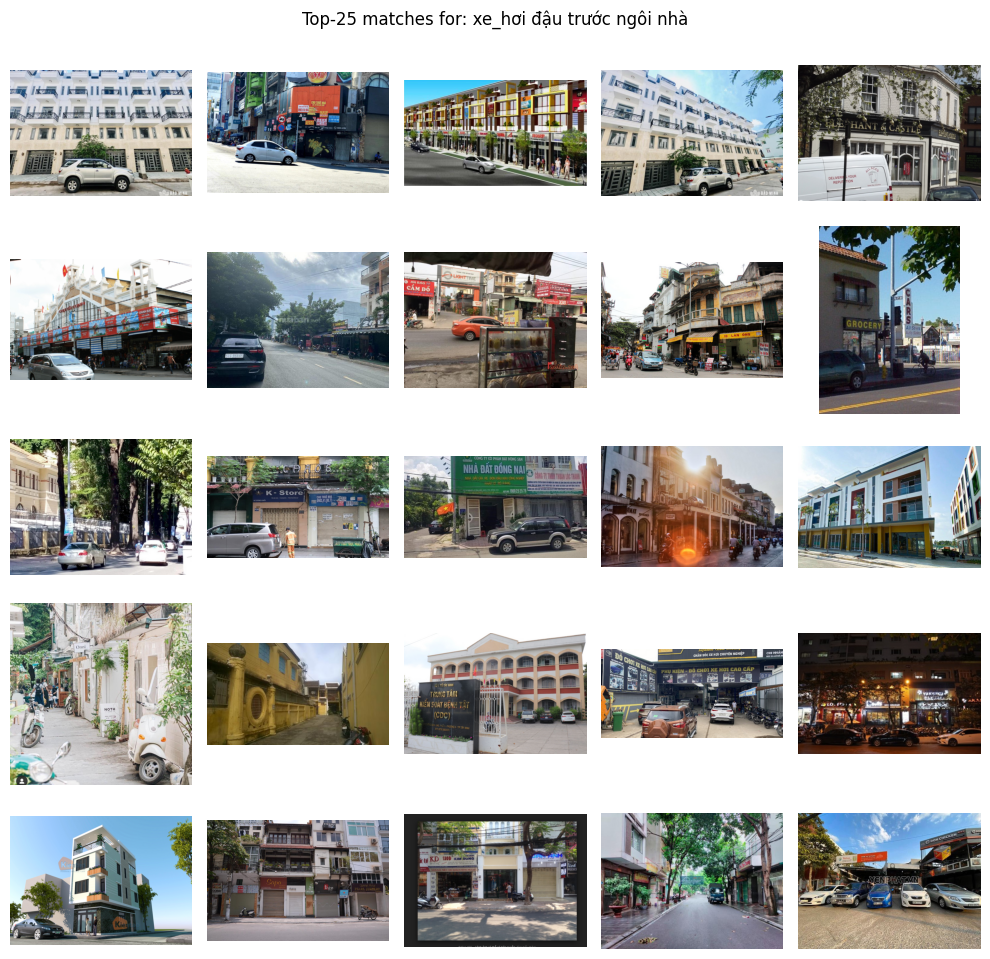

💾 Lưu kết quả tại: xe_hơi đậu trước ngôi nhà.res.png


In [142]:
find_matches(
    model,
    image_embeddings,
    image_filenames=valid_df['image'].values,
    text=" xe hơi đậu trước ngôi nhà",
    # image_path='cute-girl.jpg',
    n=25
)

# nhiều người - chua.jpg 

![](./images/dance.png)